In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install tensorflow

In [14]:
main_path = r'.'
data_path = main_path+'/data'
import sys
sys.path.append(main_path)
from BayDS.lib.pipeline import *
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union
from BayDS.lib.io import *
from BayDS.lib.training import *
from BayDS.lib.selection import *

import os
import pickle
import gc


import numpy
import pandas as pd

import scipy
from scipy.linalg import norm
from tqdm import tqdm
import dask.dataframe as dd

In [3]:
from BayDS.lib.pipeline.aggregate_nodes import AddGlobalNumericalAggregatesNode, AddGlobalFrequencyEncodingNode,AddGroupFrequencyEncodingNode

In [5]:
initial_data = pd.read_pickle('./FE/initial_data.pkl')


In [8]:
exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23','field12',
       'goal24', 'goal25', 'goal1','userid']

field0             field1  field2  field3  field4  field5  field6  \
orderid                                                                      
1000000       0 -0.626508116722107      11      12       1       1       0   
1000001     144 -0.393794029951096       5       7       2       0       0   
1000002     134 -0.548936784267426       2       3       2       0       0   
1000003       0 -0.238651320338249      10      11       1       1       3   
1000004       0 -0.704079508781433       8      11       1       1       0   
...         ...                ...     ...     ...     ...     ...     ...   
455006        0  2.553917646408081       8       8       1       1      10   
455007        0 -0.238651320338249       9       9       1       1       1   
455008        0 -0.161079958081245      10      11       1       1       0   
455009        0 -0.704079508781433      12       1       1       1       0   
455010        0  0.226776853203773      10      10       1       1       3   

         field7  field8  field9  ...  price2  field0bin  field6bin  \
orderid                          ...                                 
1000000       1       1       0  ...       2          0          0   
1000001       2       1       0  ...       6          3          0   
1000002       1       1       0  ...       2          3          0   
1000003       2       1       0  ...       3          0          1   
1000004       1       1       0  ...       1          0          0   
...         ...     ...     ...  ...     ...        ...        ...   
455006        2       0       0  ...      22          0          2   
455007        1       1       0  ...       7          0          0   
455008        1       1       0  ...       8          0          0   
455009        1       1       0  ...       1          0          0   
455010        1       0       0  ...       7          0          1   

         field13bin  field16bin  field17bin  field22bin  field25bin  \
orderid                                                               
1000000           3           2           0           0           0   
1000001           0           8           0           7           2   
1000002           0           2           0           2           0   
1000003           0           6           0           5           1   
1000004           0           8           0           2           0   
...             ...         ...         ...         ...         ...   
455006            2           6           0           7           2   
455007            5           6           0           3           0   
455008            0           0           0           4           0   
455009            0           7           0           2           0   
455010            2           4           0           0           0   

         price1bin  price2bin  
orderid                        
1000000          0          0  
1000001          3          4  
1000002          1          0  
1000003          4          1  
1000004          0          0  
...            ...        ...  
455006           9          8  
455007           4          5  
455008           5          6  
455009           0          0  
455010           7          5  

[651067 rows x 40 columns]

In [16]:
C = CorrelatorCPU(initial_data.loc[:,[col for col in initial_data.columns if col not in exclude_features_from_training and initial_data[col].dtype.name!='category']])

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 36.36it/s]


In [16]:
train_idx = p.data['data'][p.data['data']['goal1'] >= 0].index
goal1 = p.data['data'].loc[train_idx,'goal1']

In [18]:
data_arrays = ['./FE2/BEST3155+Orig.pqt','./temp/data_with_temporal.pkl' ,'./FE3/Corr_features_4999.pqt']


In [4]:
# rating={}
corr_threshold = 0.5


In [26]:
started=False
for d in data_arrays:
    if d.endswith('pqt'):
        df = pd.read_parquet(d)
    else:
        df = pd.read_pickle(d)
    print("Starting ", d)
    
    for col in tqdm(df.columns):
        if col == 'userid_freq_groupby_field26':
            started=True
        if not started:
            continue
        if df[col].dtype.name not in ('category','object'):
            corr = C.get_max_corr(df[col])
            if corr < corr_threshold:
                C.add_vector(df[col])
                print('\n',col,corr)
            else:
                print('.', end='')   

  0%|                                                                                         | 0/3171 [00:00<?, ?it/s]

Starting  ./FE2/BEST3155+Orig.pqt


 99%|███████████████████████████████████████████████████████████████████████████▎| 3144/3171 [00:00<00:00, 6732.24it/s]

............
 goal1 0.003803095
.............

100%|█████████████████████████████████████████████████████████████████████████████| 3171/3171 [00:10<00:00, 314.65it/s]

.


  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

Starting  ./temp/data_with_temporal.pkl


  1%|▋                                                                                 | 1/128 [00:00<00:54,  2.35it/s]

.

  2%|█▎                                                                                | 2/128 [00:00<00:52,  2.40it/s]


 field0_by_userid_ws2_to_std 0.23299068


  2%|█▉                                                                                | 3/128 [00:01<00:50,  2.48it/s]

.

  3%|██▌                                                                               | 4/128 [00:01<00:49,  2.48it/s]


 field0_by_userid_ws4_to_std 0.006621741


  4%|███▏                                                                              | 5/128 [00:01<00:48,  2.54it/s]

.

  5%|███▊                                                                              | 6/128 [00:02<00:47,  2.58it/s]

.

  5%|████▍                                                                             | 7/128 [00:02<00:46,  2.60it/s]

.

  6%|█████▏                                                                            | 8/128 [00:03<00:46,  2.59it/s]

.

  7%|█████▊                                                                            | 9/128 [00:03<00:45,  2.59it/s]


 field1_by_userid_ws2_to_mean 0.17970268


  8%|██████▎                                                                          | 10/128 [00:03<00:45,  2.58it/s]


 field1_by_userid_ws2_to_std 0.068331815


  9%|██████▉                                                                          | 11/128 [00:04<00:45,  2.59it/s]


 field1_by_userid_ws4_to_mean 0.42740628


  9%|███████▌                                                                         | 12/128 [00:04<00:44,  2.58it/s]


 field1_by_userid_ws4_to_std 0.09805798


 10%|████████▏                                                                        | 13/128 [00:05<00:43,  2.62it/s]

.

 11%|████████▊                                                                        | 14/128 [00:05<00:44,  2.59it/s]


 field1_by_userid_ws8_to_std 0.08302479


 12%|█████████▍                                                                       | 15/128 [00:05<00:43,  2.58it/s]


 field1_by_userid_ws16_to_mean 0.33068037


 12%|██████████▏                                                                      | 16/128 [00:06<00:44,  2.54it/s]


 field1_by_userid_ws16_to_std 0.24961811


 13%|██████████▊                                                                      | 17/128 [00:06<00:43,  2.53it/s]

.

 14%|███████████▍                                                                     | 18/128 [00:07<00:44,  2.50it/s]


 field6_by_userid_ws2_to_std 0.24190874


 15%|████████████                                                                     | 19/128 [00:07<00:43,  2.53it/s]

.

 16%|████████████▋                                                                    | 20/128 [00:07<00:43,  2.49it/s]


 field6_by_userid_ws4_to_std 0.0062988796


 16%|█████████████▎                                                                   | 21/128 [00:08<00:42,  2.50it/s]

.

 17%|█████████████▉                                                                   | 22/128 [00:08<00:42,  2.52it/s]

.

 18%|██████████████▌                                                                  | 23/128 [00:09<00:41,  2.52it/s]

.

 19%|███████████████▏                                                                 | 24/128 [00:09<00:40,  2.57it/s]

.

 20%|███████████████▊                                                                 | 25/128 [00:09<00:39,  2.59it/s]

.

 20%|████████████████▍                                                                | 26/128 [00:10<00:39,  2.58it/s]

.

 21%|█████████████████                                                                | 27/128 [00:10<00:39,  2.54it/s]

.

 22%|█████████████████▋                                                               | 28/128 [00:10<00:39,  2.54it/s]

.

 23%|██████████████████▎                                                              | 29/128 [00:11<00:39,  2.53it/s]

.

 23%|██████████████████▉                                                              | 30/128 [00:11<00:38,  2.53it/s]

.

 24%|███████████████████▌                                                             | 31/128 [00:12<00:38,  2.54it/s]

.

 25%|████████████████████▎                                                            | 32/128 [00:12<00:37,  2.53it/s]

.

 26%|████████████████████▉                                                            | 33/128 [00:12<00:37,  2.54it/s]

.

 27%|█████████████████████▌                                                           | 34/128 [00:13<00:37,  2.50it/s]


 field11_by_userid_ws2_to_std 0.46531293


 27%|██████████████████████▏                                                          | 35/128 [00:13<00:36,  2.52it/s]

.

 28%|██████████████████████▊                                                          | 36/128 [00:14<00:37,  2.47it/s]


 field11_by_userid_ws4_to_std 0.09111678


 29%|███████████████████████▍                                                         | 37/128 [00:14<00:36,  2.52it/s]

.

 30%|████████████████████████                                                         | 38/128 [00:14<00:35,  2.57it/s]

.

 30%|████████████████████████▋                                                        | 39/128 [00:15<00:34,  2.60it/s]

.

 31%|█████████████████████████▎                                                       | 40/128 [00:15<00:33,  2.62it/s]

.

 32%|█████████████████████████▉                                                       | 41/128 [00:16<00:33,  2.64it/s]

.

 33%|██████████████████████████▌                                                      | 42/128 [00:16<00:33,  2.60it/s]


 field13_by_userid_ws2_to_std 0.19853167


 34%|███████████████████████████▏                                                     | 43/128 [00:16<00:32,  2.63it/s]

.

 34%|███████████████████████████▊                                                     | 44/128 [00:17<00:32,  2.62it/s]


 field13_by_userid_ws4_to_std 0.00783367


 35%|████████████████████████████▍                                                    | 45/128 [00:17<00:31,  2.59it/s]

.

 36%|█████████████████████████████                                                    | 46/128 [00:17<00:31,  2.58it/s]


 field13_by_userid_ws8_to_std 0.0134838885


 37%|█████████████████████████████▋                                                   | 47/128 [00:18<00:30,  2.62it/s]

.

 38%|██████████████████████████████▍                                                  | 48/128 [00:18<00:30,  2.59it/s]


 field13_by_userid_ws16_to_std 0.028588375


 38%|███████████████████████████████                                                  | 49/128 [00:19<00:30,  2.58it/s]


 field14_by_userid_ws2_to_mean 0.44528472


 39%|███████████████████████████████▋                                                 | 50/128 [00:19<00:30,  2.58it/s]


 field14_by_userid_ws2_to_std 0.21661393


 40%|████████████████████████████████▎                                                | 51/128 [00:19<00:29,  2.57it/s]


 field14_by_userid_ws4_to_mean 0.17963758


 41%|████████████████████████████████▉                                                | 52/128 [00:20<00:29,  2.57it/s]


 field14_by_userid_ws4_to_std 0.1296008


 41%|█████████████████████████████████▌                                               | 53/128 [00:20<00:29,  2.57it/s]


 field14_by_userid_ws8_to_mean 0.32063523


 42%|██████████████████████████████████▏                                              | 54/128 [00:21<00:29,  2.55it/s]


 field14_by_userid_ws8_to_std 0.19903934


 43%|██████████████████████████████████▊                                              | 55/128 [00:21<00:28,  2.59it/s]

.

 44%|███████████████████████████████████▍                                             | 56/128 [00:21<00:27,  2.60it/s]

.

 45%|████████████████████████████████████                                             | 57/128 [00:22<00:27,  2.62it/s]

.

 45%|████████████████████████████████████▋                                            | 58/128 [00:22<00:26,  2.60it/s]


 field15_by_userid_ws2_to_std 0.41891968


 46%|█████████████████████████████████████▎                                           | 59/128 [00:22<00:26,  2.63it/s]

.

 47%|█████████████████████████████████████▉                                           | 60/128 [00:23<00:26,  2.60it/s]


 field15_by_userid_ws4_to_std 0.010306447


 48%|██████████████████████████████████████▌                                          | 61/128 [00:23<00:25,  2.64it/s]

.

 48%|███████████████████████████████████████▏                                         | 62/128 [00:24<00:25,  2.61it/s]


 field15_by_userid_ws8_to_std 0.15441494


 49%|███████████████████████████████████████▊                                         | 63/128 [00:24<00:24,  2.64it/s]

.

 50%|████████████████████████████████████████▌                                        | 64/128 [00:24<00:24,  2.60it/s]


 field15_by_userid_ws16_to_std 0.08782836


 51%|█████████████████████████████████████████▏                                       | 65/128 [00:25<00:23,  2.64it/s]

.

 52%|█████████████████████████████████████████▊                                       | 66/128 [00:25<00:23,  2.62it/s]


 field16_by_userid_ws2_to_std 0.25561377


 52%|██████████████████████████████████████████▍                                      | 67/128 [00:26<00:23,  2.64it/s]

.

 53%|███████████████████████████████████████████                                      | 68/128 [00:26<00:22,  2.62it/s]


 field16_by_userid_ws4_to_std 0.0072940737


 54%|███████████████████████████████████████████▋                                     | 69/128 [00:26<00:22,  2.65it/s]

.

 55%|████████████████████████████████████████████▎                                    | 70/128 [00:27<00:22,  2.62it/s]


 field16_by_userid_ws8_to_std 0.05922079


 55%|████████████████████████████████████████████▉                                    | 71/128 [00:27<00:21,  2.64it/s]

.

 56%|█████████████████████████████████████████████▌                                   | 72/128 [00:27<00:21,  2.63it/s]

.

 57%|██████████████████████████████████████████████▏                                  | 73/128 [00:28<00:20,  2.65it/s]

.

 58%|██████████████████████████████████████████████▊                                  | 74/128 [00:28<00:20,  2.62it/s]


 field17_by_userid_ws2_to_std 0.3284613


 59%|███████████████████████████████████████████████▍                                 | 75/128 [00:29<00:20,  2.63it/s]

.

 59%|████████████████████████████████████████████████                                 | 76/128 [00:29<00:19,  2.60it/s]


 field17_by_userid_ws4_to_std 0.013457324


 60%|████████████████████████████████████████████████▋                                | 77/128 [00:29<00:19,  2.63it/s]

.

 61%|█████████████████████████████████████████████████▎                               | 78/128 [00:30<00:19,  2.60it/s]


 field17_by_userid_ws8_to_std 0.022745874


 62%|█████████████████████████████████████████████████▉                               | 79/128 [00:30<00:18,  2.64it/s]

.

 62%|██████████████████████████████████████████████████▋                              | 80/128 [00:30<00:18,  2.60it/s]


 field17_by_userid_ws16_to_std 0.40736565


 63%|███████████████████████████████████████████████████▎                             | 81/128 [00:31<00:17,  2.64it/s]

.

 64%|███████████████████████████████████████████████████▉                             | 82/128 [00:31<00:17,  2.62it/s]


 field19_by_userid_ws2_to_std 0.2436648


 65%|████████████████████████████████████████████████████▌                            | 83/128 [00:32<00:16,  2.65it/s]

.

 66%|█████████████████████████████████████████████████████▏                           | 84/128 [00:32<00:16,  2.62it/s]


 field19_by_userid_ws4_to_std 0.030682802


 66%|█████████████████████████████████████████████████████▊                           | 85/128 [00:32<00:16,  2.66it/s]

.

 67%|██████████████████████████████████████████████████████▍                          | 86/128 [00:33<00:15,  2.63it/s]


 field19_by_userid_ws8_to_std 0.051348664


 68%|███████████████████████████████████████████████████████                          | 87/128 [00:33<00:15,  2.66it/s]

.

 69%|███████████████████████████████████████████████████████▋                         | 88/128 [00:34<00:15,  2.63it/s]


 field19_by_userid_ws16_to_std 0.26370627


 70%|████████████████████████████████████████████████████████▎                        | 89/128 [00:34<00:14,  2.66it/s]

.

 70%|████████████████████████████████████████████████████████▉                        | 90/128 [00:34<00:14,  2.63it/s]


 field22_by_userid_ws2_to_std 0.1859067


 71%|█████████████████████████████████████████████████████████▌                       | 91/128 [00:35<00:13,  2.65it/s]

.

 72%|██████████████████████████████████████████████████████████▏                      | 92/128 [00:35<00:13,  2.63it/s]


 field22_by_userid_ws4_to_std 0.011223532


 73%|██████████████████████████████████████████████████████████▊                      | 93/128 [00:35<00:13,  2.65it/s]

.

 73%|███████████████████████████████████████████████████████████▍                     | 94/128 [00:36<00:12,  2.66it/s]

.

 74%|████████████████████████████████████████████████████████████                     | 95/128 [00:36<00:12,  2.68it/s]

.

 75%|████████████████████████████████████████████████████████████▊                    | 96/128 [00:37<00:12,  2.64it/s]


 field22_by_userid_ws16_to_std 0.11905278


 76%|█████████████████████████████████████████████████████████████▍                   | 97/128 [00:37<00:11,  2.66it/s]

.

 77%|██████████████████████████████████████████████████████████████                   | 98/128 [00:37<00:11,  2.61it/s]


 field23_by_userid_ws2_to_std 0.43226844


 77%|██████████████████████████████████████████████████████████████▋                  | 99/128 [00:38<00:11,  2.58it/s]

.

 78%|██████████████████████████████████████████████████████████████▌                 | 100/128 [00:38<00:11,  2.50it/s]


 field23_by_userid_ws4_to_std 0.0521567


 79%|███████████████████████████████████████████████████████████████▏                | 101/128 [00:39<00:10,  2.47it/s]

.

 80%|███████████████████████████████████████████████████████████████▊                | 102/128 [00:39<00:10,  2.48it/s]

.

 80%|████████████████████████████████████████████████████████████████▍               | 103/128 [00:39<00:10,  2.49it/s]

.

 81%|█████████████████████████████████████████████████████████████████               | 104/128 [00:40<00:09,  2.52it/s]

.

 82%|█████████████████████████████████████████████████████████████████▋              | 105/128 [00:40<00:08,  2.56it/s]

.

 83%|██████████████████████████████████████████████████████████████████▎             | 106/128 [00:40<00:08,  2.59it/s]

.

 84%|██████████████████████████████████████████████████████████████████▉             | 107/128 [00:41<00:08,  2.59it/s]

.

 84%|███████████████████████████████████████████████████████████████████▌            | 108/128 [00:41<00:07,  2.58it/s]

.

 85%|████████████████████████████████████████████████████████████████████▏           | 109/128 [00:42<00:07,  2.56it/s]

.

 86%|████████████████████████████████████████████████████████████████████▊           | 110/128 [00:42<00:06,  2.57it/s]

.

 87%|█████████████████████████████████████████████████████████████████████▍          | 111/128 [00:42<00:06,  2.59it/s]

.

 88%|██████████████████████████████████████████████████████████████████████          | 112/128 [00:43<00:06,  2.60it/s]

.

 88%|██████████████████████████████████████████████████████████████████████▋         | 113/128 [00:43<00:05,  2.60it/s]

.

 89%|███████████████████████████████████████████████████████████████████████▎        | 114/128 [00:44<00:05,  2.57it/s]


 field25_by_userid_ws2_to_std 0.22645316


 90%|███████████████████████████████████████████████████████████████████████▉        | 115/128 [00:44<00:05,  2.59it/s]

.

 91%|████████████████████████████████████████████████████████████████████████▌       | 116/128 [00:44<00:04,  2.57it/s]


 field25_by_userid_ws4_to_std 0.34041977


 91%|█████████████████████████████████████████████████████████████████████████▏      | 117/128 [00:45<00:04,  2.60it/s]

.

 92%|█████████████████████████████████████████████████████████████████████████▊      | 118/128 [00:45<00:03,  2.58it/s]


 field25_by_userid_ws8_to_std 0.112847395


 93%|██████████████████████████████████████████████████████████████████████████▍     | 119/128 [00:45<00:03,  2.62it/s]

.

 94%|███████████████████████████████████████████████████████████████████████████     | 120/128 [00:46<00:03,  2.63it/s]

.

 95%|███████████████████████████████████████████████████████████████████████████▋    | 121/128 [00:46<00:02,  2.65it/s]

.

 95%|████████████████████████████████████████████████████████████████████████████▎   | 122/128 [00:47<00:02,  2.59it/s]


 field28_by_userid_ws2_to_std 0.48159268


 96%|████████████████████████████████████████████████████████████████████████████▉   | 123/128 [00:47<00:01,  2.59it/s]

.

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 124/128 [00:47<00:01,  2.62it/s]

.

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 125/128 [00:48<00:01,  2.63it/s]

.

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 126/128 [00:48<00:00,  2.65it/s]

.

 99%|███████████████████████████████████████████████████████████████████████████████▍| 127/128 [00:49<00:00,  2.63it/s]

.

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:49<00:00,  2.59it/s]

.


  0%|                                                                                         | 0/4999 [00:00<?, ?it/s]

Starting  ./FE3/Corr_features_4999.pqt


  0%|                                                                                 | 1/4999 [00:00<40:34,  2.05it/s]

.

  0%|                                                                                 | 2/4999 [00:00<39:54,  2.09it/s]

.

  0%|                                                                                 | 3/4999 [00:01<38:38,  2.15it/s]

.

  0%|                                                                                 | 4/4999 [00:01<36:18,  2.29it/s]

.

  0%|                                                                                 | 5/4999 [00:02<34:48,  2.39it/s]

.

  0%|                                                                                 | 6/4999 [00:02<33:37,  2.48it/s]

.

  0%|                                                                                 | 7/4999 [00:02<32:38,  2.55it/s]

.

  0%|▏                                                                                | 8/4999 [00:03<31:55,  2.61it/s]

.

  0%|▏                                                                                | 9/4999 [00:03<31:54,  2.61it/s]

.

  0%|▏                                                                               | 10/4999 [00:03<31:28,  2.64it/s]

.

  0%|▏                                                                               | 11/4999 [00:04<31:21,  2.65it/s]

.

  0%|▏                                                                               | 12/4999 [00:04<31:11,  2.66it/s]

.

  0%|▏                                                                               | 13/4999 [00:05<31:00,  2.68it/s]

.

  0%|▏                                                                               | 14/4999 [00:05<31:17,  2.65it/s]

.

  0%|▏                                                                               | 15/4999 [00:05<31:22,  2.65it/s]

.

  0%|▎                                                                               | 16/4999 [00:06<31:12,  2.66it/s]

.

  0%|▎                                                                               | 17/4999 [00:06<31:21,  2.65it/s]

.

  0%|▎                                                                               | 18/4999 [00:06<31:12,  2.66it/s]

.

  0%|▎                                                                               | 19/4999 [00:07<31:21,  2.65it/s]

.

  0%|▎                                                                               | 20/4999 [00:07<31:07,  2.67it/s]

.

  0%|▎                                                                               | 21/4999 [00:08<30:53,  2.69it/s]

.

  0%|▎                                                                               | 22/4999 [00:08<30:54,  2.68it/s]

.

  0%|▎                                                                               | 23/4999 [00:08<30:47,  2.69it/s]

.

  0%|▍                                                                               | 24/4999 [00:09<30:50,  2.69it/s]

.

  1%|▍                                                                               | 25/4999 [00:09<30:57,  2.68it/s]

.

  1%|▍                                                                               | 26/4999 [00:09<31:14,  2.65it/s]

.

  1%|▍                                                                               | 27/4999 [00:10<31:00,  2.67it/s]

.

  1%|▍                                                                               | 28/4999 [00:10<30:58,  2.67it/s]

.

  1%|▍                                                                               | 29/4999 [00:11<30:46,  2.69it/s]

.

  1%|▍                                                                               | 30/4999 [00:11<30:39,  2.70it/s]

.

  1%|▍                                                                               | 31/4999 [00:11<30:47,  2.69it/s]

.

  1%|▌                                                                               | 32/4999 [00:12<30:47,  2.69it/s]

.

  1%|▌                                                                               | 33/4999 [00:12<30:39,  2.70it/s]

.

  1%|▌                                                                               | 34/4999 [00:12<30:52,  2.68it/s]

.

  1%|▌                                                                               | 35/4999 [00:13<30:44,  2.69it/s]

.

  1%|▌                                                                               | 36/4999 [00:13<30:46,  2.69it/s]

.

  1%|▌                                                                               | 37/4999 [00:14<30:48,  2.68it/s]

.

  1%|▌                                                                               | 38/4999 [00:14<30:37,  2.70it/s]

.

  1%|▌                                                                               | 39/4999 [00:14<30:40,  2.69it/s]

.

  1%|▋                                                                               | 40/4999 [00:15<30:49,  2.68it/s]

.

  1%|▋                                                                               | 41/4999 [00:15<30:45,  2.69it/s]

.

  1%|▋                                                                               | 42/4999 [00:15<30:37,  2.70it/s]

.

  1%|▋                                                                               | 43/4999 [00:16<30:28,  2.71it/s]

.

  1%|▋                                                                               | 44/4999 [00:16<30:26,  2.71it/s]

.

  1%|▋                                                                               | 45/4999 [00:17<30:25,  2.71it/s]

.

  1%|▋                                                                               | 46/4999 [00:17<30:31,  2.70it/s]

.

  1%|▊                                                                               | 47/4999 [00:17<30:21,  2.72it/s]

.

  1%|▊                                                                               | 48/4999 [00:18<30:25,  2.71it/s]

.

  1%|▊                                                                               | 49/4999 [00:18<30:27,  2.71it/s]

.

  1%|▊                                                                               | 50/4999 [00:18<30:41,  2.69it/s]

.

  1%|▊                                                                               | 51/4999 [00:19<30:38,  2.69it/s]

.

  1%|▊                                                                               | 52/4999 [00:19<30:39,  2.69it/s]

.

  1%|▊                                                                               | 53/4999 [00:19<30:53,  2.67it/s]

.

  1%|▊                                                                               | 54/4999 [00:20<31:02,  2.66it/s]

.

  1%|▉                                                                               | 55/4999 [00:20<30:57,  2.66it/s]

.

  1%|▉                                                                               | 56/4999 [00:21<31:05,  2.65it/s]

.

  1%|▉                                                                               | 57/4999 [00:21<30:55,  2.66it/s]

.

  1%|▉                                                                               | 58/4999 [00:21<30:49,  2.67it/s]

.

  1%|▉                                                                               | 59/4999 [00:22<30:53,  2.67it/s]

.

  1%|▉                                                                               | 60/4999 [00:22<30:49,  2.67it/s]

.

  1%|▉                                                                               | 61/4999 [00:22<30:47,  2.67it/s]

.

  1%|▉                                                                               | 62/4999 [00:23<30:52,  2.66it/s]

.

  1%|█                                                                               | 63/4999 [00:23<30:38,  2.68it/s]

.

  1%|█                                                                               | 64/4999 [00:24<30:30,  2.70it/s]

.

  1%|█                                                                               | 65/4999 [00:24<30:24,  2.71it/s]

.

  1%|█                                                                               | 66/4999 [00:24<30:22,  2.71it/s]

.

  1%|█                                                                               | 67/4999 [00:25<30:36,  2.69it/s]

.

  1%|█                                                                               | 68/4999 [00:25<30:26,  2.70it/s]

.

  1%|█                                                                               | 69/4999 [00:25<30:21,  2.71it/s]

.

  1%|█                                                                               | 70/4999 [00:26<30:14,  2.72it/s]

.

  1%|█▏                                                                              | 71/4999 [00:26<30:13,  2.72it/s]

.

  1%|█▏                                                                              | 72/4999 [00:27<30:31,  2.69it/s]

.

  1%|█▏                                                                              | 73/4999 [00:27<30:38,  2.68it/s]

.

  1%|█▏                                                                              | 74/4999 [00:27<30:39,  2.68it/s]

.

  2%|█▏                                                                              | 75/4999 [00:28<30:44,  2.67it/s]

.

  2%|█▏                                                                              | 76/4999 [00:28<30:40,  2.68it/s]

.

  2%|█▏                                                                              | 77/4999 [00:28<30:32,  2.69it/s]

.

  2%|█▏                                                                              | 78/4999 [00:29<30:25,  2.70it/s]

.

  2%|█▎                                                                              | 79/4999 [00:29<30:18,  2.71it/s]

.

  2%|█▎                                                                              | 80/4999 [00:30<30:30,  2.69it/s]

.

  2%|█▎                                                                              | 81/4999 [00:30<30:41,  2.67it/s]

.

  2%|█▎                                                                              | 82/4999 [00:30<30:18,  2.70it/s]

.

  2%|█▎                                                                              | 83/4999 [00:31<30:22,  2.70it/s]

.

  2%|█▎                                                                              | 84/4999 [00:31<30:19,  2.70it/s]

.

  2%|█▎                                                                              | 85/4999 [00:31<30:20,  2.70it/s]

.

  2%|█▍                                                                              | 86/4999 [00:32<30:22,  2.70it/s]

.

  2%|█▍                                                                              | 87/4999 [00:32<30:36,  2.67it/s]

.

  2%|█▍                                                                              | 88/4999 [00:33<30:33,  2.68it/s]

.

  2%|█▍                                                                              | 89/4999 [00:33<30:25,  2.69it/s]

.

  2%|█▍                                                                              | 90/4999 [00:33<30:26,  2.69it/s]

.

  2%|█▍                                                                              | 91/4999 [00:34<30:21,  2.69it/s]

.

  2%|█▍                                                                              | 92/4999 [00:34<30:22,  2.69it/s]

.

  2%|█▍                                                                              | 93/4999 [00:34<30:15,  2.70it/s]

.

  2%|█▌                                                                              | 94/4999 [00:35<30:31,  2.68it/s]

.

  2%|█▌                                                                              | 95/4999 [00:35<30:29,  2.68it/s]

.

  2%|█▌                                                                              | 96/4999 [00:35<30:18,  2.70it/s]

.

  2%|█▌                                                                              | 97/4999 [00:36<30:19,  2.69it/s]

.

  2%|█▌                                                                              | 98/4999 [00:36<30:08,  2.71it/s]

.

  2%|█▌                                                                              | 99/4999 [00:37<30:15,  2.70it/s]

.

  2%|█▌                                                                             | 100/4999 [00:37<30:08,  2.71it/s]

.

  2%|█▌                                                                             | 101/4999 [00:37<30:05,  2.71it/s]

.

  2%|█▌                                                                             | 102/4999 [00:38<30:00,  2.72it/s]

.

  2%|█▋                                                                             | 103/4999 [00:38<30:02,  2.72it/s]

.

  2%|█▋                                                                             | 104/4999 [00:38<30:07,  2.71it/s]

.

  2%|█▋                                                                             | 105/4999 [00:39<30:09,  2.70it/s]

.

  2%|█▋                                                                             | 106/4999 [00:39<30:33,  2.67it/s]

.

  2%|█▋                                                                             | 107/4999 [00:40<30:55,  2.64it/s]

.

  2%|█▋                                                                             | 108/4999 [00:40<30:45,  2.65it/s]

.

  2%|█▋                                                                             | 109/4999 [00:40<30:30,  2.67it/s]

.

  2%|█▋                                                                             | 110/4999 [00:41<30:11,  2.70it/s]

.

  2%|█▊                                                                             | 111/4999 [00:41<30:14,  2.69it/s]

.

  2%|█▊                                                                             | 112/4999 [00:41<30:06,  2.70it/s]

.

  2%|█▊                                                                             | 113/4999 [00:42<30:27,  2.67it/s]

.

  2%|█▊                                                                             | 114/4999 [00:42<30:35,  2.66it/s]

.

  2%|█▊                                                                             | 115/4999 [00:43<30:21,  2.68it/s]

.

  2%|█▊                                                                             | 116/4999 [00:43<30:22,  2.68it/s]

.

  2%|█▊                                                                             | 117/4999 [00:43<30:24,  2.68it/s]

.

  2%|█▊                                                                             | 118/4999 [00:44<30:26,  2.67it/s]

.

  2%|█▉                                                                             | 119/4999 [00:44<30:16,  2.69it/s]

.

  2%|█▉                                                                             | 120/4999 [00:44<30:14,  2.69it/s]

.

  2%|█▉                                                                             | 121/4999 [00:45<30:05,  2.70it/s]

.

  2%|█▉                                                                             | 122/4999 [00:45<30:00,  2.71it/s]

.

  2%|█▉                                                                             | 123/4999 [00:46<29:49,  2.72it/s]

.

  2%|█▉                                                                             | 124/4999 [00:46<30:24,  2.67it/s]

.

  3%|█▉                                                                             | 125/4999 [00:46<30:38,  2.65it/s]

.

  3%|█▉                                                                             | 126/4999 [00:47<30:39,  2.65it/s]

.

  3%|██                                                                             | 127/4999 [00:47<30:27,  2.67it/s]

.

  3%|██                                                                             | 128/4999 [00:47<30:46,  2.64it/s]

.

  3%|██                                                                             | 129/4999 [00:48<31:10,  2.60it/s]

.

  3%|██                                                                             | 130/4999 [00:48<30:59,  2.62it/s]

.

  3%|██                                                                             | 131/4999 [00:49<30:58,  2.62it/s]

.

  3%|██                                                                             | 132/4999 [00:49<31:05,  2.61it/s]

.

  3%|██                                                                             | 133/4999 [00:49<31:17,  2.59it/s]

.

  3%|██                                                                             | 134/4999 [00:50<31:37,  2.56it/s]

.

  3%|██▏                                                                            | 135/4999 [00:50<31:09,  2.60it/s]

.

  3%|██▏                                                                            | 136/4999 [00:51<30:59,  2.61it/s]

.

  3%|██▏                                                                            | 137/4999 [00:51<30:51,  2.63it/s]

.

  3%|██▏                                                                            | 138/4999 [00:51<30:29,  2.66it/s]

.

  3%|██▏                                                                            | 139/4999 [00:52<30:16,  2.67it/s]

.

  3%|██▏                                                                            | 140/4999 [00:52<30:15,  2.68it/s]

.

  3%|██▏                                                                            | 141/4999 [00:52<30:15,  2.68it/s]

.

  3%|██▏                                                                            | 142/4999 [00:53<30:08,  2.69it/s]

.

  3%|██▎                                                                            | 143/4999 [00:53<30:03,  2.69it/s]

.

  3%|██▎                                                                            | 144/4999 [00:53<29:53,  2.71it/s]

.

  3%|██▎                                                                            | 145/4999 [00:54<29:46,  2.72it/s]

.

  3%|██▎                                                                            | 146/4999 [00:54<29:38,  2.73it/s]

.

  3%|██▎                                                                            | 147/4999 [00:55<29:46,  2.72it/s]

.

  3%|██▎                                                                            | 148/4999 [00:55<29:47,  2.71it/s]

.

  3%|██▎                                                                            | 149/4999 [00:55<29:49,  2.71it/s]

.

  3%|██▎                                                                            | 150/4999 [00:56<29:40,  2.72it/s]

.

  3%|██▍                                                                            | 151/4999 [00:56<29:44,  2.72it/s]

.

  3%|██▍                                                                            | 152/4999 [00:56<29:40,  2.72it/s]

.

  3%|██▍                                                                            | 153/4999 [00:57<29:47,  2.71it/s]

.

  3%|██▍                                                                            | 154/4999 [00:57<29:44,  2.72it/s]

.

  3%|██▍                                                                            | 155/4999 [00:58<29:50,  2.71it/s]

.

  3%|██▍                                                                            | 156/4999 [00:58<29:47,  2.71it/s]

.

  3%|██▍                                                                            | 157/4999 [00:58<30:00,  2.69it/s]

.

  3%|██▍                                                                            | 158/4999 [00:59<30:03,  2.68it/s]

.

  3%|██▌                                                                            | 159/4999 [00:59<30:12,  2.67it/s]

.

  3%|██▌                                                                            | 160/4999 [00:59<29:58,  2.69it/s]

.

  3%|██▌                                                                            | 161/4999 [01:00<30:05,  2.68it/s]

.

  3%|██▌                                                                            | 162/4999 [01:00<29:59,  2.69it/s]

.

  3%|██▌                                                                            | 163/4999 [01:00<29:48,  2.70it/s]

.

  3%|██▌                                                                            | 164/4999 [01:01<29:55,  2.69it/s]

.

  3%|██▌                                                                            | 165/4999 [01:01<29:40,  2.72it/s]

.

  3%|██▌                                                                            | 166/4999 [01:02<29:36,  2.72it/s]

.

  3%|██▋                                                                            | 167/4999 [01:02<29:38,  2.72it/s]

.

  3%|██▋                                                                            | 168/4999 [01:02<29:30,  2.73it/s]

.

  3%|██▋                                                                            | 169/4999 [01:03<29:20,  2.74it/s]

.

  3%|██▋                                                                            | 170/4999 [01:03<29:32,  2.72it/s]

.

  3%|██▋                                                                            | 171/4999 [01:03<29:39,  2.71it/s]

.

  3%|██▋                                                                            | 172/4999 [01:04<29:46,  2.70it/s]

.

  3%|██▋                                                                            | 173/4999 [01:04<29:52,  2.69it/s]

.

  3%|██▋                                                                            | 174/4999 [01:05<29:55,  2.69it/s]

.

  4%|██▊                                                                            | 175/4999 [01:05<30:16,  2.66it/s]

.

  4%|██▊                                                                            | 176/4999 [01:05<30:22,  2.65it/s]

.

  4%|██▊                                                                            | 177/4999 [01:06<30:03,  2.67it/s]

.

  4%|██▊                                                                            | 178/4999 [01:06<30:10,  2.66it/s]

.

  4%|██▊                                                                            | 179/4999 [01:06<30:13,  2.66it/s]

.

  4%|██▊                                                                            | 180/4999 [01:07<30:24,  2.64it/s]

.

  4%|██▊                                                                            | 181/4999 [01:07<30:39,  2.62it/s]

.

  4%|██▉                                                                            | 182/4999 [01:08<30:47,  2.61it/s]

.

  4%|██▉                                                                            | 183/4999 [01:08<30:49,  2.60it/s]

.

  4%|██▉                                                                            | 184/4999 [01:08<30:36,  2.62it/s]

.

  4%|██▉                                                                            | 185/4999 [01:09<30:27,  2.63it/s]

.

  4%|██▉                                                                            | 186/4999 [01:09<30:26,  2.64it/s]

.

  4%|██▉                                                                            | 187/4999 [01:09<30:15,  2.65it/s]

.

  4%|██▉                                                                            | 188/4999 [01:10<30:24,  2.64it/s]


 field1_to_mean_groupby_good0 0.41369703


  4%|██▉                                                                            | 189/4999 [01:10<30:10,  2.66it/s]

.

  4%|███                                                                            | 190/4999 [01:11<30:27,  2.63it/s]

.

  4%|███                                                                            | 191/4999 [01:11<30:29,  2.63it/s]

.

  4%|███                                                                            | 192/4999 [01:11<30:34,  2.62it/s]

.

  4%|███                                                                            | 193/4999 [01:12<30:12,  2.65it/s]

.

  4%|███                                                                            | 194/4999 [01:12<29:52,  2.68it/s]

.

  4%|███                                                                            | 195/4999 [01:13<29:48,  2.69it/s]

.

  4%|███                                                                            | 196/4999 [01:13<29:49,  2.68it/s]

.

  4%|███                                                                            | 197/4999 [01:13<29:48,  2.69it/s]

.

  4%|███▏                                                                           | 198/4999 [01:14<29:51,  2.68it/s]

.

  4%|███▏                                                                           | 199/4999 [01:14<29:49,  2.68it/s]

.

  4%|███▏                                                                           | 200/4999 [01:14<29:36,  2.70it/s]

.

  4%|███▏                                                                           | 201/4999 [01:15<29:51,  2.68it/s]

.

  4%|███▏                                                                           | 202/4999 [01:15<29:33,  2.70it/s]

.

  4%|███▏                                                                           | 203/4999 [01:15<29:26,  2.72it/s]

.

  4%|███▏                                                                           | 204/4999 [01:16<29:26,  2.71it/s]

.

  4%|███▏                                                                           | 205/4999 [01:16<29:31,  2.71it/s]


 field1_to_mean_groupby_good1 0.4985628


  4%|███▎                                                                           | 206/4999 [01:17<29:24,  2.72it/s]

.

  4%|███▎                                                                           | 207/4999 [01:17<29:45,  2.68it/s]

.

  4%|███▎                                                                           | 208/4999 [01:17<29:31,  2.70it/s]

.

  4%|███▎                                                                           | 209/4999 [01:18<29:31,  2.70it/s]

.

  4%|███▎                                                                           | 210/4999 [01:18<29:35,  2.70it/s]

.

  4%|███▎                                                                           | 211/4999 [01:18<29:38,  2.69it/s]

.

  4%|███▎                                                                           | 212/4999 [01:19<29:34,  2.70it/s]

.

  4%|███▎                                                                           | 213/4999 [01:19<29:31,  2.70it/s]

.

  4%|███▍                                                                           | 214/4999 [01:20<29:28,  2.71it/s]

.

  4%|███▍                                                                           | 215/4999 [01:20<29:24,  2.71it/s]

.

  4%|███▍                                                                           | 216/4999 [01:20<29:17,  2.72it/s]

.

  4%|███▍                                                                           | 217/4999 [01:21<29:10,  2.73it/s]

.

  4%|███▍                                                                           | 218/4999 [01:21<29:17,  2.72it/s]

.

  4%|███▍                                                                           | 219/4999 [01:21<29:13,  2.73it/s]

.

  4%|███▍                                                                           | 220/4999 [01:22<29:15,  2.72it/s]

.

  4%|███▍                                                                           | 221/4999 [01:22<30:03,  2.65it/s]


 field16_to_stdscore_groupby_good4 0.4162616


  4%|███▌                                                                           | 222/4999 [01:23<30:39,  2.60it/s]

.

  4%|███▌                                                                           | 223/4999 [01:23<31:20,  2.54it/s]

.

  4%|███▌                                                                           | 224/4999 [01:23<31:19,  2.54it/s]

.

  5%|███▌                                                                           | 225/4999 [01:24<31:55,  2.49it/s]

.

  5%|███▌                                                                           | 226/4999 [01:24<31:57,  2.49it/s]

.

  5%|███▌                                                                           | 227/4999 [01:25<31:57,  2.49it/s]

.

  5%|███▌                                                                           | 228/4999 [01:25<31:50,  2.50it/s]

.

  5%|███▌                                                                           | 229/4999 [01:25<31:57,  2.49it/s]

.

  5%|███▋                                                                           | 230/4999 [01:26<31:48,  2.50it/s]

.

  5%|███▋                                                                           | 231/4999 [01:26<31:07,  2.55it/s]

.

  5%|███▋                                                                           | 232/4999 [01:27<30:47,  2.58it/s]

.

  5%|███▋                                                                           | 233/4999 [01:27<30:43,  2.59it/s]


 field1_to_mean_groupby_good9 0.21037216


  5%|███▋                                                                           | 234/4999 [01:27<30:33,  2.60it/s]

.

  5%|███▋                                                                           | 235/4999 [01:28<30:22,  2.61it/s]

.

  5%|███▋                                                                           | 236/4999 [01:28<30:22,  2.61it/s]

.

  5%|███▋                                                                           | 237/4999 [01:28<30:19,  2.62it/s]

.

  5%|███▊                                                                           | 238/4999 [01:29<30:14,  2.62it/s]

.

  5%|███▊                                                                           | 239/4999 [01:29<30:01,  2.64it/s]

.

  5%|███▊                                                                           | 240/4999 [01:30<29:57,  2.65it/s]

.

  5%|███▊                                                                           | 241/4999 [01:30<29:58,  2.64it/s]

.

  5%|███▊                                                                           | 242/4999 [01:30<29:47,  2.66it/s]

.

  5%|███▊                                                                           | 243/4999 [01:31<29:34,  2.68it/s]

.

  5%|███▊                                                                           | 244/4999 [01:31<29:38,  2.67it/s]

.

  5%|███▊                                                                           | 245/4999 [01:31<29:22,  2.70it/s]

.

  5%|███▉                                                                           | 246/4999 [01:32<29:26,  2.69it/s]

.

  5%|███▉                                                                           | 247/4999 [01:32<29:19,  2.70it/s]

.

  5%|███▉                                                                           | 248/4999 [01:33<29:18,  2.70it/s]

.

  5%|███▉                                                                           | 249/4999 [01:33<29:19,  2.70it/s]

.

  5%|███▉                                                                           | 250/4999 [01:33<29:05,  2.72it/s]

.

  5%|███▉                                                                           | 251/4999 [01:34<29:00,  2.73it/s]

.

  5%|███▉                                                                           | 252/4999 [01:34<28:59,  2.73it/s]

.

  5%|███▉                                                                           | 253/4999 [01:34<28:58,  2.73it/s]

.

  5%|████                                                                           | 254/4999 [01:35<28:56,  2.73it/s]

.

  5%|████                                                                           | 255/4999 [01:35<29:08,  2.71it/s]

.

  5%|████                                                                           | 256/4999 [01:35<29:10,  2.71it/s]

.

  5%|████                                                                           | 257/4999 [01:36<29:05,  2.72it/s]

.

  5%|████                                                                           | 258/4999 [01:36<29:02,  2.72it/s]

.

  5%|████                                                                           | 259/4999 [01:37<28:58,  2.73it/s]

.

  5%|████                                                                           | 260/4999 [01:37<29:11,  2.71it/s]

.

  5%|████                                                                           | 261/4999 [01:37<29:07,  2.71it/s]

.

  5%|████▏                                                                          | 262/4999 [01:38<29:02,  2.72it/s]

.

  5%|████▏                                                                          | 263/4999 [01:38<29:11,  2.70it/s]

.

  5%|████▏                                                                          | 264/4999 [01:38<29:04,  2.71it/s]

.

  5%|████▏                                                                          | 265/4999 [01:39<29:11,  2.70it/s]

.

  5%|████▏                                                                          | 266/4999 [01:39<29:08,  2.71it/s]

.

  5%|████▏                                                                          | 267/4999 [01:40<28:58,  2.72it/s]

.

  5%|████▏                                                                          | 268/4999 [01:40<28:59,  2.72it/s]

.

  5%|████▎                                                                          | 269/4999 [01:40<28:59,  2.72it/s]

.

  5%|████▎                                                                          | 270/4999 [01:41<28:56,  2.72it/s]

.

  5%|████▎                                                                          | 271/4999 [01:41<29:04,  2.71it/s]

.

  5%|████▎                                                                          | 272/4999 [01:41<29:08,  2.70it/s]

.

  5%|████▎                                                                          | 273/4999 [01:42<29:15,  2.69it/s]

.

  5%|████▎                                                                          | 274/4999 [01:42<29:12,  2.70it/s]

.

  6%|████▎                                                                          | 275/4999 [01:42<29:04,  2.71it/s]

.

  6%|████▎                                                                          | 276/4999 [01:43<29:07,  2.70it/s]

.

  6%|████▍                                                                          | 277/4999 [01:43<29:10,  2.70it/s]

.

  6%|████▍                                                                          | 278/4999 [01:44<28:58,  2.71it/s]

.

  6%|████▍                                                                          | 279/4999 [01:44<29:17,  2.69it/s]

.

  6%|████▍                                                                          | 280/4999 [01:44<29:29,  2.67it/s]

.

  6%|████▍                                                                          | 281/4999 [01:45<29:39,  2.65it/s]

.

  6%|████▍                                                                          | 282/4999 [01:45<30:16,  2.60it/s]

.

  6%|████▍                                                                          | 283/4999 [01:46<30:44,  2.56it/s]

.

  6%|████▍                                                                          | 284/4999 [01:46<31:15,  2.51it/s]

.

  6%|████▌                                                                          | 285/4999 [01:46<31:13,  2.52it/s]

.

  6%|████▌                                                                          | 286/4999 [01:47<31:19,  2.51it/s]

.

  6%|████▌                                                                          | 287/4999 [01:47<31:25,  2.50it/s]

.

  6%|████▌                                                                          | 288/4999 [01:48<31:30,  2.49it/s]

.

  6%|████▌                                                                          | 289/4999 [01:48<31:52,  2.46it/s]

.

  6%|████▌                                                                          | 290/4999 [01:48<31:39,  2.48it/s]

.

  6%|████▌                                                                          | 291/4999 [01:49<31:32,  2.49it/s]

.

  6%|████▌                                                                          | 292/4999 [01:49<31:15,  2.51it/s]

.

  6%|████▋                                                                          | 293/4999 [01:50<30:34,  2.56it/s]

.

  6%|████▋                                                                          | 294/4999 [01:50<30:00,  2.61it/s]

.

  6%|████▋                                                                          | 295/4999 [01:50<29:33,  2.65it/s]

.

  6%|████▋                                                                          | 296/4999 [01:51<29:19,  2.67it/s]

.

  6%|████▋                                                                          | 297/4999 [01:51<29:32,  2.65it/s]

.

  6%|████▋                                                                          | 298/4999 [01:51<29:28,  2.66it/s]

.

  6%|████▋                                                                          | 299/4999 [01:52<29:23,  2.67it/s]

.

  6%|████▋                                                                          | 300/4999 [01:52<29:08,  2.69it/s]

.

  6%|████▊                                                                          | 301/4999 [01:52<29:02,  2.70it/s]

.

  6%|████▊                                                                          | 302/4999 [01:53<29:02,  2.70it/s]

.

  6%|████▊                                                                          | 303/4999 [01:53<28:59,  2.70it/s]

.

  6%|████▊                                                                          | 304/4999 [01:54<28:48,  2.72it/s]

.

  6%|████▊                                                                          | 305/4999 [01:54<28:56,  2.70it/s]

.

  6%|████▊                                                                          | 306/4999 [01:54<28:54,  2.71it/s]

.

  6%|████▊                                                                          | 307/4999 [01:55<28:53,  2.71it/s]

.

  6%|████▊                                                                          | 308/4999 [01:55<28:52,  2.71it/s]

.

  6%|████▉                                                                          | 309/4999 [01:55<28:51,  2.71it/s]

.

  6%|████▉                                                                          | 310/4999 [01:56<28:57,  2.70it/s]

.

  6%|████▉                                                                          | 311/4999 [01:56<28:56,  2.70it/s]

.

  6%|████▉                                                                          | 312/4999 [01:57<28:54,  2.70it/s]

.

  6%|████▉                                                                          | 313/4999 [01:57<28:51,  2.71it/s]

.

  6%|████▉                                                                          | 314/4999 [01:57<28:48,  2.71it/s]

.

  6%|████▉                                                                          | 315/4999 [01:58<28:44,  2.72it/s]

.

  6%|████▉                                                                          | 316/4999 [01:58<28:40,  2.72it/s]

.

  6%|█████                                                                          | 317/4999 [01:58<28:42,  2.72it/s]

.

  6%|█████                                                                          | 318/4999 [01:59<28:43,  2.72it/s]

.

  6%|█████                                                                          | 319/4999 [01:59<28:40,  2.72it/s]

.

  6%|█████                                                                          | 320/4999 [01:59<28:46,  2.71it/s]

.

  6%|█████                                                                          | 321/4999 [02:00<28:38,  2.72it/s]

.

  6%|█████                                                                          | 322/4999 [02:00<28:39,  2.72it/s]

.

  6%|█████                                                                          | 323/4999 [02:01<28:46,  2.71it/s]

.

  6%|█████                                                                          | 324/4999 [02:01<28:38,  2.72it/s]

.

  7%|█████▏                                                                         | 325/4999 [02:01<28:57,  2.69it/s]

.

  7%|█████▏                                                                         | 326/4999 [02:02<28:46,  2.71it/s]

.

  7%|█████▏                                                                         | 327/4999 [02:02<28:39,  2.72it/s]

.

  7%|█████▏                                                                         | 328/4999 [02:02<28:37,  2.72it/s]

.

  7%|█████▏                                                                         | 329/4999 [02:03<28:40,  2.71it/s]

.

  7%|█████▏                                                                         | 330/4999 [02:03<28:29,  2.73it/s]

.

  7%|█████▏                                                                         | 331/4999 [02:04<28:54,  2.69it/s]

.

  7%|█████▏                                                                         | 332/4999 [02:04<28:58,  2.68it/s]

.

  7%|█████▎                                                                         | 333/4999 [02:04<28:43,  2.71it/s]

.

  7%|█████▎                                                                         | 334/4999 [02:05<28:46,  2.70it/s]

.

  7%|█████▎                                                                         | 335/4999 [02:05<28:36,  2.72it/s]

.

  7%|█████▎                                                                         | 336/4999 [02:05<28:36,  2.72it/s]

.

  7%|█████▎                                                                         | 337/4999 [02:06<28:41,  2.71it/s]

.

  7%|█████▎                                                                         | 338/4999 [02:06<28:37,  2.71it/s]

.

  7%|█████▎                                                                         | 339/4999 [02:06<28:35,  2.72it/s]

.

  7%|█████▎                                                                         | 340/4999 [02:07<28:44,  2.70it/s]

.

  7%|█████▍                                                                         | 341/4999 [02:07<28:50,  2.69it/s]

.

  7%|█████▍                                                                         | 342/4999 [02:08<28:53,  2.69it/s]

.

  7%|█████▍                                                                         | 343/4999 [02:08<28:58,  2.68it/s]

.

  7%|█████▍                                                                         | 344/4999 [02:08<28:47,  2.69it/s]

.

  7%|█████▍                                                                         | 345/4999 [02:09<28:55,  2.68it/s]

.

  7%|█████▍                                                                         | 346/4999 [02:09<28:47,  2.69it/s]

.

  7%|█████▍                                                                         | 347/4999 [02:09<28:46,  2.69it/s]

.

  7%|█████▍                                                                         | 348/4999 [02:10<28:51,  2.69it/s]

.

  7%|█████▌                                                                         | 349/4999 [02:10<28:54,  2.68it/s]

.

  7%|█████▌                                                                         | 350/4999 [02:11<29:01,  2.67it/s]

.

  7%|█████▌                                                                         | 351/4999 [02:11<29:04,  2.66it/s]

.

  7%|█████▌                                                                         | 352/4999 [02:11<28:51,  2.68it/s]

.

  7%|█████▌                                                                         | 353/4999 [02:12<28:47,  2.69it/s]

.

  7%|█████▌                                                                         | 354/4999 [02:12<28:38,  2.70it/s]

.

  7%|█████▌                                                                         | 355/4999 [02:12<28:35,  2.71it/s]

.

  7%|█████▋                                                                         | 356/4999 [02:13<28:31,  2.71it/s]

.

  7%|█████▋                                                                         | 357/4999 [02:13<28:33,  2.71it/s]

.

  7%|█████▋                                                                         | 358/4999 [02:14<29:18,  2.64it/s]

.

  7%|█████▋                                                                         | 359/4999 [02:14<29:35,  2.61it/s]

.

  7%|█████▋                                                                         | 360/4999 [02:14<30:00,  2.58it/s]

.

  7%|█████▋                                                                         | 361/4999 [02:15<29:58,  2.58it/s]

.

  7%|█████▋                                                                         | 362/4999 [02:15<30:12,  2.56it/s]

.

  7%|█████▋                                                                         | 363/4999 [02:16<30:21,  2.54it/s]

.

  7%|█████▊                                                                         | 364/4999 [02:16<30:15,  2.55it/s]

.

  7%|█████▊                                                                         | 365/4999 [02:16<29:39,  2.60it/s]

.

  7%|█████▊                                                                         | 366/4999 [02:17<29:26,  2.62it/s]

.

  7%|█████▊                                                                         | 367/4999 [02:17<29:20,  2.63it/s]

.

  7%|█████▊                                                                         | 368/4999 [02:17<29:14,  2.64it/s]

.

  7%|█████▊                                                                         | 369/4999 [02:18<29:22,  2.63it/s]

.

  7%|█████▊                                                                         | 370/4999 [02:18<29:22,  2.63it/s]

.

  7%|█████▊                                                                         | 371/4999 [02:19<29:05,  2.65it/s]

.

  7%|█████▉                                                                         | 372/4999 [02:19<28:49,  2.67it/s]

.

  7%|█████▉                                                                         | 373/4999 [02:19<28:46,  2.68it/s]

.

  7%|█████▉                                                                         | 374/4999 [02:20<28:33,  2.70it/s]

.

  8%|█████▉                                                                         | 375/4999 [02:20<28:25,  2.71it/s]

.

  8%|█████▉                                                                         | 376/4999 [02:20<28:26,  2.71it/s]

.

  8%|█████▉                                                                         | 377/4999 [02:21<28:30,  2.70it/s]

.

  8%|█████▉                                                                         | 378/4999 [02:21<28:27,  2.71it/s]

.

  8%|█████▉                                                                         | 379/4999 [02:22<28:17,  2.72it/s]

.

  8%|██████                                                                         | 380/4999 [02:22<28:11,  2.73it/s]

.

  8%|██████                                                                         | 381/4999 [02:22<28:09,  2.73it/s]

.

  8%|██████                                                                         | 382/4999 [02:23<28:10,  2.73it/s]

.

  8%|██████                                                                         | 383/4999 [02:23<28:25,  2.71it/s]

.

  8%|██████                                                                         | 384/4999 [02:23<28:14,  2.72it/s]

.

  8%|██████                                                                         | 385/4999 [02:24<28:22,  2.71it/s]

.

  8%|██████                                                                         | 386/4999 [02:24<28:20,  2.71it/s]

.

  8%|██████                                                                         | 387/4999 [02:24<28:20,  2.71it/s]

.

  8%|██████▏                                                                        | 388/4999 [02:25<28:17,  2.72it/s]

.

  8%|██████▏                                                                        | 389/4999 [02:25<28:19,  2.71it/s]

.

  8%|██████▏                                                                        | 390/4999 [02:26<28:28,  2.70it/s]

.

  8%|██████▏                                                                        | 391/4999 [02:26<28:28,  2.70it/s]

.

  8%|██████▏                                                                        | 392/4999 [02:26<28:29,  2.69it/s]

.

  8%|██████▏                                                                        | 393/4999 [02:27<28:36,  2.68it/s]

.

  8%|██████▏                                                                        | 394/4999 [02:27<28:48,  2.66it/s]

.

  8%|██████▏                                                                        | 395/4999 [02:27<28:36,  2.68it/s]

.

  8%|██████▎                                                                        | 396/4999 [02:28<28:47,  2.66it/s]

.

  8%|██████▎                                                                        | 397/4999 [02:28<28:38,  2.68it/s]

.

  8%|██████▎                                                                        | 398/4999 [02:29<28:32,  2.69it/s]

.

  8%|██████▎                                                                        | 399/4999 [02:29<28:25,  2.70it/s]

.

  8%|██████▎                                                                        | 400/4999 [02:29<28:24,  2.70it/s]

.

  8%|██████▎                                                                        | 401/4999 [02:30<28:35,  2.68it/s]

.

  8%|██████▎                                                                        | 402/4999 [02:30<28:40,  2.67it/s]

.

  8%|██████▎                                                                        | 403/4999 [02:30<28:48,  2.66it/s]

.

  8%|██████▍                                                                        | 404/4999 [02:31<28:32,  2.68it/s]

.

  8%|██████▍                                                                        | 405/4999 [02:31<28:27,  2.69it/s]

.

  8%|██████▍                                                                        | 406/4999 [02:32<28:39,  2.67it/s]

.

  8%|██████▍                                                                        | 407/4999 [02:32<29:09,  2.63it/s]

.

  8%|██████▍                                                                        | 408/4999 [02:32<29:11,  2.62it/s]

.

  8%|██████▍                                                                        | 409/4999 [02:33<29:04,  2.63it/s]

.

  8%|██████▍                                                                        | 410/4999 [02:33<29:01,  2.63it/s]

.

  8%|██████▍                                                                        | 411/4999 [02:33<28:46,  2.66it/s]

.

  8%|██████▌                                                                        | 412/4999 [02:34<28:45,  2.66it/s]

.

  8%|██████▌                                                                        | 413/4999 [02:34<28:56,  2.64it/s]

.

  8%|██████▌                                                                        | 414/4999 [02:35<28:59,  2.64it/s]

.

  8%|██████▌                                                                        | 415/4999 [02:35<29:09,  2.62it/s]

.

  8%|██████▌                                                                        | 416/4999 [02:35<29:17,  2.61it/s]

.

  8%|██████▌                                                                        | 417/4999 [02:36<28:54,  2.64it/s]

.

  8%|██████▌                                                                        | 418/4999 [02:36<28:36,  2.67it/s]

.

  8%|██████▌                                                                        | 419/4999 [02:36<28:32,  2.67it/s]

.

  8%|██████▋                                                                        | 420/4999 [02:37<28:25,  2.68it/s]

.

  8%|██████▋                                                                        | 421/4999 [02:37<28:39,  2.66it/s]

.

  8%|██████▋                                                                        | 422/4999 [02:38<28:30,  2.68it/s]

.

  8%|██████▋                                                                        | 423/4999 [02:38<28:38,  2.66it/s]

.

  8%|██████▋                                                                        | 424/4999 [02:38<28:41,  2.66it/s]

.

  9%|██████▋                                                                        | 425/4999 [02:39<28:32,  2.67it/s]

.

  9%|██████▋                                                                        | 426/4999 [02:39<28:32,  2.67it/s]

.

  9%|██████▋                                                                        | 427/4999 [02:39<28:31,  2.67it/s]

.

  9%|██████▊                                                                        | 428/4999 [02:40<28:32,  2.67it/s]

.

  9%|██████▊                                                                        | 429/4999 [02:40<28:25,  2.68it/s]

.

  9%|██████▊                                                                        | 430/4999 [02:41<28:20,  2.69it/s]

.

  9%|██████▊                                                                        | 431/4999 [02:41<28:32,  2.67it/s]

.

  9%|██████▊                                                                        | 432/4999 [02:41<28:33,  2.67it/s]

.

  9%|██████▊                                                                        | 433/4999 [02:42<29:24,  2.59it/s]

.

  9%|██████▊                                                                        | 434/4999 [02:42<29:41,  2.56it/s]

.

  9%|██████▊                                                                        | 435/4999 [02:43<29:40,  2.56it/s]

.

  9%|██████▉                                                                        | 436/4999 [02:43<29:12,  2.60it/s]

.

  9%|██████▉                                                                        | 437/4999 [02:43<29:51,  2.55it/s]

.

  9%|██████▉                                                                        | 438/4999 [02:44<32:12,  2.36it/s]

.

  9%|██████▉                                                                        | 439/4999 [02:44<32:35,  2.33it/s]

.

  9%|██████▉                                                                        | 440/4999 [02:45<32:47,  2.32it/s]

.

  9%|██████▉                                                                        | 441/4999 [02:45<32:04,  2.37it/s]

.

  9%|██████▉                                                                        | 442/4999 [02:46<32:02,  2.37it/s]

.

  9%|███████                                                                        | 443/4999 [02:46<31:38,  2.40it/s]

.

  9%|███████                                                                        | 444/4999 [02:46<30:44,  2.47it/s]

.

  9%|███████                                                                        | 445/4999 [02:47<30:04,  2.52it/s]

.

  9%|███████                                                                        | 446/4999 [02:47<29:30,  2.57it/s]

.

  9%|███████                                                                        | 447/4999 [02:47<28:55,  2.62it/s]

.

  9%|███████                                                                        | 448/4999 [02:48<28:39,  2.65it/s]

.

  9%|███████                                                                        | 449/4999 [02:48<28:20,  2.68it/s]

.

  9%|███████                                                                        | 450/4999 [02:49<28:07,  2.69it/s]

.

  9%|███████▏                                                                       | 451/4999 [02:49<28:26,  2.66it/s]

.

  9%|███████▏                                                                       | 452/4999 [02:49<28:34,  2.65it/s]

.

  9%|███████▏                                                                       | 453/4999 [02:50<28:54,  2.62it/s]

.

  9%|███████▏                                                                       | 454/4999 [02:50<28:54,  2.62it/s]

.

  9%|███████▏                                                                       | 455/4999 [02:50<29:02,  2.61it/s]

.

  9%|███████▏                                                                       | 456/4999 [02:51<29:03,  2.61it/s]

.

  9%|███████▏                                                                       | 457/4999 [02:51<28:48,  2.63it/s]

.

  9%|███████▏                                                                       | 458/4999 [02:52<29:00,  2.61it/s]

.

  9%|███████▎                                                                       | 459/4999 [02:52<29:01,  2.61it/s]

.

  9%|███████▎                                                                       | 460/4999 [02:52<28:54,  2.62it/s]

.

  9%|███████▎                                                                       | 461/4999 [02:53<28:47,  2.63it/s]

.

  9%|███████▎                                                                       | 462/4999 [02:53<28:46,  2.63it/s]

.

  9%|███████▎                                                                       | 463/4999 [02:53<28:43,  2.63it/s]

.

  9%|███████▎                                                                       | 464/4999 [02:54<29:07,  2.59it/s]

.

  9%|███████▎                                                                       | 465/4999 [02:54<29:06,  2.60it/s]

.

  9%|███████▎                                                                       | 466/4999 [02:55<29:15,  2.58it/s]

.

  9%|███████▍                                                                       | 467/4999 [02:55<29:14,  2.58it/s]

.

  9%|███████▍                                                                       | 468/4999 [02:55<28:49,  2.62it/s]

.

  9%|███████▍                                                                       | 469/4999 [02:56<28:41,  2.63it/s]

.

  9%|███████▍                                                                       | 470/4999 [02:56<28:47,  2.62it/s]

.

  9%|███████▍                                                                       | 471/4999 [02:57<28:42,  2.63it/s]


 field1_to_mean_groupby_(userid+good0) 0.4907707


  9%|███████▍                                                                       | 472/4999 [02:57<28:14,  2.67it/s]

.

  9%|███████▍                                                                       | 473/4999 [02:57<27:57,  2.70it/s]

.

  9%|███████▍                                                                       | 474/4999 [02:58<28:07,  2.68it/s]

.

 10%|███████▌                                                                       | 475/4999 [02:58<27:54,  2.70it/s]

.

 10%|███████▌                                                                       | 476/4999 [02:58<27:44,  2.72it/s]

.

 10%|███████▌                                                                       | 477/4999 [02:59<27:50,  2.71it/s]

.

 10%|███████▌                                                                       | 478/4999 [02:59<27:43,  2.72it/s]

.

 10%|███████▌                                                                       | 479/4999 [03:00<28:01,  2.69it/s]

.

 10%|███████▌                                                                       | 480/4999 [03:00<27:55,  2.70it/s]

.

 10%|███████▌                                                                       | 481/4999 [03:00<27:42,  2.72it/s]

.

 10%|███████▌                                                                       | 482/4999 [03:01<27:48,  2.71it/s]

.

 10%|███████▋                                                                       | 483/4999 [03:01<27:53,  2.70it/s]

.

 10%|███████▋                                                                       | 484/4999 [03:01<28:21,  2.65it/s]

.

 10%|███████▋                                                                       | 485/4999 [03:02<28:10,  2.67it/s]

.

 10%|███████▋                                                                       | 486/4999 [03:02<28:11,  2.67it/s]

.

 10%|███████▋                                                                       | 487/4999 [03:03<28:35,  2.63it/s]

.

 10%|███████▋                                                                       | 488/4999 [03:03<28:38,  2.62it/s]

.

 10%|███████▋                                                                       | 489/4999 [03:03<28:14,  2.66it/s]

.

 10%|███████▋                                                                       | 490/4999 [03:04<28:02,  2.68it/s]

.

 10%|███████▊                                                                       | 491/4999 [03:04<28:08,  2.67it/s]


 field1_to_mean_groupby_(userid+good1) 0.15415125


 10%|███████▊                                                                       | 492/4999 [03:04<28:00,  2.68it/s]

.

 10%|███████▊                                                                       | 493/4999 [03:05<28:04,  2.68it/s]

.

 10%|███████▊                                                                       | 494/4999 [03:05<27:53,  2.69it/s]

.

 10%|███████▊                                                                       | 495/4999 [03:05<27:42,  2.71it/s]

.

 10%|███████▊                                                                       | 496/4999 [03:06<27:34,  2.72it/s]

.

 10%|███████▊                                                                       | 497/4999 [03:06<27:32,  2.73it/s]

.

 10%|███████▊                                                                       | 498/4999 [03:07<27:31,  2.73it/s]

.

 10%|███████▉                                                                       | 499/4999 [03:07<28:20,  2.65it/s]

.

 10%|███████▉                                                                       | 500/4999 [03:07<28:18,  2.65it/s]

.

 10%|███████▉                                                                       | 501/4999 [03:08<28:33,  2.62it/s]

.

 10%|███████▉                                                                       | 502/4999 [03:08<28:22,  2.64it/s]

.

 10%|███████▉                                                                       | 503/4999 [03:09<28:30,  2.63it/s]

.

 10%|███████▉                                                                       | 504/4999 [03:09<28:24,  2.64it/s]

.

 10%|███████▉                                                                       | 505/4999 [03:09<28:29,  2.63it/s]

.

 10%|███████▉                                                                       | 506/4999 [03:10<28:37,  2.62it/s]


 field1_to_mean_groupby_(userid+good2) 0.038693745


 10%|████████                                                                       | 507/4999 [03:10<28:19,  2.64it/s]

.

 10%|████████                                                                       | 508/4999 [03:10<28:19,  2.64it/s]


 field14_to_mean_groupby_(userid+good2) 0.16794145


 10%|████████                                                                       | 509/4999 [03:11<28:05,  2.66it/s]

.

 10%|████████                                                                       | 510/4999 [03:11<28:18,  2.64it/s]

.

 10%|████████                                                                       | 511/4999 [03:12<28:29,  2.63it/s]

.

 10%|████████                                                                       | 512/4999 [03:12<28:25,  2.63it/s]

.

 10%|████████                                                                       | 513/4999 [03:12<28:07,  2.66it/s]

.

 10%|████████                                                                       | 514/4999 [03:13<28:06,  2.66it/s]


 field1_to_mean_groupby_(userid+good3) 0.1965946


 10%|████████▏                                                                      | 515/4999 [03:13<27:58,  2.67it/s]

.

 10%|████████▏                                                                      | 516/4999 [03:13<27:57,  2.67it/s]

.

 10%|████████▏                                                                      | 517/4999 [03:14<28:07,  2.66it/s]

.

 10%|████████▏                                                                      | 518/4999 [03:14<27:55,  2.67it/s]

.

 10%|████████▏                                                                      | 519/4999 [03:15<28:04,  2.66it/s]

.

 10%|████████▏                                                                      | 520/4999 [03:15<28:07,  2.65it/s]

.

 10%|████████▏                                                                      | 521/4999 [03:15<28:11,  2.65it/s]

.

 10%|████████▏                                                                      | 522/4999 [03:16<28:12,  2.65it/s]

.

 10%|████████▎                                                                      | 523/4999 [03:16<27:53,  2.67it/s]

.

 10%|████████▎                                                                      | 524/4999 [03:16<27:51,  2.68it/s]

.

 11%|████████▎                                                                      | 525/4999 [03:17<28:09,  2.65it/s]

.

 11%|████████▎                                                                      | 526/4999 [03:17<28:10,  2.65it/s]

.

 11%|████████▎                                                                      | 527/4999 [03:18<28:21,  2.63it/s]

.

 11%|████████▎                                                                      | 528/4999 [03:18<28:36,  2.60it/s]


 field14_to_mean_groupby_(userid+good3) 0.09819482


 11%|████████▎                                                                      | 529/4999 [03:18<28:34,  2.61it/s]

.

 11%|████████▍                                                                      | 530/4999 [03:19<28:29,  2.61it/s]

.

 11%|████████▍                                                                      | 531/4999 [03:19<28:37,  2.60it/s]

.

 11%|████████▍                                                                      | 532/4999 [03:19<28:39,  2.60it/s]

.

 11%|████████▍                                                                      | 533/4999 [03:20<28:37,  2.60it/s]

.

 11%|████████▍                                                                      | 534/4999 [03:20<28:35,  2.60it/s]

.

 11%|████████▍                                                                      | 535/4999 [03:21<28:42,  2.59it/s]

.

 11%|████████▍                                                                      | 536/4999 [03:21<28:34,  2.60it/s]

.

 11%|████████▍                                                                      | 537/4999 [03:21<28:41,  2.59it/s]

.

 11%|████████▌                                                                      | 538/4999 [03:22<29:16,  2.54it/s]

.

 11%|████████▌                                                                      | 539/4999 [03:22<28:40,  2.59it/s]

.

 11%|████████▌                                                                      | 540/4999 [03:23<28:18,  2.62it/s]

.

 11%|████████▌                                                                      | 541/4999 [03:23<28:03,  2.65it/s]

.

 11%|████████▌                                                                      | 542/4999 [03:23<27:47,  2.67it/s]

.

 11%|████████▌                                                                      | 543/4999 [03:24<27:40,  2.68it/s]

.

 11%|████████▌                                                                      | 544/4999 [03:24<27:33,  2.69it/s]

.

 11%|████████▌                                                                      | 545/4999 [03:24<27:25,  2.71it/s]

.

 11%|████████▋                                                                      | 546/4999 [03:25<27:52,  2.66it/s]


 field16_to_stdscore_groupby_(userid+good4) 0.26082203


 11%|████████▋                                                                      | 547/4999 [03:25<27:44,  2.67it/s]

.

 11%|████████▋                                                                      | 548/4999 [03:26<27:59,  2.65it/s]


 field25_to_stdscore_groupby_(userid+good4) 0.48788103


 11%|████████▋                                                                      | 549/4999 [03:26<27:42,  2.68it/s]

.

 11%|████████▋                                                                      | 550/4999 [03:26<27:51,  2.66it/s]


 field1_to_mean_groupby_(userid+good5) 0.19929641


 11%|████████▋                                                                      | 551/4999 [03:27<27:43,  2.67it/s]

.

 11%|████████▋                                                                      | 552/4999 [03:27<27:51,  2.66it/s]

.

 11%|████████▋                                                                      | 553/4999 [03:27<27:43,  2.67it/s]

.

 11%|████████▊                                                                      | 554/4999 [03:28<27:36,  2.68it/s]

.

 11%|████████▊                                                                      | 555/4999 [03:28<27:46,  2.67it/s]

.

 11%|████████▊                                                                      | 556/4999 [03:29<27:54,  2.65it/s]

.

 11%|████████▊                                                                      | 557/4999 [03:29<27:55,  2.65it/s]

.

 11%|████████▊                                                                      | 558/4999 [03:29<27:46,  2.66it/s]

.

 11%|████████▊                                                                      | 559/4999 [03:30<28:02,  2.64it/s]

.

 11%|████████▊                                                                      | 560/4999 [03:30<28:24,  2.60it/s]

.

 11%|████████▊                                                                      | 561/4999 [03:30<28:14,  2.62it/s]

.

 11%|████████▉                                                                      | 562/4999 [03:31<28:23,  2.60it/s]


 field14_to_mean_groupby_(userid+good5) 0.18824027


 11%|████████▉                                                                      | 563/4999 [03:31<28:24,  2.60it/s]

.

 11%|████████▉                                                                      | 564/4999 [03:32<28:02,  2.64it/s]

.

 11%|████████▉                                                                      | 565/4999 [03:32<27:49,  2.66it/s]

.

 11%|████████▉                                                                      | 566/4999 [03:32<27:34,  2.68it/s]

.

 11%|████████▉                                                                      | 567/4999 [03:33<27:44,  2.66it/s]

.

 11%|████████▉                                                                      | 568/4999 [03:33<27:41,  2.67it/s]

.

 11%|████████▉                                                                      | 569/4999 [03:33<27:46,  2.66it/s]

.

 11%|█████████                                                                      | 570/4999 [03:34<27:51,  2.65it/s]

.

 11%|█████████                                                                      | 571/4999 [03:34<27:49,  2.65it/s]

.

 11%|█████████                                                                      | 572/4999 [03:35<27:36,  2.67it/s]

.

 11%|█████████                                                                      | 573/4999 [03:35<28:00,  2.63it/s]


 field1_to_mean_groupby_(userid+good6) 0.17856647


 11%|█████████                                                                      | 574/4999 [03:35<27:52,  2.65it/s]

.

 12%|█████████                                                                      | 575/4999 [03:36<27:49,  2.65it/s]

.

 12%|█████████                                                                      | 576/4999 [03:36<27:49,  2.65it/s]

.

 12%|█████████                                                                      | 577/4999 [03:36<27:48,  2.65it/s]

.

 12%|█████████▏                                                                     | 578/4999 [03:37<27:50,  2.65it/s]

.

 12%|█████████▏                                                                     | 579/4999 [03:37<27:37,  2.67it/s]

.

 12%|█████████▏                                                                     | 580/4999 [03:38<27:40,  2.66it/s]

.

 12%|█████████▏                                                                     | 581/4999 [03:38<27:40,  2.66it/s]

.

 12%|█████████▏                                                                     | 582/4999 [03:38<27:37,  2.66it/s]

.

 12%|█████████▏                                                                     | 583/4999 [03:39<27:40,  2.66it/s]

.

 12%|█████████▏                                                                     | 584/4999 [03:39<27:47,  2.65it/s]


 field14_to_mean_groupby_(userid+good6) 0.07904716


 12%|█████████▏                                                                     | 585/4999 [03:39<27:43,  2.65it/s]

.

 12%|█████████▎                                                                     | 586/4999 [03:40<27:36,  2.66it/s]

.

 12%|█████████▎                                                                     | 587/4999 [03:40<27:36,  2.66it/s]

.

 12%|█████████▎                                                                     | 588/4999 [03:41<27:31,  2.67it/s]

.

 12%|█████████▎                                                                     | 589/4999 [03:41<27:21,  2.69it/s]

.

 12%|█████████▎                                                                     | 590/4999 [03:41<27:14,  2.70it/s]

.

 12%|█████████▎                                                                     | 591/4999 [03:42<27:13,  2.70it/s]

.

 12%|█████████▎                                                                     | 592/4999 [03:42<27:31,  2.67it/s]

.

 12%|█████████▎                                                                     | 593/4999 [03:42<27:27,  2.67it/s]

.

 12%|█████████▍                                                                     | 594/4999 [03:43<27:34,  2.66it/s]


 field1_to_mean_groupby_(userid+good7) 0.095686905


 12%|█████████▍                                                                     | 595/4999 [03:43<27:29,  2.67it/s]

.

 12%|█████████▍                                                                     | 596/4999 [03:44<27:16,  2.69it/s]

.

 12%|█████████▍                                                                     | 597/4999 [03:44<27:17,  2.69it/s]

.

 12%|█████████▍                                                                     | 598/4999 [03:44<27:22,  2.68it/s]

.

 12%|█████████▍                                                                     | 599/4999 [03:45<27:16,  2.69it/s]

.

 12%|█████████▍                                                                     | 600/4999 [03:45<27:09,  2.70it/s]

.

 12%|█████████▍                                                                     | 601/4999 [03:45<27:00,  2.71it/s]

.

 12%|█████████▌                                                                     | 602/4999 [03:46<27:01,  2.71it/s]

.

 12%|█████████▌                                                                     | 603/4999 [03:46<27:11,  2.69it/s]

.

 12%|█████████▌                                                                     | 604/4999 [03:47<27:16,  2.69it/s]

.

 12%|█████████▌                                                                     | 605/4999 [03:47<27:11,  2.69it/s]

.

 12%|█████████▌                                                                     | 606/4999 [03:47<26:58,  2.71it/s]

.

 12%|█████████▌                                                                     | 607/4999 [03:48<27:32,  2.66it/s]

.

 12%|█████████▌                                                                     | 608/4999 [03:48<27:38,  2.65it/s]

.

 12%|█████████▌                                                                     | 609/4999 [03:48<27:36,  2.65it/s]

.

 12%|█████████▋                                                                     | 610/4999 [03:49<27:25,  2.67it/s]

.

 12%|█████████▋                                                                     | 611/4999 [03:49<27:33,  2.65it/s]

.

 12%|█████████▋                                                                     | 612/4999 [03:50<27:56,  2.62it/s]

.

 12%|█████████▋                                                                     | 613/4999 [03:50<27:42,  2.64it/s]

.

 12%|█████████▋                                                                     | 614/4999 [03:50<27:51,  2.62it/s]

.

 12%|█████████▋                                                                     | 615/4999 [03:51<28:00,  2.61it/s]

.

 12%|█████████▋                                                                     | 616/4999 [03:51<28:07,  2.60it/s]


 field1_to_mean_groupby_(userid+good8) 0.3477918


 12%|█████████▊                                                                     | 617/4999 [03:52<27:51,  2.62it/s]

.

 12%|█████████▊                                                                     | 618/4999 [03:52<27:55,  2.61it/s]

.

 12%|█████████▊                                                                     | 619/4999 [03:52<27:36,  2.64it/s]

.

 12%|█████████▊                                                                     | 620/4999 [03:53<27:46,  2.63it/s]

.

 12%|█████████▊                                                                     | 621/4999 [03:53<27:30,  2.65it/s]

.

 12%|█████████▊                                                                     | 622/4999 [03:53<27:23,  2.66it/s]

.

 12%|█████████▊                                                                     | 623/4999 [03:54<27:19,  2.67it/s]

.

 12%|█████████▊                                                                     | 624/4999 [03:54<28:01,  2.60it/s]

.

 13%|█████████▉                                                                     | 625/4999 [03:55<28:29,  2.56it/s]

.

 13%|█████████▉                                                                     | 626/4999 [03:55<28:19,  2.57it/s]

.

 13%|█████████▉                                                                     | 627/4999 [03:55<28:31,  2.56it/s]


 field14_to_mean_groupby_(userid+good8) 0.17489031


 13%|█████████▉                                                                     | 628/4999 [03:56<28:21,  2.57it/s]

.

 13%|█████████▉                                                                     | 629/4999 [03:56<28:07,  2.59it/s]

.

 13%|█████████▉                                                                     | 630/4999 [03:56<28:01,  2.60it/s]

.

 13%|█████████▉                                                                     | 631/4999 [03:57<27:40,  2.63it/s]

.

 13%|█████████▉                                                                     | 632/4999 [03:57<27:22,  2.66it/s]

.

 13%|██████████                                                                     | 633/4999 [03:58<27:28,  2.65it/s]

.

 13%|██████████                                                                     | 634/4999 [03:58<27:26,  2.65it/s]

.

 13%|██████████                                                                     | 635/4999 [03:58<27:17,  2.66it/s]

.

 13%|██████████                                                                     | 636/4999 [03:59<27:17,  2.67it/s]

.

 13%|██████████                                                                     | 637/4999 [03:59<27:32,  2.64it/s]


 field1_to_mean_groupby_(userid+good9) 0.1517663


 13%|██████████                                                                     | 638/4999 [04:00<27:38,  2.63it/s]

.

 13%|██████████                                                                     | 639/4999 [04:00<27:49,  2.61it/s]

.

 13%|██████████                                                                     | 640/4999 [04:00<27:37,  2.63it/s]

.

 13%|██████████▏                                                                    | 641/4999 [04:01<27:57,  2.60it/s]

.

 13%|██████████▏                                                                    | 642/4999 [04:01<27:50,  2.61it/s]

.

 13%|██████████▏                                                                    | 643/4999 [04:01<27:56,  2.60it/s]


 field6_to_stdscore_groupby_(userid+good9) 0.44241348


 13%|██████████▏                                                                    | 644/4999 [04:02<28:15,  2.57it/s]


 field14_to_mean_groupby_(userid+good9) 0.09310218


 13%|██████████▏                                                                    | 645/4999 [04:02<28:00,  2.59it/s]

.

 13%|██████████▏                                                                    | 646/4999 [04:03<28:23,  2.56it/s]


 field16_to_stdscore_groupby_(userid+good9) 0.30332953


 13%|██████████▏                                                                    | 647/4999 [04:03<27:59,  2.59it/s]

.

 13%|██████████▏                                                                    | 648/4999 [04:03<28:06,  2.58it/s]

.

 13%|██████████▎                                                                    | 649/4999 [04:04<27:53,  2.60it/s]

.

 13%|██████████▎                                                                    | 650/4999 [04:04<27:43,  2.61it/s]

.

 13%|██████████▎                                                                    | 651/4999 [04:05<27:38,  2.62it/s]


 field1_to_mean_groupby_(userid+good10) 0.10234116


 13%|██████████▎                                                                    | 652/4999 [04:05<27:49,  2.60it/s]

.

 13%|██████████▎                                                                    | 653/4999 [04:05<28:14,  2.56it/s]

.

 13%|██████████▎                                                                    | 654/4999 [04:06<28:19,  2.56it/s]

.

 13%|██████████▎                                                                    | 655/4999 [04:06<29:19,  2.47it/s]

.

 13%|██████████▎                                                                    | 656/4999 [04:07<29:47,  2.43it/s]

.

 13%|██████████▍                                                                    | 657/4999 [04:07<29:17,  2.47it/s]

.

 13%|██████████▍                                                                    | 658/4999 [04:07<29:01,  2.49it/s]

.

 13%|██████████▍                                                                    | 659/4999 [04:08<28:14,  2.56it/s]

.

 13%|██████████▍                                                                    | 660/4999 [04:08<27:48,  2.60it/s]

.

 13%|██████████▍                                                                    | 661/4999 [04:08<27:22,  2.64it/s]

.

 13%|██████████▍                                                                    | 662/4999 [04:09<27:29,  2.63it/s]


 field14_to_mean_groupby_(userid+good10) 0.3783913


 13%|██████████▍                                                                    | 663/4999 [04:09<27:06,  2.67it/s]

.

 13%|██████████▍                                                                    | 664/4999 [04:10<26:52,  2.69it/s]

.

 13%|██████████▌                                                                    | 665/4999 [04:10<26:53,  2.69it/s]

.

 13%|██████████▌                                                                    | 666/4999 [04:10<27:28,  2.63it/s]

.

 13%|██████████▌                                                                    | 667/4999 [04:11<28:47,  2.51it/s]


 field21_to_stdscore_groupby_(userid+good10) 0.38415813


 13%|██████████▌                                                                    | 668/4999 [04:11<28:46,  2.51it/s]

.

 13%|██████████▌                                                                    | 669/4999 [04:12<28:13,  2.56it/s]

.

 13%|██████████▌                                                                    | 670/4999 [04:12<28:00,  2.58it/s]

.

 13%|██████████▌                                                                    | 671/4999 [04:12<28:04,  2.57it/s]


 field1_to_mean_groupby_(userid+good11) 0.17428821


 13%|██████████▌                                                                    | 672/4999 [04:13<29:09,  2.47it/s]

.

 13%|██████████▋                                                                    | 673/4999 [04:13<28:34,  2.52it/s]

.

 13%|██████████▋                                                                    | 674/4999 [04:14<27:57,  2.58it/s]

.

 14%|██████████▋                                                                    | 675/4999 [04:14<28:07,  2.56it/s]

.

 14%|██████████▋                                                                    | 676/4999 [04:14<27:56,  2.58it/s]

.

 14%|██████████▋                                                                    | 677/4999 [04:15<27:49,  2.59it/s]

.

 14%|██████████▋                                                                    | 678/4999 [04:15<28:26,  2.53it/s]

.

 14%|██████████▋                                                                    | 679/4999 [04:15<28:54,  2.49it/s]

.

 14%|██████████▋                                                                    | 680/4999 [04:16<28:40,  2.51it/s]

.

 14%|██████████▊                                                                    | 681/4999 [04:16<28:08,  2.56it/s]

.

 14%|██████████▊                                                                    | 682/4999 [04:17<28:27,  2.53it/s]


 field14_to_mean_groupby_(userid+good11) 0.11466191


 14%|██████████▊                                                                    | 683/4999 [04:17<28:04,  2.56it/s]

.

 14%|██████████▊                                                                    | 684/4999 [04:17<27:40,  2.60it/s]

.

 14%|██████████▊                                                                    | 685/4999 [04:18<27:27,  2.62it/s]

.

 14%|██████████▊                                                                    | 686/4999 [04:18<26:59,  2.66it/s]

.

 14%|██████████▊                                                                    | 687/4999 [04:19<26:52,  2.67it/s]

.

 14%|██████████▊                                                                    | 688/4999 [04:19<26:37,  2.70it/s]

.

 14%|██████████▉                                                                    | 689/4999 [04:19<26:25,  2.72it/s]

.

 14%|██████████▉                                                                    | 690/4999 [04:20<26:23,  2.72it/s]

.

 14%|██████████▉                                                                    | 691/4999 [04:20<26:40,  2.69it/s]

.

 14%|██████████▉                                                                    | 692/4999 [04:20<26:44,  2.68it/s]

.

 14%|██████████▉                                                                    | 693/4999 [04:21<26:44,  2.68it/s]

.

 14%|██████████▉                                                                    | 694/4999 [04:21<27:23,  2.62it/s]

.

 14%|██████████▉                                                                    | 695/4999 [04:22<27:19,  2.62it/s]

.

 14%|██████████▉                                                                    | 696/4999 [04:22<27:47,  2.58it/s]

.

 14%|███████████                                                                    | 697/4999 [04:22<27:49,  2.58it/s]

.

 14%|███████████                                                                    | 698/4999 [04:23<27:47,  2.58it/s]

.

 14%|███████████                                                                    | 699/4999 [04:23<27:48,  2.58it/s]

.

 14%|███████████                                                                    | 700/4999 [04:23<27:43,  2.58it/s]

.

 14%|███████████                                                                    | 701/4999 [04:24<27:23,  2.62it/s]

.

 14%|███████████                                                                    | 702/4999 [04:24<27:03,  2.65it/s]

.

 14%|███████████                                                                    | 703/4999 [04:25<26:40,  2.68it/s]

.

 14%|███████████▏                                                                   | 704/4999 [04:25<26:37,  2.69it/s]

.

 14%|███████████▏                                                                   | 705/4999 [04:25<26:37,  2.69it/s]

.

 14%|███████████▏                                                                   | 706/4999 [04:26<26:34,  2.69it/s]

.

 14%|███████████▏                                                                   | 707/4999 [04:26<26:21,  2.71it/s]

.

 14%|███████████▏                                                                   | 708/4999 [04:26<26:07,  2.74it/s]

.

 14%|███████████▏                                                                   | 709/4999 [04:27<26:04,  2.74it/s]

.

 14%|███████████▏                                                                   | 710/4999 [04:27<25:59,  2.75it/s]

.

 14%|███████████▏                                                                   | 711/4999 [04:27<25:58,  2.75it/s]

.

 14%|███████████▎                                                                   | 712/4999 [04:28<25:57,  2.75it/s]

.

 14%|███████████▎                                                                   | 713/4999 [04:28<25:52,  2.76it/s]

.

 14%|███████████▎                                                                   | 714/4999 [04:29<25:54,  2.76it/s]

.

 14%|███████████▎                                                                   | 715/4999 [04:29<26:00,  2.74it/s]

.

 14%|███████████▎                                                                   | 716/4999 [04:29<26:02,  2.74it/s]

.

 14%|███████████▎                                                                   | 717/4999 [04:30<25:57,  2.75it/s]

.

 14%|███████████▎                                                                   | 718/4999 [04:30<25:57,  2.75it/s]

.

 14%|███████████▎                                                                   | 719/4999 [04:30<25:58,  2.75it/s]

.

 14%|███████████▍                                                                   | 720/4999 [04:31<26:05,  2.73it/s]

.

 14%|███████████▍                                                                   | 721/4999 [04:31<25:57,  2.75it/s]

.

 14%|███████████▍                                                                   | 722/4999 [04:31<25:50,  2.76it/s]

.

 14%|███████████▍                                                                   | 723/4999 [04:32<25:47,  2.76it/s]

.

 14%|███████████▍                                                                   | 724/4999 [04:32<25:44,  2.77it/s]

.

 15%|███████████▍                                                                   | 725/4999 [04:33<25:51,  2.75it/s]

.

 15%|███████████▍                                                                   | 726/4999 [04:33<26:02,  2.73it/s]

.

 15%|███████████▍                                                                   | 727/4999 [04:33<25:56,  2.75it/s]

.

 15%|███████████▌                                                                   | 728/4999 [04:34<25:51,  2.75it/s]

.

 15%|███████████▌                                                                   | 729/4999 [04:34<25:48,  2.76it/s]

.

 15%|███████████▌                                                                   | 730/4999 [04:34<25:45,  2.76it/s]

.

 15%|███████████▌                                                                   | 731/4999 [04:35<25:41,  2.77it/s]

.

 15%|███████████▌                                                                   | 732/4999 [04:35<25:35,  2.78it/s]

.

 15%|███████████▌                                                                   | 733/4999 [04:35<25:38,  2.77it/s]

.

 15%|███████████▌                                                                   | 734/4999 [04:36<25:51,  2.75it/s]

.

 15%|███████████▌                                                                   | 735/4999 [04:36<25:58,  2.74it/s]

.

 15%|███████████▋                                                                   | 736/4999 [04:37<27:01,  2.63it/s]


 field14_to_mean_groupby_(field5+good1|Merge<10000) 0.46866727


 15%|███████████▋                                                                   | 737/4999 [04:37<26:59,  2.63it/s]

.

 15%|███████████▋                                                                   | 738/4999 [04:37<26:46,  2.65it/s]

.

 15%|███████████▋                                                                   | 739/4999 [04:38<26:47,  2.65it/s]

.

 15%|███████████▋                                                                   | 740/4999 [04:38<27:00,  2.63it/s]

.

 15%|███████████▋                                                                   | 741/4999 [04:39<27:17,  2.60it/s]

.

 15%|███████████▋                                                                   | 742/4999 [04:39<27:26,  2.59it/s]


 field1_to_mean_groupby_(field5+good4|Merge<10000) 0.470177


 15%|███████████▋                                                                   | 743/4999 [04:39<26:58,  2.63it/s]

.

 15%|███████████▊                                                                   | 744/4999 [04:40<26:49,  2.64it/s]

.

 15%|███████████▊                                                                   | 745/4999 [04:40<26:59,  2.63it/s]


 field1_to_mean_groupby_(field5+good5|Merge<10000) 0.34169748


 15%|███████████▊                                                                   | 746/4999 [04:40<26:49,  2.64it/s]

.

 15%|███████████▊                                                                   | 747/4999 [04:41<26:38,  2.66it/s]

.

 15%|███████████▊                                                                   | 748/4999 [04:41<26:23,  2.68it/s]

.

 15%|███████████▊                                                                   | 749/4999 [04:42<26:27,  2.68it/s]

.

 15%|███████████▊                                                                   | 750/4999 [04:42<26:48,  2.64it/s]


 field1_to_mean_groupby_(field5+good7|Merge<10000) 0.41008246


 15%|███████████▊                                                                   | 751/4999 [04:42<26:51,  2.64it/s]


 field14_to_mean_groupby_(field5+good7|Merge<10000) 0.4679938


 15%|███████████▉                                                                   | 752/4999 [04:43<26:33,  2.66it/s]

.

 15%|███████████▉                                                                   | 753/4999 [04:43<27:11,  2.60it/s]

.

 15%|███████████▉                                                                   | 754/4999 [04:43<26:59,  2.62it/s]

.

 15%|███████████▉                                                                   | 755/4999 [04:44<27:02,  2.62it/s]


 field1_to_mean_groupby_(field5+good9|Merge<10000) 0.19831078


 15%|███████████▉                                                                   | 756/4999 [04:44<27:12,  2.60it/s]


 field14_to_mean_groupby_(field5+good9|Merge<10000) 0.36209428


 15%|███████████▉                                                                   | 757/4999 [04:45<26:56,  2.62it/s]

.

 15%|███████████▉                                                                   | 758/4999 [04:45<26:41,  2.65it/s]

.

 15%|███████████▉                                                                   | 759/4999 [04:45<27:02,  2.61it/s]

.

 15%|████████████                                                                   | 760/4999 [04:46<27:21,  2.58it/s]

.

 15%|████████████                                                                   | 761/4999 [04:46<27:04,  2.61it/s]

.

 15%|████████████                                                                   | 762/4999 [04:47<26:48,  2.63it/s]

.

 15%|████████████                                                                   | 763/4999 [04:47<26:31,  2.66it/s]

.

 15%|████████████                                                                   | 764/4999 [04:47<26:30,  2.66it/s]

.

 15%|████████████                                                                   | 765/4999 [04:48<26:47,  2.63it/s]

.

 15%|████████████                                                                   | 766/4999 [04:48<26:46,  2.64it/s]

.

 15%|████████████                                                                   | 767/4999 [04:48<26:36,  2.65it/s]

.

 15%|████████████▏                                                                  | 768/4999 [04:49<26:35,  2.65it/s]

.

 15%|████████████▏                                                                  | 769/4999 [04:49<26:23,  2.67it/s]

.

 15%|████████████▏                                                                  | 770/4999 [04:50<26:51,  2.62it/s]

.

 15%|████████████▏                                                                  | 771/4999 [04:50<27:01,  2.61it/s]

.

 15%|████████████▏                                                                  | 772/4999 [04:50<26:57,  2.61it/s]

.

 15%|████████████▏                                                                  | 773/4999 [04:51<26:51,  2.62it/s]

.

 15%|████████████▏                                                                  | 774/4999 [04:51<26:32,  2.65it/s]

.

 16%|████████████▏                                                                  | 775/4999 [04:51<26:18,  2.68it/s]

.

 16%|████████████▎                                                                  | 776/4999 [04:52<26:18,  2.68it/s]

.

 16%|████████████▎                                                                  | 777/4999 [04:52<26:05,  2.70it/s]

.

 16%|████████████▎                                                                  | 778/4999 [04:53<25:56,  2.71it/s]

.

 16%|████████████▎                                                                  | 779/4999 [04:53<26:09,  2.69it/s]

.

 16%|████████████▎                                                                  | 780/4999 [04:53<26:09,  2.69it/s]

.

 16%|████████████▎                                                                  | 781/4999 [04:54<25:59,  2.70it/s]

.

 16%|████████████▎                                                                  | 782/4999 [04:54<25:58,  2.71it/s]

.

 16%|████████████▎                                                                  | 783/4999 [04:54<25:54,  2.71it/s]

.

 16%|████████████▍                                                                  | 784/4999 [04:55<26:08,  2.69it/s]

.

 16%|████████████▍                                                                  | 785/4999 [04:55<26:43,  2.63it/s]

.

 16%|████████████▍                                                                  | 786/4999 [04:56<26:36,  2.64it/s]

.

 16%|████████████▍                                                                  | 787/4999 [04:56<26:37,  2.64it/s]

.

 16%|████████████▍                                                                  | 788/4999 [04:56<26:28,  2.65it/s]

.

 16%|████████████▍                                                                  | 789/4999 [04:57<26:20,  2.66it/s]

.

 16%|████████████▍                                                                  | 790/4999 [04:57<26:10,  2.68it/s]

.

 16%|████████████▌                                                                  | 791/4999 [04:57<26:39,  2.63it/s]

.

 16%|████████████▌                                                                  | 792/4999 [04:58<27:12,  2.58it/s]

.

 16%|████████████▌                                                                  | 793/4999 [04:58<26:59,  2.60it/s]

.

 16%|████████████▌                                                                  | 794/4999 [04:59<26:39,  2.63it/s]

.

 16%|████████████▌                                                                  | 795/4999 [04:59<26:35,  2.63it/s]

.

 16%|████████████▌                                                                  | 796/4999 [04:59<26:30,  2.64it/s]

.

 16%|████████████▌                                                                  | 797/4999 [05:00<26:53,  2.60it/s]

.

 16%|████████████▌                                                                  | 798/4999 [05:00<27:00,  2.59it/s]

.

 16%|████████████▋                                                                  | 799/4999 [05:00<26:43,  2.62it/s]

.

 16%|████████████▋                                                                  | 800/4999 [05:01<26:30,  2.64it/s]

.

 16%|████████████▋                                                                  | 801/4999 [05:01<26:17,  2.66it/s]

.

 16%|████████████▋                                                                  | 802/4999 [05:02<26:01,  2.69it/s]

.

 16%|████████████▋                                                                  | 803/4999 [05:02<25:59,  2.69it/s]

.

 16%|████████████▋                                                                  | 804/4999 [05:02<25:48,  2.71it/s]

.

 16%|████████████▋                                                                  | 805/4999 [05:03<25:45,  2.71it/s]

.

 16%|████████████▋                                                                  | 806/4999 [05:03<26:12,  2.67it/s]


 field14_to_mean_groupby_(field7+good8|Merge<10000) 0.4468597


 16%|████████████▊                                                                  | 807/4999 [05:03<25:56,  2.69it/s]

.

 16%|████████████▊                                                                  | 808/4999 [05:04<25:55,  2.69it/s]

.

 16%|████████████▊                                                                  | 809/4999 [05:04<25:46,  2.71it/s]

.

 16%|████████████▊                                                                  | 810/4999 [05:05<26:08,  2.67it/s]


 field14_to_mean_groupby_(field7+good10|Merge<10000) 0.31952336


 16%|████████████▊                                                                  | 811/4999 [05:05<26:10,  2.67it/s]

.

 16%|████████████▊                                                                  | 812/4999 [05:05<26:23,  2.64it/s]

.

 16%|████████████▊                                                                  | 813/4999 [05:06<26:39,  2.62it/s]

.

 16%|████████████▊                                                                  | 814/4999 [05:06<26:46,  2.61it/s]

.

 16%|████████████▉                                                                  | 815/4999 [05:06<26:32,  2.63it/s]

.

 16%|████████████▉                                                                  | 816/4999 [05:07<26:11,  2.66it/s]

.

 16%|████████████▉                                                                  | 817/4999 [05:07<26:25,  2.64it/s]

.

 16%|████████████▉                                                                  | 818/4999 [05:08<26:30,  2.63it/s]

.

 16%|████████████▉                                                                  | 819/4999 [05:08<26:31,  2.63it/s]

.

 16%|████████████▉                                                                  | 820/4999 [05:08<26:26,  2.63it/s]

.

 16%|████████████▉                                                                  | 821/4999 [05:09<26:13,  2.65it/s]

.

 16%|████████████▉                                                                  | 822/4999 [05:09<26:02,  2.67it/s]

.

 16%|█████████████                                                                  | 823/4999 [05:09<26:00,  2.68it/s]

.

 16%|█████████████                                                                  | 824/4999 [05:10<25:53,  2.69it/s]

.

 17%|█████████████                                                                  | 825/4999 [05:10<25:47,  2.70it/s]

.

 17%|█████████████                                                                  | 826/4999 [05:11<25:45,  2.70it/s]

.

 17%|█████████████                                                                  | 827/4999 [05:11<25:41,  2.71it/s]

.

 17%|█████████████                                                                  | 828/4999 [05:11<25:38,  2.71it/s]

.

 17%|█████████████                                                                  | 829/4999 [05:12<25:31,  2.72it/s]

.

 17%|█████████████                                                                  | 830/4999 [05:12<25:36,  2.71it/s]

.

 17%|█████████████▏                                                                 | 831/4999 [05:12<25:28,  2.73it/s]

.

 17%|█████████████▏                                                                 | 832/4999 [05:13<25:25,  2.73it/s]

.

 17%|█████████████▏                                                                 | 833/4999 [05:13<25:28,  2.73it/s]

.

 17%|█████████████▏                                                                 | 834/4999 [05:14<25:28,  2.73it/s]

.

 17%|█████████████▏                                                                 | 835/4999 [05:14<25:35,  2.71it/s]

.

 17%|█████████████▏                                                                 | 836/4999 [05:14<25:32,  2.72it/s]

.

 17%|█████████████▏                                                                 | 837/4999 [05:15<25:36,  2.71it/s]

.

 17%|█████████████▏                                                                 | 838/4999 [05:15<25:36,  2.71it/s]

.

 17%|█████████████▎                                                                 | 839/4999 [05:15<25:42,  2.70it/s]

.

 17%|█████████████▎                                                                 | 840/4999 [05:16<25:37,  2.71it/s]

.

 17%|█████████████▎                                                                 | 841/4999 [05:16<25:59,  2.67it/s]

.

 17%|█████████████▎                                                                 | 842/4999 [05:16<25:45,  2.69it/s]

.

 17%|█████████████▎                                                                 | 843/4999 [05:17<25:41,  2.70it/s]

.

 17%|█████████████▎                                                                 | 844/4999 [05:17<25:36,  2.70it/s]

.

 17%|█████████████▎                                                                 | 845/4999 [05:18<25:38,  2.70it/s]

.

 17%|█████████████▎                                                                 | 846/4999 [05:18<25:39,  2.70it/s]

.

 17%|█████████████▍                                                                 | 847/4999 [05:18<25:35,  2.70it/s]

.

 17%|█████████████▍                                                                 | 848/4999 [05:19<25:40,  2.69it/s]

.

 17%|█████████████▍                                                                 | 849/4999 [05:19<25:43,  2.69it/s]

.

 17%|█████████████▍                                                                 | 850/4999 [05:19<25:43,  2.69it/s]

.

 17%|█████████████▍                                                                 | 851/4999 [05:20<25:44,  2.69it/s]

.

 17%|█████████████▍                                                                 | 852/4999 [05:20<25:55,  2.67it/s]


 field14_to_mean_groupby_(field8+good2|Merge<10000) 0.3726157


 17%|█████████████▍                                                                 | 853/4999 [05:21<26:00,  2.66it/s]


 field5_to_mean_groupby_(field8+good3|Merge<10000) 0.46293554


 17%|█████████████▍                                                                 | 854/4999 [05:21<26:03,  2.65it/s]

.

 17%|█████████████▌                                                                 | 855/4999 [05:21<26:12,  2.64it/s]

.

 17%|█████████████▌                                                                 | 856/4999 [05:22<26:32,  2.60it/s]


 field14_to_mean_groupby_(field8+good5|Merge<10000) 0.33286965


 17%|█████████████▌                                                                 | 857/4999 [05:22<26:19,  2.62it/s]

.

 17%|█████████████▌                                                                 | 858/4999 [05:23<26:17,  2.63it/s]

.

 17%|█████████████▌                                                                 | 859/4999 [05:23<26:10,  2.64it/s]

.

 17%|█████████████▌                                                                 | 860/4999 [05:23<26:18,  2.62it/s]

.

 17%|█████████████▌                                                                 | 861/4999 [05:24<25:56,  2.66it/s]

.

 17%|█████████████▌                                                                 | 862/4999 [05:24<25:48,  2.67it/s]

.

 17%|█████████████▋                                                                 | 863/4999 [05:24<25:52,  2.66it/s]


 field16_to_stdscore_groupby_(field8+good9|Merge<10000) 0.31140247


 17%|█████████████▋                                                                 | 864/4999 [05:25<25:43,  2.68it/s]

.

 17%|█████████████▋                                                                 | 865/4999 [05:25<25:35,  2.69it/s]

.

 17%|█████████████▋                                                                 | 866/4999 [05:25<25:29,  2.70it/s]

.

 17%|█████████████▋                                                                 | 867/4999 [05:26<25:20,  2.72it/s]

.

 17%|█████████████▋                                                                 | 868/4999 [05:26<25:21,  2.72it/s]

.

 17%|█████████████▋                                                                 | 869/4999 [05:27<25:19,  2.72it/s]

.

 17%|█████████████▋                                                                 | 870/4999 [05:27<25:17,  2.72it/s]

.

 17%|█████████████▊                                                                 | 871/4999 [05:27<25:14,  2.73it/s]

.

 17%|█████████████▊                                                                 | 872/4999 [05:28<25:26,  2.70it/s]

.

 17%|█████████████▊                                                                 | 873/4999 [05:28<25:36,  2.69it/s]

.

 17%|█████████████▊                                                                 | 874/4999 [05:28<25:26,  2.70it/s]

.

 18%|█████████████▊                                                                 | 875/4999 [05:29<25:46,  2.67it/s]

.

 18%|█████████████▊                                                                 | 876/4999 [05:29<25:54,  2.65it/s]

.

 18%|█████████████▊                                                                 | 877/4999 [05:30<26:02,  2.64it/s]

.

 18%|█████████████▉                                                                 | 878/4999 [05:30<25:59,  2.64it/s]

.

 18%|█████████████▉                                                                 | 879/4999 [05:30<26:02,  2.64it/s]

.

 18%|█████████████▉                                                                 | 880/4999 [05:31<26:00,  2.64it/s]

.

 18%|█████████████▉                                                                 | 881/4999 [05:31<25:49,  2.66it/s]

.

 18%|█████████████▉                                                                 | 882/4999 [05:31<25:49,  2.66it/s]

.

 18%|█████████████▉                                                                 | 883/4999 [05:32<25:42,  2.67it/s]

.

 18%|█████████████▉                                                                 | 884/4999 [05:32<25:46,  2.66it/s]

.

 18%|█████████████▉                                                                 | 885/4999 [05:33<25:33,  2.68it/s]

.

 18%|██████████████                                                                 | 886/4999 [05:33<25:50,  2.65it/s]

.

 18%|██████████████                                                                 | 887/4999 [05:33<25:34,  2.68it/s]

.

 18%|██████████████                                                                 | 888/4999 [05:34<25:28,  2.69it/s]

.

 18%|██████████████                                                                 | 889/4999 [05:34<25:57,  2.64it/s]


 field1_to_mean_groupby_(field10+good0|Merge<10000) 0.47990444


 18%|██████████████                                                                 | 890/4999 [05:34<25:40,  2.67it/s]

.

 18%|██████████████                                                                 | 891/4999 [05:35<26:02,  2.63it/s]


 field14_to_mean_groupby_(field10+good0|Merge<10000) 0.4889383


 18%|██████████████                                                                 | 892/4999 [05:35<25:45,  2.66it/s]

.

 18%|██████████████                                                                 | 893/4999 [05:36<25:33,  2.68it/s]

.

 18%|██████████████▏                                                                | 894/4999 [05:36<25:27,  2.69it/s]

.

 18%|██████████████▏                                                                | 895/4999 [05:36<25:18,  2.70it/s]

.

 18%|██████████████▏                                                                | 896/4999 [05:37<25:16,  2.70it/s]

.

 18%|██████████████▏                                                                | 897/4999 [05:37<25:19,  2.70it/s]

.

 18%|██████████████▏                                                                | 898/4999 [05:37<25:16,  2.71it/s]

.

 18%|██████████████▏                                                                | 899/4999 [05:38<25:11,  2.71it/s]

.

 18%|██████████████▏                                                                | 900/4999 [05:38<25:22,  2.69it/s]

.

 18%|██████████████▏                                                                | 901/4999 [05:39<25:35,  2.67it/s]

.

 18%|██████████████▎                                                                | 902/4999 [05:39<25:38,  2.66it/s]

.

 18%|██████████████▎                                                                | 903/4999 [05:39<25:31,  2.67it/s]

.

 18%|██████████████▎                                                                | 904/4999 [05:40<25:20,  2.69it/s]

.

 18%|██████████████▎                                                                | 905/4999 [05:40<25:22,  2.69it/s]

.

 18%|██████████████▎                                                                | 906/4999 [05:40<25:25,  2.68it/s]

.

 18%|██████████████▎                                                                | 907/4999 [05:41<25:47,  2.64it/s]


 field14_to_mean_groupby_(field10+good9|Merge<10000) 0.31559968


 18%|██████████████▎                                                                | 908/4999 [05:41<25:33,  2.67it/s]

.

 18%|██████████████▎                                                                | 909/4999 [05:42<25:22,  2.69it/s]

.

 18%|██████████████▍                                                                | 910/4999 [05:42<25:26,  2.68it/s]

.

 18%|██████████████▍                                                                | 911/4999 [05:42<25:22,  2.69it/s]

.

 18%|██████████████▍                                                                | 912/4999 [05:43<25:15,  2.70it/s]

.

 18%|██████████████▍                                                                | 913/4999 [05:43<25:17,  2.69it/s]

.

 18%|██████████████▍                                                                | 914/4999 [05:43<25:08,  2.71it/s]

.

 18%|██████████████▍                                                                | 915/4999 [05:44<25:11,  2.70it/s]

.

 18%|██████████████▍                                                                | 916/4999 [05:44<25:20,  2.69it/s]

.

 18%|██████████████▍                                                                | 917/4999 [05:45<25:18,  2.69it/s]

.

 18%|██████████████▌                                                                | 918/4999 [05:45<25:19,  2.69it/s]

.

 18%|██████████████▌                                                                | 919/4999 [05:45<25:11,  2.70it/s]

.

 18%|██████████████▌                                                                | 920/4999 [05:46<25:07,  2.71it/s]

.

 18%|██████████████▌                                                                | 921/4999 [05:46<25:18,  2.68it/s]

.

 18%|██████████████▌                                                                | 922/4999 [05:46<25:14,  2.69it/s]

.

 18%|██████████████▌                                                                | 923/4999 [05:47<25:15,  2.69it/s]

.

 18%|██████████████▌                                                                | 924/4999 [05:47<25:20,  2.68it/s]

.

 19%|██████████████▌                                                                | 925/4999 [05:47<25:11,  2.70it/s]

.

 19%|██████████████▋                                                                | 926/4999 [05:48<25:15,  2.69it/s]

.

 19%|██████████████▋                                                                | 927/4999 [05:48<25:21,  2.68it/s]

.

 19%|██████████████▋                                                                | 928/4999 [05:49<25:14,  2.69it/s]

.

 19%|██████████████▋                                                                | 929/4999 [05:49<25:10,  2.69it/s]

.

 19%|██████████████▋                                                                | 930/4999 [05:49<25:06,  2.70it/s]

.

 19%|██████████████▋                                                                | 931/4999 [05:50<25:01,  2.71it/s]

.

 19%|██████████████▋                                                                | 932/4999 [05:50<25:26,  2.66it/s]


 field1_to_mean_groupby_(field21+good0|Merge<10000) 0.46611133


 19%|██████████████▋                                                                | 933/4999 [05:51<26:00,  2.61it/s]

.

 19%|██████████████▊                                                                | 934/4999 [05:51<25:51,  2.62it/s]

.

 19%|██████████████▊                                                                | 935/4999 [05:51<25:44,  2.63it/s]

.

 19%|██████████████▊                                                                | 936/4999 [05:52<25:26,  2.66it/s]

.

 19%|██████████████▊                                                                | 937/4999 [05:52<25:35,  2.65it/s]


 field1_to_mean_groupby_(field21+good1|Merge<10000) 0.4092435


 19%|██████████████▊                                                                | 938/4999 [05:52<25:19,  2.67it/s]

.

 19%|██████████████▊                                                                | 939/4999 [05:53<25:19,  2.67it/s]

.

 19%|██████████████▊                                                                | 940/4999 [05:53<25:22,  2.67it/s]


 field14_to_mean_groupby_(field21+good1|Merge<10000) 0.36813995


 19%|██████████████▊                                                                | 941/4999 [05:53<25:19,  2.67it/s]

.

 19%|██████████████▉                                                                | 942/4999 [05:54<25:18,  2.67it/s]

.

 19%|██████████████▉                                                                | 943/4999 [05:54<25:13,  2.68it/s]

.

 19%|██████████████▉                                                                | 944/4999 [05:55<25:04,  2.70it/s]

.

 19%|██████████████▉                                                                | 945/4999 [05:55<25:17,  2.67it/s]


 field1_to_mean_groupby_(field21+good3|Merge<10000) 0.40233696


 19%|██████████████▉                                                                | 946/4999 [05:55<25:06,  2.69it/s]

.

 19%|██████████████▉                                                                | 947/4999 [05:56<25:24,  2.66it/s]

.

 19%|██████████████▉                                                                | 948/4999 [05:56<25:16,  2.67it/s]

.

 19%|██████████████▉                                                                | 949/4999 [05:56<25:06,  2.69it/s]

.

 19%|███████████████                                                                | 950/4999 [05:57<25:14,  2.67it/s]


 field14_to_mean_groupby_(field21+good4|Merge<10000) 0.4791886


 19%|███████████████                                                                | 951/4999 [05:57<25:06,  2.69it/s]

.

 19%|███████████████                                                                | 952/4999 [05:58<25:01,  2.70it/s]

.

 19%|███████████████                                                                | 953/4999 [05:58<25:17,  2.67it/s]

.

 19%|███████████████                                                                | 954/4999 [05:58<25:18,  2.66it/s]

.

 19%|███████████████                                                                | 955/4999 [05:59<25:11,  2.68it/s]

.

 19%|███████████████                                                                | 956/4999 [05:59<25:18,  2.66it/s]


 field5_to_mean_groupby_(field21+good6|Merge<10000) 0.3705822


 19%|███████████████                                                                | 957/4999 [05:59<25:18,  2.66it/s]

.

 19%|███████████████▏                                                               | 958/4999 [06:00<25:33,  2.64it/s]


 field14_to_mean_groupby_(field21+good6|Merge<10000) 0.43340525


 19%|███████████████▏                                                               | 959/4999 [06:00<25:16,  2.66it/s]

.

 19%|███████████████▏                                                               | 960/4999 [06:01<25:09,  2.68it/s]

.

 19%|███████████████▏                                                               | 961/4999 [06:01<25:14,  2.67it/s]

.

 19%|███████████████▏                                                               | 962/4999 [06:01<24:57,  2.70it/s]

.

 19%|███████████████▏                                                               | 963/4999 [06:02<24:53,  2.70it/s]

.

 19%|███████████████▏                                                               | 964/4999 [06:02<24:46,  2.71it/s]

.

 19%|███████████████▎                                                               | 965/4999 [06:02<24:50,  2.71it/s]

.

 19%|███████████████▎                                                               | 966/4999 [06:03<24:50,  2.71it/s]

.

 19%|███████████████▎                                                               | 967/4999 [06:03<24:44,  2.72it/s]

.

 19%|███████████████▎                                                               | 968/4999 [06:04<24:42,  2.72it/s]

.

 19%|███████████████▎                                                               | 969/4999 [06:04<24:54,  2.70it/s]

.

 19%|███████████████▎                                                               | 970/4999 [06:04<25:05,  2.68it/s]


 field1_to_mean_groupby_(field21+good11|Merge<10000) 0.35022038


 19%|███████████████▎                                                               | 971/4999 [06:05<25:00,  2.68it/s]

.

 19%|███████████████▎                                                               | 972/4999 [06:05<25:00,  2.68it/s]

.

 19%|███████████████▍                                                               | 973/4999 [06:05<24:49,  2.70it/s]

.

 19%|███████████████▍                                                               | 974/4999 [06:06<24:55,  2.69it/s]

.

 20%|███████████████▍                                                               | 975/4999 [06:06<24:53,  2.69it/s]

.

 20%|███████████████▍                                                               | 976/4999 [06:07<24:50,  2.70it/s]

.

 20%|███████████████▍                                                               | 977/4999 [06:07<24:49,  2.70it/s]

.

 20%|███████████████▍                                                               | 978/4999 [06:07<24:49,  2.70it/s]

.

 20%|███████████████▍                                                               | 979/4999 [06:08<24:56,  2.69it/s]

.

 20%|███████████████▍                                                               | 980/4999 [06:08<25:06,  2.67it/s]

.

 20%|███████████████▌                                                               | 981/4999 [06:08<24:52,  2.69it/s]

.

 20%|███████████████▌                                                               | 982/4999 [06:09<24:59,  2.68it/s]

.

 20%|███████████████▌                                                               | 983/4999 [06:09<25:00,  2.68it/s]

.

 20%|███████████████▌                                                               | 984/4999 [06:10<24:59,  2.68it/s]

.

 20%|███████████████▌                                                               | 985/4999 [06:10<24:50,  2.69it/s]

.

 20%|███████████████▌                                                               | 986/4999 [06:10<24:56,  2.68it/s]

.

 20%|███████████████▌                                                               | 987/4999 [06:11<25:00,  2.67it/s]

.

 20%|███████████████▌                                                               | 988/4999 [06:11<25:03,  2.67it/s]

.

 20%|███████████████▋                                                               | 989/4999 [06:11<24:56,  2.68it/s]

.

 20%|███████████████▋                                                               | 990/4999 [06:12<24:47,  2.70it/s]

.

 20%|███████████████▋                                                               | 991/4999 [06:12<24:44,  2.70it/s]

.

 20%|███████████████▋                                                               | 992/4999 [06:12<24:44,  2.70it/s]

.

 20%|███████████████▋                                                               | 993/4999 [06:13<24:43,  2.70it/s]

.

 20%|███████████████▋                                                               | 994/4999 [06:13<24:41,  2.70it/s]

.

 20%|███████████████▋                                                               | 995/4999 [06:14<24:41,  2.70it/s]

.

 20%|███████████████▋                                                               | 996/4999 [06:14<24:50,  2.69it/s]

.

 20%|███████████████▊                                                               | 997/4999 [06:14<24:41,  2.70it/s]

.

 20%|███████████████▊                                                               | 998/4999 [06:15<24:44,  2.70it/s]

.

 20%|███████████████▊                                                               | 999/4999 [06:15<24:48,  2.69it/s]

.

 20%|███████████████▌                                                              | 1000/4999 [06:15<24:42,  2.70it/s]

.

 20%|███████████████▌                                                              | 1001/4999 [06:16<24:50,  2.68it/s]

.

 20%|███████████████▋                                                              | 1002/4999 [06:16<24:46,  2.69it/s]

.

 20%|███████████████▋                                                              | 1003/4999 [06:17<24:53,  2.68it/s]


 field1_to_mean_groupby_(field27+price1bin|Merge<10000) 0.33756906


 20%|███████████████▋                                                              | 1004/4999 [06:17<24:49,  2.68it/s]

.

 20%|███████████████▋                                                              | 1005/4999 [06:17<24:53,  2.67it/s]


 field14_to_mean_groupby_(field27+price1bin|Merge<10000) 0.37797925


 20%|███████████████▋                                                              | 1006/4999 [06:18<24:49,  2.68it/s]

.

 20%|███████████████▋                                                              | 1007/4999 [06:18<24:57,  2.67it/s]

.

 20%|███████████████▋                                                              | 1008/4999 [06:18<24:58,  2.66it/s]

.

 20%|███████████████▋                                                              | 1009/4999 [06:19<24:53,  2.67it/s]

.

 20%|███████████████▊                                                              | 1010/4999 [06:19<25:14,  2.63it/s]


 field1_to_mean_groupby_(field27+good0|Merge<10000) 0.20071459


 20%|███████████████▊                                                              | 1011/4999 [06:20<25:00,  2.66it/s]

.

 20%|███████████████▊                                                              | 1012/4999 [06:20<25:04,  2.65it/s]

.

 20%|███████████████▊                                                              | 1013/4999 [06:20<24:48,  2.68it/s]

.

 20%|███████████████▊                                                              | 1014/4999 [06:21<24:44,  2.68it/s]

.

 20%|███████████████▊                                                              | 1015/4999 [06:21<24:58,  2.66it/s]


 field14_to_mean_groupby_(field27+good1|Merge<10000) 0.36334926


 20%|███████████████▊                                                              | 1016/4999 [06:21<24:44,  2.68it/s]

.

 20%|███████████████▊                                                              | 1017/4999 [06:22<25:11,  2.63it/s]


 field1_to_mean_groupby_(field27+good3|Merge<10000) 0.40942493


 20%|███████████████▉                                                              | 1018/4999 [06:22<24:58,  2.66it/s]

.

 20%|███████████████▉                                                              | 1019/4999 [06:23<24:51,  2.67it/s]

.

 20%|███████████████▉                                                              | 1020/4999 [06:23<24:44,  2.68it/s]

.

 20%|███████████████▉                                                              | 1021/4999 [06:23<24:33,  2.70it/s]

.

 20%|███████████████▉                                                              | 1022/4999 [06:24<24:36,  2.69it/s]

.

 20%|███████████████▉                                                              | 1023/4999 [06:24<24:37,  2.69it/s]

.

 20%|███████████████▉                                                              | 1024/4999 [06:24<24:43,  2.68it/s]

.

 21%|███████████████▉                                                              | 1025/4999 [06:25<24:37,  2.69it/s]

.

 21%|████████████████                                                              | 1026/4999 [06:25<24:33,  2.70it/s]

.

 21%|████████████████                                                              | 1027/4999 [06:26<24:32,  2.70it/s]

.

 21%|████████████████                                                              | 1028/4999 [06:26<24:45,  2.67it/s]

.

 21%|████████████████                                                              | 1029/4999 [06:26<24:50,  2.66it/s]

.

 21%|████████████████                                                              | 1030/4999 [06:27<25:10,  2.63it/s]


 field14_to_mean_groupby_(field27+good5|Merge<10000) 0.31063634


 21%|████████████████                                                              | 1031/4999 [06:27<24:56,  2.65it/s]

.

 21%|████████████████                                                              | 1032/4999 [06:27<24:48,  2.67it/s]

.

 21%|████████████████                                                              | 1033/4999 [06:28<24:51,  2.66it/s]

.

 21%|████████████████▏                                                             | 1034/4999 [06:28<24:59,  2.64it/s]

.

 21%|████████████████▏                                                             | 1035/4999 [06:29<24:57,  2.65it/s]

.

 21%|████████████████▏                                                             | 1036/4999 [06:29<25:01,  2.64it/s]


 field1_to_mean_groupby_(field27+good7|Merge<10000) 0.35935965


 21%|████████████████▏                                                             | 1037/4999 [06:29<24:43,  2.67it/s]

.

 21%|████████████████▏                                                             | 1038/4999 [06:30<24:41,  2.67it/s]

.

 21%|████████████████▏                                                             | 1039/4999 [06:30<24:31,  2.69it/s]

.

 21%|████████████████▏                                                             | 1040/4999 [06:30<24:30,  2.69it/s]

.

 21%|████████████████▏                                                             | 1041/4999 [06:31<24:30,  2.69it/s]

.

 21%|████████████████▎                                                             | 1042/4999 [06:31<24:23,  2.70it/s]

.

 21%|████████████████▎                                                             | 1043/4999 [06:32<24:34,  2.68it/s]


 field1_to_mean_groupby_(field27+good9|Merge<10000) 0.32721126


 21%|████████████████▎                                                             | 1044/4999 [06:32<24:47,  2.66it/s]


 field14_to_mean_groupby_(field27+good9|Merge<10000) 0.44032004


 21%|████████████████▎                                                             | 1045/4999 [06:32<24:30,  2.69it/s]

.

 21%|████████████████▎                                                             | 1046/4999 [06:33<24:32,  2.68it/s]

.

 21%|████████████████▎                                                             | 1047/4999 [06:33<24:27,  2.69it/s]

.

 21%|████████████████▎                                                             | 1048/4999 [06:33<24:29,  2.69it/s]

.

 21%|████████████████▎                                                             | 1049/4999 [06:34<24:25,  2.70it/s]

.

 21%|████████████████▍                                                             | 1050/4999 [06:34<24:39,  2.67it/s]

.

 21%|████████████████▍                                                             | 1051/4999 [06:35<24:54,  2.64it/s]

.

 21%|████████████████▍                                                             | 1052/4999 [06:35<24:47,  2.65it/s]

.

 21%|████████████████▍                                                             | 1053/4999 [06:35<24:30,  2.68it/s]

.

 21%|████████████████▍                                                             | 1054/4999 [06:36<24:36,  2.67it/s]

.

 21%|████████████████▍                                                             | 1055/4999 [06:36<24:28,  2.69it/s]

.

 21%|████████████████▍                                                             | 1056/4999 [06:36<24:27,  2.69it/s]

.

 21%|████████████████▍                                                             | 1057/4999 [06:37<24:26,  2.69it/s]

.

 21%|████████████████▌                                                             | 1058/4999 [06:37<24:17,  2.70it/s]

.

 21%|████████████████▌                                                             | 1059/4999 [06:38<24:25,  2.69it/s]

.

 21%|████████████████▌                                                             | 1060/4999 [06:38<24:21,  2.69it/s]

.

 21%|████████████████▌                                                             | 1061/4999 [06:38<24:18,  2.70it/s]

.

 21%|████████████████▌                                                             | 1062/4999 [06:39<24:16,  2.70it/s]

.

 21%|████████████████▌                                                             | 1063/4999 [06:39<24:27,  2.68it/s]

.

 21%|████████████████▌                                                             | 1064/4999 [06:39<24:13,  2.71it/s]

.

 21%|████████████████▌                                                             | 1065/4999 [06:40<24:18,  2.70it/s]

.

 21%|████████████████▋                                                             | 1066/4999 [06:40<24:16,  2.70it/s]

.

 21%|████████████████▋                                                             | 1067/4999 [06:40<24:16,  2.70it/s]

.

 21%|████████████████▋                                                             | 1068/4999 [06:41<24:14,  2.70it/s]

.

 21%|████████████████▋                                                             | 1069/4999 [06:41<24:20,  2.69it/s]


 field14_to_mean_groupby_(field29+price1bin|Merge<10000) 0.47940415


 21%|████████████████▋                                                             | 1070/4999 [06:42<24:16,  2.70it/s]

.

 21%|████████████████▋                                                             | 1071/4999 [06:42<24:21,  2.69it/s]

.

 21%|████████████████▋                                                             | 1072/4999 [06:42<24:13,  2.70it/s]

.

 21%|████████████████▋                                                             | 1073/4999 [06:43<24:16,  2.69it/s]

.

 21%|████████████████▊                                                             | 1074/4999 [06:43<25:06,  2.60it/s]

.

 22%|████████████████▊                                                             | 1075/4999 [06:44<25:00,  2.61it/s]


 field1_to_mean_groupby_(field29+good1|Merge<10000) 0.4900053


 22%|████████████████▊                                                             | 1076/4999 [06:44<25:11,  2.60it/s]


 field14_to_mean_groupby_(field29+good1|Merge<10000) 0.45970586


 22%|████████████████▊                                                             | 1077/4999 [06:44<25:21,  2.58it/s]

.

 22%|████████████████▊                                                             | 1078/4999 [06:45<24:57,  2.62it/s]

.

 22%|████████████████▊                                                             | 1079/4999 [06:45<24:51,  2.63it/s]

.

 22%|████████████████▊                                                             | 1080/4999 [06:45<24:57,  2.62it/s]

.

 22%|████████████████▊                                                             | 1081/4999 [06:46<25:09,  2.59it/s]


 field1_to_mean_groupby_(field29+good3|Merge<10000) 0.22979453


 22%|████████████████▉                                                             | 1082/4999 [06:46<24:51,  2.63it/s]

.

 22%|████████████████▉                                                             | 1083/4999 [06:47<24:45,  2.64it/s]


 field14_to_mean_groupby_(field29+good3|Merge<10000) 0.20724389


 22%|████████████████▉                                                             | 1084/4999 [06:47<24:37,  2.65it/s]

.

 22%|████████████████▉                                                             | 1085/4999 [06:47<24:20,  2.68it/s]

.

 22%|████████████████▉                                                             | 1086/4999 [06:48<24:12,  2.69it/s]

.

 22%|████████████████▉                                                             | 1087/4999 [06:48<24:16,  2.69it/s]

.

 22%|████████████████▉                                                             | 1088/4999 [06:48<24:24,  2.67it/s]


 field1_to_mean_groupby_(field29+good5|Merge<10000) 0.320742


 22%|████████████████▉                                                             | 1089/4999 [06:49<24:18,  2.68it/s]

.

 22%|█████████████████                                                             | 1090/4999 [06:49<24:13,  2.69it/s]

.

 22%|█████████████████                                                             | 1091/4999 [06:50<24:09,  2.70it/s]

.

 22%|█████████████████                                                             | 1092/4999 [06:50<24:15,  2.68it/s]

.

 22%|█████████████████                                                             | 1093/4999 [06:50<24:17,  2.68it/s]

.

 22%|█████████████████                                                             | 1094/4999 [06:51<24:12,  2.69it/s]

.

 22%|█████████████████                                                             | 1095/4999 [06:51<24:18,  2.68it/s]

.

 22%|█████████████████                                                             | 1096/4999 [06:51<24:08,  2.69it/s]

.

 22%|█████████████████                                                             | 1097/4999 [06:52<24:07,  2.70it/s]

.

 22%|█████████████████▏                                                            | 1098/4999 [06:52<24:17,  2.68it/s]


 field14_to_mean_groupby_(field29+good7|Merge<10000) 0.27545863


 22%|█████████████████▏                                                            | 1099/4999 [06:53<24:14,  2.68it/s]

.

 22%|█████████████████▏                                                            | 1100/4999 [06:53<24:23,  2.66it/s]

.

 22%|█████████████████▏                                                            | 1101/4999 [06:53<24:28,  2.65it/s]


 field14_to_mean_groupby_(field29+good8|Merge<10000) 0.4759524


 22%|█████████████████▏                                                            | 1102/4999 [06:54<24:22,  2.66it/s]

.

 22%|█████████████████▏                                                            | 1103/4999 [06:54<24:31,  2.65it/s]


 field1_to_mean_groupby_(field29+good9|Merge<10000) 0.26881728


 22%|█████████████████▏                                                            | 1104/4999 [06:54<24:31,  2.65it/s]


 field14_to_mean_groupby_(field29+good9|Merge<10000) 0.26585305


 22%|█████████████████▏                                                            | 1105/4999 [06:55<24:20,  2.67it/s]

.

 22%|█████████████████▎                                                            | 1106/4999 [06:55<24:23,  2.66it/s]

.

 22%|█████████████████▎                                                            | 1107/4999 [06:56<24:22,  2.66it/s]


 field1_to_mean_groupby_(field29+good10|Merge<10000) 0.48521155


 22%|█████████████████▎                                                            | 1108/4999 [06:56<24:15,  2.67it/s]

.

 22%|█████████████████▎                                                            | 1109/4999 [06:56<24:21,  2.66it/s]


 field14_to_mean_groupby_(field29+good10|Merge<10000) 0.3711064


 22%|█████████████████▎                                                            | 1110/4999 [06:57<24:19,  2.66it/s]


 field21_to_stdscore_groupby_(field29+good10|Merge<10000) 0.48868334


 22%|█████████████████▎                                                            | 1111/4999 [06:57<24:21,  2.66it/s]


 field1_to_mean_groupby_(field29+good11|Merge<10000) 0.4493573


 22%|█████████████████▎                                                            | 1112/4999 [06:57<24:11,  2.68it/s]

.

 22%|█████████████████▎                                                            | 1113/4999 [06:58<24:08,  2.68it/s]

.

 22%|█████████████████▍                                                            | 1114/4999 [06:58<24:23,  2.65it/s]


 field14_to_mean_groupby_(field29+good11|Merge<10000) 0.32421774


 22%|█████████████████▍                                                            | 1115/4999 [06:59<24:08,  2.68it/s]

.

 22%|█████████████████▍                                                            | 1116/4999 [06:59<24:02,  2.69it/s]

.

 22%|█████████████████▍                                                            | 1117/4999 [06:59<23:59,  2.70it/s]

.

 22%|█████████████████▍                                                            | 1118/4999 [07:00<24:10,  2.68it/s]


 field14_to_mean_groupby_(field29+field12Merged|Merge<10000) 0.46004817


 22%|█████████████████▍                                                            | 1119/4999 [07:00<24:08,  2.68it/s]

.

 22%|█████████████████▍                                                            | 1120/4999 [07:00<24:06,  2.68it/s]

.

 22%|█████████████████▍                                                            | 1121/4999 [07:01<24:29,  2.64it/s]


 field14_to_mean_groupby_(field29+field26Merged|Merge<10000) 0.3336542


 22%|█████████████████▌                                                            | 1122/4999 [07:01<24:23,  2.65it/s]

.

 22%|█████████████████▌                                                            | 1123/4999 [07:02<24:31,  2.63it/s]


 field1_to_mean_groupby_(field0bin+field13bin|Merge<10000) 0.37748078


 22%|█████████████████▌                                                            | 1124/4999 [07:02<24:18,  2.66it/s]

.

 23%|█████████████████▌                                                            | 1125/4999 [07:02<24:15,  2.66it/s]

.

 23%|█████████████████▌                                                            | 1126/4999 [07:03<24:07,  2.68it/s]

.

 23%|█████████████████▌                                                            | 1127/4999 [07:03<24:09,  2.67it/s]

.

 23%|█████████████████▌                                                            | 1128/4999 [07:03<24:12,  2.67it/s]

.

 23%|█████████████████▌                                                            | 1129/4999 [07:04<24:15,  2.66it/s]

.

 23%|█████████████████▋                                                            | 1130/4999 [07:04<24:14,  2.66it/s]

.

 23%|█████████████████▋                                                            | 1131/4999 [07:05<24:15,  2.66it/s]

.

 23%|█████████████████▋                                                            | 1132/4999 [07:05<24:11,  2.66it/s]

.

 23%|█████████████████▋                                                            | 1133/4999 [07:05<24:03,  2.68it/s]

.

 23%|█████████████████▋                                                            | 1134/4999 [07:06<23:58,  2.69it/s]

.

 23%|█████████████████▋                                                            | 1135/4999 [07:06<23:55,  2.69it/s]

.

 23%|█████████████████▋                                                            | 1136/4999 [07:06<23:53,  2.70it/s]

.

 23%|█████████████████▋                                                            | 1137/4999 [07:07<23:52,  2.70it/s]

.

 23%|█████████████████▊                                                            | 1138/4999 [07:07<23:51,  2.70it/s]

.

 23%|█████████████████▊                                                            | 1139/4999 [07:07<23:45,  2.71it/s]

.

 23%|█████████████████▊                                                            | 1140/4999 [07:08<23:43,  2.71it/s]

.

 23%|█████████████████▊                                                            | 1141/4999 [07:08<24:01,  2.68it/s]


 field1_to_mean_groupby_(field0bin+good0|Merge<10000) 0.18477876


 23%|█████████████████▊                                                            | 1142/4999 [07:09<24:16,  2.65it/s]


 field14_to_mean_groupby_(field0bin+good0|Merge<10000) 0.34591666


 23%|█████████████████▊                                                            | 1143/4999 [07:09<24:06,  2.67it/s]

.

 23%|█████████████████▊                                                            | 1144/4999 [07:09<23:58,  2.68it/s]

.

 23%|█████████████████▊                                                            | 1145/4999 [07:10<23:59,  2.68it/s]

.

 23%|█████████████████▉                                                            | 1146/4999 [07:10<23:52,  2.69it/s]

.

 23%|█████████████████▉                                                            | 1147/4999 [07:10<23:53,  2.69it/s]

.

 23%|█████████████████▉                                                            | 1148/4999 [07:11<23:50,  2.69it/s]

.

 23%|█████████████████▉                                                            | 1149/4999 [07:11<23:46,  2.70it/s]

.

 23%|█████████████████▉                                                            | 1150/4999 [07:12<23:59,  2.67it/s]


 field1_to_mean_groupby_(field0bin+good2|Merge<10000) 0.3691588


 23%|█████████████████▉                                                            | 1151/4999 [07:12<23:58,  2.67it/s]

.

 23%|█████████████████▉                                                            | 1152/4999 [07:12<24:02,  2.67it/s]

.

 23%|█████████████████▉                                                            | 1153/4999 [07:13<23:56,  2.68it/s]

.

 23%|██████████████████                                                            | 1154/4999 [07:13<23:57,  2.67it/s]

.

 23%|██████████████████                                                            | 1155/4999 [07:13<24:03,  2.66it/s]

.

 23%|██████████████████                                                            | 1156/4999 [07:14<24:10,  2.65it/s]

.

 23%|██████████████████                                                            | 1157/4999 [07:14<23:53,  2.68it/s]

.

 23%|██████████████████                                                            | 1158/4999 [07:15<24:03,  2.66it/s]


 field14_to_mean_groupby_(field0bin+good3|Merge<10000) 0.39836904


 23%|██████████████████                                                            | 1159/4999 [07:15<23:53,  2.68it/s]

.

 23%|██████████████████                                                            | 1160/4999 [07:15<23:56,  2.67it/s]


 field1_to_mean_groupby_(field0bin+good4|Merge<10000) 0.2619253


 23%|██████████████████                                                            | 1161/4999 [07:16<24:06,  2.65it/s]


 field14_to_mean_groupby_(field0bin+good4|Merge<10000) 0.40127105


 23%|██████████████████▏                                                           | 1162/4999 [07:16<23:53,  2.68it/s]

.

 23%|██████████████████▏                                                           | 1163/4999 [07:16<23:44,  2.69it/s]

.

 23%|██████████████████▏                                                           | 1164/4999 [07:17<23:39,  2.70it/s]

.

 23%|██████████████████▏                                                           | 1165/4999 [07:17<23:34,  2.71it/s]

.

 23%|██████████████████▏                                                           | 1166/4999 [07:18<23:35,  2.71it/s]

.

 23%|██████████████████▏                                                           | 1167/4999 [07:18<23:33,  2.71it/s]

.

 23%|██████████████████▏                                                           | 1168/4999 [07:18<23:30,  2.72it/s]

.

 23%|██████████████████▏                                                           | 1169/4999 [07:19<23:24,  2.73it/s]

.

 23%|██████████████████▎                                                           | 1170/4999 [07:19<23:25,  2.72it/s]

.

 23%|██████████████████▎                                                           | 1171/4999 [07:19<23:29,  2.72it/s]

.

 23%|██████████████████▎                                                           | 1172/4999 [07:20<23:42,  2.69it/s]

.

 23%|██████████████████▎                                                           | 1173/4999 [07:20<23:58,  2.66it/s]

.

 23%|██████████████████▎                                                           | 1174/4999 [07:21<23:59,  2.66it/s]

.

 24%|██████████████████▎                                                           | 1175/4999 [07:21<23:47,  2.68it/s]

.

 24%|██████████████████▎                                                           | 1176/4999 [07:21<23:39,  2.69it/s]

.

 24%|██████████████████▎                                                           | 1177/4999 [07:22<23:53,  2.67it/s]


 field1_to_mean_groupby_(field0bin+good7|Merge<10000) 0.48002088


 24%|██████████████████▍                                                           | 1178/4999 [07:22<23:48,  2.67it/s]

.

 24%|██████████████████▍                                                           | 1179/4999 [07:22<23:44,  2.68it/s]

.

 24%|██████████████████▍                                                           | 1180/4999 [07:23<23:38,  2.69it/s]

.

 24%|██████████████████▍                                                           | 1181/4999 [07:23<23:41,  2.69it/s]

.

 24%|██████████████████▍                                                           | 1182/4999 [07:24<23:30,  2.71it/s]

.

 24%|██████████████████▍                                                           | 1183/4999 [07:24<23:45,  2.68it/s]

.

 24%|██████████████████▍                                                           | 1184/4999 [07:24<23:36,  2.69it/s]

.

 24%|██████████████████▍                                                           | 1185/4999 [07:25<23:43,  2.68it/s]

.

 24%|██████████████████▌                                                           | 1186/4999 [07:25<23:37,  2.69it/s]

.

 24%|██████████████████▌                                                           | 1187/4999 [07:25<23:29,  2.70it/s]

.

 24%|██████████████████▌                                                           | 1188/4999 [07:26<23:46,  2.67it/s]


 field1_to_mean_groupby_(field0bin+good9|Merge<10000) 0.17043643


 24%|██████████████████▌                                                           | 1189/4999 [07:26<23:49,  2.67it/s]


 field14_to_mean_groupby_(field0bin+good9|Merge<10000) 0.4411836


 24%|██████████████████▌                                                           | 1190/4999 [07:26<23:38,  2.69it/s]

.

 24%|██████████████████▌                                                           | 1191/4999 [07:27<23:47,  2.67it/s]

.

 24%|██████████████████▌                                                           | 1192/4999 [07:27<23:42,  2.68it/s]

.

 24%|██████████████████▌                                                           | 1193/4999 [07:28<23:45,  2.67it/s]

.

 24%|██████████████████▋                                                           | 1194/4999 [07:28<23:46,  2.67it/s]

.

 24%|██████████████████▋                                                           | 1195/4999 [07:28<23:56,  2.65it/s]


 field21_to_stdscore_groupby_(field0bin+good10|Merge<10000) 0.48732817


 24%|██████████████████▋                                                           | 1196/4999 [07:29<23:46,  2.67it/s]

.

 24%|██████████████████▋                                                           | 1197/4999 [07:29<23:35,  2.69it/s]

.

 24%|██████████████████▋                                                           | 1198/4999 [07:29<23:31,  2.69it/s]

.

 24%|██████████████████▋                                                           | 1199/4999 [07:30<23:35,  2.69it/s]

.

 24%|██████████████████▋                                                           | 1200/4999 [07:30<23:36,  2.68it/s]

.

 24%|██████████████████▋                                                           | 1201/4999 [07:31<23:27,  2.70it/s]

.

 24%|██████████████████▊                                                           | 1202/4999 [07:31<23:39,  2.67it/s]

.

 24%|██████████████████▊                                                           | 1203/4999 [07:31<23:45,  2.66it/s]


 field1_to_mean_groupby_(field0bin+field12Merged|Merge<10000) 0.24898857


 24%|██████████████████▊                                                           | 1204/4999 [07:32<23:42,  2.67it/s]

.

 24%|██████████████████▊                                                           | 1205/4999 [07:32<23:30,  2.69it/s]

.

 24%|██████████████████▊                                                           | 1206/4999 [07:32<23:25,  2.70it/s]

.

 24%|██████████████████▊                                                           | 1207/4999 [07:33<23:25,  2.70it/s]

.

 24%|██████████████████▊                                                           | 1208/4999 [07:33<23:19,  2.71it/s]

.

 24%|██████████████████▊                                                           | 1209/4999 [07:34<23:19,  2.71it/s]

.

 24%|██████████████████▉                                                           | 1210/4999 [07:34<23:23,  2.70it/s]

.

 24%|██████████████████▉                                                           | 1211/4999 [07:34<23:23,  2.70it/s]

.

 24%|██████████████████▉                                                           | 1212/4999 [07:35<23:27,  2.69it/s]

.

 24%|██████████████████▉                                                           | 1213/4999 [07:35<23:20,  2.70it/s]

.

 24%|██████████████████▉                                                           | 1214/4999 [07:35<23:28,  2.69it/s]

.

 24%|██████████████████▉                                                           | 1215/4999 [07:36<23:19,  2.70it/s]

.

 24%|██████████████████▉                                                           | 1216/4999 [07:36<23:20,  2.70it/s]

.

 24%|██████████████████▉                                                           | 1217/4999 [07:37<23:15,  2.71it/s]

.

 24%|███████████████████                                                           | 1218/4999 [07:37<23:19,  2.70it/s]

.

 24%|███████████████████                                                           | 1219/4999 [07:37<23:14,  2.71it/s]

.

 24%|███████████████████                                                           | 1220/4999 [07:38<23:16,  2.71it/s]

.

 24%|███████████████████                                                           | 1221/4999 [07:38<23:13,  2.71it/s]

.

 24%|███████████████████                                                           | 1222/4999 [07:38<23:17,  2.70it/s]

.

 24%|███████████████████                                                           | 1223/4999 [07:39<23:19,  2.70it/s]

.

 24%|███████████████████                                                           | 1224/4999 [07:39<23:26,  2.68it/s]

.

 25%|███████████████████                                                           | 1225/4999 [07:39<23:18,  2.70it/s]

.

 25%|███████████████████▏                                                          | 1226/4999 [07:40<23:15,  2.70it/s]

.

 25%|███████████████████▏                                                          | 1227/4999 [07:40<23:09,  2.71it/s]

.

 25%|███████████████████▏                                                          | 1228/4999 [07:41<23:20,  2.69it/s]


 field14_to_mean_groupby_(field6bin+price1bin|Merge<10000) 0.44303656


 25%|███████████████████▏                                                          | 1229/4999 [07:41<23:21,  2.69it/s]

.

 25%|███████████████████▏                                                          | 1230/4999 [07:41<23:23,  2.68it/s]

.

 25%|███████████████████▏                                                          | 1231/4999 [07:42<23:18,  2.69it/s]

.

 25%|███████████████████▏                                                          | 1232/4999 [07:42<23:16,  2.70it/s]

.

 25%|███████████████████▏                                                          | 1233/4999 [07:42<23:16,  2.70it/s]

.

 25%|███████████████████▎                                                          | 1234/4999 [07:43<23:17,  2.69it/s]

.

 25%|███████████████████▎                                                          | 1235/4999 [07:43<23:13,  2.70it/s]

.

 25%|███████████████████▎                                                          | 1236/4999 [07:44<23:18,  2.69it/s]

.

 25%|███████████████████▎                                                          | 1237/4999 [07:44<23:24,  2.68it/s]

.

 25%|███████████████████▎                                                          | 1238/4999 [07:44<23:23,  2.68it/s]

.

 25%|███████████████████▎                                                          | 1239/4999 [07:45<23:22,  2.68it/s]

.

 25%|███████████████████▎                                                          | 1240/4999 [07:45<23:26,  2.67it/s]

.

 25%|███████████████████▎                                                          | 1241/4999 [07:45<23:18,  2.69it/s]

.

 25%|███████████████████▍                                                          | 1242/4999 [07:46<23:35,  2.65it/s]

.

 25%|███████████████████▍                                                          | 1243/4999 [07:46<23:22,  2.68it/s]

.

 25%|███████████████████▍                                                          | 1244/4999 [07:47<23:11,  2.70it/s]

.

 25%|███████████████████▍                                                          | 1245/4999 [07:47<23:26,  2.67it/s]

.

 25%|███████████████████▍                                                          | 1246/4999 [07:47<23:27,  2.67it/s]

.

 25%|███████████████████▍                                                          | 1247/4999 [07:48<23:21,  2.68it/s]

.

 25%|███████████████████▍                                                          | 1248/4999 [07:48<23:20,  2.68it/s]

.

 25%|███████████████████▍                                                          | 1249/4999 [07:48<23:11,  2.69it/s]

.

 25%|███████████████████▌                                                          | 1250/4999 [07:49<23:09,  2.70it/s]

.

 25%|███████████████████▌                                                          | 1251/4999 [07:49<23:13,  2.69it/s]


 field10_to_stdscore_groupby_(field6bin+field12Merged|Merge<10000) 0.48164266


 25%|███████████████████▌                                                          | 1252/4999 [07:50<23:10,  2.70it/s]

.

 25%|███████████████████▌                                                          | 1253/4999 [07:50<23:10,  2.69it/s]

.

 25%|███████████████████▌                                                          | 1254/4999 [07:50<23:02,  2.71it/s]

.

 25%|███████████████████▌                                                          | 1255/4999 [07:51<23:09,  2.69it/s]

.

 25%|███████████████████▌                                                          | 1256/4999 [07:51<23:02,  2.71it/s]

.

 25%|███████████████████▌                                                          | 1257/4999 [07:51<23:22,  2.67it/s]


 field1_to_mean_groupby_(field13bin+field16bin|Merge<10000) 0.43283215


 25%|███████████████████▋                                                          | 1258/4999 [07:52<23:37,  2.64it/s]

.

 25%|███████████████████▋                                                          | 1259/4999 [07:52<23:21,  2.67it/s]

.

 25%|███████████████████▋                                                          | 1260/4999 [07:53<23:12,  2.69it/s]

.

 25%|███████████████████▋                                                          | 1261/4999 [07:53<23:25,  2.66it/s]

.

 25%|███████████████████▋                                                          | 1262/4999 [07:53<23:12,  2.68it/s]

.

 25%|███████████████████▋                                                          | 1263/4999 [07:54<23:13,  2.68it/s]

.

 25%|███████████████████▋                                                          | 1264/4999 [07:54<23:32,  2.64it/s]


 field1_to_mean_groupby_(field13bin+field22bin|Merge<10000) 0.32032675


 25%|███████████████████▋                                                          | 1265/4999 [07:54<23:18,  2.67it/s]

.

 25%|███████████████████▊                                                          | 1266/4999 [07:55<23:17,  2.67it/s]

.

 25%|███████████████████▊                                                          | 1267/4999 [07:55<23:20,  2.67it/s]

.

 25%|███████████████████▊                                                          | 1268/4999 [07:56<23:18,  2.67it/s]

.

 25%|███████████████████▊                                                          | 1269/4999 [07:56<23:15,  2.67it/s]

.

 25%|███████████████████▊                                                          | 1270/4999 [07:56<23:15,  2.67it/s]

.

 25%|███████████████████▊                                                          | 1271/4999 [07:57<23:02,  2.70it/s]

.

 25%|███████████████████▊                                                          | 1272/4999 [07:57<23:15,  2.67it/s]

.

 25%|███████████████████▊                                                          | 1273/4999 [07:57<23:04,  2.69it/s]

.

 25%|███████████████████▉                                                          | 1274/4999 [07:58<23:00,  2.70it/s]

.

 26%|███████████████████▉                                                          | 1275/4999 [07:58<22:53,  2.71it/s]

.

 26%|███████████████████▉                                                          | 1276/4999 [07:58<22:49,  2.72it/s]

.

 26%|███████████████████▉                                                          | 1277/4999 [07:59<22:48,  2.72it/s]

.

 26%|███████████████████▉                                                          | 1278/4999 [07:59<23:04,  2.69it/s]


 field1_to_mean_groupby_(field13bin+price1bin|Merge<10000) 0.13548934


 26%|███████████████████▉                                                          | 1279/4999 [08:00<23:06,  2.68it/s]

.

 26%|███████████████████▉                                                          | 1280/4999 [08:00<23:02,  2.69it/s]

.

 26%|███████████████████▉                                                          | 1281/4999 [08:00<23:01,  2.69it/s]

.

 26%|████████████████████                                                          | 1282/4999 [08:01<22:58,  2.70it/s]

.

 26%|████████████████████                                                          | 1283/4999 [08:01<23:07,  2.68it/s]


 field14_to_mean_groupby_(field13bin+price1bin|Merge<10000) 0.4415953


 26%|████████████████████                                                          | 1284/4999 [08:01<23:00,  2.69it/s]

.

 26%|████████████████████                                                          | 1285/4999 [08:02<23:00,  2.69it/s]

.

 26%|████████████████████                                                          | 1286/4999 [08:02<22:57,  2.70it/s]

.

 26%|████████████████████                                                          | 1287/4999 [08:03<23:04,  2.68it/s]

.

 26%|████████████████████                                                          | 1288/4999 [08:03<23:23,  2.64it/s]

.

 26%|████████████████████                                                          | 1289/4999 [08:03<23:24,  2.64it/s]


 field1_to_mean_groupby_(field13bin+price2bin|Merge<10000) 0.19433229


 26%|████████████████████▏                                                         | 1290/4999 [08:04<23:31,  2.63it/s]

.

 26%|████████████████████▏                                                         | 1291/4999 [08:04<23:33,  2.62it/s]


 field14_to_mean_groupby_(field13bin+price2bin|Merge<10000) 0.11077707


 26%|████████████████████▏                                                         | 1292/4999 [08:05<23:23,  2.64it/s]

.

 26%|████████████████████▏                                                         | 1293/4999 [08:05<23:29,  2.63it/s]

.

 26%|████████████████████▏                                                         | 1294/4999 [08:05<23:21,  2.64it/s]

.

 26%|████████████████████▏                                                         | 1295/4999 [08:06<23:05,  2.67it/s]

.

 26%|████████████████████▏                                                         | 1296/4999 [08:06<23:29,  2.63it/s]


 field1_to_mean_groupby_(field13bin+good0|Merge<10000) 0.37743747


 26%|████████████████████▏                                                         | 1297/4999 [08:06<23:22,  2.64it/s]

.

 26%|████████████████████▎                                                         | 1298/4999 [08:07<23:25,  2.63it/s]


 field14_to_mean_groupby_(field13bin+good0|Merge<10000) 0.3276514


 26%|████████████████████▎                                                         | 1299/4999 [08:07<23:11,  2.66it/s]

.

 26%|████████████████████▎                                                         | 1300/4999 [08:08<23:06,  2.67it/s]

.

 26%|████████████████████▎                                                         | 1301/4999 [08:08<22:59,  2.68it/s]

.

 26%|████████████████████▎                                                         | 1302/4999 [08:08<22:59,  2.68it/s]

.

 26%|████████████████████▎                                                         | 1303/4999 [08:09<22:54,  2.69it/s]

.

 26%|████████████████████▎                                                         | 1304/4999 [08:09<23:07,  2.66it/s]


 field14_to_mean_groupby_(field13bin+good1|Merge<10000) 0.48301497


 26%|████████████████████▎                                                         | 1305/4999 [08:09<23:09,  2.66it/s]


 field1_to_mean_groupby_(field13bin+good3|Merge<10000) 0.3343565


 26%|████████████████████▍                                                         | 1306/4999 [08:10<22:56,  2.68it/s]

.

 26%|████████████████████▍                                                         | 1307/4999 [08:10<22:55,  2.68it/s]

.

 26%|████████████████████▍                                                         | 1308/4999 [08:11<23:05,  2.66it/s]


 field1_to_mean_groupby_(field13bin+good4|Merge<10000) 0.36055228


 26%|████████████████████▍                                                         | 1309/4999 [08:11<23:01,  2.67it/s]

.

 26%|████████████████████▍                                                         | 1310/4999 [08:11<23:05,  2.66it/s]

.

 26%|████████████████████▍                                                         | 1311/4999 [08:12<22:57,  2.68it/s]

.

 26%|████████████████████▍                                                         | 1312/4999 [08:12<22:54,  2.68it/s]

.

 26%|████████████████████▍                                                         | 1313/4999 [08:12<22:55,  2.68it/s]

.

 26%|████████████████████▌                                                         | 1314/4999 [08:13<22:50,  2.69it/s]

.

 26%|████████████████████▌                                                         | 1315/4999 [08:13<22:52,  2.68it/s]

.

 26%|████████████████████▌                                                         | 1316/4999 [08:13<22:55,  2.68it/s]

.

 26%|████████████████████▌                                                         | 1317/4999 [08:14<22:55,  2.68it/s]

.

 26%|████████████████████▌                                                         | 1318/4999 [08:14<22:55,  2.68it/s]

.

 26%|████████████████████▌                                                         | 1319/4999 [08:15<23:09,  2.65it/s]


 field14_to_mean_groupby_(field13bin+good5|Merge<10000) 0.39814702


 26%|████████████████████▌                                                         | 1320/4999 [08:15<23:03,  2.66it/s]

.

 26%|████████████████████▌                                                         | 1321/4999 [08:15<23:01,  2.66it/s]

.

 26%|████████████████████▋                                                         | 1322/4999 [08:16<22:51,  2.68it/s]

.

 26%|████████████████████▋                                                         | 1323/4999 [08:16<22:44,  2.69it/s]

.

 26%|████████████████████▋                                                         | 1324/4999 [08:16<22:41,  2.70it/s]

.

 27%|████████████████████▋                                                         | 1325/4999 [08:17<22:36,  2.71it/s]

.

 27%|████████████████████▋                                                         | 1326/4999 [08:17<22:39,  2.70it/s]

.

 27%|████████████████████▋                                                         | 1327/4999 [08:18<22:37,  2.70it/s]

.

 27%|████████████████████▋                                                         | 1328/4999 [08:18<22:56,  2.67it/s]


 field1_to_mean_groupby_(field13bin+good9|Merge<10000) 0.307056


 27%|████████████████████▋                                                         | 1329/4999 [08:18<22:50,  2.68it/s]

.

 27%|████████████████████▊                                                         | 1330/4999 [08:19<22:46,  2.69it/s]

.

 27%|████████████████████▊                                                         | 1331/4999 [08:19<22:44,  2.69it/s]

.

 27%|████████████████████▊                                                         | 1332/4999 [08:19<22:51,  2.67it/s]


 field14_to_mean_groupby_(field13bin+good9|Merge<10000) 0.26967368


 27%|████████████████████▊                                                         | 1333/4999 [08:20<22:44,  2.69it/s]

.

 27%|████████████████████▊                                                         | 1334/4999 [08:20<22:39,  2.70it/s]

.

 27%|████████████████████▊                                                         | 1335/4999 [08:21<22:38,  2.70it/s]

.

 27%|████████████████████▊                                                         | 1336/4999 [08:21<22:52,  2.67it/s]

.

 27%|████████████████████▊                                                         | 1337/4999 [08:21<22:46,  2.68it/s]

.

 27%|████████████████████▉                                                         | 1338/4999 [08:22<23:03,  2.65it/s]


 field14_to_mean_groupby_(field13bin+good10|Merge<10000) 0.3793186


 27%|████████████████████▉                                                         | 1339/4999 [08:22<23:01,  2.65it/s]

.

 27%|████████████████████▉                                                         | 1340/4999 [08:22<23:02,  2.65it/s]


 field5_to_mean_groupby_(field13bin+good11|Merge<10000) 0.4766966


 27%|████████████████████▉                                                         | 1341/4999 [08:23<22:56,  2.66it/s]

.

 27%|████████████████████▉                                                         | 1342/4999 [08:23<22:50,  2.67it/s]

.

 27%|████████████████████▉                                                         | 1343/4999 [08:24<22:47,  2.67it/s]

.

 27%|████████████████████▉                                                         | 1344/4999 [08:24<22:41,  2.68it/s]

.

 27%|████████████████████▉                                                         | 1345/4999 [08:24<22:36,  2.69it/s]

.

 27%|█████████████████████                                                         | 1346/4999 [08:25<22:34,  2.70it/s]

.

 27%|█████████████████████                                                         | 1347/4999 [08:25<22:40,  2.68it/s]

.

 27%|█████████████████████                                                         | 1348/4999 [08:25<22:39,  2.68it/s]

.

 27%|█████████████████████                                                         | 1349/4999 [08:26<22:54,  2.66it/s]


 field14_to_mean_groupby_(field13bin+field12Merged|Merge<10000) 0.2617254


 27%|█████████████████████                                                         | 1350/4999 [08:26<22:57,  2.65it/s]

.

 27%|█████████████████████                                                         | 1351/4999 [08:27<23:02,  2.64it/s]

.

 27%|█████████████████████                                                         | 1352/4999 [08:27<23:01,  2.64it/s]

.

 27%|█████████████████████                                                         | 1353/4999 [08:27<22:53,  2.65it/s]

.

 27%|█████████████████████▏                                                        | 1354/4999 [08:28<23:03,  2.63it/s]


 field1_to_mean_groupby_(field13bin+field26Merged|Merge<10000) 0.36935064


 27%|█████████████████████▏                                                        | 1355/4999 [08:28<22:46,  2.67it/s]

.

 27%|█████████████████████▏                                                        | 1356/4999 [08:28<22:37,  2.68it/s]

.

 27%|█████████████████████▏                                                        | 1357/4999 [08:29<22:36,  2.69it/s]

.

 27%|█████████████████████▏                                                        | 1358/4999 [08:29<22:39,  2.68it/s]


 field1_to_mean_groupby_(field16bin+field17bin|Merge<10000) 0.42774713


 27%|█████████████████████▏                                                        | 1359/4999 [08:30<22:43,  2.67it/s]


 field14_to_mean_groupby_(field16bin+field17bin|Merge<10000) 0.39422435


 27%|█████████████████████▏                                                        | 1360/4999 [08:30<22:39,  2.68it/s]

.

 27%|█████████████████████▏                                                        | 1361/4999 [08:30<22:32,  2.69it/s]

.

 27%|█████████████████████▎                                                        | 1362/4999 [08:31<22:24,  2.70it/s]

.

 27%|█████████████████████▎                                                        | 1363/4999 [08:31<22:22,  2.71it/s]

.

 27%|█████████████████████▎                                                        | 1364/4999 [08:31<22:15,  2.72it/s]

.

 27%|█████████████████████▎                                                        | 1365/4999 [08:32<22:16,  2.72it/s]

.

 27%|█████████████████████▎                                                        | 1366/4999 [08:32<22:12,  2.73it/s]

.

 27%|█████████████████████▎                                                        | 1367/4999 [08:33<22:26,  2.70it/s]

.

 27%|█████████████████████▎                                                        | 1368/4999 [08:33<22:35,  2.68it/s]

.

 27%|█████████████████████▎                                                        | 1369/4999 [08:33<22:26,  2.70it/s]

.

 27%|█████████████████████▍                                                        | 1370/4999 [08:34<22:20,  2.71it/s]

.

 27%|█████████████████████▍                                                        | 1371/4999 [08:34<22:18,  2.71it/s]

.

 27%|█████████████████████▍                                                        | 1372/4999 [08:34<22:15,  2.72it/s]

.

 27%|█████████████████████▍                                                        | 1373/4999 [08:35<22:15,  2.71it/s]

.

 27%|█████████████████████▍                                                        | 1374/4999 [08:35<22:23,  2.70it/s]


 field1_to_mean_groupby_(field16bin+price1bin|Merge<10000) 0.14502886


 28%|█████████████████████▍                                                        | 1375/4999 [08:35<22:17,  2.71it/s]

.

 28%|█████████████████████▍                                                        | 1376/4999 [08:36<22:27,  2.69it/s]

.

 28%|█████████████████████▍                                                        | 1377/4999 [08:36<22:32,  2.68it/s]

.

 28%|█████████████████████▌                                                        | 1378/4999 [08:37<22:54,  2.63it/s]


 field14_to_mean_groupby_(field16bin+price1bin|Merge<10000) 0.12077352


 28%|█████████████████████▌                                                        | 1379/4999 [08:37<22:40,  2.66it/s]

.

 28%|█████████████████████▌                                                        | 1380/4999 [08:37<22:33,  2.67it/s]

.

 28%|█████████████████████▌                                                        | 1381/4999 [08:38<22:37,  2.66it/s]

.

 28%|█████████████████████▌                                                        | 1382/4999 [08:38<22:26,  2.69it/s]

.

 28%|█████████████████████▌                                                        | 1383/4999 [08:38<22:31,  2.68it/s]

.

 28%|█████████████████████▌                                                        | 1384/4999 [08:39<22:25,  2.69it/s]

.

 28%|█████████████████████▌                                                        | 1385/4999 [08:39<22:35,  2.67it/s]

.

 28%|█████████████████████▋                                                        | 1386/4999 [08:40<22:28,  2.68it/s]

.

 28%|█████████████████████▋                                                        | 1387/4999 [08:40<22:20,  2.69it/s]

.

 28%|█████████████████████▋                                                        | 1388/4999 [08:40<22:35,  2.66it/s]


 field14_to_mean_groupby_(field16bin+price2bin|Merge<10000) 0.15499905


 28%|█████████████████████▋                                                        | 1389/4999 [08:41<22:22,  2.69it/s]

.

 28%|█████████████████████▋                                                        | 1390/4999 [08:41<22:19,  2.70it/s]

.

 28%|█████████████████████▋                                                        | 1391/4999 [08:41<22:26,  2.68it/s]


 field1_to_mean_groupby_(field16bin+good0|Merge<10000) 0.33901542


 28%|█████████████████████▋                                                        | 1392/4999 [08:42<22:15,  2.70it/s]

.

 28%|█████████████████████▋                                                        | 1393/4999 [08:42<22:06,  2.72it/s]

.

 28%|█████████████████████▊                                                        | 1394/4999 [08:43<22:05,  2.72it/s]

.

 28%|█████████████████████▊                                                        | 1395/4999 [08:43<22:17,  2.70it/s]

.

 28%|█████████████████████▊                                                        | 1396/4999 [08:43<22:52,  2.63it/s]


 field1_to_mean_groupby_(field16bin+good1|Merge<10000) 0.41973665


 28%|█████████████████████▊                                                        | 1397/4999 [08:44<22:47,  2.63it/s]

.

 28%|█████████████████████▊                                                        | 1398/4999 [08:44<22:45,  2.64it/s]


 field14_to_mean_groupby_(field16bin+good1|Merge<10000) 0.24726096


 28%|█████████████████████▊                                                        | 1399/4999 [08:44<22:42,  2.64it/s]

.

 28%|█████████████████████▊                                                        | 1400/4999 [08:45<22:40,  2.64it/s]

.

 28%|█████████████████████▊                                                        | 1401/4999 [08:45<22:47,  2.63it/s]


 field1_to_mean_groupby_(field16bin+good2|Merge<10000) 0.14793396


 28%|█████████████████████▉                                                        | 1402/4999 [08:46<22:30,  2.66it/s]

.

 28%|█████████████████████▉                                                        | 1403/4999 [08:46<22:35,  2.65it/s]


 field14_to_mean_groupby_(field16bin+good2|Merge<10000) 0.28228417


 28%|█████████████████████▉                                                        | 1404/4999 [08:46<22:33,  2.66it/s]

.

 28%|█████████████████████▉                                                        | 1405/4999 [08:47<22:37,  2.65it/s]

.

 28%|█████████████████████▉                                                        | 1406/4999 [08:47<22:30,  2.66it/s]

.

 28%|█████████████████████▉                                                        | 1407/4999 [08:47<22:18,  2.68it/s]

.

 28%|█████████████████████▉                                                        | 1408/4999 [08:48<22:12,  2.69it/s]

.

 28%|█████████████████████▉                                                        | 1409/4999 [08:48<22:16,  2.69it/s]

.

 28%|██████████████████████                                                        | 1410/4999 [08:49<22:16,  2.68it/s]

.

 28%|██████████████████████                                                        | 1411/4999 [08:49<22:31,  2.66it/s]


 field14_to_mean_groupby_(field16bin+good4|Merge<10000) 0.28972235


 28%|██████████████████████                                                        | 1412/4999 [08:49<22:19,  2.68it/s]

.

 28%|██████████████████████                                                        | 1413/4999 [08:50<22:30,  2.66it/s]


 field1_to_mean_groupby_(field16bin+good5|Merge<10000) 0.37193722


 28%|██████████████████████                                                        | 1414/4999 [08:50<22:19,  2.68it/s]

.

 28%|██████████████████████                                                        | 1415/4999 [08:50<22:36,  2.64it/s]


 field14_to_mean_groupby_(field16bin+good5|Merge<10000) 0.4763882


 28%|██████████████████████                                                        | 1416/4999 [08:51<22:39,  2.64it/s]

.

 28%|██████████████████████                                                        | 1417/4999 [08:51<22:36,  2.64it/s]

.

 28%|██████████████████████▏                                                       | 1418/4999 [08:52<22:42,  2.63it/s]

.

 28%|██████████████████████▏                                                       | 1419/4999 [08:52<22:50,  2.61it/s]

.

 28%|██████████████████████▏                                                       | 1420/4999 [08:52<22:49,  2.61it/s]

.

 28%|██████████████████████▏                                                       | 1421/4999 [08:53<22:55,  2.60it/s]


 field1_to_mean_groupby_(field16bin+good7|Merge<10000) 0.4876413


 28%|██████████████████████▏                                                       | 1422/4999 [08:53<22:36,  2.64it/s]

.

 28%|██████████████████████▏                                                       | 1423/4999 [08:54<22:39,  2.63it/s]


 field14_to_mean_groupby_(field16bin+good7|Merge<10000) 0.48607492


 28%|██████████████████████▏                                                       | 1424/4999 [08:54<22:34,  2.64it/s]

.

 29%|██████████████████████▏                                                       | 1425/4999 [08:54<22:21,  2.66it/s]

.

 29%|██████████████████████▎                                                       | 1426/4999 [08:55<22:23,  2.66it/s]


 field5_to_mean_groupby_(field16bin+good8|Merge<10000) 0.39940864


 29%|██████████████████████▎                                                       | 1427/4999 [08:55<22:30,  2.64it/s]


 field14_to_mean_groupby_(field16bin+good8|Merge<10000) 0.23768581


 29%|██████████████████████▎                                                       | 1428/4999 [08:55<22:17,  2.67it/s]

.

 29%|██████████████████████▎                                                       | 1429/4999 [08:56<22:22,  2.66it/s]


 field1_to_mean_groupby_(field16bin+good9|Merge<10000) 0.39558783


 29%|██████████████████████▎                                                       | 1430/4999 [08:56<22:18,  2.67it/s]

.

 29%|██████████████████████▎                                                       | 1431/4999 [08:57<22:24,  2.65it/s]

.

 29%|██████████████████████▎                                                       | 1432/4999 [08:57<22:15,  2.67it/s]

.

 29%|██████████████████████▎                                                       | 1433/4999 [08:57<22:05,  2.69it/s]

.

 29%|██████████████████████▎                                                       | 1434/4999 [08:58<22:09,  2.68it/s]

.

 29%|██████████████████████▍                                                       | 1435/4999 [08:58<22:19,  2.66it/s]


 field14_to_mean_groupby_(field16bin+good9|Merge<10000) 0.29403418


 29%|██████████████████████▍                                                       | 1436/4999 [08:58<22:13,  2.67it/s]

.

 29%|██████████████████████▍                                                       | 1437/4999 [08:59<22:08,  2.68it/s]

.

 29%|██████████████████████▍                                                       | 1438/4999 [08:59<22:04,  2.69it/s]

.

 29%|██████████████████████▍                                                       | 1439/4999 [09:00<22:01,  2.69it/s]

.

 29%|██████████████████████▍                                                       | 1440/4999 [09:00<21:57,  2.70it/s]

.

 29%|██████████████████████▍                                                       | 1441/4999 [09:00<21:57,  2.70it/s]

.

 29%|██████████████████████▍                                                       | 1442/4999 [09:01<21:52,  2.71it/s]

.

 29%|██████████████████████▌                                                       | 1443/4999 [09:01<21:54,  2.71it/s]

.

 29%|██████████████████████▌                                                       | 1444/4999 [09:01<21:48,  2.72it/s]

.

 29%|██████████████████████▌                                                       | 1445/4999 [09:02<21:58,  2.70it/s]

.

 29%|██████████████████████▌                                                       | 1446/4999 [09:02<22:11,  2.67it/s]


 field1_to_mean_groupby_(field16bin+field12Merged|Merge<10000) 0.347615


 29%|██████████████████████▌                                                       | 1447/4999 [09:02<22:10,  2.67it/s]

.

 29%|██████████████████████▌                                                       | 1448/4999 [09:03<22:19,  2.65it/s]

.

 29%|██████████████████████▌                                                       | 1449/4999 [09:03<22:11,  2.67it/s]

.

 29%|██████████████████████▌                                                       | 1450/4999 [09:04<22:36,  2.62it/s]


 field14_to_mean_groupby_(field16bin+field12Merged|Merge<10000) 0.29824325


 29%|██████████████████████▋                                                       | 1451/4999 [09:04<22:39,  2.61it/s]

.

 29%|██████████████████████▋                                                       | 1452/4999 [09:04<22:32,  2.62it/s]

.

 29%|██████████████████████▋                                                       | 1453/4999 [09:05<22:44,  2.60it/s]


 field1_to_mean_groupby_(field16bin+field26Merged|Merge<10000) 0.2261431


 29%|██████████████████████▋                                                       | 1454/4999 [09:05<22:35,  2.61it/s]


 field14_to_mean_groupby_(field16bin+field26Merged|Merge<10000) 0.43106404


 29%|██████████████████████▋                                                       | 1455/4999 [09:06<22:56,  2.58it/s]

.

 29%|██████████████████████▋                                                       | 1456/4999 [09:06<22:44,  2.60it/s]

.

 29%|██████████████████████▋                                                       | 1457/4999 [09:06<22:51,  2.58it/s]

.

 29%|██████████████████████▋                                                       | 1458/4999 [09:07<22:54,  2.58it/s]

.

 29%|██████████████████████▊                                                       | 1459/4999 [09:07<22:45,  2.59it/s]

.

 29%|██████████████████████▊                                                       | 1460/4999 [09:07<22:32,  2.62it/s]

.

 29%|██████████████████████▊                                                       | 1461/4999 [09:08<22:20,  2.64it/s]

.

 29%|██████████████████████▊                                                       | 1462/4999 [09:08<22:16,  2.65it/s]

.

 29%|██████████████████████▊                                                       | 1463/4999 [09:09<22:06,  2.66it/s]

.

 29%|██████████████████████▊                                                       | 1464/4999 [09:09<22:06,  2.67it/s]

.

 29%|██████████████████████▊                                                       | 1465/4999 [09:09<22:04,  2.67it/s]

.

 29%|██████████████████████▊                                                       | 1466/4999 [09:10<21:59,  2.68it/s]

.

 29%|██████████████████████▉                                                       | 1467/4999 [09:10<22:01,  2.67it/s]

.

 29%|██████████████████████▉                                                       | 1468/4999 [09:10<21:53,  2.69it/s]

.

 29%|██████████████████████▉                                                       | 1469/4999 [09:11<21:45,  2.70it/s]

.

 29%|██████████████████████▉                                                       | 1470/4999 [09:11<21:43,  2.71it/s]

.

 29%|██████████████████████▉                                                       | 1471/4999 [09:12<21:35,  2.72it/s]

.

 29%|██████████████████████▉                                                       | 1472/4999 [09:12<21:43,  2.71it/s]

.

 29%|██████████████████████▉                                                       | 1473/4999 [09:12<21:41,  2.71it/s]

.

 29%|██████████████████████▉                                                       | 1474/4999 [09:13<21:51,  2.69it/s]


 field1_to_mean_groupby_(field17bin+good4|Merge<10000) 0.3589289


 30%|███████████████████████                                                       | 1475/4999 [09:13<21:55,  2.68it/s]


 field14_to_mean_groupby_(field17bin+good4|Merge<10000) 0.4987628


 30%|███████████████████████                                                       | 1476/4999 [09:13<21:46,  2.70it/s]

.

 30%|███████████████████████                                                       | 1477/4999 [09:14<21:46,  2.70it/s]

.

 30%|███████████████████████                                                       | 1478/4999 [09:14<21:41,  2.71it/s]

.

 30%|███████████████████████                                                       | 1479/4999 [09:15<21:45,  2.70it/s]

.

 30%|███████████████████████                                                       | 1480/4999 [09:15<21:48,  2.69it/s]

.

 30%|███████████████████████                                                       | 1481/4999 [09:15<21:46,  2.69it/s]

.

 30%|███████████████████████                                                       | 1482/4999 [09:16<21:58,  2.67it/s]

.

 30%|███████████████████████▏                                                      | 1483/4999 [09:16<21:54,  2.67it/s]

.

 30%|███████████████████████▏                                                      | 1484/4999 [09:16<22:01,  2.66it/s]


 field14_to_mean_groupby_(field17bin+good9|Merge<10000) 0.47784477


 30%|███████████████████████▏                                                      | 1485/4999 [09:17<22:07,  2.65it/s]

.

 30%|███████████████████████▏                                                      | 1486/4999 [09:17<21:58,  2.67it/s]

.

 30%|███████████████████████▏                                                      | 1487/4999 [09:18<21:58,  2.66it/s]

.

 30%|███████████████████████▏                                                      | 1488/4999 [09:18<21:58,  2.66it/s]

.

 30%|███████████████████████▏                                                      | 1489/4999 [09:18<22:01,  2.66it/s]

.

 30%|███████████████████████▏                                                      | 1490/4999 [09:19<21:54,  2.67it/s]

.

 30%|███████████████████████▎                                                      | 1491/4999 [09:19<21:45,  2.69it/s]

.

 30%|███████████████████████▎                                                      | 1492/4999 [09:19<21:48,  2.68it/s]

.

 30%|███████████████████████▎                                                      | 1493/4999 [09:20<21:53,  2.67it/s]

.

 30%|███████████████████████▎                                                      | 1494/4999 [09:20<21:48,  2.68it/s]

.

 30%|███████████████████████▎                                                      | 1495/4999 [09:21<21:45,  2.68it/s]

.

 30%|███████████████████████▎                                                      | 1496/4999 [09:21<21:39,  2.70it/s]

.

 30%|███████████████████████▎                                                      | 1497/4999 [09:21<21:45,  2.68it/s]

.

 30%|███████████████████████▎                                                      | 1498/4999 [09:22<21:43,  2.69it/s]

.

 30%|███████████████████████▍                                                      | 1499/4999 [09:22<21:50,  2.67it/s]


 field1_to_mean_groupby_(field22bin+price1bin|Merge<10000) 0.15968801


 30%|███████████████████████▍                                                      | 1500/4999 [09:22<21:51,  2.67it/s]

.

 30%|███████████████████████▍                                                      | 1501/4999 [09:23<21:59,  2.65it/s]

.

 30%|███████████████████████▍                                                      | 1502/4999 [09:23<22:06,  2.64it/s]


 field14_to_mean_groupby_(field22bin+price1bin|Merge<10000) 0.11685512


 30%|███████████████████████▍                                                      | 1503/4999 [09:24<22:00,  2.65it/s]

.

 30%|███████████████████████▍                                                      | 1504/4999 [09:24<21:58,  2.65it/s]

.

 30%|███████████████████████▍                                                      | 1505/4999 [09:24<21:47,  2.67it/s]

.

 30%|███████████████████████▍                                                      | 1506/4999 [09:25<21:46,  2.67it/s]

.

 30%|███████████████████████▌                                                      | 1507/4999 [09:25<21:39,  2.69it/s]

.

 30%|███████████████████████▌                                                      | 1508/4999 [09:25<21:48,  2.67it/s]

.

 30%|███████████████████████▌                                                      | 1509/4999 [09:26<22:10,  2.62it/s]


 field1_to_mean_groupby_(field22bin+price2bin|Merge<10000) 0.20663688


 30%|███████████████████████▌                                                      | 1510/4999 [09:26<21:53,  2.66it/s]

.

 30%|███████████████████████▌                                                      | 1511/4999 [09:27<21:40,  2.68it/s]

.

 30%|███████████████████████▌                                                      | 1512/4999 [09:27<21:36,  2.69it/s]

.

 30%|███████████████████████▌                                                      | 1513/4999 [09:27<21:46,  2.67it/s]


 field14_to_mean_groupby_(field22bin+price2bin|Merge<10000) 0.24562733


 30%|███████████████████████▌                                                      | 1514/4999 [09:28<21:38,  2.68it/s]

.

 30%|███████████████████████▋                                                      | 1515/4999 [09:28<21:37,  2.69it/s]

.

 30%|███████████████████████▋                                                      | 1516/4999 [09:28<21:35,  2.69it/s]

.

 30%|███████████████████████▋                                                      | 1517/4999 [09:29<21:42,  2.67it/s]

.

 30%|███████████████████████▋                                                      | 1518/4999 [09:29<21:37,  2.68it/s]

.

 30%|███████████████████████▋                                                      | 1519/4999 [09:30<21:27,  2.70it/s]

.

 30%|███████████████████████▋                                                      | 1520/4999 [09:30<21:34,  2.69it/s]


 field1_to_mean_groupby_(field22bin+good0|Merge<10000) 0.1432858


 30%|███████████████████████▋                                                      | 1521/4999 [09:30<21:24,  2.71it/s]

.

 30%|███████████████████████▋                                                      | 1522/4999 [09:31<21:23,  2.71it/s]

.

 30%|███████████████████████▊                                                      | 1523/4999 [09:31<21:24,  2.71it/s]

.

 30%|███████████████████████▊                                                      | 1524/4999 [09:31<21:25,  2.70it/s]

.

 31%|███████████████████████▊                                                      | 1525/4999 [09:32<21:41,  2.67it/s]


 field14_to_mean_groupby_(field22bin+good0|Merge<10000) 0.28778306


 31%|███████████████████████▊                                                      | 1526/4999 [09:32<21:33,  2.69it/s]

.

 31%|███████████████████████▊                                                      | 1527/4999 [09:32<21:29,  2.69it/s]

.

 31%|███████████████████████▊                                                      | 1528/4999 [09:33<21:25,  2.70it/s]

.

 31%|███████████████████████▊                                                      | 1529/4999 [09:33<21:23,  2.70it/s]

.

 31%|███████████████████████▊                                                      | 1530/4999 [09:34<21:36,  2.67it/s]

.

 31%|███████████████████████▉                                                      | 1531/4999 [09:34<21:42,  2.66it/s]


 field1_to_mean_groupby_(field22bin+good1|Merge<10000) 0.3552407


 31%|███████████████████████▉                                                      | 1532/4999 [09:34<21:47,  2.65it/s]

.

 31%|███████████████████████▉                                                      | 1533/4999 [09:35<21:52,  2.64it/s]

.

 31%|███████████████████████▉                                                      | 1534/4999 [09:35<21:47,  2.65it/s]

.

 31%|███████████████████████▉                                                      | 1535/4999 [09:35<21:37,  2.67it/s]

.

 31%|███████████████████████▉                                                      | 1536/4999 [09:36<21:34,  2.68it/s]

.

 31%|███████████████████████▉                                                      | 1537/4999 [09:36<21:26,  2.69it/s]

.

 31%|███████████████████████▉                                                      | 1538/4999 [09:37<21:22,  2.70it/s]

.

 31%|████████████████████████                                                      | 1539/4999 [09:37<21:38,  2.66it/s]


 field1_to_mean_groupby_(field22bin+good4|Merge<10000) 0.44176203


 31%|████████████████████████                                                      | 1540/4999 [09:37<21:29,  2.68it/s]

.

 31%|████████████████████████                                                      | 1541/4999 [09:38<21:40,  2.66it/s]


 field14_to_mean_groupby_(field22bin+good4|Merge<10000) 0.19223806


 31%|████████████████████████                                                      | 1542/4999 [09:38<21:26,  2.69it/s]

.

 31%|████████████████████████                                                      | 1543/4999 [09:38<21:25,  2.69it/s]

.

 31%|████████████████████████                                                      | 1544/4999 [09:39<21:17,  2.70it/s]

.

 31%|████████████████████████                                                      | 1545/4999 [09:39<21:18,  2.70it/s]

.

 31%|████████████████████████                                                      | 1546/4999 [09:40<21:20,  2.70it/s]

.

 31%|████████████████████████▏                                                     | 1547/4999 [09:40<21:26,  2.68it/s]

.

 31%|████████████████████████▏                                                     | 1548/4999 [09:40<21:24,  2.69it/s]

.

 31%|████████████████████████▏                                                     | 1549/4999 [09:41<21:19,  2.70it/s]

.

 31%|████████████████████████▏                                                     | 1550/4999 [09:41<21:12,  2.71it/s]

.

 31%|████████████████████████▏                                                     | 1551/4999 [09:41<21:17,  2.70it/s]

.

 31%|████████████████████████▏                                                     | 1552/4999 [09:42<21:36,  2.66it/s]


 field14_to_mean_groupby_(field22bin+good7|Merge<10000) 0.3934866


 31%|████████████████████████▏                                                     | 1553/4999 [09:42<21:25,  2.68it/s]

.

 31%|████████████████████████▏                                                     | 1554/4999 [09:43<21:26,  2.68it/s]

.

 31%|████████████████████████▎                                                     | 1555/4999 [09:43<21:28,  2.67it/s]

.

 31%|████████████████████████▎                                                     | 1556/4999 [09:43<21:28,  2.67it/s]

.

 31%|████████████████████████▎                                                     | 1557/4999 [09:44<21:34,  2.66it/s]

.

 31%|████████████████████████▎                                                     | 1558/4999 [09:44<21:37,  2.65it/s]


 field1_to_mean_groupby_(field22bin+good9|Merge<10000) 0.25152358


 31%|████████████████████████▎                                                     | 1559/4999 [09:44<21:56,  2.61it/s]

.

 31%|████████████████████████▎                                                     | 1560/4999 [09:45<22:29,  2.55it/s]


 field14_to_mean_groupby_(field22bin+good9|Merge<10000) 0.48616564


 31%|████████████████████████▎                                                     | 1561/4999 [09:45<22:28,  2.55it/s]

.

 31%|████████████████████████▎                                                     | 1562/4999 [09:46<22:24,  2.56it/s]

.

 31%|████████████████████████▍                                                     | 1563/4999 [09:46<22:34,  2.54it/s]

.

 31%|████████████████████████▍                                                     | 1564/4999 [09:46<22:52,  2.50it/s]

.

 31%|████████████████████████▍                                                     | 1565/4999 [09:47<22:28,  2.55it/s]

.

 31%|████████████████████████▍                                                     | 1566/4999 [09:47<22:12,  2.58it/s]

.

 31%|████████████████████████▍                                                     | 1567/4999 [09:48<21:55,  2.61it/s]

.

 31%|████████████████████████▍                                                     | 1568/4999 [09:48<21:41,  2.64it/s]

.

 31%|████████████████████████▍                                                     | 1569/4999 [09:48<21:29,  2.66it/s]

.

 31%|████████████████████████▍                                                     | 1570/4999 [09:49<21:30,  2.66it/s]

.

 31%|████████████████████████▌                                                     | 1571/4999 [09:49<21:19,  2.68it/s]

.

 31%|████████████████████████▌                                                     | 1572/4999 [09:49<21:14,  2.69it/s]

.

 31%|████████████████████████▌                                                     | 1573/4999 [09:50<21:36,  2.64it/s]


 field1_to_mean_groupby_(field22bin+field12Merged|Merge<10000) 0.2595282


 31%|████████████████████████▌                                                     | 1574/4999 [09:50<21:34,  2.64it/s]

.

 32%|████████████████████████▌                                                     | 1575/4999 [09:51<21:22,  2.67it/s]

.

 32%|████████████████████████▌                                                     | 1576/4999 [09:51<21:29,  2.65it/s]


 field14_to_mean_groupby_(field22bin+field12Merged|Merge<10000) 0.24555928


 32%|████████████████████████▌                                                     | 1577/4999 [09:51<21:17,  2.68it/s]

.

 32%|████████████████████████▌                                                     | 1578/4999 [09:52<21:18,  2.68it/s]

.

 32%|████████████████████████▋                                                     | 1579/4999 [09:52<21:17,  2.68it/s]

.

 32%|████████████████████████▋                                                     | 1580/4999 [09:52<21:13,  2.68it/s]

.

 32%|████████████████████████▋                                                     | 1581/4999 [09:53<21:15,  2.68it/s]


 field22_to_stdscore_groupby_(field22bin+field12Merged|Merge<10000) 0.491706


 32%|████████████████████████▋                                                     | 1582/4999 [09:53<21:09,  2.69it/s]

.

 32%|████████████████████████▋                                                     | 1583/4999 [09:54<21:06,  2.70it/s]

.

 32%|████████████████████████▋                                                     | 1584/4999 [09:54<21:18,  2.67it/s]


 field1_to_mean_groupby_(field22bin+field26Merged|Merge<10000) 0.2553397


 32%|████████████████████████▋                                                     | 1585/4999 [09:54<21:30,  2.65it/s]


 field14_to_mean_groupby_(field22bin+field26Merged|Merge<10000) 0.23387651


 32%|████████████████████████▋                                                     | 1586/4999 [09:55<21:23,  2.66it/s]

.

 32%|████████████████████████▊                                                     | 1587/4999 [09:55<21:27,  2.65it/s]

.

 32%|████████████████████████▊                                                     | 1588/4999 [09:55<21:26,  2.65it/s]

.

 32%|████████████████████████▊                                                     | 1589/4999 [09:56<21:22,  2.66it/s]

.

 32%|████████████████████████▊                                                     | 1590/4999 [09:56<21:21,  2.66it/s]

.

 32%|████████████████████████▊                                                     | 1591/4999 [09:57<21:15,  2.67it/s]

.

 32%|████████████████████████▊                                                     | 1592/4999 [09:57<21:18,  2.66it/s]

.

 32%|████████████████████████▊                                                     | 1593/4999 [09:57<21:08,  2.68it/s]

.

 32%|████████████████████████▊                                                     | 1594/4999 [09:58<21:21,  2.66it/s]


 field14_to_mean_groupby_(field25bin+price2bin|Merge<10000) 0.3315382


 32%|████████████████████████▉                                                     | 1595/4999 [09:58<21:19,  2.66it/s]

.

 32%|████████████████████████▉                                                     | 1596/4999 [09:58<21:58,  2.58it/s]

.

 32%|████████████████████████▉                                                     | 1597/4999 [09:59<22:34,  2.51it/s]

.

 32%|████████████████████████▉                                                     | 1598/4999 [09:59<22:29,  2.52it/s]


 field14_to_mean_groupby_(field25bin+good0|Merge<10000) 0.35973665


 32%|████████████████████████▉                                                     | 1599/4999 [10:00<22:08,  2.56it/s]

.

 32%|████████████████████████▉                                                     | 1600/4999 [10:00<21:58,  2.58it/s]

.

 32%|████████████████████████▉                                                     | 1601/4999 [10:00<21:47,  2.60it/s]

.

 32%|████████████████████████▉                                                     | 1602/4999 [10:01<21:33,  2.63it/s]

.

 32%|█████████████████████████                                                     | 1603/4999 [10:01<21:20,  2.65it/s]

.

 32%|█████████████████████████                                                     | 1604/4999 [10:02<21:27,  2.64it/s]

.

 32%|█████████████████████████                                                     | 1605/4999 [10:02<21:50,  2.59it/s]


 field1_to_mean_groupby_(field25bin+good9|Merge<10000) 0.33025783


 32%|█████████████████████████                                                     | 1606/4999 [10:02<21:36,  2.62it/s]

.

 32%|█████████████████████████                                                     | 1607/4999 [10:03<21:23,  2.64it/s]

.

 32%|█████████████████████████                                                     | 1608/4999 [10:03<21:15,  2.66it/s]

.

 32%|█████████████████████████                                                     | 1609/4999 [10:03<21:14,  2.66it/s]

.

 32%|█████████████████████████                                                     | 1610/4999 [10:04<21:10,  2.67it/s]

.

 32%|█████████████████████████▏                                                    | 1611/4999 [10:04<24:47,  2.28it/s]

.

 32%|█████████████████████████▏                                                    | 1612/4999 [10:05<26:15,  2.15it/s]

.

 32%|█████████████████████████▏                                                    | 1613/4999 [10:05<24:35,  2.29it/s]

.

 32%|█████████████████████████▏                                                    | 1614/4999 [10:06<23:38,  2.39it/s]

.

 32%|█████████████████████████▏                                                    | 1615/4999 [10:06<22:50,  2.47it/s]

.

 32%|█████████████████████████▏                                                    | 1616/4999 [10:06<22:15,  2.53it/s]

.

 32%|█████████████████████████▏                                                    | 1617/4999 [10:07<22:27,  2.51it/s]


 field1_to_mean_groupby_(price1bin+price2bin|Merge<10000) 0.2632292


 32%|█████████████████████████▏                                                    | 1618/4999 [10:07<22:08,  2.55it/s]

.

 32%|█████████████████████████▎                                                    | 1619/4999 [10:08<22:04,  2.55it/s]

.

 32%|█████████████████████████▎                                                    | 1620/4999 [10:08<21:39,  2.60it/s]

.

 32%|█████████████████████████▎                                                    | 1621/4999 [10:08<21:18,  2.64it/s]

.

 32%|█████████████████████████▎                                                    | 1622/4999 [10:09<21:10,  2.66it/s]

.

 32%|█████████████████████████▎                                                    | 1623/4999 [10:09<20:57,  2.68it/s]

.

 32%|█████████████████████████▎                                                    | 1624/4999 [10:09<21:08,  2.66it/s]

.

 33%|█████████████████████████▎                                                    | 1625/4999 [10:10<21:06,  2.66it/s]

.

 33%|█████████████████████████▎                                                    | 1626/4999 [10:10<21:16,  2.64it/s]


 field1_to_mean_groupby_(price1bin+good0|Merge<10000) 0.2119103


 33%|█████████████████████████▍                                                    | 1627/4999 [10:11<21:05,  2.66it/s]

.

 33%|█████████████████████████▍                                                    | 1628/4999 [10:11<21:05,  2.66it/s]

.

 33%|█████████████████████████▍                                                    | 1629/4999 [10:11<21:03,  2.67it/s]

.

 33%|█████████████████████████▍                                                    | 1630/4999 [10:12<21:12,  2.65it/s]


 field14_to_mean_groupby_(price1bin+good0|Merge<10000) 0.3563751


 33%|█████████████████████████▍                                                    | 1631/4999 [10:12<21:12,  2.65it/s]

.

 33%|█████████████████████████▍                                                    | 1632/4999 [10:12<21:07,  2.66it/s]

.

 33%|█████████████████████████▍                                                    | 1633/4999 [10:13<21:07,  2.66it/s]

.

 33%|█████████████████████████▍                                                    | 1634/4999 [10:13<21:27,  2.61it/s]

.

 33%|█████████████████████████▌                                                    | 1635/4999 [10:14<21:22,  2.62it/s]

.

 33%|█████████████████████████▌                                                    | 1636/4999 [10:14<21:15,  2.64it/s]

.

 33%|█████████████████████████▌                                                    | 1637/4999 [10:14<21:13,  2.64it/s]

.

 33%|█████████████████████████▌                                                    | 1638/4999 [10:15<21:07,  2.65it/s]

.

 33%|█████████████████████████▌                                                    | 1639/4999 [10:15<21:06,  2.65it/s]

.

 33%|█████████████████████████▌                                                    | 1640/4999 [10:15<20:58,  2.67it/s]

.

 33%|█████████████████████████▌                                                    | 1641/4999 [10:16<21:25,  2.61it/s]

.

 33%|█████████████████████████▌                                                    | 1642/4999 [10:16<21:20,  2.62it/s]

.

 33%|█████████████████████████▋                                                    | 1643/4999 [10:17<21:18,  2.63it/s]

.

 33%|█████████████████████████▋                                                    | 1644/4999 [10:17<21:19,  2.62it/s]

.

 33%|█████████████████████████▋                                                    | 1645/4999 [10:17<21:22,  2.62it/s]


 field5_to_mean_groupby_(price1bin+good3|Merge<10000) 0.4495099


 33%|█████████████████████████▋                                                    | 1646/4999 [10:18<21:06,  2.65it/s]

.

 33%|█████████████████████████▋                                                    | 1647/4999 [10:18<21:28,  2.60it/s]


 field1_to_mean_groupby_(price1bin+good4|Merge<10000) 0.19132626


 33%|█████████████████████████▋                                                    | 1648/4999 [10:19<21:20,  2.62it/s]

.

 33%|█████████████████████████▋                                                    | 1649/4999 [10:19<21:05,  2.65it/s]

.

 33%|█████████████████████████▋                                                    | 1650/4999 [10:19<20:55,  2.67it/s]

.

 33%|█████████████████████████▊                                                    | 1651/4999 [10:20<21:08,  2.64it/s]


 field14_to_mean_groupby_(price1bin+good4|Merge<10000) 0.16306576


 33%|█████████████████████████▊                                                    | 1652/4999 [10:20<21:17,  2.62it/s]

.

 33%|█████████████████████████▊                                                    | 1653/4999 [10:20<21:05,  2.64it/s]

.

 33%|█████████████████████████▊                                                    | 1654/4999 [10:21<21:15,  2.62it/s]


 field16_to_stdscore_groupby_(price1bin+good4|Merge<10000) 0.45290312


 33%|█████████████████████████▊                                                    | 1655/4999 [10:21<21:02,  2.65it/s]

.

 33%|█████████████████████████▊                                                    | 1656/4999 [10:22<20:55,  2.66it/s]

.

 33%|█████████████████████████▊                                                    | 1657/4999 [10:22<20:54,  2.66it/s]

.

 33%|█████████████████████████▊                                                    | 1658/4999 [10:22<20:43,  2.69it/s]

.

 33%|█████████████████████████▉                                                    | 1659/4999 [10:23<20:41,  2.69it/s]

.

 33%|█████████████████████████▉                                                    | 1660/4999 [10:23<20:51,  2.67it/s]


 field14_to_mean_groupby_(price1bin+good5|Merge<10000) 0.3295091


 33%|█████████████████████████▉                                                    | 1661/4999 [10:23<20:47,  2.68it/s]

.

 33%|█████████████████████████▉                                                    | 1662/4999 [10:24<21:00,  2.65it/s]

.

 33%|█████████████████████████▉                                                    | 1663/4999 [10:24<21:10,  2.63it/s]


 field14_to_mean_groupby_(price1bin+good6|Merge<10000) 0.4127402


 33%|█████████████████████████▉                                                    | 1664/4999 [10:25<21:24,  2.60it/s]


 field1_to_mean_groupby_(price1bin+good7|Merge<10000) 0.19191577


 33%|█████████████████████████▉                                                    | 1665/4999 [10:25<21:20,  2.60it/s]

.

 33%|█████████████████████████▉                                                    | 1666/4999 [10:25<21:17,  2.61it/s]

.

 33%|██████████████████████████                                                    | 1667/4999 [10:26<21:15,  2.61it/s]

.

 33%|██████████████████████████                                                    | 1668/4999 [10:26<21:02,  2.64it/s]

.

 33%|██████████████████████████                                                    | 1669/4999 [10:26<20:57,  2.65it/s]

.

 33%|██████████████████████████                                                    | 1670/4999 [10:27<20:53,  2.66it/s]

.

 33%|██████████████████████████                                                    | 1671/4999 [10:27<21:06,  2.63it/s]


 field1_to_mean_groupby_(price1bin+good9|Merge<10000) 0.25959742


 33%|██████████████████████████                                                    | 1672/4999 [10:28<20:53,  2.65it/s]

.

 33%|██████████████████████████                                                    | 1673/4999 [10:28<20:52,  2.66it/s]

.

 33%|██████████████████████████                                                    | 1674/4999 [10:28<20:45,  2.67it/s]

.

 34%|██████████████████████████▏                                                   | 1675/4999 [10:29<20:55,  2.65it/s]


 field14_to_mean_groupby_(price1bin+good9|Merge<10000) 0.24948978


 34%|██████████████████████████▏                                                   | 1676/4999 [10:29<20:45,  2.67it/s]

.

 34%|██████████████████████████▏                                                   | 1677/4999 [10:30<20:41,  2.68it/s]

.

 34%|██████████████████████████▏                                                   | 1678/4999 [10:30<20:42,  2.67it/s]

.

 34%|██████████████████████████▏                                                   | 1679/4999 [10:30<20:32,  2.69it/s]

.

 34%|██████████████████████████▏                                                   | 1680/4999 [10:31<20:36,  2.69it/s]

.

 34%|██████████████████████████▏                                                   | 1681/4999 [10:31<20:35,  2.69it/s]

.

 34%|██████████████████████████▏                                                   | 1682/4999 [10:31<20:32,  2.69it/s]

.

 34%|██████████████████████████▎                                                   | 1683/4999 [10:32<20:49,  2.65it/s]


 field14_to_mean_groupby_(price1bin+good10|Merge<10000) 0.115872435


 34%|██████████████████████████▎                                                   | 1684/4999 [10:32<20:37,  2.68it/s]

.

 34%|██████████████████████████▎                                                   | 1685/4999 [10:32<20:32,  2.69it/s]

.

 34%|██████████████████████████▎                                                   | 1686/4999 [10:33<20:26,  2.70it/s]

.

 34%|██████████████████████████▎                                                   | 1687/4999 [10:33<20:38,  2.67it/s]


 field1_to_mean_groupby_(price1bin+field12Merged|Merge<10000) 0.26497716


 34%|██████████████████████████▎                                                   | 1688/4999 [10:34<20:42,  2.67it/s]

.

 34%|██████████████████████████▎                                                   | 1689/4999 [10:34<20:34,  2.68it/s]

.

 34%|██████████████████████████▎                                                   | 1690/4999 [10:34<20:25,  2.70it/s]

.

 34%|██████████████████████████▍                                                   | 1691/4999 [10:35<20:24,  2.70it/s]

.

 34%|██████████████████████████▍                                                   | 1692/4999 [10:35<20:30,  2.69it/s]

.

 34%|██████████████████████████▍                                                   | 1693/4999 [10:35<20:30,  2.69it/s]

.

 34%|██████████████████████████▍                                                   | 1694/4999 [10:36<20:50,  2.64it/s]


 field14_to_mean_groupby_(price1bin+field12Merged|Merge<10000) 0.30225602


 34%|██████████████████████████▍                                                   | 1695/4999 [10:36<20:44,  2.66it/s]

.

 34%|██████████████████████████▍                                                   | 1696/4999 [10:37<20:37,  2.67it/s]

.

 34%|██████████████████████████▍                                                   | 1697/4999 [10:37<20:31,  2.68it/s]

.

 34%|██████████████████████████▍                                                   | 1698/4999 [10:37<20:24,  2.70it/s]

.

 34%|██████████████████████████▌                                                   | 1699/4999 [10:38<20:16,  2.71it/s]

.

 34%|██████████████████████████▌                                                   | 1700/4999 [10:38<20:20,  2.70it/s]

.

 34%|██████████████████████████▌                                                   | 1701/4999 [10:38<20:25,  2.69it/s]

.

 34%|██████████████████████████▌                                                   | 1702/4999 [10:39<20:23,  2.69it/s]

.

 34%|██████████████████████████▌                                                   | 1703/4999 [10:39<20:32,  2.67it/s]


 field1_to_mean_groupby_(price1bin+field26Merged|Merge<10000) 0.12225847


 34%|██████████████████████████▌                                                   | 1704/4999 [10:40<20:22,  2.70it/s]

.

 34%|██████████████████████████▌                                                   | 1705/4999 [10:40<20:35,  2.67it/s]


 field14_to_mean_groupby_(price1bin+field26Merged|Merge<10000) 0.3160072


 34%|██████████████████████████▌                                                   | 1706/4999 [10:40<20:29,  2.68it/s]

.

 34%|██████████████████████████▋                                                   | 1707/4999 [10:41<20:33,  2.67it/s]


 field1_to_mean_groupby_(price2bin+good0|Merge<10000) 0.2380994


 34%|██████████████████████████▋                                                   | 1708/4999 [10:41<20:22,  2.69it/s]

.

 34%|██████████████████████████▋                                                   | 1709/4999 [10:41<20:18,  2.70it/s]

.

 34%|██████████████████████████▋                                                   | 1710/4999 [10:42<20:19,  2.70it/s]

.

 34%|██████████████████████████▋                                                   | 1711/4999 [10:42<20:30,  2.67it/s]

.

 34%|██████████████████████████▋                                                   | 1712/4999 [10:43<20:42,  2.64it/s]

.

 34%|██████████████████████████▋                                                   | 1713/4999 [10:43<21:00,  2.61it/s]


 field1_to_mean_groupby_(price2bin+good1|Merge<10000) 0.087934025


 34%|██████████████████████████▋                                                   | 1714/4999 [10:43<21:03,  2.60it/s]


 field14_to_mean_groupby_(price2bin+good1|Merge<10000) 0.37981465


 34%|██████████████████████████▊                                                   | 1715/4999 [10:44<20:49,  2.63it/s]

.

 34%|██████████████████████████▊                                                   | 1716/4999 [10:44<20:51,  2.62it/s]

.

 34%|██████████████████████████▊                                                   | 1717/4999 [10:44<20:48,  2.63it/s]

.

 34%|██████████████████████████▊                                                   | 1718/4999 [10:45<20:37,  2.65it/s]

.

 34%|██████████████████████████▊                                                   | 1719/4999 [10:45<20:36,  2.65it/s]

.

 34%|██████████████████████████▊                                                   | 1720/4999 [10:46<20:30,  2.66it/s]

.

 34%|██████████████████████████▊                                                   | 1721/4999 [10:46<20:46,  2.63it/s]


 field1_to_mean_groupby_(price2bin+good4|Merge<10000) 0.20804203


 34%|██████████████████████████▊                                                   | 1722/4999 [10:46<20:46,  2.63it/s]


 field14_to_mean_groupby_(price2bin+good4|Merge<10000) 0.12790932


 34%|██████████████████████████▉                                                   | 1723/4999 [10:47<20:56,  2.61it/s]

.

 34%|██████████████████████████▉                                                   | 1724/4999 [10:47<20:50,  2.62it/s]

.

 35%|██████████████████████████▉                                                   | 1725/4999 [10:48<20:44,  2.63it/s]

.

 35%|██████████████████████████▉                                                   | 1726/4999 [10:48<20:47,  2.62it/s]


 field1_to_mean_groupby_(price2bin+good5|Merge<10000) 0.39952856


 35%|██████████████████████████▉                                                   | 1727/4999 [10:48<20:30,  2.66it/s]

.

 35%|██████████████████████████▉                                                   | 1728/4999 [10:49<20:25,  2.67it/s]

.

 35%|██████████████████████████▉                                                   | 1729/4999 [10:49<20:17,  2.69it/s]

.

 35%|██████████████████████████▉                                                   | 1730/4999 [10:49<20:11,  2.70it/s]

.

 35%|███████████████████████████                                                   | 1731/4999 [10:50<20:19,  2.68it/s]


 field14_to_mean_groupby_(price2bin+good6|Merge<10000) 0.30568224


 35%|███████████████████████████                                                   | 1732/4999 [10:50<20:25,  2.66it/s]

.

 35%|███████████████████████████                                                   | 1733/4999 [10:50<20:23,  2.67it/s]

.

 35%|███████████████████████████                                                   | 1734/4999 [10:51<20:28,  2.66it/s]


 field14_to_mean_groupby_(price2bin+good7|Merge<10000) 0.32244736


 35%|███████████████████████████                                                   | 1735/4999 [10:51<20:20,  2.67it/s]

.

 35%|███████████████████████████                                                   | 1736/4999 [10:52<20:20,  2.67it/s]

.

 35%|███████████████████████████                                                   | 1737/4999 [10:52<20:20,  2.67it/s]

.

 35%|███████████████████████████                                                   | 1738/4999 [10:52<20:14,  2.68it/s]

.

 35%|███████████████████████████▏                                                  | 1739/4999 [10:53<20:10,  2.69it/s]

.

 35%|███████████████████████████▏                                                  | 1740/4999 [10:53<20:22,  2.67it/s]


 field1_to_mean_groupby_(price2bin+good9|Merge<10000) 0.26525617


 35%|███████████████████████████▏                                                  | 1741/4999 [10:53<20:11,  2.69it/s]

.

 35%|███████████████████████████▏                                                  | 1742/4999 [10:54<20:08,  2.70it/s]

.

 35%|███████████████████████████▏                                                  | 1743/4999 [10:54<20:14,  2.68it/s]

.

 35%|███████████████████████████▏                                                  | 1744/4999 [10:55<20:17,  2.67it/s]

.

 35%|███████████████████████████▏                                                  | 1745/4999 [10:55<20:17,  2.67it/s]

.

 35%|███████████████████████████▏                                                  | 1746/4999 [10:55<20:26,  2.65it/s]

.

 35%|███████████████████████████▎                                                  | 1747/4999 [10:56<20:14,  2.68it/s]

.

 35%|███████████████████████████▎                                                  | 1748/4999 [10:56<20:32,  2.64it/s]


 field1_to_mean_groupby_(price2bin+good11|Merge<10000) 0.11277123


 35%|███████████████████████████▎                                                  | 1749/4999 [10:56<20:16,  2.67it/s]

.

 35%|███████████████████████████▎                                                  | 1750/4999 [10:57<20:26,  2.65it/s]


 field14_to_mean_groupby_(price2bin+good11|Merge<10000) 0.13091396


 35%|███████████████████████████▎                                                  | 1751/4999 [10:57<20:20,  2.66it/s]

.

 35%|███████████████████████████▎                                                  | 1752/4999 [10:58<20:30,  2.64it/s]


 field1_to_mean_groupby_(price2bin+field12Merged|Merge<10000) 0.16601734


 35%|███████████████████████████▎                                                  | 1753/4999 [10:58<20:25,  2.65it/s]

.

 35%|███████████████████████████▎                                                  | 1754/4999 [10:58<20:19,  2.66it/s]

.

 35%|███████████████████████████▍                                                  | 1755/4999 [10:59<20:08,  2.68it/s]

.

 35%|███████████████████████████▍                                                  | 1756/4999 [10:59<20:23,  2.65it/s]


 field14_to_mean_groupby_(price2bin+field12Merged|Merge<10000) 0.17047976


 35%|███████████████████████████▍                                                  | 1757/4999 [10:59<20:13,  2.67it/s]

.

 35%|███████████████████████████▍                                                  | 1758/4999 [11:00<20:02,  2.70it/s]

.

 35%|███████████████████████████▍                                                  | 1759/4999 [11:00<20:06,  2.68it/s]

.

 35%|███████████████████████████▍                                                  | 1760/4999 [11:01<20:01,  2.70it/s]

.

 35%|███████████████████████████▍                                                  | 1761/4999 [11:01<20:06,  2.68it/s]

.

 35%|███████████████████████████▍                                                  | 1762/4999 [11:01<20:23,  2.65it/s]

.

 35%|███████████████████████████▌                                                  | 1763/4999 [11:02<20:29,  2.63it/s]


 field14_to_mean_groupby_(price2bin+field26Merged|Merge<10000) 0.16182591


 35%|███████████████████████████▌                                                  | 1764/4999 [11:02<20:20,  2.65it/s]

.

 35%|███████████████████████████▌                                                  | 1765/4999 [11:02<20:16,  2.66it/s]

.

 35%|███████████████████████████▌                                                  | 1766/4999 [11:03<20:21,  2.65it/s]


 field14_to_mean_groupby_(good0+good1|Merge<10000) 0.30007082


 35%|███████████████████████████▌                                                  | 1767/4999 [11:03<20:07,  2.68it/s]

.

 35%|███████████████████████████▌                                                  | 1768/4999 [11:04<20:14,  2.66it/s]

.

 35%|███████████████████████████▌                                                  | 1769/4999 [11:04<20:28,  2.63it/s]


 field1_to_mean_groupby_(good0+good3|Merge<10000) 0.21235888


 35%|███████████████████████████▌                                                  | 1770/4999 [11:04<20:32,  2.62it/s]

.

 35%|███████████████████████████▋                                                  | 1771/4999 [11:05<20:33,  2.62it/s]

.

 35%|███████████████████████████▋                                                  | 1772/4999 [11:05<20:25,  2.63it/s]

.

 35%|███████████████████████████▋                                                  | 1773/4999 [11:06<20:41,  2.60it/s]


 field1_to_mean_groupby_(good0+good4|Merge<10000) 0.20319945


 35%|███████████████████████████▋                                                  | 1774/4999 [11:06<20:54,  2.57it/s]

.

 36%|███████████████████████████▋                                                  | 1775/4999 [11:06<20:47,  2.58it/s]

.

 36%|███████████████████████████▋                                                  | 1776/4999 [11:07<20:38,  2.60it/s]

.

 36%|███████████████████████████▋                                                  | 1777/4999 [11:07<20:36,  2.60it/s]


 field14_to_mean_groupby_(good0+good4|Merge<10000) 0.20614846


 36%|███████████████████████████▋                                                  | 1778/4999 [11:07<20:26,  2.63it/s]

.

 36%|███████████████████████████▊                                                  | 1779/4999 [11:08<20:21,  2.64it/s]

.

 36%|███████████████████████████▊                                                  | 1780/4999 [11:08<20:19,  2.64it/s]

.

 36%|███████████████████████████▊                                                  | 1781/4999 [11:09<20:17,  2.64it/s]

.

 36%|███████████████████████████▊                                                  | 1782/4999 [11:09<20:20,  2.64it/s]

.

 36%|███████████████████████████▊                                                  | 1783/4999 [11:09<20:16,  2.64it/s]

.

 36%|███████████████████████████▊                                                  | 1784/4999 [11:10<20:08,  2.66it/s]

.

 36%|███████████████████████████▊                                                  | 1785/4999 [11:10<20:12,  2.65it/s]

.

 36%|███████████████████████████▊                                                  | 1786/4999 [11:10<20:16,  2.64it/s]


 field1_to_mean_groupby_(good0+good7|Merge<10000) 0.2905139


 36%|███████████████████████████▉                                                  | 1787/4999 [11:11<20:17,  2.64it/s]


 field14_to_mean_groupby_(good0+good7|Merge<10000) 0.42258778


 36%|███████████████████████████▉                                                  | 1788/4999 [11:11<20:13,  2.65it/s]

.

 36%|███████████████████████████▉                                                  | 1789/4999 [11:12<20:06,  2.66it/s]

.

 36%|███████████████████████████▉                                                  | 1790/4999 [11:12<20:11,  2.65it/s]


 field14_to_mean_groupby_(good0+good8|Merge<10000) 0.4214359


 36%|███████████████████████████▉                                                  | 1791/4999 [11:12<20:07,  2.66it/s]


 field1_to_mean_groupby_(good0+good9|Merge<10000) 0.17447309


 36%|███████████████████████████▉                                                  | 1792/4999 [11:13<20:07,  2.66it/s]

.

 36%|███████████████████████████▉                                                  | 1793/4999 [11:13<20:01,  2.67it/s]

.

 36%|███████████████████████████▉                                                  | 1794/4999 [11:14<20:15,  2.64it/s]


 field14_to_mean_groupby_(good0+good9|Merge<10000) 0.3341313


 36%|████████████████████████████                                                  | 1795/4999 [11:14<20:06,  2.66it/s]

.

 36%|████████████████████████████                                                  | 1796/4999 [11:14<20:07,  2.65it/s]

.

 36%|████████████████████████████                                                  | 1797/4999 [11:15<20:35,  2.59it/s]


 field1_to_mean_groupby_(good0+good10|Merge<10000) 0.3668709


 36%|████████████████████████████                                                  | 1798/4999 [11:15<20:47,  2.57it/s]

.

 36%|████████████████████████████                                                  | 1799/4999 [11:15<20:43,  2.57it/s]

.

 36%|████████████████████████████                                                  | 1800/4999 [11:16<20:35,  2.59it/s]

.

 36%|████████████████████████████                                                  | 1801/4999 [11:16<20:20,  2.62it/s]

.

 36%|████████████████████████████                                                  | 1802/4999 [11:17<20:29,  2.60it/s]


 field1_to_mean_groupby_(good0+field26Merged|Merge<10000) 0.31934386


 36%|████████████████████████████▏                                                 | 1803/4999 [11:17<20:39,  2.58it/s]


 field14_to_mean_groupby_(good0+field26Merged|Merge<10000) 0.45699292


 36%|████████████████████████████▏                                                 | 1804/4999 [11:17<20:30,  2.60it/s]

.

 36%|████████████████████████████▏                                                 | 1805/4999 [11:18<20:30,  2.60it/s]

.

 36%|████████████████████████████▏                                                 | 1806/4999 [11:18<20:11,  2.64it/s]

.

 36%|████████████████████████████▏                                                 | 1807/4999 [11:18<20:10,  2.64it/s]

.

 36%|████████████████████████████▏                                                 | 1808/4999 [11:19<20:12,  2.63it/s]

.

 36%|████████████████████████████▏                                                 | 1809/4999 [11:19<20:16,  2.62it/s]


 field14_to_mean_groupby_(good1+good3|Merge<10000) 0.40889385


 36%|████████████████████████████▏                                                 | 1810/4999 [11:20<20:10,  2.63it/s]


 field1_to_mean_groupby_(good1+good4|Merge<10000) 0.4793985


 36%|████████████████████████████▎                                                 | 1811/4999 [11:20<20:37,  2.58it/s]


 field14_to_mean_groupby_(good1+good4|Merge<10000) 0.43829384


 36%|████████████████████████████▎                                                 | 1812/4999 [11:20<20:32,  2.59it/s]

.

 36%|████████████████████████████▎                                                 | 1813/4999 [11:21<20:12,  2.63it/s]

.

 36%|████████████████████████████▎                                                 | 1814/4999 [11:21<20:13,  2.63it/s]

.

 36%|████████████████████████████▎                                                 | 1815/4999 [11:22<20:10,  2.63it/s]

.

 36%|████████████████████████████▎                                                 | 1816/4999 [11:22<20:15,  2.62it/s]


 field14_to_mean_groupby_(good1+good5|Merge<10000) 0.45031425


 36%|████████████████████████████▎                                                 | 1817/4999 [11:22<20:08,  2.63it/s]


 field1_to_mean_groupby_(good1+good6|Merge<10000) 0.3396686


 36%|████████████████████████████▎                                                 | 1818/4999 [11:23<19:57,  2.66it/s]

.

 36%|████████████████████████████▍                                                 | 1819/4999 [11:23<20:03,  2.64it/s]


 field14_to_mean_groupby_(good1+good6|Merge<10000) 0.49954033


 36%|████████████████████████████▍                                                 | 1820/4999 [11:23<20:00,  2.65it/s]


 field1_to_mean_groupby_(good1+good7|Merge<10000) 0.31682268


 36%|████████████████████████████▍                                                 | 1821/4999 [11:24<19:53,  2.66it/s]

.

 36%|████████████████████████████▍                                                 | 1822/4999 [11:24<20:03,  2.64it/s]


 field14_to_mean_groupby_(good1+good7|Merge<10000) 0.39480156


 36%|████████████████████████████▍                                                 | 1823/4999 [11:25<19:58,  2.65it/s]


 field1_to_mean_groupby_(good1+good8|Merge<10000) 0.48587847


 36%|████████████████████████████▍                                                 | 1824/4999 [11:25<19:53,  2.66it/s]

.

 37%|████████████████████████████▍                                                 | 1825/4999 [11:25<19:55,  2.66it/s]


 field14_to_mean_groupby_(good1+good8|Merge<10000) 0.28653157


 37%|████████████████████████████▍                                                 | 1826/4999 [11:26<19:54,  2.66it/s]


 field1_to_mean_groupby_(good1+good9|Merge<10000) 0.2561715


 37%|████████████████████████████▌                                                 | 1827/4999 [11:26<19:46,  2.67it/s]

.

 37%|████████████████████████████▌                                                 | 1828/4999 [11:26<20:00,  2.64it/s]


 field14_to_mean_groupby_(good1+good9|Merge<10000) 0.2985503


 37%|████████████████████████████▌                                                 | 1829/4999 [11:27<19:51,  2.66it/s]

.

 37%|████████████████████████████▌                                                 | 1830/4999 [11:27<19:42,  2.68it/s]

.

 37%|████████████████████████████▌                                                 | 1831/4999 [11:28<19:55,  2.65it/s]


 field0_to_mean_groupby_(good1+good10|Merge<10000) 0.4769388


 37%|████████████████████████████▌                                                 | 1832/4999 [11:28<19:56,  2.65it/s]

.

 37%|████████████████████████████▌                                                 | 1833/4999 [11:28<19:57,  2.64it/s]


 field1_to_mean_groupby_(good1+good10|Merge<10000) 0.24631006


 37%|████████████████████████████▌                                                 | 1834/4999 [11:29<19:47,  2.67it/s]

.

 37%|████████████████████████████▋                                                 | 1835/4999 [11:29<19:57,  2.64it/s]


 field14_to_mean_groupby_(good1+good10|Merge<10000) 0.3709581


 37%|████████████████████████████▋                                                 | 1836/4999 [11:29<19:50,  2.66it/s]

.

 37%|████████████████████████████▋                                                 | 1837/4999 [11:30<20:02,  2.63it/s]


 field1_to_mean_groupby_(good1+good11|Merge<10000) 0.43752748


 37%|████████████████████████████▋                                                 | 1838/4999 [11:30<19:48,  2.66it/s]

.

 37%|████████████████████████████▋                                                 | 1839/4999 [11:31<19:39,  2.68it/s]

.

 37%|████████████████████████████▋                                                 | 1840/4999 [11:31<19:38,  2.68it/s]

.

 37%|████████████████████████████▋                                                 | 1841/4999 [11:31<19:48,  2.66it/s]


 field1_to_mean_groupby_(good1+field12Merged|Merge<10000) 0.4748452


 37%|████████████████████████████▋                                                 | 1842/4999 [11:32<19:37,  2.68it/s]

.

 37%|████████████████████████████▊                                                 | 1843/4999 [11:32<19:39,  2.68it/s]

.

 37%|████████████████████████████▊                                                 | 1844/4999 [11:32<19:33,  2.69it/s]

.

 37%|████████████████████████████▊                                                 | 1845/4999 [11:33<19:48,  2.65it/s]


 field14_to_mean_groupby_(good1+field12Merged|Merge<10000) 0.37893036


 37%|████████████████████████████▊                                                 | 1846/4999 [11:33<19:40,  2.67it/s]

.

 37%|████████████████████████████▊                                                 | 1847/4999 [11:34<19:48,  2.65it/s]


 field1_to_mean_groupby_(good1+field26Merged|Merge<10000) 0.48444757


 37%|████████████████████████████▊                                                 | 1848/4999 [11:34<19:47,  2.65it/s]

.

 37%|████████████████████████████▊                                                 | 1849/4999 [11:34<19:54,  2.64it/s]


 field14_to_mean_groupby_(good1+field26Merged|Merge<10000) 0.24869846


 37%|████████████████████████████▊                                                 | 1850/4999 [11:35<19:42,  2.66it/s]

.

 37%|████████████████████████████▉                                                 | 1851/4999 [11:35<19:34,  2.68it/s]

.

 37%|████████████████████████████▉                                                 | 1852/4999 [11:35<19:44,  2.66it/s]


 field1_to_mean_groupby_(good2+good4|Merge<10000) 0.2764959


 37%|████████████████████████████▉                                                 | 1853/4999 [11:36<19:40,  2.67it/s]

.

 37%|████████████████████████████▉                                                 | 1854/4999 [11:36<19:34,  2.68it/s]

.

 37%|████████████████████████████▉                                                 | 1855/4999 [11:37<19:30,  2.69it/s]

.

 37%|████████████████████████████▉                                                 | 1856/4999 [11:37<19:33,  2.68it/s]

.

 37%|████████████████████████████▉                                                 | 1857/4999 [11:37<19:27,  2.69it/s]

.

 37%|████████████████████████████▉                                                 | 1858/4999 [11:38<19:29,  2.69it/s]

.

 37%|█████████████████████████████                                                 | 1859/4999 [11:38<19:33,  2.68it/s]

.

 37%|█████████████████████████████                                                 | 1860/4999 [11:38<19:35,  2.67it/s]

.

 37%|█████████████████████████████                                                 | 1861/4999 [11:39<19:39,  2.66it/s]

.

 37%|█████████████████████████████                                                 | 1862/4999 [11:39<19:32,  2.68it/s]

.

 37%|█████████████████████████████                                                 | 1863/4999 [11:40<19:40,  2.66it/s]


 field1_to_mean_groupby_(good2+field26Merged|Merge<10000) 0.28382596


 37%|█████████████████████████████                                                 | 1864/4999 [11:40<19:29,  2.68it/s]

.

 37%|█████████████████████████████                                                 | 1865/4999 [11:40<19:41,  2.65it/s]


 field1_to_mean_groupby_(good3+good4|Merge<10000) 0.4877371


 37%|█████████████████████████████                                                 | 1866/4999 [11:41<19:29,  2.68it/s]

.

 37%|█████████████████████████████▏                                                | 1867/4999 [11:41<19:41,  2.65it/s]


 field14_to_mean_groupby_(good3+good4|Merge<10000) 0.26758373


 37%|█████████████████████████████▏                                                | 1868/4999 [11:41<19:38,  2.66it/s]

.

 37%|█████████████████████████████▏                                                | 1869/4999 [11:42<19:35,  2.66it/s]

.

 37%|█████████████████████████████▏                                                | 1870/4999 [11:42<19:27,  2.68it/s]

.

 37%|█████████████████████████████▏                                                | 1871/4999 [11:43<19:21,  2.69it/s]

.

 37%|█████████████████████████████▏                                                | 1872/4999 [11:43<19:24,  2.68it/s]

.

 37%|█████████████████████████████▏                                                | 1873/4999 [11:43<19:19,  2.70it/s]

.

 37%|█████████████████████████████▏                                                | 1874/4999 [11:44<19:17,  2.70it/s]

.

 38%|█████████████████████████████▎                                                | 1875/4999 [11:44<19:23,  2.69it/s]

.

 38%|█████████████████████████████▎                                                | 1876/4999 [11:44<19:29,  2.67it/s]


 field1_to_mean_groupby_(good3+good8|Merge<10000) 0.32184544


 38%|█████████████████████████████▎                                                | 1877/4999 [11:45<19:28,  2.67it/s]

.

 38%|█████████████████████████████▎                                                | 1878/4999 [11:45<19:26,  2.67it/s]

.

 38%|█████████████████████████████▎                                                | 1879/4999 [11:46<19:36,  2.65it/s]


 field1_to_mean_groupby_(good3+good9|Merge<10000) 0.37664306


 38%|█████████████████████████████▎                                                | 1880/4999 [11:46<19:29,  2.67it/s]

.

 38%|█████████████████████████████▎                                                | 1881/4999 [11:46<19:42,  2.64it/s]

.

 38%|█████████████████████████████▎                                                | 1882/4999 [11:47<19:42,  2.64it/s]

.

 38%|█████████████████████████████▍                                                | 1883/4999 [11:47<19:38,  2.65it/s]

.

 38%|█████████████████████████████▍                                                | 1884/4999 [11:47<19:45,  2.63it/s]


 field4_to_stdscore_groupby_(good3+good10|Merge<10000) 0.47175342


 38%|█████████████████████████████▍                                                | 1885/4999 [11:48<19:35,  2.65it/s]

.

 38%|█████████████████████████████▍                                                | 1886/4999 [11:48<19:47,  2.62it/s]

.

 38%|█████████████████████████████▍                                                | 1887/4999 [11:49<19:54,  2.60it/s]


 field1_to_mean_groupby_(good3+field12Merged|Merge<10000) 0.35299948


 38%|█████████████████████████████▍                                                | 1888/4999 [11:49<19:57,  2.60it/s]

.

 38%|█████████████████████████████▍                                                | 1889/4999 [11:49<20:17,  2.55it/s]

.

 38%|█████████████████████████████▍                                                | 1890/4999 [11:50<20:32,  2.52it/s]

.

 38%|█████████████████████████████▌                                                | 1891/4999 [11:50<20:58,  2.47it/s]


 field14_to_mean_groupby_(good3+field26Merged|Merge<10000) 0.464098


 38%|█████████████████████████████▌                                                | 1892/4999 [11:51<20:50,  2.48it/s]

.

 38%|█████████████████████████████▌                                                | 1893/4999 [11:51<20:59,  2.47it/s]

.

 38%|█████████████████████████████▌                                                | 1894/4999 [11:51<20:38,  2.51it/s]

.

 38%|█████████████████████████████▌                                                | 1895/4999 [11:52<20:23,  2.54it/s]

.

 38%|█████████████████████████████▌                                                | 1896/4999 [11:52<20:08,  2.57it/s]

.

 38%|█████████████████████████████▌                                                | 1897/4999 [11:53<20:09,  2.57it/s]

.

 38%|█████████████████████████████▌                                                | 1898/4999 [11:53<19:58,  2.59it/s]

.

 38%|█████████████████████████████▋                                                | 1899/4999 [11:53<19:45,  2.61it/s]

.

 38%|█████████████████████████████▋                                                | 1900/4999 [11:54<20:13,  2.55it/s]


 field1_to_mean_groupby_(good4+good7|Merge<10000) 0.46984798


 38%|█████████████████████████████▋                                                | 1901/4999 [11:54<20:09,  2.56it/s]

.

 38%|█████████████████████████████▋                                                | 1902/4999 [11:55<20:03,  2.57it/s]

.

 38%|█████████████████████████████▋                                                | 1903/4999 [11:55<19:56,  2.59it/s]

.

 38%|█████████████████████████████▋                                                | 1904/4999 [11:55<19:48,  2.60it/s]

.

 38%|█████████████████████████████▋                                                | 1905/4999 [11:56<19:45,  2.61it/s]

.

 38%|█████████████████████████████▋                                                | 1906/4999 [11:56<19:44,  2.61it/s]

.

 38%|█████████████████████████████▊                                                | 1907/4999 [11:56<19:32,  2.64it/s]

.

 38%|█████████████████████████████▊                                                | 1908/4999 [11:57<19:33,  2.63it/s]

.

 38%|█████████████████████████████▊                                                | 1909/4999 [11:57<19:29,  2.64it/s]

.

 38%|█████████████████████████████▊                                                | 1910/4999 [11:58<19:41,  2.61it/s]

.

 38%|█████████████████████████████▊                                                | 1911/4999 [11:58<19:41,  2.61it/s]

.

 38%|█████████████████████████████▊                                                | 1912/4999 [11:58<19:48,  2.60it/s]

.

 38%|█████████████████████████████▊                                                | 1913/4999 [11:59<19:37,  2.62it/s]

.

 38%|█████████████████████████████▊                                                | 1914/4999 [11:59<19:45,  2.60it/s]

.

 38%|█████████████████████████████▉                                                | 1915/4999 [11:59<19:39,  2.61it/s]

.

 38%|█████████████████████████████▉                                                | 1916/4999 [12:00<19:41,  2.61it/s]

.

 38%|█████████████████████████████▉                                                | 1917/4999 [12:00<19:39,  2.61it/s]

.

 38%|█████████████████████████████▉                                                | 1918/4999 [12:01<19:34,  2.62it/s]

.

 38%|█████████████████████████████▉                                                | 1919/4999 [12:01<19:24,  2.64it/s]

.

 38%|█████████████████████████████▉                                                | 1920/4999 [12:01<19:12,  2.67it/s]

.

 38%|█████████████████████████████▉                                                | 1921/4999 [12:02<19:10,  2.67it/s]

.

 38%|█████████████████████████████▉                                                | 1922/4999 [12:02<19:09,  2.68it/s]

.

 38%|██████████████████████████████                                                | 1923/4999 [12:02<19:09,  2.68it/s]

.

 38%|██████████████████████████████                                                | 1924/4999 [12:03<19:25,  2.64it/s]


 field14_to_mean_groupby_(good4+field12Merged|Merge<10000) 0.30947736


 39%|██████████████████████████████                                                | 1925/4999 [12:03<19:16,  2.66it/s]

.

 39%|██████████████████████████████                                                | 1926/4999 [12:04<19:23,  2.64it/s]


 field16_to_stdscore_groupby_(good4+field12Merged|Merge<10000) 0.49971965


 39%|██████████████████████████████                                                | 1927/4999 [12:04<19:27,  2.63it/s]


 field1_to_mean_groupby_(good4+field26Merged|Merge<10000) 0.23212872


 39%|██████████████████████████████                                                | 1928/4999 [12:04<19:23,  2.64it/s]


 field14_to_mean_groupby_(good4+field26Merged|Merge<10000) 0.44956025


 39%|██████████████████████████████                                                | 1929/4999 [12:05<19:14,  2.66it/s]

.

 39%|██████████████████████████████                                                | 1930/4999 [12:05<19:13,  2.66it/s]

.

 39%|██████████████████████████████▏                                               | 1931/4999 [12:06<19:05,  2.68it/s]

.

 39%|██████████████████████████████▏                                               | 1932/4999 [12:06<19:02,  2.68it/s]

.

 39%|██████████████████████████████▏                                               | 1933/4999 [12:06<19:00,  2.69it/s]

.

 39%|██████████████████████████████▏                                               | 1934/4999 [12:07<19:01,  2.69it/s]

.

 39%|██████████████████████████████▏                                               | 1935/4999 [12:07<19:15,  2.65it/s]


 field5_to_mean_groupby_(good5+good7|Merge<10000) 0.41039973


 39%|██████████████████████████████▏                                               | 1936/4999 [12:07<19:15,  2.65it/s]

.

 39%|██████████████████████████████▏                                               | 1937/4999 [12:08<19:11,  2.66it/s]

.

 39%|██████████████████████████████▏                                               | 1938/4999 [12:08<19:02,  2.68it/s]

.

 39%|██████████████████████████████▎                                               | 1939/4999 [12:08<19:04,  2.67it/s]

.

 39%|██████████████████████████████▎                                               | 1940/4999 [12:09<19:14,  2.65it/s]


 field1_to_mean_groupby_(good5+good9|Merge<10000) 0.4747331


 39%|██████████████████████████████▎                                               | 1941/4999 [12:09<19:13,  2.65it/s]


 field5_to_mean_groupby_(good5+good9|Merge<10000) 0.450155


 39%|██████████████████████████████▎                                               | 1942/4999 [12:10<19:17,  2.64it/s]


 field14_to_mean_groupby_(good5+good9|Merge<10000) 0.2485251


 39%|██████████████████████████████▎                                               | 1943/4999 [12:10<19:07,  2.66it/s]

.

 39%|██████████████████████████████▎                                               | 1944/4999 [12:10<19:00,  2.68it/s]

.

 39%|██████████████████████████████▎                                               | 1945/4999 [12:11<18:59,  2.68it/s]

.

 39%|██████████████████████████████▎                                               | 1946/4999 [12:11<19:00,  2.68it/s]

.

 39%|██████████████████████████████▍                                               | 1947/4999 [12:11<18:55,  2.69it/s]

.

 39%|██████████████████████████████▍                                               | 1948/4999 [12:12<19:14,  2.64it/s]


 field1_to_mean_groupby_(good5+good11|Merge<10000) 0.4782461


 39%|██████████████████████████████▍                                               | 1949/4999 [12:12<19:09,  2.65it/s]

.

 39%|██████████████████████████████▍                                               | 1950/4999 [12:13<19:04,  2.66it/s]

.

 39%|██████████████████████████████▍                                               | 1951/4999 [12:13<18:57,  2.68it/s]

.

 39%|██████████████████████████████▍                                               | 1952/4999 [12:13<19:03,  2.67it/s]


 field1_to_mean_groupby_(good5+field12Merged|Merge<10000) 0.41882446


 39%|██████████████████████████████▍                                               | 1953/4999 [12:14<18:58,  2.68it/s]

.

 39%|██████████████████████████████▍                                               | 1954/4999 [12:14<19:00,  2.67it/s]

.

 39%|██████████████████████████████▌                                               | 1955/4999 [12:15<19:15,  2.63it/s]


 field1_to_mean_groupby_(good6+good7|Merge<10000) 0.48370123


 39%|██████████████████████████████▌                                               | 1956/4999 [12:15<19:07,  2.65it/s]

.

 39%|██████████████████████████████▌                                               | 1957/4999 [12:15<18:58,  2.67it/s]

.

 39%|██████████████████████████████▌                                               | 1958/4999 [12:16<18:52,  2.69it/s]

.

 39%|██████████████████████████████▌                                               | 1959/4999 [12:16<18:52,  2.68it/s]

.

 39%|██████████████████████████████▌                                               | 1960/4999 [12:16<18:47,  2.70it/s]

.

 39%|██████████████████████████████▌                                               | 1961/4999 [12:17<18:59,  2.67it/s]

.

 39%|██████████████████████████████▌                                               | 1962/4999 [12:17<18:50,  2.69it/s]

.

 39%|██████████████████████████████▋                                               | 1963/4999 [12:17<18:48,  2.69it/s]

.

 39%|██████████████████████████████▋                                               | 1964/4999 [12:18<18:45,  2.70it/s]

.

 39%|██████████████████████████████▋                                               | 1965/4999 [12:18<18:55,  2.67it/s]


 field1_to_mean_groupby_(good6+good11|Merge<10000) 0.3801351


 39%|██████████████████████████████▋                                               | 1966/4999 [12:19<18:47,  2.69it/s]

.

 39%|██████████████████████████████▋                                               | 1967/4999 [12:19<18:51,  2.68it/s]

.

 39%|██████████████████████████████▋                                               | 1968/4999 [12:19<18:59,  2.66it/s]


 field1_to_mean_groupby_(good6+field12Merged|Merge<10000) 0.27256134


 39%|██████████████████████████████▋                                               | 1969/4999 [12:20<19:02,  2.65it/s]

.

 39%|██████████████████████████████▋                                               | 1970/4999 [12:20<19:14,  2.62it/s]


 field1_to_mean_groupby_(good6+field26Merged|Merge<10000) 0.3306521


 39%|██████████████████████████████▊                                               | 1971/4999 [12:21<19:01,  2.65it/s]

.

 39%|██████████████████████████████▊                                               | 1972/4999 [12:21<18:57,  2.66it/s]

.

 39%|██████████████████████████████▊                                               | 1973/4999 [12:21<18:56,  2.66it/s]


 field1_to_mean_groupby_(good7+good8|Merge<10000) 0.48893076


 39%|██████████████████████████████▊                                               | 1974/4999 [12:22<18:49,  2.68it/s]

.

 40%|██████████████████████████████▊                                               | 1975/4999 [12:22<18:53,  2.67it/s]

.

 40%|██████████████████████████████▊                                               | 1976/4999 [12:22<18:44,  2.69it/s]

.

 40%|██████████████████████████████▊                                               | 1977/4999 [12:23<18:53,  2.67it/s]

.

 40%|██████████████████████████████▊                                               | 1978/4999 [12:23<18:48,  2.68it/s]

.

 40%|██████████████████████████████▉                                               | 1979/4999 [12:23<18:54,  2.66it/s]


 field1_to_mean_groupby_(good7+good11|Merge<10000) 0.4310498


 40%|██████████████████████████████▉                                               | 1980/4999 [12:24<18:51,  2.67it/s]

.

 40%|██████████████████████████████▉                                               | 1981/4999 [12:24<18:43,  2.69it/s]

.

 40%|██████████████████████████████▉                                               | 1982/4999 [12:25<18:51,  2.67it/s]


 field14_to_mean_groupby_(good7+good11|Merge<10000) 0.43017387


 40%|██████████████████████████████▉                                               | 1983/4999 [12:25<18:49,  2.67it/s]

.

 40%|██████████████████████████████▉                                               | 1984/4999 [12:25<18:46,  2.68it/s]

.

 40%|██████████████████████████████▉                                               | 1985/4999 [12:26<18:56,  2.65it/s]


 field1_to_mean_groupby_(good7+field26Merged|Merge<10000) 0.46217868


 40%|██████████████████████████████▉                                               | 1986/4999 [12:26<18:55,  2.65it/s]


 field14_to_mean_groupby_(good7+field26Merged|Merge<10000) 0.366435


 40%|███████████████████████████████                                               | 1987/4999 [12:27<19:04,  2.63it/s]


 field1_to_mean_groupby_(good8+good9|Merge<10000) 0.28762802


 40%|███████████████████████████████                                               | 1988/4999 [12:27<18:55,  2.65it/s]

.

 40%|███████████████████████████████                                               | 1989/4999 [12:27<18:58,  2.64it/s]


 field14_to_mean_groupby_(good8+good9|Merge<10000) 0.45359632


 40%|███████████████████████████████                                               | 1990/4999 [12:28<18:57,  2.65it/s]

.

 40%|███████████████████████████████                                               | 1991/4999 [12:28<18:48,  2.66it/s]

.

 40%|███████████████████████████████                                               | 1992/4999 [12:28<18:47,  2.67it/s]

.

 40%|███████████████████████████████                                               | 1993/4999 [12:29<18:53,  2.65it/s]

.

 40%|███████████████████████████████                                               | 1994/4999 [12:29<18:46,  2.67it/s]

.

 40%|███████████████████████████████▏                                              | 1995/4999 [12:30<19:04,  2.63it/s]


 field1_to_mean_groupby_(good8+good11|Merge<10000) 0.31697175


 40%|███████████████████████████████▏                                              | 1996/4999 [12:30<18:58,  2.64it/s]

.

 40%|███████████████████████████████▏                                              | 1997/4999 [12:30<19:13,  2.60it/s]

.

 40%|███████████████████████████████▏                                              | 1998/4999 [12:31<19:10,  2.61it/s]

.

 40%|███████████████████████████████▏                                              | 1999/4999 [12:31<18:58,  2.63it/s]

.

 40%|███████████████████████████████▏                                              | 2000/4999 [12:31<18:50,  2.65it/s]

.

 40%|███████████████████████████████▏                                              | 2001/4999 [12:32<18:43,  2.67it/s]

.

 40%|███████████████████████████████▏                                              | 2002/4999 [12:32<18:33,  2.69it/s]

.

 40%|███████████████████████████████▎                                              | 2003/4999 [12:33<18:34,  2.69it/s]

.

 40%|███████████████████████████████▎                                              | 2004/4999 [12:33<18:41,  2.67it/s]

.

 40%|███████████████████████████████▎                                              | 2005/4999 [12:33<18:47,  2.66it/s]

.

 40%|███████████████████████████████▎                                              | 2006/4999 [12:34<18:50,  2.65it/s]


 field14_to_mean_groupby_(good9+good11|Merge<10000) 0.42129362


 40%|███████████████████████████████▎                                              | 2007/4999 [12:34<18:51,  2.65it/s]


 field1_to_mean_groupby_(good9+field12Merged|Merge<10000) 0.15836586


 40%|███████████████████████████████▎                                              | 2008/4999 [12:34<18:51,  2.64it/s]

.

 40%|███████████████████████████████▎                                              | 2009/4999 [12:35<18:54,  2.64it/s]

.

 40%|███████████████████████████████▎                                              | 2010/4999 [12:35<18:49,  2.65it/s]

.

 40%|███████████████████████████████▍                                              | 2011/4999 [12:36<18:49,  2.64it/s]


 field14_to_mean_groupby_(good9+field12Merged|Merge<10000) 0.28917664


 40%|███████████████████████████████▍                                              | 2012/4999 [12:36<18:40,  2.67it/s]

.

 40%|███████████████████████████████▍                                              | 2013/4999 [12:36<18:31,  2.69it/s]

.

 40%|███████████████████████████████▍                                              | 2014/4999 [12:37<18:52,  2.64it/s]


 field1_to_mean_groupby_(good9+field26Merged|Merge<10000) 0.41070068


 40%|███████████████████████████████▍                                              | 2015/4999 [12:37<18:47,  2.65it/s]


 field14_to_mean_groupby_(good9+field26Merged|Merge<10000) 0.28737924


 40%|███████████████████████████████▍                                              | 2016/4999 [12:37<18:48,  2.64it/s]

.

 40%|███████████████████████████████▍                                              | 2017/4999 [12:38<18:42,  2.66it/s]

.

 40%|███████████████████████████████▍                                              | 2018/4999 [12:38<18:34,  2.68it/s]

.

 40%|███████████████████████████████▌                                              | 2019/4999 [12:39<18:35,  2.67it/s]

.

 40%|███████████████████████████████▌                                              | 2020/4999 [12:39<18:34,  2.67it/s]

.

 40%|███████████████████████████████▌                                              | 2021/4999 [12:39<18:34,  2.67it/s]

.

 40%|███████████████████████████████▌                                              | 2022/4999 [12:40<18:34,  2.67it/s]

.

 40%|███████████████████████████████▌                                              | 2023/4999 [12:40<18:52,  2.63it/s]


 field1_to_mean_groupby_(good10+field12Merged|Merge<10000) 0.46005985


 40%|███████████████████████████████▌                                              | 2024/4999 [12:40<18:47,  2.64it/s]

.

 41%|███████████████████████████████▌                                              | 2025/4999 [12:41<18:38,  2.66it/s]

.

 41%|███████████████████████████████▌                                              | 2026/4999 [12:41<18:39,  2.66it/s]

.

 41%|███████████████████████████████▋                                              | 2027/4999 [12:42<18:49,  2.63it/s]


 field1_to_mean_groupby_(good10+field26Merged|Merge<10000) 0.32911605


 41%|███████████████████████████████▋                                              | 2028/4999 [12:42<18:56,  2.61it/s]


 field14_to_mean_groupby_(good10+field26Merged|Merge<10000) 0.41392162


 41%|███████████████████████████████▋                                              | 2029/4999 [12:42<18:41,  2.65it/s]

.

 41%|███████████████████████████████▋                                              | 2030/4999 [12:43<18:36,  2.66it/s]

.

 41%|███████████████████████████████▋                                              | 2031/4999 [12:43<19:00,  2.60it/s]

.

 41%|███████████████████████████████▋                                              | 2032/4999 [12:44<19:00,  2.60it/s]

.

 41%|███████████████████████████████▋                                              | 2033/4999 [12:44<18:47,  2.63it/s]

.

 41%|███████████████████████████████▋                                              | 2034/4999 [12:44<18:43,  2.64it/s]

.

 41%|███████████████████████████████▊                                              | 2035/4999 [12:45<18:31,  2.67it/s]

.

 41%|███████████████████████████████▊                                              | 2036/4999 [12:45<18:50,  2.62it/s]


 field14_to_mean_groupby_(good11+field26Merged|Merge<10000) 0.3390199


 41%|███████████████████████████████▊                                              | 2037/4999 [12:45<18:52,  2.62it/s]


 field1_to_mean_groupby_(field12Merged+field26Merged|Merge<10000) 0.276935


 41%|███████████████████████████████▊                                              | 2038/4999 [12:46<18:46,  2.63it/s]

.

 41%|███████████████████████████████▊                                              | 2039/4999 [12:46<18:34,  2.66it/s]

.

 41%|███████████████████████████████▊                                              | 2040/4999 [12:47<18:44,  2.63it/s]


 field14_to_mean_groupby_(field12Merged+field26Merged|Merge<10000) 0.41053963


 41%|███████████████████████████████▊                                              | 2041/4999 [12:47<18:38,  2.65it/s]

.

 41%|███████████████████████████████▊                                              | 2042/4999 [12:47<18:42,  2.63it/s]

.

 41%|███████████████████████████████▉                                              | 2043/4999 [12:48<18:34,  2.65it/s]

.

 41%|███████████████████████████████▉                                              | 2044/4999 [12:48<18:34,  2.65it/s]

.

 41%|███████████████████████████████▉                                              | 2045/4999 [12:48<18:38,  2.64it/s]

.

 41%|███████████████████████████████▉                                              | 2046/4999 [12:49<18:35,  2.65it/s]

.

 41%|███████████████████████████████▉                                              | 2047/4999 [12:49<18:25,  2.67it/s]

.

 41%|███████████████████████████████▉                                              | 2048/4999 [12:50<18:19,  2.68it/s]

.

 41%|███████████████████████████████▉                                              | 2049/4999 [12:50<18:17,  2.69it/s]

.

 41%|███████████████████████████████▉                                              | 2050/4999 [12:50<18:16,  2.69it/s]

.

 41%|████████████████████████████████                                              | 2051/4999 [12:51<18:12,  2.70it/s]

.

 41%|████████████████████████████████                                              | 2052/4999 [12:51<18:10,  2.70it/s]

.

 41%|████████████████████████████████                                              | 2053/4999 [12:51<18:07,  2.71it/s]

.

 41%|████████████████████████████████                                              | 2054/4999 [12:52<18:19,  2.68it/s]

.

 41%|████████████████████████████████                                              | 2055/4999 [12:52<18:16,  2.69it/s]

.

 41%|████████████████████████████████                                              | 2056/4999 [12:52<18:17,  2.68it/s]

.

 41%|████████████████████████████████                                              | 2057/4999 [12:53<18:11,  2.69it/s]

.

 41%|████████████████████████████████                                              | 2058/4999 [12:53<18:12,  2.69it/s]

.

 41%|████████████████████████████████▏                                             | 2059/4999 [12:54<18:18,  2.68it/s]

.

 41%|████████████████████████████████▏                                             | 2060/4999 [12:54<18:14,  2.69it/s]

.

 41%|████████████████████████████████▏                                             | 2061/4999 [12:54<18:13,  2.69it/s]

.

 41%|████████████████████████████████▏                                             | 2062/4999 [12:55<18:13,  2.69it/s]

.

 41%|████████████████████████████████▏                                             | 2063/4999 [12:55<18:13,  2.69it/s]

.

 41%|████████████████████████████████▏                                             | 2064/4999 [12:55<18:09,  2.69it/s]

.

 41%|████████████████████████████████▏                                             | 2065/4999 [12:56<18:10,  2.69it/s]

.

 41%|████████████████████████████████▏                                             | 2066/4999 [12:56<18:13,  2.68it/s]

.

 41%|████████████████████████████████▎                                             | 2067/4999 [12:57<18:12,  2.68it/s]

.

 41%|████████████████████████████████▎                                             | 2068/4999 [12:57<18:20,  2.66it/s]

.

 41%|████████████████████████████████▎                                             | 2069/4999 [12:57<18:26,  2.65it/s]

.

 41%|████████████████████████████████▎                                             | 2070/4999 [12:58<18:15,  2.67it/s]

.

 41%|████████████████████████████████▎                                             | 2071/4999 [12:58<18:12,  2.68it/s]

.

 41%|████████████████████████████████▎                                             | 2072/4999 [12:58<18:16,  2.67it/s]

.

 41%|████████████████████████████████▎                                             | 2073/4999 [12:59<18:14,  2.67it/s]

.

 41%|████████████████████████████████▎                                             | 2074/4999 [12:59<18:17,  2.66it/s]

.

 42%|████████████████████████████████▍                                             | 2075/4999 [13:00<18:22,  2.65it/s]

.

 42%|████████████████████████████████▍                                             | 2076/4999 [13:00<18:14,  2.67it/s]

.

 42%|████████████████████████████████▍                                             | 2077/4999 [13:00<18:08,  2.68it/s]

.

 42%|████████████████████████████████▍                                             | 2078/4999 [13:01<18:06,  2.69it/s]

.

 42%|████████████████████████████████▍                                             | 2079/4999 [13:01<18:10,  2.68it/s]

.

 42%|████████████████████████████████▍                                             | 2080/4999 [13:01<18:14,  2.67it/s]

.

 42%|████████████████████████████████▍                                             | 2081/4999 [13:02<18:08,  2.68it/s]

.

 42%|████████████████████████████████▍                                             | 2082/4999 [13:02<18:09,  2.68it/s]

.

 42%|████████████████████████████████▌                                             | 2083/4999 [13:03<18:03,  2.69it/s]

.

 42%|████████████████████████████████▌                                             | 2084/4999 [13:03<18:07,  2.68it/s]

.

 42%|████████████████████████████████▌                                             | 2085/4999 [13:03<18:12,  2.67it/s]

.

 42%|████████████████████████████████▌                                             | 2086/4999 [13:04<18:12,  2.67it/s]

.

 42%|████████████████████████████████▌                                             | 2087/4999 [13:04<18:11,  2.67it/s]

.

 42%|████████████████████████████████▌                                             | 2088/4999 [13:04<18:05,  2.68it/s]

.

 42%|████████████████████████████████▌                                             | 2089/4999 [13:05<18:14,  2.66it/s]

.

 42%|████████████████████████████████▌                                             | 2090/4999 [13:05<18:10,  2.67it/s]

.

 42%|████████████████████████████████▋                                             | 2091/4999 [13:06<18:14,  2.66it/s]

.

 42%|████████████████████████████████▋                                             | 2092/4999 [13:06<18:13,  2.66it/s]

.

 42%|████████████████████████████████▋                                             | 2093/4999 [13:06<18:06,  2.68it/s]

.

 42%|████████████████████████████████▋                                             | 2094/4999 [13:07<18:10,  2.66it/s]

.

 42%|████████████████████████████████▋                                             | 2095/4999 [13:07<18:04,  2.68it/s]

.

 42%|████████████████████████████████▋                                             | 2096/4999 [13:07<18:02,  2.68it/s]

.

 42%|████████████████████████████████▋                                             | 2097/4999 [13:08<18:01,  2.68it/s]

.

 42%|████████████████████████████████▋                                             | 2098/4999 [13:08<17:59,  2.69it/s]

.

 42%|████████████████████████████████▊                                             | 2099/4999 [13:09<17:57,  2.69it/s]

.

 42%|████████████████████████████████▊                                             | 2100/4999 [13:09<17:54,  2.70it/s]

.

 42%|████████████████████████████████▊                                             | 2101/4999 [13:09<17:59,  2.68it/s]

.

 42%|████████████████████████████████▊                                             | 2102/4999 [13:10<18:06,  2.67it/s]

.

 42%|████████████████████████████████▊                                             | 2103/4999 [13:10<18:04,  2.67it/s]

.

 42%|████████████████████████████████▊                                             | 2104/4999 [13:10<18:05,  2.67it/s]

.

 42%|████████████████████████████████▊                                             | 2105/4999 [13:11<18:03,  2.67it/s]

.

 42%|████████████████████████████████▊                                             | 2106/4999 [13:11<17:59,  2.68it/s]

.

 42%|████████████████████████████████▉                                             | 2107/4999 [13:12<17:54,  2.69it/s]

.

 42%|████████████████████████████████▉                                             | 2108/4999 [13:12<17:52,  2.69it/s]

.

 42%|████████████████████████████████▉                                             | 2109/4999 [13:12<17:52,  2.70it/s]

.

 42%|████████████████████████████████▉                                             | 2110/4999 [13:13<17:54,  2.69it/s]

.

 42%|████████████████████████████████▉                                             | 2111/4999 [13:13<17:58,  2.68it/s]

.

 42%|████████████████████████████████▉                                             | 2112/4999 [13:13<17:59,  2.67it/s]

.

 42%|████████████████████████████████▉                                             | 2113/4999 [13:14<17:54,  2.68it/s]

.

 42%|████████████████████████████████▉                                             | 2114/4999 [13:14<17:49,  2.70it/s]

.

 42%|█████████████████████████████████                                             | 2115/4999 [13:15<17:57,  2.68it/s]

.

 42%|█████████████████████████████████                                             | 2116/4999 [13:15<18:01,  2.67it/s]

.

 42%|█████████████████████████████████                                             | 2117/4999 [13:15<17:59,  2.67it/s]

.

 42%|█████████████████████████████████                                             | 2118/4999 [13:16<18:06,  2.65it/s]

.

 42%|█████████████████████████████████                                             | 2119/4999 [13:16<18:02,  2.66it/s]

.

 42%|█████████████████████████████████                                             | 2120/4999 [13:16<17:58,  2.67it/s]

.

 42%|█████████████████████████████████                                             | 2121/4999 [13:17<18:06,  2.65it/s]

.

 42%|█████████████████████████████████                                             | 2122/4999 [13:17<18:14,  2.63it/s]

.

 42%|█████████████████████████████████▏                                            | 2123/4999 [13:18<18:19,  2.62it/s]

.

 42%|█████████████████████████████████▏                                            | 2124/4999 [13:18<18:19,  2.61it/s]

.

 43%|█████████████████████████████████▏                                            | 2125/4999 [13:18<18:18,  2.62it/s]

.

 43%|█████████████████████████████████▏                                            | 2126/4999 [13:19<18:15,  2.62it/s]

.

 43%|█████████████████████████████████▏                                            | 2127/4999 [13:19<18:14,  2.62it/s]

.

 43%|█████████████████████████████████▏                                            | 2128/4999 [13:19<18:08,  2.64it/s]

.

 43%|█████████████████████████████████▏                                            | 2129/4999 [13:20<18:06,  2.64it/s]

.

 43%|█████████████████████████████████▏                                            | 2130/4999 [13:20<17:59,  2.66it/s]

.

 43%|█████████████████████████████████▎                                            | 2131/4999 [13:21<18:00,  2.65it/s]

.

 43%|█████████████████████████████████▎                                            | 2132/4999 [13:21<18:02,  2.65it/s]

.

 43%|█████████████████████████████████▎                                            | 2133/4999 [13:21<18:03,  2.65it/s]

.

 43%|█████████████████████████████████▎                                            | 2134/4999 [13:22<17:57,  2.66it/s]

.

 43%|█████████████████████████████████▎                                            | 2135/4999 [13:22<18:04,  2.64it/s]

.

 43%|█████████████████████████████████▎                                            | 2136/4999 [13:22<18:08,  2.63it/s]

.

 43%|█████████████████████████████████▎                                            | 2137/4999 [13:23<18:09,  2.63it/s]

.

 43%|█████████████████████████████████▎                                            | 2138/4999 [13:23<18:05,  2.64it/s]

.

 43%|█████████████████████████████████▍                                            | 2139/4999 [13:24<18:14,  2.61it/s]

.

 43%|█████████████████████████████████▍                                            | 2140/4999 [13:24<18:06,  2.63it/s]

.

 43%|█████████████████████████████████▍                                            | 2141/4999 [13:24<18:04,  2.64it/s]

.

 43%|█████████████████████████████████▍                                            | 2142/4999 [13:25<18:16,  2.61it/s]

.

 43%|█████████████████████████████████▍                                            | 2143/4999 [13:25<18:08,  2.62it/s]

.

 43%|█████████████████████████████████▍                                            | 2144/4999 [13:26<18:18,  2.60it/s]

.

 43%|█████████████████████████████████▍                                            | 2145/4999 [13:26<18:09,  2.62it/s]

.

 43%|█████████████████████████████████▍                                            | 2146/4999 [13:26<18:02,  2.64it/s]

.

 43%|█████████████████████████████████▍                                            | 2147/4999 [13:27<17:53,  2.66it/s]

.

 43%|█████████████████████████████████▌                                            | 2148/4999 [13:27<17:51,  2.66it/s]

.

 43%|█████████████████████████████████▌                                            | 2149/4999 [13:27<17:44,  2.68it/s]

.

 43%|█████████████████████████████████▌                                            | 2150/4999 [13:28<17:50,  2.66it/s]

.

 43%|█████████████████████████████████▌                                            | 2151/4999 [13:28<17:52,  2.66it/s]


 field13_to_stdscore_groupby_(userid+field5+good1) 0.49929428


 43%|█████████████████████████████████▌                                            | 2152/4999 [13:29<17:55,  2.65it/s]


 field16_to_stdscore_groupby_(userid+field5+good1) 0.17049886


 43%|█████████████████████████████████▌                                            | 2153/4999 [13:29<17:51,  2.66it/s]

.

 43%|█████████████████████████████████▌                                            | 2154/4999 [13:29<17:47,  2.67it/s]

.

 43%|█████████████████████████████████▌                                            | 2155/4999 [13:30<17:44,  2.67it/s]

.

 43%|█████████████████████████████████▋                                            | 2156/4999 [13:30<17:53,  2.65it/s]


 field1_to_mean_groupby_(userid+field5+good2) 0.1802874


 43%|█████████████████████████████████▋                                            | 2157/4999 [13:30<17:44,  2.67it/s]

.

 43%|█████████████████████████████████▋                                            | 2158/4999 [13:31<17:57,  2.64it/s]


 field14_to_mean_groupby_(userid+field5+good2) 0.48332995


 43%|█████████████████████████████████▋                                            | 2159/4999 [13:31<17:51,  2.65it/s]

.

 43%|█████████████████████████████████▋                                            | 2160/4999 [13:32<17:40,  2.68it/s]

.

 43%|█████████████████████████████████▋                                            | 2161/4999 [13:32<17:43,  2.67it/s]

.

 43%|█████████████████████████████████▋                                            | 2162/4999 [13:32<17:38,  2.68it/s]

.

 43%|█████████████████████████████████▋                                            | 2163/4999 [13:33<17:32,  2.69it/s]

.

 43%|█████████████████████████████████▊                                            | 2164/4999 [13:33<17:40,  2.67it/s]


 field3_to_stdscore_groupby_(userid+field5+good3) 0.48195574


 43%|█████████████████████████████████▊                                            | 2165/4999 [13:33<17:53,  2.64it/s]


 field4_to_stdscore_groupby_(userid+field5+good3) 0.48882538


 43%|█████████████████████████████████▊                                            | 2166/4999 [13:34<17:44,  2.66it/s]

.

 43%|█████████████████████████████████▊                                            | 2167/4999 [13:34<17:46,  2.66it/s]

.

 43%|█████████████████████████████████▊                                            | 2168/4999 [13:35<17:40,  2.67it/s]

.

 43%|█████████████████████████████████▊                                            | 2169/4999 [13:35<17:38,  2.67it/s]

.

 43%|█████████████████████████████████▊                                            | 2170/4999 [13:35<18:01,  2.61it/s]


 field14_to_stdscore_groupby_(userid+field5+good3) 0.4652804


 43%|█████████████████████████████████▊                                            | 2171/4999 [13:36<17:46,  2.65it/s]

.

 43%|█████████████████████████████████▉                                            | 2172/4999 [13:36<17:41,  2.66it/s]

.

 43%|█████████████████████████████████▉                                            | 2173/4999 [13:36<17:35,  2.68it/s]

.

 43%|█████████████████████████████████▉                                            | 2174/4999 [13:37<17:34,  2.68it/s]

.

 44%|█████████████████████████████████▉                                            | 2175/4999 [13:37<17:31,  2.69it/s]

.

 44%|█████████████████████████████████▉                                            | 2176/4999 [13:38<17:27,  2.70it/s]

.

 44%|█████████████████████████████████▉                                            | 2177/4999 [13:38<17:24,  2.70it/s]

.

 44%|█████████████████████████████████▉                                            | 2178/4999 [13:38<17:23,  2.70it/s]

.

 44%|█████████████████████████████████▉                                            | 2179/4999 [13:39<17:25,  2.70it/s]

.

 44%|██████████████████████████████████                                            | 2180/4999 [13:39<17:26,  2.69it/s]

.

 44%|██████████████████████████████████                                            | 2181/4999 [13:39<17:19,  2.71it/s]

.

 44%|██████████████████████████████████                                            | 2182/4999 [13:40<17:24,  2.70it/s]

.

 44%|██████████████████████████████████                                            | 2183/4999 [13:40<17:25,  2.69it/s]

.

 44%|██████████████████████████████████                                            | 2184/4999 [13:41<17:26,  2.69it/s]

.

 44%|██████████████████████████████████                                            | 2185/4999 [13:41<17:27,  2.69it/s]

.

 44%|██████████████████████████████████                                            | 2186/4999 [13:41<17:27,  2.69it/s]

.

 44%|██████████████████████████████████                                            | 2187/4999 [13:42<17:28,  2.68it/s]

.

 44%|██████████████████████████████████▏                                           | 2188/4999 [13:42<17:24,  2.69it/s]

.

 44%|██████████████████████████████████▏                                           | 2189/4999 [13:42<17:26,  2.69it/s]

.

 44%|██████████████████████████████████▏                                           | 2190/4999 [13:43<17:40,  2.65it/s]

.

 44%|██████████████████████████████████▏                                           | 2191/4999 [13:43<17:38,  2.65it/s]

.

 44%|██████████████████████████████████▏                                           | 2192/4999 [13:44<17:39,  2.65it/s]

.

 44%|██████████████████████████████████▏                                           | 2193/4999 [13:44<17:31,  2.67it/s]

.

 44%|██████████████████████████████████▏                                           | 2194/4999 [13:44<17:38,  2.65it/s]

.

 44%|██████████████████████████████████▏                                           | 2195/4999 [13:45<17:33,  2.66it/s]

.

 44%|██████████████████████████████████▎                                           | 2196/4999 [13:45<17:31,  2.67it/s]

.

 44%|██████████████████████████████████▎                                           | 2197/4999 [13:45<17:28,  2.67it/s]

.

 44%|██████████████████████████████████▎                                           | 2198/4999 [13:46<17:37,  2.65it/s]

.

 44%|██████████████████████████████████▎                                           | 2199/4999 [13:46<17:27,  2.67it/s]

.

 44%|██████████████████████████████████▎                                           | 2200/4999 [13:47<17:35,  2.65it/s]


 field1_to_mean_groupby_(userid+field5+good6) 0.09214647


 44%|██████████████████████████████████▎                                           | 2201/4999 [13:47<17:30,  2.66it/s]

.

 44%|██████████████████████████████████▎                                           | 2202/4999 [13:47<17:29,  2.67it/s]

.

 44%|██████████████████████████████████▎                                           | 2203/4999 [13:48<17:25,  2.67it/s]

.

 44%|██████████████████████████████████▍                                           | 2204/4999 [13:48<17:25,  2.67it/s]

.

 44%|██████████████████████████████████▍                                           | 2205/4999 [13:48<17:18,  2.69it/s]

.

 44%|██████████████████████████████████▍                                           | 2206/4999 [13:49<17:21,  2.68it/s]

.

 44%|██████████████████████████████████▍                                           | 2207/4999 [13:49<17:13,  2.70it/s]

.

 44%|██████████████████████████████████▍                                           | 2208/4999 [13:49<17:14,  2.70it/s]

.

 44%|██████████████████████████████████▍                                           | 2209/4999 [13:50<17:31,  2.65it/s]


 field14_to_mean_groupby_(userid+field5+good6) 0.13771501


 44%|██████████████████████████████████▍                                           | 2210/4999 [13:50<17:29,  2.66it/s]

.

 44%|██████████████████████████████████▍                                           | 2211/4999 [13:51<17:43,  2.62it/s]


 field16_to_stdscore_groupby_(userid+field5+good6) 0.46121594


 44%|██████████████████████████████████▌                                           | 2212/4999 [13:51<17:29,  2.65it/s]

.

 44%|██████████████████████████████████▌                                           | 2213/4999 [13:51<17:25,  2.66it/s]

.

 44%|██████████████████████████████████▌                                           | 2214/4999 [13:52<17:23,  2.67it/s]

.

 44%|██████████████████████████████████▌                                           | 2215/4999 [13:52<17:18,  2.68it/s]

.

 44%|██████████████████████████████████▌                                           | 2216/4999 [13:53<17:22,  2.67it/s]

.

 44%|██████████████████████████████████▌                                           | 2217/4999 [13:53<17:20,  2.67it/s]

.

 44%|██████████████████████████████████▌                                           | 2218/4999 [13:53<17:12,  2.69it/s]

.

 44%|██████████████████████████████████▌                                           | 2219/4999 [13:54<17:07,  2.71it/s]

.

 44%|██████████████████████████████████▋                                           | 2220/4999 [13:54<17:11,  2.69it/s]

.

 44%|██████████████████████████████████▋                                           | 2221/4999 [13:54<17:11,  2.69it/s]

.

 44%|██████████████████████████████████▋                                           | 2222/4999 [13:55<17:12,  2.69it/s]

.

 44%|██████████████████████████████████▋                                           | 2223/4999 [13:55<17:10,  2.69it/s]

.

 44%|██████████████████████████████████▋                                           | 2224/4999 [13:55<17:08,  2.70it/s]

.

 45%|██████████████████████████████████▋                                           | 2225/4999 [13:56<17:23,  2.66it/s]


 field16_to_stdscore_groupby_(userid+field5+good7) 0.37816727


 45%|██████████████████████████████████▋                                           | 2226/4999 [13:56<17:14,  2.68it/s]

.

 45%|██████████████████████████████████▋                                           | 2227/4999 [13:57<17:14,  2.68it/s]

.

 45%|██████████████████████████████████▊                                           | 2228/4999 [13:57<17:21,  2.66it/s]

.

 45%|██████████████████████████████████▊                                           | 2229/4999 [13:57<17:12,  2.68it/s]

.

 45%|██████████████████████████████████▊                                           | 2230/4999 [13:58<17:19,  2.66it/s]

.

 45%|██████████████████████████████████▊                                           | 2231/4999 [13:58<17:21,  2.66it/s]

.

 45%|██████████████████████████████████▊                                           | 2232/4999 [13:58<17:14,  2.68it/s]

.

 45%|██████████████████████████████████▊                                           | 2233/4999 [13:59<17:10,  2.68it/s]

.

 45%|██████████████████████████████████▊                                           | 2234/4999 [13:59<17:10,  2.68it/s]

.

 45%|██████████████████████████████████▊                                           | 2235/4999 [14:00<17:15,  2.67it/s]

.

 45%|██████████████████████████████████▉                                           | 2236/4999 [14:00<17:13,  2.67it/s]

.

 45%|██████████████████████████████████▉                                           | 2237/4999 [14:00<17:06,  2.69it/s]

.

 45%|██████████████████████████████████▉                                           | 2238/4999 [14:01<17:11,  2.68it/s]

.

 45%|██████████████████████████████████▉                                           | 2239/4999 [14:01<17:06,  2.69it/s]

.

 45%|██████████████████████████████████▉                                           | 2240/4999 [14:01<17:10,  2.68it/s]

.

 45%|██████████████████████████████████▉                                           | 2241/4999 [14:02<17:07,  2.68it/s]

.

 45%|██████████████████████████████████▉                                           | 2242/4999 [14:02<17:06,  2.68it/s]

.

 45%|██████████████████████████████████▉                                           | 2243/4999 [14:03<17:12,  2.67it/s]

.

 45%|███████████████████████████████████                                           | 2244/4999 [14:03<17:10,  2.67it/s]

.

 45%|███████████████████████████████████                                           | 2245/4999 [14:03<17:07,  2.68it/s]

.

 45%|███████████████████████████████████                                           | 2246/4999 [14:04<17:13,  2.66it/s]

.

 45%|███████████████████████████████████                                           | 2247/4999 [14:04<17:11,  2.67it/s]

.

 45%|███████████████████████████████████                                           | 2248/4999 [14:04<17:03,  2.69it/s]

.

 45%|███████████████████████████████████                                           | 2249/4999 [14:05<17:12,  2.66it/s]


 field1_to_stdscore_groupby_(userid+field5+good9) 0.43607363


 45%|███████████████████████████████████                                           | 2250/4999 [14:05<17:10,  2.67it/s]

.

 45%|███████████████████████████████████                                           | 2251/4999 [14:06<17:07,  2.67it/s]

.

 45%|███████████████████████████████████▏                                          | 2252/4999 [14:06<17:08,  2.67it/s]

.

 45%|███████████████████████████████████▏                                          | 2253/4999 [14:06<17:08,  2.67it/s]

.

 45%|███████████████████████████████████▏                                          | 2254/4999 [14:07<17:10,  2.66it/s]

.

 45%|███████████████████████████████████▏                                          | 2255/4999 [14:07<17:19,  2.64it/s]


 field20_to_stdscore_groupby_(userid+field5+good9) 0.48647925


 45%|███████████████████████████████████▏                                          | 2256/4999 [14:07<17:15,  2.65it/s]

.

 45%|███████████████████████████████████▏                                          | 2257/4999 [14:08<17:09,  2.66it/s]

.

 45%|███████████████████████████████████▏                                          | 2258/4999 [14:08<17:16,  2.64it/s]

.

 45%|███████████████████████████████████▏                                          | 2259/4999 [14:09<17:16,  2.64it/s]

.

 45%|███████████████████████████████████▎                                          | 2260/4999 [14:09<17:19,  2.64it/s]

.

 45%|███████████████████████████████████▎                                          | 2261/4999 [14:09<17:11,  2.66it/s]

.

 45%|███████████████████████████████████▎                                          | 2262/4999 [14:10<17:11,  2.65it/s]

.

 45%|███████████████████████████████████▎                                          | 2263/4999 [14:10<17:15,  2.64it/s]

.

 45%|███████████████████████████████████▎                                          | 2264/4999 [14:10<17:02,  2.67it/s]

.

 45%|███████████████████████████████████▎                                          | 2265/4999 [14:11<17:07,  2.66it/s]

.

 45%|███████████████████████████████████▎                                          | 2266/4999 [14:11<17:08,  2.66it/s]

.

 45%|███████████████████████████████████▎                                          | 2267/4999 [14:12<17:04,  2.67it/s]

.

 45%|███████████████████████████████████▍                                          | 2268/4999 [14:12<16:59,  2.68it/s]

.

 45%|███████████████████████████████████▍                                          | 2269/4999 [14:12<16:55,  2.69it/s]

.

 45%|███████████████████████████████████▍                                          | 2270/4999 [14:13<16:54,  2.69it/s]

.

 45%|███████████████████████████████████▍                                          | 2271/4999 [14:13<16:58,  2.68it/s]

.

 45%|███████████████████████████████████▍                                          | 2272/4999 [14:13<16:55,  2.69it/s]

.

 45%|███████████████████████████████████▍                                          | 2273/4999 [14:14<16:57,  2.68it/s]

.

 45%|███████████████████████████████████▍                                          | 2274/4999 [14:14<16:51,  2.69it/s]

.

 46%|███████████████████████████████████▍                                          | 2275/4999 [14:15<16:50,  2.70it/s]

.

 46%|███████████████████████████████████▌                                          | 2276/4999 [14:15<16:50,  2.69it/s]

.

 46%|███████████████████████████████████▌                                          | 2277/4999 [14:15<16:53,  2.69it/s]

.

 46%|███████████████████████████████████▌                                          | 2278/4999 [14:16<16:51,  2.69it/s]

.

 46%|███████████████████████████████████▌                                          | 2279/4999 [14:16<16:47,  2.70it/s]

.

 46%|███████████████████████████████████▌                                          | 2280/4999 [14:16<16:43,  2.71it/s]

.

 46%|███████████████████████████████████▌                                          | 2281/4999 [14:17<16:44,  2.71it/s]

.

 46%|███████████████████████████████████▌                                          | 2282/4999 [14:17<16:45,  2.70it/s]

.

 46%|███████████████████████████████████▌                                          | 2283/4999 [14:18<16:42,  2.71it/s]

.

 46%|███████████████████████████████████▋                                          | 2284/4999 [14:18<16:45,  2.70it/s]

.

 46%|███████████████████████████████████▋                                          | 2285/4999 [14:18<16:50,  2.68it/s]

.

 46%|███████████████████████████████████▋                                          | 2286/4999 [14:19<16:56,  2.67it/s]

.

 46%|███████████████████████████████████▋                                          | 2287/4999 [14:19<17:02,  2.65it/s]

.

 46%|███████████████████████████████████▋                                          | 2288/4999 [14:19<16:57,  2.66it/s]

.

 46%|███████████████████████████████████▋                                          | 2289/4999 [14:20<16:50,  2.68it/s]

.

 46%|███████████████████████████████████▋                                          | 2290/4999 [14:20<16:46,  2.69it/s]

.

 46%|███████████████████████████████████▋                                          | 2291/4999 [14:21<16:40,  2.71it/s]

.

 46%|███████████████████████████████████▊                                          | 2292/4999 [14:21<16:43,  2.70it/s]

.

 46%|███████████████████████████████████▊                                          | 2293/4999 [14:21<16:45,  2.69it/s]

.

 46%|███████████████████████████████████▊                                          | 2294/4999 [14:22<16:47,  2.69it/s]

.

 46%|███████████████████████████████████▊                                          | 2295/4999 [14:22<16:55,  2.66it/s]

.

 46%|███████████████████████████████████▊                                          | 2296/4999 [14:22<16:48,  2.68it/s]

.

 46%|███████████████████████████████████▊                                          | 2297/4999 [14:23<16:50,  2.67it/s]

.

 46%|███████████████████████████████████▊                                          | 2298/4999 [14:23<16:43,  2.69it/s]

.

 46%|███████████████████████████████████▊                                          | 2299/4999 [14:24<16:49,  2.67it/s]

.

 46%|███████████████████████████████████▉                                          | 2300/4999 [14:24<16:44,  2.69it/s]

.

 46%|███████████████████████████████████▉                                          | 2301/4999 [14:24<16:38,  2.70it/s]

.

 46%|███████████████████████████████████▉                                          | 2302/4999 [14:25<16:39,  2.70it/s]

.

 46%|███████████████████████████████████▉                                          | 2303/4999 [14:25<16:41,  2.69it/s]

.

 46%|███████████████████████████████████▉                                          | 2304/4999 [14:25<16:41,  2.69it/s]

.

 46%|███████████████████████████████████▉                                          | 2305/4999 [14:26<16:45,  2.68it/s]

.

 46%|███████████████████████████████████▉                                          | 2306/4999 [14:26<16:57,  2.65it/s]

.

 46%|███████████████████████████████████▉                                          | 2307/4999 [14:27<16:59,  2.64it/s]

.

 46%|████████████████████████████████████                                          | 2308/4999 [14:27<16:51,  2.66it/s]

.

 46%|████████████████████████████████████                                          | 2309/4999 [14:27<16:46,  2.67it/s]

.

 46%|████████████████████████████████████                                          | 2310/4999 [14:28<16:46,  2.67it/s]

.

 46%|████████████████████████████████████                                          | 2311/4999 [14:28<16:47,  2.67it/s]

.

 46%|████████████████████████████████████                                          | 2312/4999 [14:28<16:41,  2.68it/s]

.

 46%|████████████████████████████████████                                          | 2313/4999 [14:29<16:51,  2.66it/s]

.

 46%|████████████████████████████████████                                          | 2314/4999 [14:29<16:44,  2.67it/s]

.

 46%|████████████████████████████████████                                          | 2315/4999 [14:30<16:51,  2.65it/s]

.

 46%|████████████████████████████████████▏                                         | 2316/4999 [14:30<16:57,  2.64it/s]

.

 46%|████████████████████████████████████▏                                         | 2317/4999 [14:30<17:02,  2.62it/s]

.

 46%|████████████████████████████████████▏                                         | 2318/4999 [14:31<16:56,  2.64it/s]

.

 46%|████████████████████████████████████▏                                         | 2319/4999 [14:31<17:03,  2.62it/s]

.

 46%|████████████████████████████████████▏                                         | 2320/4999 [14:31<16:57,  2.63it/s]

.

 46%|████████████████████████████████████▏                                         | 2321/4999 [14:32<16:50,  2.65it/s]

.

 46%|████████████████████████████████████▏                                         | 2322/4999 [14:32<16:42,  2.67it/s]

.

 46%|████████████████████████████████████▏                                         | 2323/4999 [14:33<16:37,  2.68it/s]

.

 46%|████████████████████████████████████▎                                         | 2324/4999 [14:33<16:45,  2.66it/s]

.

 47%|████████████████████████████████████▎                                         | 2325/4999 [14:33<16:41,  2.67it/s]

.

 47%|████████████████████████████████████▎                                         | 2326/4999 [14:34<16:35,  2.68it/s]

.

 47%|████████████████████████████████████▎                                         | 2327/4999 [14:34<16:34,  2.69it/s]

.

 47%|████████████████████████████████████▎                                         | 2328/4999 [14:34<16:28,  2.70it/s]

.

 47%|████████████████████████████████████▎                                         | 2329/4999 [14:35<16:29,  2.70it/s]

.

 47%|████████████████████████████████████▎                                         | 2330/4999 [14:35<16:31,  2.69it/s]

.

 47%|████████████████████████████████████▎                                         | 2331/4999 [14:35<16:29,  2.70it/s]

.

 47%|████████████████████████████████████▍                                         | 2332/4999 [14:36<16:31,  2.69it/s]

.

 47%|████████████████████████████████████▍                                         | 2333/4999 [14:36<16:33,  2.68it/s]

.

 47%|████████████████████████████████████▍                                         | 2334/4999 [14:37<16:52,  2.63it/s]


 field14_to_mean_groupby_(userid+field7+good1) 0.21704163


 47%|████████████████████████████████████▍                                         | 2335/4999 [14:37<16:40,  2.66it/s]

.

 47%|████████████████████████████████████▍                                         | 2336/4999 [14:37<16:33,  2.68it/s]

.

 47%|████████████████████████████████████▍                                         | 2337/4999 [14:38<16:31,  2.68it/s]

.

 47%|████████████████████████████████████▍                                         | 2338/4999 [14:38<16:23,  2.71it/s]

.

 47%|████████████████████████████████████▍                                         | 2339/4999 [14:38<16:22,  2.71it/s]

.

 47%|████████████████████████████████████▌                                         | 2340/4999 [14:39<16:26,  2.69it/s]

.

 47%|████████████████████████████████████▌                                         | 2341/4999 [14:39<16:30,  2.68it/s]

.

 47%|████████████████████████████████████▌                                         | 2342/4999 [14:40<16:31,  2.68it/s]

.

 47%|████████████████████████████████████▌                                         | 2343/4999 [14:40<16:25,  2.69it/s]

.

 47%|████████████████████████████████████▌                                         | 2344/4999 [14:40<16:28,  2.69it/s]

.

 47%|████████████████████████████████████▌                                         | 2345/4999 [14:41<16:25,  2.69it/s]

.

 47%|████████████████████████████████████▌                                         | 2346/4999 [14:41<16:22,  2.70it/s]

.

 47%|████████████████████████████████████▌                                         | 2347/4999 [14:41<16:32,  2.67it/s]


 field19_to_stdscore_groupby_(userid+field7+good2) 0.26338664


 47%|████████████████████████████████████▋                                         | 2348/4999 [14:42<16:30,  2.68it/s]

.

 47%|████████████████████████████████████▋                                         | 2349/4999 [14:42<16:24,  2.69it/s]

.

 47%|████████████████████████████████████▋                                         | 2350/4999 [14:43<16:31,  2.67it/s]


 field1_to_mean_groupby_(userid+field7+good3) 0.47949865


 47%|████████████████████████████████████▋                                         | 2351/4999 [14:43<16:39,  2.65it/s]

.

 47%|████████████████████████████████████▋                                         | 2352/4999 [14:43<16:52,  2.61it/s]


 field14_to_mean_groupby_(userid+field7+good3) 0.46152925


 47%|████████████████████████████████████▋                                         | 2353/4999 [14:44<16:38,  2.65it/s]

.

 47%|████████████████████████████████████▋                                         | 2354/4999 [14:44<16:34,  2.66it/s]

.

 47%|████████████████████████████████████▋                                         | 2355/4999 [14:44<16:27,  2.68it/s]

.

 47%|████████████████████████████████████▊                                         | 2356/4999 [14:45<16:21,  2.69it/s]

.

 47%|████████████████████████████████████▊                                         | 2357/4999 [14:45<16:18,  2.70it/s]

.

 47%|████████████████████████████████████▊                                         | 2358/4999 [14:46<16:43,  2.63it/s]

.

 47%|████████████████████████████████████▊                                         | 2359/4999 [14:46<16:35,  2.65it/s]

.

 47%|████████████████████████████████████▊                                         | 2360/4999 [14:46<16:28,  2.67it/s]

.

 47%|████████████████████████████████████▊                                         | 2361/4999 [14:47<16:26,  2.67it/s]

.

 47%|████████████████████████████████████▊                                         | 2362/4999 [14:47<16:25,  2.68it/s]

.

 47%|████████████████████████████████████▊                                         | 2363/4999 [14:47<16:25,  2.68it/s]

.

 47%|████████████████████████████████████▉                                         | 2364/4999 [14:48<16:36,  2.65it/s]


 field14_to_mean_groupby_(userid+field7+good6) 0.22792216


 47%|████████████████████████████████████▉                                         | 2365/4999 [14:48<16:35,  2.65it/s]

.

 47%|████████████████████████████████████▉                                         | 2366/4999 [14:49<16:36,  2.64it/s]

.

 47%|████████████████████████████████████▉                                         | 2367/4999 [14:49<16:28,  2.66it/s]

.

 47%|████████████████████████████████████▉                                         | 2368/4999 [14:49<16:22,  2.68it/s]

.

 47%|████████████████████████████████████▉                                         | 2369/4999 [14:50<16:32,  2.65it/s]


 field14_to_mean_groupby_(userid+field7+good7) 0.20868206


 47%|████████████████████████████████████▉                                         | 2370/4999 [14:50<16:34,  2.64it/s]

.

 47%|████████████████████████████████████▉                                         | 2371/4999 [14:50<16:26,  2.66it/s]

.

 47%|█████████████████████████████████████                                         | 2372/4999 [14:51<16:35,  2.64it/s]


 field1_to_mean_groupby_(userid+field7+good8) 0.02860576


 47%|█████████████████████████████████████                                         | 2373/4999 [14:51<16:26,  2.66it/s]

.

 47%|█████████████████████████████████████                                         | 2374/4999 [14:52<16:27,  2.66it/s]

.

 48%|█████████████████████████████████████                                         | 2375/4999 [14:52<16:26,  2.66it/s]

.

 48%|█████████████████████████████████████                                         | 2376/4999 [14:52<16:32,  2.64it/s]

.

 48%|█████████████████████████████████████                                         | 2377/4999 [14:53<16:32,  2.64it/s]

.

 48%|█████████████████████████████████████                                         | 2378/4999 [14:53<16:38,  2.63it/s]

.

 48%|█████████████████████████████████████                                         | 2379/4999 [14:54<16:40,  2.62it/s]

.

 48%|█████████████████████████████████████▏                                        | 2380/4999 [14:54<16:55,  2.58it/s]


 field14_to_mean_groupby_(userid+field7+good9) 0.20056629


 48%|█████████████████████████████████████▏                                        | 2381/4999 [14:54<16:48,  2.60it/s]

.

 48%|█████████████████████████████████████▏                                        | 2382/4999 [14:55<16:52,  2.58it/s]

.

 48%|█████████████████████████████████████▏                                        | 2383/4999 [14:55<16:49,  2.59it/s]


 field1_to_mean_groupby_(userid+field7+good10) 0.2828324


 48%|█████████████████████████████████████▏                                        | 2384/4999 [14:55<16:55,  2.57it/s]

.

 48%|█████████████████████████████████████▏                                        | 2385/4999 [14:56<16:46,  2.60it/s]

.

 48%|█████████████████████████████████████▏                                        | 2386/4999 [14:56<16:35,  2.63it/s]

.

 48%|█████████████████████████████████████▏                                        | 2387/4999 [14:57<16:26,  2.65it/s]

.

 48%|█████████████████████████████████████▎                                        | 2388/4999 [14:57<16:48,  2.59it/s]

.

 48%|█████████████████████████████████████▎                                        | 2389/4999 [14:57<16:52,  2.58it/s]

.

 48%|█████████████████████████████████████▎                                        | 2390/4999 [14:58<16:52,  2.58it/s]

.

 48%|█████████████████████████████████████▎                                        | 2391/4999 [14:58<16:45,  2.59it/s]

.

 48%|█████████████████████████████████████▎                                        | 2392/4999 [14:59<16:32,  2.63it/s]

.

 48%|█████████████████████████████████████▎                                        | 2393/4999 [14:59<16:28,  2.64it/s]

.

 48%|█████████████████████████████████████▎                                        | 2394/4999 [14:59<16:36,  2.61it/s]

.

 48%|█████████████████████████████████████▎                                        | 2395/4999 [15:00<16:38,  2.61it/s]

.

 48%|█████████████████████████████████████▍                                        | 2396/4999 [15:00<16:34,  2.62it/s]

.

 48%|█████████████████████████████████████▍                                        | 2397/4999 [15:00<16:42,  2.60it/s]

.

 48%|█████████████████████████████████████▍                                        | 2398/4999 [15:01<16:46,  2.58it/s]

.

 48%|█████████████████████████████████████▍                                        | 2399/4999 [15:01<16:41,  2.60it/s]

.

 48%|█████████████████████████████████████▍                                        | 2400/4999 [15:02<16:41,  2.59it/s]

.

 48%|█████████████████████████████████████▍                                        | 2401/4999 [15:02<16:42,  2.59it/s]

.

 48%|█████████████████████████████████████▍                                        | 2402/4999 [15:02<16:53,  2.56it/s]

.

 48%|█████████████████████████████████████▍                                        | 2403/4999 [15:03<16:58,  2.55it/s]

.

 48%|█████████████████████████████████████▌                                        | 2404/4999 [15:03<16:51,  2.57it/s]

.

 48%|█████████████████████████████████████▌                                        | 2405/4999 [15:04<16:44,  2.58it/s]

.

 48%|█████████████████████████████████████▌                                        | 2406/4999 [15:04<16:50,  2.57it/s]

.

 48%|█████████████████████████████████████▌                                        | 2407/4999 [15:04<16:45,  2.58it/s]

.

 48%|█████████████████████████████████████▌                                        | 2408/4999 [15:05<16:38,  2.60it/s]

.

 48%|█████████████████████████████████████▌                                        | 2409/4999 [15:05<16:33,  2.61it/s]

.

 48%|█████████████████████████████████████▌                                        | 2410/4999 [15:05<16:25,  2.63it/s]

.

 48%|█████████████████████████████████████▌                                        | 2411/4999 [15:06<16:38,  2.59it/s]

.

 48%|█████████████████████████████████████▋                                        | 2412/4999 [15:06<16:28,  2.62it/s]

.

 48%|█████████████████████████████████████▋                                        | 2413/4999 [15:07<16:29,  2.61it/s]

.

 48%|█████████████████████████████████████▋                                        | 2414/4999 [15:07<16:36,  2.59it/s]

.

 48%|█████████████████████████████████████▋                                        | 2415/4999 [15:07<16:37,  2.59it/s]

.

 48%|█████████████████████████████████████▋                                        | 2416/4999 [15:08<16:31,  2.61it/s]

.

 48%|█████████████████████████████████████▋                                        | 2417/4999 [15:08<16:28,  2.61it/s]

.

 48%|█████████████████████████████████████▋                                        | 2418/4999 [15:09<16:30,  2.61it/s]

.

 48%|█████████████████████████████████████▋                                        | 2419/4999 [15:09<16:26,  2.62it/s]

.

 48%|█████████████████████████████████████▊                                        | 2420/4999 [15:09<16:33,  2.60it/s]

.

 48%|█████████████████████████████████████▊                                        | 2421/4999 [15:10<16:32,  2.60it/s]

.

 48%|█████████████████████████████████████▊                                        | 2422/4999 [15:10<16:38,  2.58it/s]

.

 48%|█████████████████████████████████████▊                                        | 2423/4999 [15:10<16:36,  2.59it/s]

.

 48%|█████████████████████████████████████▊                                        | 2424/4999 [15:11<16:56,  2.53it/s]

.

 49%|█████████████████████████████████████▊                                        | 2425/4999 [15:11<16:44,  2.56it/s]

.

 49%|█████████████████████████████████████▊                                        | 2426/4999 [15:12<16:53,  2.54it/s]

.

 49%|█████████████████████████████████████▊                                        | 2427/4999 [15:12<16:58,  2.53it/s]

.

 49%|█████████████████████████████████████▉                                        | 2428/4999 [15:12<16:50,  2.54it/s]

.

 49%|█████████████████████████████████████▉                                        | 2429/4999 [15:13<16:43,  2.56it/s]

.

 49%|█████████████████████████████████████▉                                        | 2430/4999 [15:13<16:42,  2.56it/s]

.

 49%|█████████████████████████████████████▉                                        | 2431/4999 [15:14<16:33,  2.59it/s]

.

 49%|█████████████████████████████████████▉                                        | 2432/4999 [15:14<16:35,  2.58it/s]

.

 49%|█████████████████████████████████████▉                                        | 2433/4999 [15:14<16:32,  2.59it/s]

.

 49%|█████████████████████████████████████▉                                        | 2434/4999 [15:15<16:32,  2.58it/s]

.

 49%|█████████████████████████████████████▉                                        | 2435/4999 [15:15<16:32,  2.58it/s]

.

 49%|██████████████████████████████████████                                        | 2436/4999 [15:16<16:37,  2.57it/s]

.

 49%|██████████████████████████████████████                                        | 2437/4999 [15:16<16:33,  2.58it/s]

.

 49%|██████████████████████████████████████                                        | 2438/4999 [15:16<16:41,  2.56it/s]


 field1_to_mean_groupby_(userid+field8+good1) 0.086480804


 49%|██████████████████████████████████████                                        | 2439/4999 [15:17<16:25,  2.60it/s]

.

 49%|██████████████████████████████████████                                        | 2440/4999 [15:17<16:29,  2.59it/s]


 field1_to_mean_groupby_(userid+field8+good2) 0.212081


 49%|██████████████████████████████████████                                        | 2441/4999 [15:17<16:22,  2.60it/s]

.

 49%|██████████████████████████████████████                                        | 2442/4999 [15:18<16:08,  2.64it/s]

.

 49%|██████████████████████████████████████                                        | 2443/4999 [15:18<16:04,  2.65it/s]

.

 49%|██████████████████████████████████████▏                                       | 2444/4999 [15:19<16:00,  2.66it/s]

.

 49%|██████████████████████████████████████▏                                       | 2445/4999 [15:19<16:05,  2.64it/s]


 field14_to_mean_groupby_(userid+field8+good2) 0.48769543


 49%|██████████████████████████████████████▏                                       | 2446/4999 [15:19<16:01,  2.66it/s]

.

 49%|██████████████████████████████████████▏                                       | 2447/4999 [15:20<15:51,  2.68it/s]

.

 49%|██████████████████████████████████████▏                                       | 2448/4999 [15:20<15:51,  2.68it/s]

.

 49%|██████████████████████████████████████▏                                       | 2449/4999 [15:20<15:47,  2.69it/s]

.

 49%|██████████████████████████████████████▏                                       | 2450/4999 [15:21<15:46,  2.69it/s]

.

 49%|██████████████████████████████████████▏                                       | 2451/4999 [15:21<15:52,  2.68it/s]

.

 49%|██████████████████████████████████████▎                                       | 2452/4999 [15:22<15:47,  2.69it/s]

.

 49%|██████████████████████████████████████▎                                       | 2453/4999 [15:22<15:46,  2.69it/s]

.

 49%|██████████████████████████████████████▎                                       | 2454/4999 [15:22<15:50,  2.68it/s]

.

 49%|██████████████████████████████████████▎                                       | 2455/4999 [15:23<16:04,  2.64it/s]

.

 49%|██████████████████████████████████████▎                                       | 2456/4999 [15:23<16:05,  2.63it/s]

.

 49%|██████████████████████████████████████▎                                       | 2457/4999 [15:23<16:21,  2.59it/s]

.

 49%|██████████████████████████████████████▎                                       | 2458/4999 [15:24<16:27,  2.57it/s]

.

 49%|██████████████████████████████████████▎                                       | 2459/4999 [15:24<16:36,  2.55it/s]

.

 49%|██████████████████████████████████████▍                                       | 2460/4999 [15:25<16:44,  2.53it/s]

.

 49%|██████████████████████████████████████▍                                       | 2461/4999 [15:25<16:30,  2.56it/s]

.

 49%|██████████████████████████████████████▍                                       | 2462/4999 [15:25<16:31,  2.56it/s]

.

 49%|██████████████████████████████████████▍                                       | 2463/4999 [15:26<16:24,  2.58it/s]

.

 49%|██████████████████████████████████████▍                                       | 2464/4999 [15:26<16:31,  2.56it/s]

.

 49%|██████████████████████████████████████▍                                       | 2465/4999 [15:27<16:35,  2.55it/s]

.

 49%|██████████████████████████████████████▍                                       | 2466/4999 [15:27<16:29,  2.56it/s]

.

 49%|██████████████████████████████████████▍                                       | 2467/4999 [15:27<16:32,  2.55it/s]

.

 49%|██████████████████████████████████████▌                                       | 2468/4999 [15:28<16:33,  2.55it/s]

.

 49%|██████████████████████████████████████▌                                       | 2469/4999 [15:28<16:27,  2.56it/s]

.

 49%|██████████████████████████████████████▌                                       | 2470/4999 [15:29<16:14,  2.60it/s]

.

 49%|██████████████████████████████████████▌                                       | 2471/4999 [15:29<16:12,  2.60it/s]

.

 49%|██████████████████████████████████████▌                                       | 2472/4999 [15:29<16:11,  2.60it/s]

.

 49%|██████████████████████████████████████▌                                       | 2473/4999 [15:30<16:15,  2.59it/s]


 field14_to_mean_groupby_(userid+field8+good10) 0.22414179


 49%|██████████████████████████████████████▌                                       | 2474/4999 [15:30<16:01,  2.63it/s]

.

 50%|██████████████████████████████████████▌                                       | 2475/4999 [15:30<15:51,  2.65it/s]

.

 50%|██████████████████████████████████████▋                                       | 2476/4999 [15:31<15:47,  2.66it/s]

.

 50%|██████████████████████████████████████▋                                       | 2477/4999 [15:31<15:43,  2.67it/s]

.

 50%|██████████████████████████████████████▋                                       | 2478/4999 [15:32<15:41,  2.68it/s]

.

 50%|██████████████████████████████████████▋                                       | 2479/4999 [15:32<15:43,  2.67it/s]

.

 50%|██████████████████████████████████████▋                                       | 2480/4999 [15:32<15:37,  2.69it/s]

.

 50%|██████████████████████████████████████▋                                       | 2481/4999 [15:33<15:34,  2.70it/s]

.

 50%|██████████████████████████████████████▋                                       | 2482/4999 [15:33<15:33,  2.70it/s]

.

 50%|██████████████████████████████████████▋                                       | 2483/4999 [15:33<15:31,  2.70it/s]

.

 50%|██████████████████████████████████████▊                                       | 2484/4999 [15:34<15:37,  2.68it/s]

.

 50%|██████████████████████████████████████▊                                       | 2485/4999 [15:34<15:38,  2.68it/s]

.

 50%|██████████████████████████████████████▊                                       | 2486/4999 [15:35<15:38,  2.68it/s]

.

 50%|██████████████████████████████████████▊                                       | 2487/4999 [15:35<15:38,  2.68it/s]

.

 50%|██████████████████████████████████████▊                                       | 2488/4999 [15:35<15:36,  2.68it/s]

.

 50%|██████████████████████████████████████▊                                       | 2489/4999 [15:36<15:37,  2.68it/s]

.

 50%|██████████████████████████████████████▊                                       | 2490/4999 [15:36<15:45,  2.65it/s]

.

 50%|██████████████████████████████████████▊                                       | 2491/4999 [15:36<15:38,  2.67it/s]

.

 50%|██████████████████████████████████████▉                                       | 2492/4999 [15:37<15:38,  2.67it/s]

.

 50%|██████████████████████████████████████▉                                       | 2493/4999 [15:37<15:37,  2.67it/s]

.

 50%|██████████████████████████████████████▉                                       | 2494/4999 [15:38<15:34,  2.68it/s]

.

 50%|██████████████████████████████████████▉                                       | 2495/4999 [15:38<15:34,  2.68it/s]

.

 50%|██████████████████████████████████████▉                                       | 2496/4999 [15:38<15:28,  2.70it/s]

.

 50%|██████████████████████████████████████▉                                       | 2497/4999 [15:39<15:30,  2.69it/s]

.

 50%|██████████████████████████████████████▉                                       | 2498/4999 [15:39<15:36,  2.67it/s]

.

 50%|██████████████████████████████████████▉                                       | 2499/4999 [15:39<15:33,  2.68it/s]

.

 50%|███████████████████████████████████████                                       | 2500/4999 [15:40<15:30,  2.69it/s]

.

 50%|███████████████████████████████████████                                       | 2501/4999 [15:40<15:26,  2.70it/s]

.

 50%|███████████████████████████████████████                                       | 2502/4999 [15:41<15:27,  2.69it/s]

.

 50%|███████████████████████████████████████                                       | 2503/4999 [15:41<15:33,  2.67it/s]

.

 50%|███████████████████████████████████████                                       | 2504/4999 [15:41<15:37,  2.66it/s]

.

 50%|███████████████████████████████████████                                       | 2505/4999 [15:42<15:34,  2.67it/s]

.

 50%|███████████████████████████████████████                                       | 2506/4999 [15:42<15:31,  2.68it/s]

.

 50%|███████████████████████████████████████                                       | 2507/4999 [15:42<15:29,  2.68it/s]

.

 50%|███████████████████████████████████████▏                                      | 2508/4999 [15:43<15:26,  2.69it/s]

.

 50%|███████████████████████████████████████▏                                      | 2509/4999 [15:43<15:23,  2.70it/s]

.

 50%|███████████████████████████████████████▏                                      | 2510/4999 [15:44<15:25,  2.69it/s]

.

 50%|███████████████████████████████████████▏                                      | 2511/4999 [15:44<15:26,  2.68it/s]

.

 50%|███████████████████████████████████████▏                                      | 2512/4999 [15:44<15:25,  2.69it/s]

.

 50%|███████████████████████████████████████▏                                      | 2513/4999 [15:45<15:21,  2.70it/s]

.

 50%|███████████████████████████████████████▏                                      | 2514/4999 [15:45<15:27,  2.68it/s]

.

 50%|███████████████████████████████████████▏                                      | 2515/4999 [15:45<15:22,  2.69it/s]

.

 50%|███████████████████████████████████████▎                                      | 2516/4999 [15:46<15:33,  2.66it/s]

.

 50%|███████████████████████████████████████▎                                      | 2517/4999 [15:46<15:32,  2.66it/s]

.

 50%|███████████████████████████████████████▎                                      | 2518/4999 [15:47<15:34,  2.65it/s]

.

 50%|███████████████████████████████████████▎                                      | 2519/4999 [15:47<15:25,  2.68it/s]

.

 50%|███████████████████████████████████████▎                                      | 2520/4999 [15:47<15:19,  2.70it/s]

.

 50%|███████████████████████████████████████▎                                      | 2521/4999 [15:48<15:18,  2.70it/s]

.

 50%|███████████████████████████████████████▎                                      | 2522/4999 [15:48<15:19,  2.69it/s]

.

 50%|███████████████████████████████████████▎                                      | 2523/4999 [15:48<15:18,  2.69it/s]

.

 50%|███████████████████████████████████████▍                                      | 2524/4999 [15:49<15:22,  2.68it/s]

.

 51%|███████████████████████████████████████▍                                      | 2525/4999 [15:49<15:17,  2.70it/s]

.

 51%|███████████████████████████████████████▍                                      | 2526/4999 [15:49<15:26,  2.67it/s]

.

 51%|███████████████████████████████████████▍                                      | 2527/4999 [15:50<15:29,  2.66it/s]

.

 51%|███████████████████████████████████████▍                                      | 2528/4999 [15:50<15:28,  2.66it/s]

.

 51%|███████████████████████████████████████▍                                      | 2529/4999 [15:51<15:29,  2.66it/s]

.

 51%|███████████████████████████████████████▍                                      | 2530/4999 [15:51<15:24,  2.67it/s]

.

 51%|███████████████████████████████████████▍                                      | 2531/4999 [15:51<15:21,  2.68it/s]

.

 51%|███████████████████████████████████████▌                                      | 2532/4999 [15:52<15:28,  2.66it/s]

.

 51%|███████████████████████████████████████▌                                      | 2533/4999 [15:52<15:26,  2.66it/s]

.

 51%|███████████████████████████████████████▌                                      | 2534/4999 [15:52<15:23,  2.67it/s]

.

 51%|███████████████████████████████████████▌                                      | 2535/4999 [15:53<15:24,  2.66it/s]

.

 51%|███████████████████████████████████████▌                                      | 2536/4999 [15:53<15:21,  2.67it/s]

.

 51%|███████████████████████████████████████▌                                      | 2537/4999 [15:54<15:25,  2.66it/s]

.

 51%|███████████████████████████████████████▌                                      | 2538/4999 [15:54<15:22,  2.67it/s]

.

 51%|███████████████████████████████████████▌                                      | 2539/4999 [15:54<15:16,  2.68it/s]

.

 51%|███████████████████████████████████████▋                                      | 2540/4999 [15:55<15:23,  2.66it/s]

.

 51%|███████████████████████████████████████▋                                      | 2541/4999 [15:55<15:23,  2.66it/s]

.

 51%|███████████████████████████████████████▋                                      | 2542/4999 [15:55<15:19,  2.67it/s]

.

 51%|███████████████████████████████████████▋                                      | 2543/4999 [15:56<15:21,  2.67it/s]

.

 51%|███████████████████████████████████████▋                                      | 2544/4999 [15:56<15:15,  2.68it/s]

.

 51%|███████████████████████████████████████▋                                      | 2545/4999 [15:57<15:11,  2.69it/s]

.

 51%|███████████████████████████████████████▋                                      | 2546/4999 [15:57<15:11,  2.69it/s]

.

 51%|███████████████████████████████████████▋                                      | 2547/4999 [15:57<15:09,  2.70it/s]

.

 51%|███████████████████████████████████████▊                                      | 2548/4999 [15:58<15:12,  2.68it/s]

.

 51%|███████████████████████████████████████▊                                      | 2549/4999 [15:58<15:15,  2.68it/s]

.

 51%|███████████████████████████████████████▊                                      | 2550/4999 [15:58<15:12,  2.68it/s]

.

 51%|███████████████████████████████████████▊                                      | 2551/4999 [15:59<15:09,  2.69it/s]

.

 51%|███████████████████████████████████████▊                                      | 2552/4999 [15:59<15:14,  2.67it/s]

.

 51%|███████████████████████████████████████▊                                      | 2553/4999 [16:00<15:16,  2.67it/s]

.

 51%|███████████████████████████████████████▊                                      | 2554/4999 [16:00<15:22,  2.65it/s]

.

 51%|███████████████████████████████████████▊                                      | 2555/4999 [16:00<15:16,  2.67it/s]

.

 51%|███████████████████████████████████████▉                                      | 2556/4999 [16:01<15:14,  2.67it/s]

.

 51%|███████████████████████████████████████▉                                      | 2557/4999 [16:01<15:18,  2.66it/s]

.

 51%|███████████████████████████████████████▉                                      | 2558/4999 [16:01<15:14,  2.67it/s]

.

 51%|███████████████████████████████████████▉                                      | 2559/4999 [16:02<15:13,  2.67it/s]

.

 51%|███████████████████████████████████████▉                                      | 2560/4999 [16:02<15:11,  2.68it/s]

.

 51%|███████████████████████████████████████▉                                      | 2561/4999 [16:03<15:15,  2.66it/s]

.

 51%|███████████████████████████████████████▉                                      | 2562/4999 [16:03<15:17,  2.65it/s]

.

 51%|███████████████████████████████████████▉                                      | 2563/4999 [16:03<15:19,  2.65it/s]

.

 51%|████████████████████████████████████████                                      | 2564/4999 [16:04<15:15,  2.66it/s]

.

 51%|████████████████████████████████████████                                      | 2565/4999 [16:04<15:15,  2.66it/s]

.

 51%|████████████████████████████████████████                                      | 2566/4999 [16:04<15:21,  2.64it/s]

.

 51%|████████████████████████████████████████                                      | 2567/4999 [16:05<15:26,  2.62it/s]

.

 51%|████████████████████████████████████████                                      | 2568/4999 [16:05<15:22,  2.64it/s]

.

 51%|████████████████████████████████████████                                      | 2569/4999 [16:06<15:11,  2.66it/s]

.

 51%|████████████████████████████████████████                                      | 2570/4999 [16:06<15:19,  2.64it/s]

.

 51%|████████████████████████████████████████                                      | 2571/4999 [16:06<15:12,  2.66it/s]

.

 51%|████████████████████████████████████████▏                                     | 2572/4999 [16:07<15:19,  2.64it/s]

.

 51%|████████████████████████████████████████▏                                     | 2573/4999 [16:07<15:17,  2.64it/s]

.

 51%|████████████████████████████████████████▏                                     | 2574/4999 [16:07<15:09,  2.67it/s]

.

 52%|████████████████████████████████████████▏                                     | 2575/4999 [16:08<15:04,  2.68it/s]

.

 52%|████████████████████████████████████████▏                                     | 2576/4999 [16:08<15:05,  2.68it/s]

.

 52%|████████████████████████████████████████▏                                     | 2577/4999 [16:09<15:02,  2.68it/s]

.

 52%|████████████████████████████████████████▏                                     | 2578/4999 [16:09<15:07,  2.67it/s]

.

 52%|████████████████████████████████████████▏                                     | 2579/4999 [16:09<15:02,  2.68it/s]

.

 52%|████████████████████████████████████████▎                                     | 2580/4999 [16:10<15:09,  2.66it/s]

.

 52%|████████████████████████████████████████▎                                     | 2581/4999 [16:10<15:10,  2.66it/s]

.

 52%|████████████████████████████████████████▎                                     | 2582/4999 [16:10<15:08,  2.66it/s]

.

 52%|████████████████████████████████████████▎                                     | 2583/4999 [16:11<15:03,  2.67it/s]

.

 52%|████████████████████████████████████████▎                                     | 2584/4999 [16:11<15:03,  2.67it/s]

.

 52%|████████████████████████████████████████▎                                     | 2585/4999 [16:12<15:07,  2.66it/s]

.

 52%|████████████████████████████████████████▎                                     | 2586/4999 [16:12<15:11,  2.65it/s]

.

 52%|████████████████████████████████████████▎                                     | 2587/4999 [16:12<15:11,  2.65it/s]

.

 52%|████████████████████████████████████████▍                                     | 2588/4999 [16:13<15:14,  2.64it/s]


 field1_to_mean_groupby_(userid+field10+good0) 0.4169677


 52%|████████████████████████████████████████▍                                     | 2589/4999 [16:13<15:05,  2.66it/s]

.

 52%|████████████████████████████████████████▍                                     | 2590/4999 [16:14<15:10,  2.65it/s]

.

 52%|████████████████████████████████████████▍                                     | 2591/4999 [16:14<15:05,  2.66it/s]

.

 52%|████████████████████████████████████████▍                                     | 2592/4999 [16:14<15:12,  2.64it/s]

.

 52%|████████████████████████████████████████▍                                     | 2593/4999 [16:15<15:13,  2.63it/s]


 field1_to_mean_groupby_(userid+field10+good1) 0.07957935


 52%|████████████████████████████████████████▍                                     | 2594/4999 [16:15<15:05,  2.66it/s]

.

 52%|████████████████████████████████████████▍                                     | 2595/4999 [16:15<15:03,  2.66it/s]

.

 52%|████████████████████████████████████████▌                                     | 2596/4999 [16:16<15:03,  2.66it/s]

.

 52%|████████████████████████████████████████▌                                     | 2597/4999 [16:16<14:59,  2.67it/s]

.

 52%|████████████████████████████████████████▌                                     | 2598/4999 [16:17<15:08,  2.64it/s]


 field14_to_mean_groupby_(userid+field10+good1) 0.21240889


 52%|████████████████████████████████████████▌                                     | 2599/4999 [16:17<15:00,  2.66it/s]

.

 52%|████████████████████████████████████████▌                                     | 2600/4999 [16:17<15:03,  2.65it/s]

.

 52%|████████████████████████████████████████▌                                     | 2601/4999 [16:18<15:12,  2.63it/s]


 field23_to_stdscore_groupby_(userid+field10+good1) 0.459499


 52%|████████████████████████████████████████▌                                     | 2602/4999 [16:18<15:12,  2.63it/s]

.

 52%|████████████████████████████████████████▌                                     | 2603/4999 [16:18<15:04,  2.65it/s]

.

 52%|████████████████████████████████████████▋                                     | 2604/4999 [16:19<15:10,  2.63it/s]


 field1_to_mean_groupby_(userid+field10+good2) 0.0520698


 52%|████████████████████████████████████████▋                                     | 2605/4999 [16:19<15:07,  2.64it/s]

.

 52%|████████████████████████████████████████▋                                     | 2606/4999 [16:20<15:15,  2.61it/s]


 field14_to_mean_groupby_(userid+field10+good2) 0.1530387


 52%|████████████████████████████████████████▋                                     | 2607/4999 [16:20<15:16,  2.61it/s]

.

 52%|████████████████████████████████████████▋                                     | 2608/4999 [16:20<15:06,  2.64it/s]

.

 52%|████████████████████████████████████████▋                                     | 2609/4999 [16:21<15:06,  2.64it/s]

.

 52%|████████████████████████████████████████▋                                     | 2610/4999 [16:21<15:07,  2.63it/s]

.

 52%|████████████████████████████████████████▋                                     | 2611/4999 [16:21<15:04,  2.64it/s]


 field1_to_mean_groupby_(userid+field10+good3) 0.06484757


 52%|████████████████████████████████████████▊                                     | 2612/4999 [16:22<14:58,  2.66it/s]

.

 52%|████████████████████████████████████████▊                                     | 2613/4999 [16:22<14:56,  2.66it/s]

.

 52%|████████████████████████████████████████▊                                     | 2614/4999 [16:23<14:55,  2.66it/s]

.

 52%|████████████████████████████████████████▊                                     | 2615/4999 [16:23<14:53,  2.67it/s]

.

 52%|████████████████████████████████████████▊                                     | 2616/4999 [16:23<14:57,  2.66it/s]

.

 52%|████████████████████████████████████████▊                                     | 2617/4999 [16:24<14:54,  2.66it/s]

.

 52%|████████████████████████████████████████▊                                     | 2618/4999 [16:24<14:49,  2.68it/s]

.

 52%|████████████████████████████████████████▊                                     | 2619/4999 [16:24<14:44,  2.69it/s]

.

 52%|████████████████████████████████████████▉                                     | 2620/4999 [16:25<14:54,  2.66it/s]


 field14_to_mean_groupby_(userid+field10+good3) 0.2404206


 52%|████████████████████████████████████████▉                                     | 2621/4999 [16:25<14:50,  2.67it/s]

.

 52%|████████████████████████████████████████▉                                     | 2622/4999 [16:26<14:51,  2.67it/s]

.

 52%|████████████████████████████████████████▉                                     | 2623/4999 [16:26<14:58,  2.64it/s]

.

 52%|████████████████████████████████████████▉                                     | 2624/4999 [16:26<15:14,  2.60it/s]

.

 53%|████████████████████████████████████████▉                                     | 2625/4999 [16:27<15:25,  2.57it/s]

.

 53%|████████████████████████████████████████▉                                     | 2626/4999 [16:27<15:29,  2.55it/s]

.

 53%|████████████████████████████████████████▉                                     | 2627/4999 [16:28<15:25,  2.56it/s]

.

 53%|█████████████████████████████████████████                                     | 2628/4999 [16:28<15:18,  2.58it/s]

.

 53%|█████████████████████████████████████████                                     | 2629/4999 [16:28<15:16,  2.59it/s]

.

 53%|█████████████████████████████████████████                                     | 2630/4999 [16:29<15:01,  2.63it/s]

.

 53%|█████████████████████████████████████████                                     | 2631/4999 [16:29<14:59,  2.63it/s]

.

 53%|█████████████████████████████████████████                                     | 2632/4999 [16:29<15:09,  2.60it/s]

.

 53%|█████████████████████████████████████████                                     | 2633/4999 [16:30<15:24,  2.56it/s]

.

 53%|█████████████████████████████████████████                                     | 2634/4999 [16:30<15:26,  2.55it/s]

.

 53%|█████████████████████████████████████████                                     | 2635/4999 [16:31<15:21,  2.57it/s]

.

 53%|█████████████████████████████████████████▏                                    | 2636/4999 [16:31<15:42,  2.51it/s]


 field1_to_mean_groupby_(userid+field10+good5) 0.31441897


 53%|█████████████████████████████████████████▏                                    | 2637/4999 [16:31<15:39,  2.51it/s]

.

 53%|█████████████████████████████████████████▏                                    | 2638/4999 [16:32<15:37,  2.52it/s]

.

 53%|█████████████████████████████████████████▏                                    | 2639/4999 [16:32<15:25,  2.55it/s]

.

 53%|█████████████████████████████████████████▏                                    | 2640/4999 [16:33<15:17,  2.57it/s]

.

 53%|█████████████████████████████████████████▏                                    | 2641/4999 [16:33<15:34,  2.52it/s]

.

 53%|█████████████████████████████████████████▏                                    | 2642/4999 [16:33<15:24,  2.55it/s]

.

 53%|█████████████████████████████████████████▏                                    | 2643/4999 [16:34<15:33,  2.52it/s]

.

 53%|█████████████████████████████████████████▎                                    | 2644/4999 [16:34<15:19,  2.56it/s]

.

 53%|█████████████████████████████████████████▎                                    | 2645/4999 [16:35<15:05,  2.60it/s]

.

 53%|█████████████████████████████████████████▎                                    | 2646/4999 [16:35<15:06,  2.60it/s]


 field14_to_mean_groupby_(userid+field10+good5) 0.19837257


 53%|█████████████████████████████████████████▎                                    | 2647/4999 [16:35<14:58,  2.62it/s]

.

 53%|█████████████████████████████████████████▎                                    | 2648/4999 [16:36<15:02,  2.61it/s]

.

 53%|█████████████████████████████████████████▎                                    | 2649/4999 [16:36<14:57,  2.62it/s]

.

 53%|█████████████████████████████████████████▎                                    | 2650/4999 [16:36<14:58,  2.61it/s]

.

 53%|█████████████████████████████████████████▎                                    | 2651/4999 [16:37<14:56,  2.62it/s]

.

 53%|█████████████████████████████████████████▍                                    | 2652/4999 [16:37<15:18,  2.55it/s]

.

 53%|█████████████████████████████████████████▍                                    | 2653/4999 [16:38<15:33,  2.51it/s]

.

 53%|█████████████████████████████████████████▍                                    | 2654/4999 [16:38<15:31,  2.52it/s]

.

 53%|█████████████████████████████████████████▍                                    | 2655/4999 [16:38<15:17,  2.56it/s]

.

 53%|█████████████████████████████████████████▍                                    | 2656/4999 [16:39<15:33,  2.51it/s]


 field1_to_mean_groupby_(userid+field10+good6) 0.20597818


 53%|█████████████████████████████████████████▍                                    | 2657/4999 [16:39<15:30,  2.52it/s]

.

 53%|█████████████████████████████████████████▍                                    | 2658/4999 [16:40<15:22,  2.54it/s]

.

 53%|█████████████████████████████████████████▍                                    | 2659/4999 [16:40<15:30,  2.52it/s]

.

 53%|█████████████████████████████████████████▌                                    | 2660/4999 [16:40<15:24,  2.53it/s]

.

 53%|█████████████████████████████████████████▌                                    | 2661/4999 [16:41<15:08,  2.57it/s]

.

 53%|█████████████████████████████████████████▌                                    | 2662/4999 [16:41<14:53,  2.61it/s]

.

 53%|█████████████████████████████████████████▌                                    | 2663/4999 [16:42<14:44,  2.64it/s]

.

 53%|█████████████████████████████████████████▌                                    | 2664/4999 [16:42<14:44,  2.64it/s]

.

 53%|█████████████████████████████████████████▌                                    | 2665/4999 [16:42<14:37,  2.66it/s]

.

 53%|█████████████████████████████████████████▌                                    | 2666/4999 [16:43<14:43,  2.64it/s]


 field14_to_mean_groupby_(userid+field10+good6) 0.16227789


 53%|█████████████████████████████████████████▌                                    | 2667/4999 [16:43<14:56,  2.60it/s]

.

 53%|█████████████████████████████████████████▋                                    | 2668/4999 [16:43<14:52,  2.61it/s]

.

 53%|█████████████████████████████████████████▋                                    | 2669/4999 [16:44<14:43,  2.64it/s]

.

 53%|█████████████████████████████████████████▋                                    | 2670/4999 [16:44<14:49,  2.62it/s]

.

 53%|█████████████████████████████████████████▋                                    | 2671/4999 [16:45<14:42,  2.64it/s]

.

 53%|█████████████████████████████████████████▋                                    | 2672/4999 [16:45<14:38,  2.65it/s]

.

 53%|█████████████████████████████████████████▋                                    | 2673/4999 [16:45<14:39,  2.64it/s]

.

 53%|█████████████████████████████████████████▋                                    | 2674/4999 [16:46<14:54,  2.60it/s]

.

 54%|█████████████████████████████████████████▋                                    | 2675/4999 [16:46<14:49,  2.61it/s]


 field0_to_stdscore_groupby_(userid+field10+good7) 0.469706


 54%|█████████████████████████████████████████▊                                    | 2676/4999 [16:46<14:37,  2.65it/s]

.

 54%|█████████████████████████████████████████▊                                    | 2677/4999 [16:47<14:40,  2.64it/s]

.

 54%|█████████████████████████████████████████▊                                    | 2678/4999 [16:47<14:54,  2.60it/s]

.

 54%|█████████████████████████████████████████▊                                    | 2679/4999 [16:48<14:54,  2.59it/s]

.

 54%|█████████████████████████████████████████▊                                    | 2680/4999 [16:48<14:44,  2.62it/s]

.

 54%|█████████████████████████████████████████▊                                    | 2681/4999 [16:48<14:45,  2.62it/s]

.

 54%|█████████████████████████████████████████▊                                    | 2682/4999 [16:49<14:42,  2.62it/s]

.

 54%|█████████████████████████████████████████▊                                    | 2683/4999 [16:49<14:40,  2.63it/s]


 field14_to_mean_groupby_(userid+field10+good7) 0.45876846


 54%|█████████████████████████████████████████▉                                    | 2684/4999 [16:50<14:31,  2.66it/s]

.

 54%|█████████████████████████████████████████▉                                    | 2685/4999 [16:50<14:30,  2.66it/s]

.

 54%|█████████████████████████████████████████▉                                    | 2686/4999 [16:50<14:29,  2.66it/s]

.

 54%|█████████████████████████████████████████▉                                    | 2687/4999 [16:51<14:23,  2.68it/s]

.

 54%|█████████████████████████████████████████▉                                    | 2688/4999 [16:51<14:25,  2.67it/s]

.

 54%|█████████████████████████████████████████▉                                    | 2689/4999 [16:51<14:26,  2.66it/s]

.

 54%|█████████████████████████████████████████▉                                    | 2690/4999 [16:52<14:33,  2.64it/s]

.

 54%|█████████████████████████████████████████▉                                    | 2691/4999 [16:52<14:40,  2.62it/s]


 field1_to_mean_groupby_(userid+field10+good8) 0.31850943


 54%|██████████████████████████████████████████                                    | 2692/4999 [16:53<14:42,  2.62it/s]

.

 54%|██████████████████████████████████████████                                    | 2693/4999 [16:53<14:35,  2.63it/s]

.

 54%|██████████████████████████████████████████                                    | 2694/4999 [16:53<14:28,  2.65it/s]

.

 54%|██████████████████████████████████████████                                    | 2695/4999 [16:54<14:27,  2.65it/s]

.

 54%|██████████████████████████████████████████                                    | 2696/4999 [16:54<14:24,  2.66it/s]

.

 54%|██████████████████████████████████████████                                    | 2697/4999 [16:54<14:21,  2.67it/s]

.

 54%|██████████████████████████████████████████                                    | 2698/4999 [16:55<14:21,  2.67it/s]

.

 54%|██████████████████████████████████████████                                    | 2699/4999 [16:55<14:23,  2.66it/s]

.

 54%|██████████████████████████████████████████▏                                   | 2700/4999 [16:56<14:22,  2.67it/s]

.

 54%|██████████████████████████████████████████▏                                   | 2701/4999 [16:56<14:37,  2.62it/s]


 field14_to_mean_groupby_(userid+field10+good8) 0.18998134


 54%|██████████████████████████████████████████▏                                   | 2702/4999 [16:56<14:29,  2.64it/s]

.

 54%|██████████████████████████████████████████▏                                   | 2703/4999 [16:57<14:22,  2.66it/s]

.

 54%|██████████████████████████████████████████▏                                   | 2704/4999 [16:57<14:28,  2.64it/s]

.

 54%|██████████████████████████████████████████▏                                   | 2705/4999 [16:57<14:23,  2.66it/s]

.

 54%|██████████████████████████████████████████▏                                   | 2706/4999 [16:58<14:25,  2.65it/s]

.

 54%|██████████████████████████████████████████▏                                   | 2707/4999 [16:58<14:26,  2.64it/s]

.

 54%|██████████████████████████████████████████▎                                   | 2708/4999 [16:59<14:24,  2.65it/s]

.

 54%|██████████████████████████████████████████▎                                   | 2709/4999 [16:59<14:22,  2.65it/s]

.

 54%|██████████████████████████████████████████▎                                   | 2710/4999 [16:59<14:26,  2.64it/s]

.

 54%|██████████████████████████████████████████▎                                   | 2711/4999 [17:00<14:17,  2.67it/s]

.

 54%|██████████████████████████████████████████▎                                   | 2712/4999 [17:00<14:14,  2.68it/s]

.

 54%|██████████████████████████████████████████▎                                   | 2713/4999 [17:00<14:11,  2.69it/s]

.

 54%|██████████████████████████████████████████▎                                   | 2714/4999 [17:01<14:11,  2.68it/s]

.

 54%|██████████████████████████████████████████▎                                   | 2715/4999 [17:01<14:10,  2.69it/s]

.

 54%|██████████████████████████████████████████▍                                   | 2716/4999 [17:02<14:05,  2.70it/s]

.

 54%|██████████████████████████████████████████▍                                   | 2717/4999 [17:02<14:07,  2.69it/s]

.

 54%|██████████████████████████████████████████▍                                   | 2718/4999 [17:02<14:14,  2.67it/s]


 field1_to_mean_groupby_(userid+field10+good10) 0.034185745


 54%|██████████████████████████████████████████▍                                   | 2719/4999 [17:03<14:09,  2.68it/s]

.

 54%|██████████████████████████████████████████▍                                   | 2720/4999 [17:03<14:10,  2.68it/s]

.

 54%|██████████████████████████████████████████▍                                   | 2721/4999 [17:03<14:11,  2.68it/s]

.

 54%|██████████████████████████████████████████▍                                   | 2722/4999 [17:04<14:11,  2.68it/s]

.

 54%|██████████████████████████████████████████▍                                   | 2723/4999 [17:04<14:06,  2.69it/s]

.

 54%|██████████████████████████████████████████▌                                   | 2724/4999 [17:05<14:06,  2.69it/s]

.

 55%|██████████████████████████████████████████▌                                   | 2725/4999 [17:05<14:10,  2.68it/s]

.

 55%|██████████████████████████████████████████▌                                   | 2726/4999 [17:05<14:05,  2.69it/s]

.

 55%|██████████████████████████████████████████▌                                   | 2727/4999 [17:06<14:03,  2.69it/s]

.

 55%|██████████████████████████████████████████▌                                   | 2728/4999 [17:06<14:09,  2.67it/s]


 field14_to_mean_groupby_(userid+field10+good10) 0.18725806


 55%|██████████████████████████████████████████▌                                   | 2729/4999 [17:06<14:10,  2.67it/s]

.

 55%|██████████████████████████████████████████▌                                   | 2730/4999 [17:07<14:16,  2.65it/s]

.

 55%|██████████████████████████████████████████▌                                   | 2731/4999 [17:07<14:08,  2.67it/s]

.

 55%|██████████████████████████████████████████▋                                   | 2732/4999 [17:08<14:06,  2.68it/s]

.

 55%|██████████████████████████████████████████▋                                   | 2733/4999 [17:08<14:08,  2.67it/s]

.

 55%|██████████████████████████████████████████▋                                   | 2734/4999 [17:08<14:15,  2.65it/s]

.

 55%|██████████████████████████████████████████▋                                   | 2735/4999 [17:09<14:11,  2.66it/s]

.

 55%|██████████████████████████████████████████▋                                   | 2736/4999 [17:09<14:07,  2.67it/s]

.

 55%|██████████████████████████████████████████▋                                   | 2737/4999 [17:09<14:10,  2.66it/s]


 field1_to_mean_groupby_(userid+field10+good11) 0.13000937


 55%|██████████████████████████████████████████▋                                   | 2738/4999 [17:10<14:08,  2.67it/s]

.

 55%|██████████████████████████████████████████▋                                   | 2739/4999 [17:10<14:00,  2.69it/s]

.

 55%|██████████████████████████████████████████▊                                   | 2740/4999 [17:11<13:59,  2.69it/s]

.

 55%|██████████████████████████████████████████▊                                   | 2741/4999 [17:11<14:00,  2.69it/s]

.

 55%|██████████████████████████████████████████▊                                   | 2742/4999 [17:11<14:01,  2.68it/s]

.

 55%|██████████████████████████████████████████▊                                   | 2743/4999 [17:12<14:02,  2.68it/s]

.

 55%|██████████████████████████████████████████▊                                   | 2744/4999 [17:12<14:14,  2.64it/s]


 field11_to_stdscore_groupby_(userid+field10+good11) 0.49104634


 55%|██████████████████████████████████████████▊                                   | 2745/4999 [17:12<14:05,  2.67it/s]

.

 55%|██████████████████████████████████████████▊                                   | 2746/4999 [17:13<14:09,  2.65it/s]


 field14_to_mean_groupby_(userid+field10+good11) 0.17127708


 55%|██████████████████████████████████████████▊                                   | 2747/4999 [17:13<14:05,  2.66it/s]

.

 55%|██████████████████████████████████████████▉                                   | 2748/4999 [17:14<14:02,  2.67it/s]

.

 55%|██████████████████████████████████████████▉                                   | 2749/4999 [17:14<14:02,  2.67it/s]

.

 55%|██████████████████████████████████████████▉                                   | 2750/4999 [17:14<13:58,  2.68it/s]

.

 55%|██████████████████████████████████████████▉                                   | 2751/4999 [17:15<13:56,  2.69it/s]

.

 55%|██████████████████████████████████████████▉                                   | 2752/4999 [17:15<14:04,  2.66it/s]

.

 55%|██████████████████████████████████████████▉                                   | 2753/4999 [17:15<13:58,  2.68it/s]

.

 55%|██████████████████████████████████████████▉                                   | 2754/4999 [17:16<14:07,  2.65it/s]

.

 55%|██████████████████████████████████████████▉                                   | 2755/4999 [17:16<14:03,  2.66it/s]

.

 55%|███████████████████████████████████████████                                   | 2756/4999 [17:17<14:08,  2.64it/s]

.

 55%|███████████████████████████████████████████                                   | 2757/4999 [17:17<14:04,  2.65it/s]

.

 55%|███████████████████████████████████████████                                   | 2758/4999 [17:17<14:02,  2.66it/s]

.

 55%|███████████████████████████████████████████                                   | 2759/4999 [17:18<13:58,  2.67it/s]

.

 55%|███████████████████████████████████████████                                   | 2760/4999 [17:18<13:55,  2.68it/s]

.

 55%|███████████████████████████████████████████                                   | 2761/4999 [17:18<13:51,  2.69it/s]

.

 55%|███████████████████████████████████████████                                   | 2762/4999 [17:19<13:50,  2.69it/s]

.

 55%|███████████████████████████████████████████                                   | 2763/4999 [17:19<13:55,  2.68it/s]

.

 55%|███████████████████████████████████████████▏                                  | 2764/4999 [17:20<13:52,  2.68it/s]

.

 55%|███████████████████████████████████████████▏                                  | 2765/4999 [17:20<13:51,  2.69it/s]

.

 55%|███████████████████████████████████████████▏                                  | 2766/4999 [17:20<13:49,  2.69it/s]

.

 55%|███████████████████████████████████████████▏                                  | 2767/4999 [17:21<13:49,  2.69it/s]

.

 55%|███████████████████████████████████████████▏                                  | 2768/4999 [17:21<13:51,  2.68it/s]

.

 55%|███████████████████████████████████████████▏                                  | 2769/4999 [17:21<13:49,  2.69it/s]

.

 55%|███████████████████████████████████████████▏                                  | 2770/4999 [17:22<13:53,  2.67it/s]

.

 55%|███████████████████████████████████████████▏                                  | 2771/4999 [17:22<13:50,  2.68it/s]

.

 55%|███████████████████████████████████████████▎                                  | 2772/4999 [17:23<13:44,  2.70it/s]

.

 55%|███████████████████████████████████████████▎                                  | 2773/4999 [17:23<13:48,  2.69it/s]

.

 55%|███████████████████████████████████████████▎                                  | 2774/4999 [17:23<13:56,  2.66it/s]

.

 56%|███████████████████████████████████████████▎                                  | 2775/4999 [17:24<14:00,  2.65it/s]

.

 56%|███████████████████████████████████████████▎                                  | 2776/4999 [17:24<14:03,  2.63it/s]

.

 56%|███████████████████████████████████████████▎                                  | 2777/4999 [17:24<14:02,  2.64it/s]

.

 56%|███████████████████████████████████████████▎                                  | 2778/4999 [17:25<14:00,  2.64it/s]

.

 56%|███████████████████████████████████████████▎                                  | 2779/4999 [17:25<13:55,  2.66it/s]

.

 56%|███████████████████████████████████████████▍                                  | 2780/4999 [17:26<13:47,  2.68it/s]

.

 56%|███████████████████████████████████████████▍                                  | 2781/4999 [17:26<13:47,  2.68it/s]

.

 56%|███████████████████████████████████████████▍                                  | 2782/4999 [17:26<13:46,  2.68it/s]

.

 56%|███████████████████████████████████████████▍                                  | 2783/4999 [17:27<13:45,  2.68it/s]

.

 56%|███████████████████████████████████████████▍                                  | 2784/4999 [17:27<13:45,  2.68it/s]

.

 56%|███████████████████████████████████████████▍                                  | 2785/4999 [17:27<13:46,  2.68it/s]

.

 56%|███████████████████████████████████████████▍                                  | 2786/4999 [17:28<13:48,  2.67it/s]

.

 56%|███████████████████████████████████████████▍                                  | 2787/4999 [17:28<13:48,  2.67it/s]

.

 56%|███████████████████████████████████████████▌                                  | 2788/4999 [17:29<13:48,  2.67it/s]

.

 56%|███████████████████████████████████████████▌                                  | 2789/4999 [17:29<13:48,  2.67it/s]

.

 56%|███████████████████████████████████████████▌                                  | 2790/4999 [17:29<13:48,  2.67it/s]

.

 56%|███████████████████████████████████████████▌                                  | 2791/4999 [17:30<13:46,  2.67it/s]

.

 56%|███████████████████████████████████████████▌                                  | 2792/4999 [17:30<13:54,  2.64it/s]

.

 56%|███████████████████████████████████████████▌                                  | 2793/4999 [17:30<13:58,  2.63it/s]

.

 56%|███████████████████████████████████████████▌                                  | 2794/4999 [17:31<13:53,  2.65it/s]

.

 56%|███████████████████████████████████████████▌                                  | 2795/4999 [17:31<13:56,  2.64it/s]

.

 56%|███████████████████████████████████████████▋                                  | 2796/4999 [17:32<13:50,  2.65it/s]

.

 56%|███████████████████████████████████████████▋                                  | 2797/4999 [17:32<13:47,  2.66it/s]

.

 56%|███████████████████████████████████████████▋                                  | 2798/4999 [17:32<13:43,  2.67it/s]

.

 56%|███████████████████████████████████████████▋                                  | 2799/4999 [17:33<13:45,  2.67it/s]

.

 56%|███████████████████████████████████████████▋                                  | 2800/4999 [17:33<13:44,  2.67it/s]

.

 56%|███████████████████████████████████████████▋                                  | 2801/4999 [17:33<13:43,  2.67it/s]

.

 56%|███████████████████████████████████████████▋                                  | 2802/4999 [17:34<13:43,  2.67it/s]

.

 56%|███████████████████████████████████████████▋                                  | 2803/4999 [17:34<13:37,  2.69it/s]

.

 56%|███████████████████████████████████████████▊                                  | 2804/4999 [17:35<13:41,  2.67it/s]

.

 56%|███████████████████████████████████████████▊                                  | 2805/4999 [17:35<13:46,  2.66it/s]

.

 56%|███████████████████████████████████████████▊                                  | 2806/4999 [17:35<13:49,  2.64it/s]

.

 56%|███████████████████████████████████████████▊                                  | 2807/4999 [17:36<13:42,  2.66it/s]

.

 56%|███████████████████████████████████████████▊                                  | 2808/4999 [17:36<13:40,  2.67it/s]

.

 56%|███████████████████████████████████████████▊                                  | 2809/4999 [17:36<13:35,  2.69it/s]

.

 56%|███████████████████████████████████████████▊                                  | 2810/4999 [17:37<13:41,  2.67it/s]

.

 56%|███████████████████████████████████████████▊                                  | 2811/4999 [17:37<13:36,  2.68it/s]

.

 56%|███████████████████████████████████████████▉                                  | 2812/4999 [17:38<13:34,  2.68it/s]

.

 56%|███████████████████████████████████████████▉                                  | 2813/4999 [17:38<13:38,  2.67it/s]

.

 56%|███████████████████████████████████████████▉                                  | 2814/4999 [17:38<13:36,  2.67it/s]

.

 56%|███████████████████████████████████████████▉                                  | 2815/4999 [17:39<13:36,  2.67it/s]

.

 56%|███████████████████████████████████████████▉                                  | 2816/4999 [17:39<13:36,  2.67it/s]

.

 56%|███████████████████████████████████████████▉                                  | 2817/4999 [17:39<13:34,  2.68it/s]

.

 56%|███████████████████████████████████████████▉                                  | 2818/4999 [17:40<13:39,  2.66it/s]

.

 56%|███████████████████████████████████████████▉                                  | 2819/4999 [17:40<13:36,  2.67it/s]

.

 56%|████████████████████████████████████████████                                  | 2820/4999 [17:41<13:35,  2.67it/s]

.

 56%|████████████████████████████████████████████                                  | 2821/4999 [17:41<13:31,  2.68it/s]

.

 56%|████████████████████████████████████████████                                  | 2822/4999 [17:41<13:30,  2.68it/s]

.

 56%|████████████████████████████████████████████                                  | 2823/4999 [17:42<13:31,  2.68it/s]

.

 56%|████████████████████████████████████████████                                  | 2824/4999 [17:42<13:29,  2.69it/s]

.

 57%|████████████████████████████████████████████                                  | 2825/4999 [17:42<13:36,  2.66it/s]

.

 57%|████████████████████████████████████████████                                  | 2826/4999 [17:43<13:36,  2.66it/s]

.

 57%|████████████████████████████████████████████                                  | 2827/4999 [17:43<13:39,  2.65it/s]

.

 57%|████████████████████████████████████████████▏                                 | 2828/4999 [17:44<13:35,  2.66it/s]

.

 57%|████████████████████████████████████████████▏                                 | 2829/4999 [17:44<13:47,  2.62it/s]

.

 57%|████████████████████████████████████████████▏                                 | 2830/4999 [17:44<13:44,  2.63it/s]

.

 57%|████████████████████████████████████████████▏                                 | 2831/4999 [17:45<13:36,  2.66it/s]

.

 57%|████████████████████████████████████████████▏                                 | 2832/4999 [17:45<13:31,  2.67it/s]

.

 57%|████████████████████████████████████████████▏                                 | 2833/4999 [17:45<13:27,  2.68it/s]

.

 57%|████████████████████████████████████████████▏                                 | 2834/4999 [17:46<13:26,  2.68it/s]

.

 57%|████████████████████████████████████████████▏                                 | 2835/4999 [17:46<13:29,  2.67it/s]

.

 57%|████████████████████████████████████████████▎                                 | 2836/4999 [17:47<13:28,  2.67it/s]

.

 57%|████████████████████████████████████████████▎                                 | 2837/4999 [17:47<13:31,  2.67it/s]

.

 57%|████████████████████████████████████████████▎                                 | 2838/4999 [17:47<13:27,  2.68it/s]

.

 57%|████████████████████████████████████████████▎                                 | 2839/4999 [17:48<13:24,  2.69it/s]

.

 57%|████████████████████████████████████████████▎                                 | 2840/4999 [17:48<13:23,  2.69it/s]

.

 57%|████████████████████████████████████████████▎                                 | 2841/4999 [17:48<13:21,  2.69it/s]

.

 57%|████████████████████████████████████████████▎                                 | 2842/4999 [17:49<13:22,  2.69it/s]

.

 57%|████████████████████████████████████████████▎                                 | 2843/4999 [17:49<13:21,  2.69it/s]

.

 57%|████████████████████████████████████████████▍                                 | 2844/4999 [17:49<13:19,  2.69it/s]

.

 57%|████████████████████████████████████████████▍                                 | 2845/4999 [17:50<13:30,  2.66it/s]

.

 57%|████████████████████████████████████████████▍                                 | 2846/4999 [17:50<13:28,  2.66it/s]

.

 57%|████████████████████████████████████████████▍                                 | 2847/4999 [17:51<13:28,  2.66it/s]

.

 57%|████████████████████████████████████████████▍                                 | 2848/4999 [17:51<13:26,  2.67it/s]

.

 57%|████████████████████████████████████████████▍                                 | 2849/4999 [17:51<13:21,  2.68it/s]

.

 57%|████████████████████████████████████████████▍                                 | 2850/4999 [17:52<13:21,  2.68it/s]

.

 57%|████████████████████████████████████████████▍                                 | 2851/4999 [17:52<13:22,  2.68it/s]

.

 57%|████████████████████████████████████████████▌                                 | 2852/4999 [17:53<13:25,  2.66it/s]

.

 57%|████████████████████████████████████████████▌                                 | 2853/4999 [17:53<13:24,  2.67it/s]

.

 57%|████████████████████████████████████████████▌                                 | 2854/4999 [17:53<13:21,  2.68it/s]

.

 57%|████████████████████████████████████████████▌                                 | 2855/4999 [17:54<13:20,  2.68it/s]

.

 57%|████████████████████████████████████████████▌                                 | 2856/4999 [17:54<13:23,  2.67it/s]

.

 57%|████████████████████████████████████████████▌                                 | 2857/4999 [17:54<13:23,  2.67it/s]

.

 57%|████████████████████████████████████████████▌                                 | 2858/4999 [17:55<13:19,  2.68it/s]

.

 57%|████████████████████████████████████████████▌                                 | 2859/4999 [17:55<13:18,  2.68it/s]

.

 57%|████████████████████████████████████████████▌                                 | 2860/4999 [17:55<13:18,  2.68it/s]

.

 57%|████████████████████████████████████████████▋                                 | 2861/4999 [17:56<13:20,  2.67it/s]

.

 57%|████████████████████████████████████████████▋                                 | 2862/4999 [17:56<13:15,  2.69it/s]

.

 57%|████████████████████████████████████████████▋                                 | 2863/4999 [17:57<13:19,  2.67it/s]

.

 57%|████████████████████████████████████████████▋                                 | 2864/4999 [17:57<13:18,  2.68it/s]

.

 57%|████████████████████████████████████████████▋                                 | 2865/4999 [17:57<13:15,  2.68it/s]

.

 57%|████████████████████████████████████████████▋                                 | 2866/4999 [17:58<13:13,  2.69it/s]

.

 57%|████████████████████████████████████████████▋                                 | 2867/4999 [17:58<13:17,  2.67it/s]

.

 57%|████████████████████████████████████████████▋                                 | 2868/4999 [17:58<13:19,  2.67it/s]

.

 57%|████████████████████████████████████████████▊                                 | 2869/4999 [17:59<13:17,  2.67it/s]

.

 57%|████████████████████████████████████████████▊                                 | 2870/4999 [17:59<13:18,  2.67it/s]


 field1_to_mean_groupby_(userid+field21+good2) 0.043306023


 57%|████████████████████████████████████████████▊                                 | 2871/4999 [18:00<13:16,  2.67it/s]

.

 57%|████████████████████████████████████████████▊                                 | 2872/4999 [18:00<13:22,  2.65it/s]

.

 57%|████████████████████████████████████████████▊                                 | 2873/4999 [18:00<13:21,  2.65it/s]

.

 57%|████████████████████████████████████████████▊                                 | 2874/4999 [18:01<13:23,  2.65it/s]

.

 58%|████████████████████████████████████████████▊                                 | 2875/4999 [18:01<13:20,  2.65it/s]

.

 58%|████████████████████████████████████████████▊                                 | 2876/4999 [18:02<13:31,  2.62it/s]


 field14_to_mean_groupby_(userid+field21+good2) 0.07998047


 58%|████████████████████████████████████████████▉                                 | 2877/4999 [18:02<13:29,  2.62it/s]

.

 58%|████████████████████████████████████████████▉                                 | 2878/4999 [18:02<13:26,  2.63it/s]

.

 58%|████████████████████████████████████████████▉                                 | 2879/4999 [18:03<13:29,  2.62it/s]

.

 58%|████████████████████████████████████████████▉                                 | 2880/4999 [18:03<13:21,  2.64it/s]

.

 58%|████████████████████████████████████████████▉                                 | 2881/4999 [18:03<13:17,  2.65it/s]

.

 58%|████████████████████████████████████████████▉                                 | 2882/4999 [18:04<13:32,  2.61it/s]


 field1_to_mean_groupby_(userid+field21+good3) 0.2486738


 58%|████████████████████████████████████████████▉                                 | 2883/4999 [18:04<13:24,  2.63it/s]

.

 58%|████████████████████████████████████████████▉                                 | 2884/4999 [18:05<13:19,  2.65it/s]

.

 58%|█████████████████████████████████████████████                                 | 2885/4999 [18:05<13:26,  2.62it/s]


 field4_to_stdscore_groupby_(userid+field21+good3) 0.40022543


 58%|█████████████████████████████████████████████                                 | 2886/4999 [18:05<13:25,  2.62it/s]


 field6_to_stdscore_groupby_(userid+field21+good3) 0.48307282


 58%|█████████████████████████████████████████████                                 | 2887/4999 [18:06<13:17,  2.65it/s]

.

 58%|█████████████████████████████████████████████                                 | 2888/4999 [18:06<13:16,  2.65it/s]

.

 58%|█████████████████████████████████████████████                                 | 2889/4999 [18:06<13:13,  2.66it/s]

.

 58%|█████████████████████████████████████████████                                 | 2890/4999 [18:07<13:16,  2.65it/s]


 field14_to_mean_groupby_(userid+field21+good3) 0.13657317


 58%|█████████████████████████████████████████████                                 | 2891/4999 [18:07<13:10,  2.67it/s]

.

 58%|█████████████████████████████████████████████                                 | 2892/4999 [18:08<13:06,  2.68it/s]

.

 58%|█████████████████████████████████████████████▏                                | 2893/4999 [18:08<13:06,  2.68it/s]

.

 58%|█████████████████████████████████████████████▏                                | 2894/4999 [18:08<13:08,  2.67it/s]

.

 58%|█████████████████████████████████████████████▏                                | 2895/4999 [18:09<13:07,  2.67it/s]

.

 58%|█████████████████████████████████████████████▏                                | 2896/4999 [18:09<13:10,  2.66it/s]

.

 58%|█████████████████████████████████████████████▏                                | 2897/4999 [18:09<13:07,  2.67it/s]

.

 58%|█████████████████████████████████████████████▏                                | 2898/4999 [18:10<13:12,  2.65it/s]

.

 58%|█████████████████████████████████████████████▏                                | 2899/4999 [18:10<13:07,  2.67it/s]

.

 58%|█████████████████████████████████████████████▏                                | 2900/4999 [18:11<13:07,  2.66it/s]

.

 58%|█████████████████████████████████████████████▎                                | 2901/4999 [18:11<13:07,  2.67it/s]

.

 58%|█████████████████████████████████████████████▎                                | 2902/4999 [18:11<13:04,  2.67it/s]

.

 58%|█████████████████████████████████████████████▎                                | 2903/4999 [18:12<13:02,  2.68it/s]

.

 58%|█████████████████████████████████████████████▎                                | 2904/4999 [18:12<13:06,  2.66it/s]


 field1_to_mean_groupby_(userid+field21+good5) 0.37190333


 58%|█████████████████████████████████████████████▎                                | 2905/4999 [18:12<13:03,  2.67it/s]

.

 58%|█████████████████████████████████████████████▎                                | 2906/4999 [18:13<13:02,  2.67it/s]

.

 58%|█████████████████████████████████████████████▎                                | 2907/4999 [18:13<13:01,  2.68it/s]

.

 58%|█████████████████████████████████████████████▎                                | 2908/4999 [18:14<12:59,  2.68it/s]

.

 58%|█████████████████████████████████████████████▍                                | 2909/4999 [18:14<12:57,  2.69it/s]

.

 58%|█████████████████████████████████████████████▍                                | 2910/4999 [18:14<12:54,  2.70it/s]

.

 58%|█████████████████████████████████████████████▍                                | 2911/4999 [18:15<12:55,  2.69it/s]

.

 58%|█████████████████████████████████████████████▍                                | 2912/4999 [18:15<12:57,  2.68it/s]

.

 58%|█████████████████████████████████████████████▍                                | 2913/4999 [18:15<13:10,  2.64it/s]


 field14_to_mean_groupby_(userid+field21+good5) 0.20431282


 58%|█████████████████████████████████████████████▍                                | 2914/4999 [18:16<13:06,  2.65it/s]

.

 58%|█████████████████████████████████████████████▍                                | 2915/4999 [18:16<13:04,  2.66it/s]

.

 58%|█████████████████████████████████████████████▍                                | 2916/4999 [18:17<12:58,  2.67it/s]

.

 58%|█████████████████████████████████████████████▌                                | 2917/4999 [18:17<13:01,  2.66it/s]

.

 58%|█████████████████████████████████████████████▌                                | 2918/4999 [18:17<13:02,  2.66it/s]

.

 58%|█████████████████████████████████████████████▌                                | 2919/4999 [18:18<12:59,  2.67it/s]

.

 58%|█████████████████████████████████████████████▌                                | 2920/4999 [18:18<13:04,  2.65it/s]

.

 58%|█████████████████████████████████████████████▌                                | 2921/4999 [18:18<13:00,  2.66it/s]

.

 58%|█████████████████████████████████████████████▌                                | 2922/4999 [18:19<12:57,  2.67it/s]

.

 58%|█████████████████████████████████████████████▌                                | 2923/4999 [18:19<13:01,  2.66it/s]


 field1_to_mean_groupby_(userid+field21+good6) 0.41551495


 58%|█████████████████████████████████████████████▌                                | 2924/4999 [18:20<12:57,  2.67it/s]

.

 59%|█████████████████████████████████████████████▋                                | 2925/4999 [18:20<12:59,  2.66it/s]

.

 59%|█████████████████████████████████████████████▋                                | 2926/4999 [18:20<12:55,  2.67it/s]

.

 59%|█████████████████████████████████████████████▋                                | 2927/4999 [18:21<12:54,  2.67it/s]

.

 59%|█████████████████████████████████████████████▋                                | 2928/4999 [18:21<12:53,  2.68it/s]

.

 59%|█████████████████████████████████████████████▋                                | 2929/4999 [18:21<12:56,  2.67it/s]

.

 59%|█████████████████████████████████████████████▋                                | 2930/4999 [18:22<13:00,  2.65it/s]

.

 59%|█████████████████████████████████████████████▋                                | 2931/4999 [18:22<12:55,  2.67it/s]

.

 59%|█████████████████████████████████████████████▋                                | 2932/4999 [18:23<12:52,  2.68it/s]

.

 59%|█████████████████████████████████████████████▊                                | 2933/4999 [18:23<13:02,  2.64it/s]


 field14_to_mean_groupby_(userid+field21+good6) 0.10597274


 59%|█████████████████████████████████████████████▊                                | 2934/4999 [18:23<13:01,  2.64it/s]

.

 59%|█████████████████████████████████████████████▊                                | 2935/4999 [18:24<12:55,  2.66it/s]

.

 59%|█████████████████████████████████████████████▊                                | 2936/4999 [18:24<12:55,  2.66it/s]

.

 59%|█████████████████████████████████████████████▊                                | 2937/4999 [18:24<12:52,  2.67it/s]

.

 59%|█████████████████████████████████████████████▊                                | 2938/4999 [18:25<12:51,  2.67it/s]

.

 59%|█████████████████████████████████████████████▊                                | 2939/4999 [18:25<12:52,  2.67it/s]

.

 59%|█████████████████████████████████████████████▊                                | 2940/4999 [18:26<12:53,  2.66it/s]

.

 59%|█████████████████████████████████████████████▉                                | 2941/4999 [18:26<12:51,  2.67it/s]

.

 59%|█████████████████████████████████████████████▉                                | 2942/4999 [18:26<12:47,  2.68it/s]

.

 59%|█████████████████████████████████████████████▉                                | 2943/4999 [18:27<12:46,  2.68it/s]

.

 59%|█████████████████████████████████████████████▉                                | 2944/4999 [18:27<12:44,  2.69it/s]

.

 59%|█████████████████████████████████████████████▉                                | 2945/4999 [18:27<12:50,  2.66it/s]


 field0_to_stdscore_groupby_(userid+field21+good8) 0.47976643


 59%|█████████████████████████████████████████████▉                                | 2946/4999 [18:28<13:04,  2.62it/s]


 field1_to_mean_groupby_(userid+field21+good8) 0.3459058


 59%|█████████████████████████████████████████████▉                                | 2947/4999 [18:28<12:56,  2.64it/s]

.

 59%|█████████████████████████████████████████████▉                                | 2948/4999 [18:29<12:53,  2.65it/s]

.

 59%|██████████████████████████████████████████████                                | 2949/4999 [18:29<12:51,  2.66it/s]

.

 59%|██████████████████████████████████████████████                                | 2950/4999 [18:29<12:52,  2.65it/s]

.

 59%|██████████████████████████████████████████████                                | 2951/4999 [18:30<12:49,  2.66it/s]

.

 59%|██████████████████████████████████████████████                                | 2952/4999 [18:30<12:49,  2.66it/s]

.

 59%|██████████████████████████████████████████████                                | 2953/4999 [18:30<12:47,  2.67it/s]

.

 59%|██████████████████████████████████████████████                                | 2954/4999 [18:31<12:44,  2.67it/s]

.

 59%|██████████████████████████████████████████████                                | 2955/4999 [18:31<12:43,  2.68it/s]

.

 59%|██████████████████████████████████████████████                                | 2956/4999 [18:32<12:50,  2.65it/s]


 field14_to_mean_groupby_(userid+field21+good8) 0.21921945


 59%|██████████████████████████████████████████████▏                               | 2957/4999 [18:32<12:58,  2.62it/s]


 field14_to_stdscore_groupby_(userid+field21+good8) 0.4748911


 59%|██████████████████████████████████████████████▏                               | 2958/4999 [18:32<12:47,  2.66it/s]

.

 59%|██████████████████████████████████████████████▏                               | 2959/4999 [18:33<12:49,  2.65it/s]

.

 59%|██████████████████████████████████████████████▏                               | 2960/4999 [18:33<12:44,  2.67it/s]

.

 59%|██████████████████████████████████████████████▏                               | 2961/4999 [18:33<12:42,  2.67it/s]

.

 59%|██████████████████████████████████████████████▏                               | 2962/4999 [18:34<12:47,  2.65it/s]

.

 59%|██████████████████████████████████████████████▏                               | 2963/4999 [18:34<12:43,  2.67it/s]

.

 59%|██████████████████████████████████████████████▏                               | 2964/4999 [18:35<12:45,  2.66it/s]

.

 59%|██████████████████████████████████████████████▎                               | 2965/4999 [18:35<12:45,  2.66it/s]

.

 59%|██████████████████████████████████████████████▎                               | 2966/4999 [18:35<12:46,  2.65it/s]

.

 59%|██████████████████████████████████████████████▎                               | 2967/4999 [18:36<12:48,  2.65it/s]

.

 59%|██████████████████████████████████████████████▎                               | 2968/4999 [18:36<12:44,  2.66it/s]

.

 59%|██████████████████████████████████████████████▎                               | 2969/4999 [18:36<12:42,  2.66it/s]

.

 59%|██████████████████████████████████████████████▎                               | 2970/4999 [18:37<12:41,  2.66it/s]

.

 59%|██████████████████████████████████████████████▎                               | 2971/4999 [18:37<12:38,  2.67it/s]

.

 59%|██████████████████████████████████████████████▎                               | 2972/4999 [18:38<12:39,  2.67it/s]

.

 59%|██████████████████████████████████████████████▍                               | 2973/4999 [18:38<12:40,  2.67it/s]

.

 59%|██████████████████████████████████████████████▍                               | 2974/4999 [18:38<12:33,  2.69it/s]

.

 60%|██████████████████████████████████████████████▍                               | 2975/4999 [18:39<12:32,  2.69it/s]

.

 60%|██████████████████████████████████████████████▍                               | 2976/4999 [18:39<12:37,  2.67it/s]

.

 60%|██████████████████████████████████████████████▍                               | 2977/4999 [18:39<12:46,  2.64it/s]


 field14_to_mean_groupby_(userid+field21+good11) 0.03962558


 60%|██████████████████████████████████████████████▍                               | 2978/4999 [18:40<12:40,  2.66it/s]

.

 60%|██████████████████████████████████████████████▍                               | 2979/4999 [18:40<12:40,  2.66it/s]

.

 60%|██████████████████████████████████████████████▍                               | 2980/4999 [18:41<12:36,  2.67it/s]

.

 60%|██████████████████████████████████████████████▌                               | 2981/4999 [18:41<12:46,  2.63it/s]

.

 60%|██████████████████████████████████████████████▌                               | 2982/4999 [18:41<12:41,  2.65it/s]

.

 60%|██████████████████████████████████████████████▌                               | 2983/4999 [18:42<12:45,  2.63it/s]

.

 60%|██████████████████████████████████████████████▌                               | 2984/4999 [18:42<12:38,  2.66it/s]

.

 60%|██████████████████████████████████████████████▌                               | 2985/4999 [18:42<12:49,  2.62it/s]


 field1_to_mean_groupby_(userid+field21+field12Merged) 0.0924463


 60%|██████████████████████████████████████████████▌                               | 2986/4999 [18:43<12:50,  2.61it/s]

.

 60%|██████████████████████████████████████████████▌                               | 2987/4999 [18:43<13:05,  2.56it/s]

.

 60%|██████████████████████████████████████████████▌                               | 2988/4999 [18:44<12:53,  2.60it/s]

.

 60%|██████████████████████████████████████████████▋                               | 2989/4999 [18:44<12:53,  2.60it/s]

.

 60%|██████████████████████████████████████████████▋                               | 2990/4999 [18:44<12:44,  2.63it/s]

.

 60%|██████████████████████████████████████████████▋                               | 2991/4999 [18:45<12:38,  2.65it/s]

.

 60%|██████████████████████████████████████████████▋                               | 2992/4999 [18:45<12:32,  2.67it/s]

.

 60%|██████████████████████████████████████████████▋                               | 2993/4999 [18:46<12:29,  2.68it/s]

.

 60%|██████████████████████████████████████████████▋                               | 2994/4999 [18:46<12:36,  2.65it/s]

.

 60%|██████████████████████████████████████████████▋                               | 2995/4999 [18:46<12:40,  2.63it/s]

.

 60%|██████████████████████████████████████████████▋                               | 2996/4999 [18:47<12:42,  2.63it/s]

.

 60%|██████████████████████████████████████████████▊                               | 2997/4999 [18:47<12:42,  2.62it/s]

.

 60%|██████████████████████████████████████████████▊                               | 2998/4999 [18:47<12:41,  2.63it/s]

.

 60%|██████████████████████████████████████████████▊                               | 2999/4999 [18:48<12:41,  2.63it/s]

.

 60%|██████████████████████████████████████████████▊                               | 3000/4999 [18:48<12:35,  2.65it/s]

.

 60%|██████████████████████████████████████████████▊                               | 3001/4999 [18:49<12:31,  2.66it/s]

.

 60%|██████████████████████████████████████████████▊                               | 3002/4999 [18:49<12:34,  2.65it/s]

.

 60%|██████████████████████████████████████████████▊                               | 3003/4999 [18:49<12:31,  2.66it/s]

.

 60%|██████████████████████████████████████████████▊                               | 3004/4999 [18:50<12:29,  2.66it/s]

.

 60%|██████████████████████████████████████████████▉                               | 3005/4999 [18:50<12:24,  2.68it/s]

.

 60%|██████████████████████████████████████████████▉                               | 3006/4999 [18:50<12:25,  2.67it/s]

.

 60%|██████████████████████████████████████████████▉                               | 3007/4999 [18:51<12:33,  2.64it/s]

.

 60%|██████████████████████████████████████████████▉                               | 3008/4999 [18:51<12:30,  2.65it/s]

.

 60%|██████████████████████████████████████████████▉                               | 3009/4999 [18:52<12:27,  2.66it/s]

.

 60%|██████████████████████████████████████████████▉                               | 3010/4999 [18:52<12:22,  2.68it/s]

.

 60%|██████████████████████████████████████████████▉                               | 3011/4999 [18:52<12:18,  2.69it/s]

.

 60%|██████████████████████████████████████████████▉                               | 3012/4999 [18:53<12:24,  2.67it/s]

.

 60%|███████████████████████████████████████████████                               | 3013/4999 [18:53<12:24,  2.67it/s]

.

 60%|███████████████████████████████████████████████                               | 3014/4999 [18:53<12:23,  2.67it/s]

.

 60%|███████████████████████████████████████████████                               | 3015/4999 [18:54<12:22,  2.67it/s]

.

 60%|███████████████████████████████████████████████                               | 3016/4999 [18:54<12:24,  2.66it/s]

.

 60%|███████████████████████████████████████████████                               | 3017/4999 [18:55<12:25,  2.66it/s]

.

 60%|███████████████████████████████████████████████                               | 3018/4999 [18:55<12:24,  2.66it/s]

.

 60%|███████████████████████████████████████████████                               | 3019/4999 [18:55<12:24,  2.66it/s]

.

 60%|███████████████████████████████████████████████                               | 3020/4999 [18:56<12:21,  2.67it/s]

.

 60%|███████████████████████████████████████████████▏                              | 3021/4999 [18:56<12:21,  2.67it/s]

.

 60%|███████████████████████████████████████████████▏                              | 3022/4999 [18:56<12:19,  2.67it/s]

.

 60%|███████████████████████████████████████████████▏                              | 3023/4999 [18:57<12:25,  2.65it/s]


 field1_to_mean_groupby_(userid+field27+good1) 0.09115927


 60%|███████████████████████████████████████████████▏                              | 3024/4999 [18:57<12:29,  2.64it/s]


 field14_to_mean_groupby_(userid+field27+good1) 0.4906085


 61%|███████████████████████████████████████████████▏                              | 3025/4999 [18:58<12:26,  2.64it/s]

.

 61%|███████████████████████████████████████████████▏                              | 3026/4999 [18:58<12:24,  2.65it/s]

.

 61%|███████████████████████████████████████████████▏                              | 3027/4999 [18:58<12:21,  2.66it/s]

.

 61%|███████████████████████████████████████████████▏                              | 3028/4999 [18:59<12:21,  2.66it/s]

.

 61%|███████████████████████████████████████████████▎                              | 3029/4999 [18:59<12:18,  2.67it/s]

.

 61%|███████████████████████████████████████████████▎                              | 3030/4999 [18:59<12:19,  2.66it/s]

.

 61%|███████████████████████████████████████████████▎                              | 3031/4999 [19:00<12:21,  2.65it/s]

.

 61%|███████████████████████████████████████████████▎                              | 3032/4999 [19:00<12:17,  2.67it/s]

.

 61%|███████████████████████████████████████████████▎                              | 3033/4999 [19:01<12:14,  2.68it/s]

.

 61%|███████████████████████████████████████████████▎                              | 3034/4999 [19:01<12:17,  2.66it/s]

.

 61%|███████████████████████████████████████████████▎                              | 3035/4999 [19:01<12:12,  2.68it/s]

.

 61%|███████████████████████████████████████████████▎                              | 3036/4999 [19:02<12:12,  2.68it/s]

.

 61%|███████████████████████████████████████████████▍                              | 3037/4999 [19:02<12:12,  2.68it/s]

.

 61%|███████████████████████████████████████████████▍                              | 3038/4999 [19:02<12:13,  2.67it/s]

.

 61%|███████████████████████████████████████████████▍                              | 3039/4999 [19:03<12:18,  2.66it/s]

.

 61%|███████████████████████████████████████████████▍                              | 3040/4999 [19:03<12:15,  2.67it/s]

.

 61%|███████████████████████████████████████████████▍                              | 3041/4999 [19:04<12:24,  2.63it/s]

.

 61%|███████████████████████████████████████████████▍                              | 3042/4999 [19:04<12:25,  2.63it/s]

.

 61%|███████████████████████████████████████████████▍                              | 3043/4999 [19:04<12:23,  2.63it/s]

.

 61%|███████████████████████████████████████████████▍                              | 3044/4999 [19:05<12:15,  2.66it/s]

.

 61%|███████████████████████████████████████████████▌                              | 3045/4999 [19:05<12:11,  2.67it/s]

.

 61%|███████████████████████████████████████████████▌                              | 3046/4999 [19:05<12:09,  2.68it/s]

.

 61%|███████████████████████████████████████████████▌                              | 3047/4999 [19:06<12:10,  2.67it/s]

.

 61%|███████████████████████████████████████████████▌                              | 3048/4999 [19:06<12:10,  2.67it/s]

.

 61%|███████████████████████████████████████████████▌                              | 3049/4999 [19:07<12:10,  2.67it/s]

.

 61%|███████████████████████████████████████████████▌                              | 3050/4999 [19:07<12:12,  2.66it/s]

.

 61%|███████████████████████████████████████████████▌                              | 3051/4999 [19:07<12:10,  2.67it/s]

.

 61%|███████████████████████████████████████████████▌                              | 3052/4999 [19:08<12:12,  2.66it/s]

.

 61%|███████████████████████████████████████████████▋                              | 3053/4999 [19:08<12:12,  2.66it/s]

.

 61%|███████████████████████████████████████████████▋                              | 3054/4999 [19:08<12:11,  2.66it/s]

.

 61%|███████████████████████████████████████████████▋                              | 3055/4999 [19:09<12:15,  2.64it/s]

.

 61%|███████████████████████████████████████████████▋                              | 3056/4999 [19:09<12:12,  2.65it/s]

.

 61%|███████████████████████████████████████████████▋                              | 3057/4999 [19:10<12:14,  2.64it/s]

.

 61%|███████████████████████████████████████████████▋                              | 3058/4999 [19:10<12:15,  2.64it/s]

.

 61%|███████████████████████████████████████████████▋                              | 3059/4999 [19:10<12:10,  2.66it/s]

.

 61%|███████████████████████████████████████████████▋                              | 3060/4999 [19:11<12:12,  2.65it/s]

.

 61%|███████████████████████████████████████████████▊                              | 3061/4999 [19:11<12:10,  2.65it/s]

.

 61%|███████████████████████████████████████████████▊                              | 3062/4999 [19:12<12:11,  2.65it/s]


 field1_to_mean_groupby_(userid+field27+good9) 0.09506924


 61%|███████████████████████████████████████████████▊                              | 3063/4999 [19:12<12:13,  2.64it/s]


 field14_to_mean_groupby_(userid+field27+good9) 0.0920414


 61%|███████████████████████████████████████████████▊                              | 3064/4999 [19:12<12:11,  2.64it/s]

.

 61%|███████████████████████████████████████████████▊                              | 3065/4999 [19:13<12:11,  2.65it/s]

.

 61%|███████████████████████████████████████████████▊                              | 3066/4999 [19:13<12:11,  2.64it/s]


 field1_to_mean_groupby_(userid+field27+good10) 0.39947623


 61%|███████████████████████████████████████████████▊                              | 3067/4999 [19:13<12:06,  2.66it/s]

.

 61%|███████████████████████████████████████████████▊                              | 3068/4999 [19:14<12:02,  2.67it/s]

.

 61%|███████████████████████████████████████████████▉                              | 3069/4999 [19:14<11:59,  2.68it/s]

.

 61%|███████████████████████████████████████████████▉                              | 3070/4999 [19:15<12:01,  2.67it/s]

.

 61%|███████████████████████████████████████████████▉                              | 3071/4999 [19:15<12:03,  2.66it/s]

.

 61%|███████████████████████████████████████████████▉                              | 3072/4999 [19:15<12:03,  2.66it/s]

.

 61%|███████████████████████████████████████████████▉                              | 3073/4999 [19:16<12:03,  2.66it/s]

.

 61%|███████████████████████████████████████████████▉                              | 3074/4999 [19:16<12:03,  2.66it/s]

.

 62%|███████████████████████████████████████████████▉                              | 3075/4999 [19:16<11:59,  2.67it/s]

.

 62%|███████████████████████████████████████████████▉                              | 3076/4999 [19:17<12:01,  2.67it/s]

.

 62%|████████████████████████████████████████████████                              | 3077/4999 [19:17<11:58,  2.67it/s]

.

 62%|████████████████████████████████████████████████                              | 3078/4999 [19:18<12:05,  2.65it/s]

.

 62%|████████████████████████████████████████████████                              | 3079/4999 [19:18<11:59,  2.67it/s]

.

 62%|████████████████████████████████████████████████                              | 3080/4999 [19:18<11:58,  2.67it/s]

.

 62%|████████████████████████████████████████████████                              | 3081/4999 [19:19<11:58,  2.67it/s]

.

 62%|████████████████████████████████████████████████                              | 3082/4999 [19:19<12:02,  2.65it/s]

.

 62%|████████████████████████████████████████████████                              | 3083/4999 [19:19<12:02,  2.65it/s]

.

 62%|████████████████████████████████████████████████                              | 3084/4999 [19:20<12:04,  2.64it/s]

.

 62%|████████████████████████████████████████████████▏                             | 3085/4999 [19:20<12:05,  2.64it/s]

.

 62%|████████████████████████████████████████████████▏                             | 3086/4999 [19:21<12:05,  2.64it/s]

.

 62%|████████████████████████████████████████████████▏                             | 3087/4999 [19:21<12:04,  2.64it/s]

.

 62%|████████████████████████████████████████████████▏                             | 3088/4999 [19:21<12:03,  2.64it/s]

.

 62%|████████████████████████████████████████████████▏                             | 3089/4999 [19:22<12:05,  2.63it/s]

.

 62%|████████████████████████████████████████████████▏                             | 3090/4999 [19:22<12:03,  2.64it/s]

.

 62%|████████████████████████████████████████████████▏                             | 3091/4999 [19:22<12:02,  2.64it/s]

.

 62%|████████████████████████████████████████████████▏                             | 3092/4999 [19:23<12:00,  2.65it/s]

.

 62%|████████████████████████████████████████████████▎                             | 3093/4999 [19:23<11:56,  2.66it/s]

.

 62%|████████████████████████████████████████████████▎                             | 3094/4999 [19:24<11:53,  2.67it/s]

.

 62%|████████████████████████████████████████████████▎                             | 3095/4999 [19:24<11:52,  2.67it/s]

.

 62%|████████████████████████████████████████████████▎                             | 3096/4999 [19:24<11:49,  2.68it/s]

.

 62%|████████████████████████████████████████████████▎                             | 3097/4999 [19:25<11:48,  2.69it/s]

.

 62%|████████████████████████████████████████████████▎                             | 3098/4999 [19:25<11:55,  2.66it/s]

.

 62%|████████████████████████████████████████████████▎                             | 3099/4999 [19:25<11:54,  2.66it/s]

.

 62%|████████████████████████████████████████████████▎                             | 3100/4999 [19:26<11:57,  2.65it/s]

.

 62%|████████████████████████████████████████████████▍                             | 3101/4999 [19:26<11:52,  2.66it/s]

.

 62%|████████████████████████████████████████████████▍                             | 3102/4999 [19:27<11:52,  2.66it/s]

.

 62%|████████████████████████████████████████████████▍                             | 3103/4999 [19:27<11:52,  2.66it/s]

.

 62%|████████████████████████████████████████████████▍                             | 3104/4999 [19:27<11:54,  2.65it/s]

.

 62%|████████████████████████████████████████████████▍                             | 3105/4999 [19:28<11:53,  2.65it/s]

.

 62%|████████████████████████████████████████████████▍                             | 3106/4999 [19:28<11:50,  2.66it/s]

.

 62%|████████████████████████████████████████████████▍                             | 3107/4999 [19:28<11:48,  2.67it/s]

.

 62%|████████████████████████████████████████████████▍                             | 3108/4999 [19:29<11:49,  2.66it/s]

.

 62%|████████████████████████████████████████████████▌                             | 3109/4999 [19:29<11:44,  2.68it/s]

.

 62%|████████████████████████████████████████████████▌                             | 3110/4999 [19:30<11:49,  2.66it/s]

.

 62%|████████████████████████████████████████████████▌                             | 3111/4999 [19:30<11:47,  2.67it/s]

.

 62%|████████████████████████████████████████████████▌                             | 3112/4999 [19:30<11:47,  2.67it/s]

.

 62%|████████████████████████████████████████████████▌                             | 3113/4999 [19:31<11:49,  2.66it/s]

.

 62%|████████████████████████████████████████████████▌                             | 3114/4999 [19:31<11:48,  2.66it/s]

.

 62%|████████████████████████████████████████████████▌                             | 3115/4999 [19:31<11:48,  2.66it/s]

.

 62%|████████████████████████████████████████████████▌                             | 3116/4999 [19:32<11:47,  2.66it/s]

.

 62%|████████████████████████████████████████████████▋                             | 3117/4999 [19:32<11:42,  2.68it/s]

.

 62%|████████████████████████████████████████████████▋                             | 3118/4999 [19:33<11:40,  2.69it/s]

.

 62%|████████████████████████████████████████████████▋                             | 3119/4999 [19:33<11:40,  2.68it/s]

.

 62%|████████████████████████████████████████████████▋                             | 3120/4999 [19:33<11:41,  2.68it/s]

.

 62%|████████████████████████████████████████████████▋                             | 3121/4999 [19:34<11:39,  2.68it/s]

.

 62%|████████████████████████████████████████████████▋                             | 3122/4999 [19:34<11:41,  2.68it/s]

.

 62%|████████████████████████████████████████████████▋                             | 3123/4999 [19:34<11:38,  2.69it/s]

.

 62%|████████████████████████████████████████████████▋                             | 3124/4999 [19:35<11:43,  2.67it/s]

.

 63%|████████████████████████████████████████████████▊                             | 3125/4999 [19:35<11:41,  2.67it/s]

.

 63%|████████████████████████████████████████████████▊                             | 3126/4999 [19:36<11:37,  2.69it/s]

.

 63%|████████████████████████████████████████████████▊                             | 3127/4999 [19:36<11:39,  2.68it/s]

.

 63%|████████████████████████████████████████████████▊                             | 3128/4999 [19:36<11:40,  2.67it/s]

.

 63%|████████████████████████████████████████████████▊                             | 3129/4999 [19:37<11:41,  2.66it/s]

.

 63%|████████████████████████████████████████████████▊                             | 3130/4999 [19:37<11:40,  2.67it/s]

.

 63%|████████████████████████████████████████████████▊                             | 3131/4999 [19:37<11:41,  2.66it/s]

.

 63%|████████████████████████████████████████████████▊                             | 3132/4999 [19:38<11:43,  2.66it/s]

.

 63%|████████████████████████████████████████████████▉                             | 3133/4999 [19:38<11:40,  2.66it/s]

.

 63%|████████████████████████████████████████████████▉                             | 3134/4999 [19:39<11:38,  2.67it/s]

.

 63%|████████████████████████████████████████████████▉                             | 3135/4999 [19:39<11:33,  2.69it/s]

.

 63%|████████████████████████████████████████████████▉                             | 3136/4999 [19:39<11:34,  2.68it/s]

.

 63%|████████████████████████████████████████████████▉                             | 3137/4999 [19:40<11:33,  2.69it/s]

.

 63%|████████████████████████████████████████████████▉                             | 3138/4999 [19:40<11:35,  2.68it/s]

.

 63%|████████████████████████████████████████████████▉                             | 3139/4999 [19:40<11:38,  2.66it/s]

.

 63%|████████████████████████████████████████████████▉                             | 3140/4999 [19:41<11:37,  2.67it/s]

.

 63%|█████████████████████████████████████████████████                             | 3141/4999 [19:41<11:33,  2.68it/s]

.

 63%|█████████████████████████████████████████████████                             | 3142/4999 [19:42<11:32,  2.68it/s]

.

 63%|█████████████████████████████████████████████████                             | 3143/4999 [19:42<11:34,  2.67it/s]

.

 63%|█████████████████████████████████████████████████                             | 3144/4999 [19:42<11:29,  2.69it/s]

.

 63%|█████████████████████████████████████████████████                             | 3145/4999 [19:43<11:30,  2.68it/s]

.

 63%|█████████████████████████████████████████████████                             | 3146/4999 [19:43<11:29,  2.69it/s]

.

 63%|█████████████████████████████████████████████████                             | 3147/4999 [19:43<11:30,  2.68it/s]

.

 63%|█████████████████████████████████████████████████                             | 3148/4999 [19:44<11:29,  2.68it/s]

.

 63%|█████████████████████████████████████████████████▏                            | 3149/4999 [19:44<11:27,  2.69it/s]

.

 63%|█████████████████████████████████████████████████▏                            | 3150/4999 [19:44<11:29,  2.68it/s]

.

 63%|█████████████████████████████████████████████████▏                            | 3151/4999 [19:45<11:33,  2.66it/s]

.

 63%|█████████████████████████████████████████████████▏                            | 3152/4999 [19:45<11:32,  2.67it/s]

.

 63%|█████████████████████████████████████████████████▏                            | 3153/4999 [19:46<11:30,  2.67it/s]

.

 63%|█████████████████████████████████████████████████▏                            | 3154/4999 [19:46<11:31,  2.67it/s]

.

 63%|█████████████████████████████████████████████████▏                            | 3155/4999 [19:46<11:33,  2.66it/s]

.

 63%|█████████████████████████████████████████████████▏                            | 3156/4999 [19:47<11:42,  2.62it/s]

.

 63%|█████████████████████████████████████████████████▎                            | 3157/4999 [19:47<11:41,  2.62it/s]

.

 63%|█████████████████████████████████████████████████▎                            | 3158/4999 [19:48<11:37,  2.64it/s]

.

 63%|█████████████████████████████████████████████████▎                            | 3159/4999 [19:48<11:31,  2.66it/s]

.

 63%|█████████████████████████████████████████████████▎                            | 3160/4999 [19:48<11:29,  2.67it/s]

.

 63%|█████████████████████████████████████████████████▎                            | 3161/4999 [19:49<11:25,  2.68it/s]

.

 63%|█████████████████████████████████████████████████▎                            | 3162/4999 [19:49<11:22,  2.69it/s]

.

 63%|█████████████████████████████████████████████████▎                            | 3163/4999 [19:49<11:22,  2.69it/s]

.

 63%|█████████████████████████████████████████████████▎                            | 3164/4999 [19:50<11:25,  2.68it/s]

.

 63%|█████████████████████████████████████████████████▍                            | 3165/4999 [19:50<11:24,  2.68it/s]

.

 63%|█████████████████████████████████████████████████▍                            | 3166/4999 [19:51<11:24,  2.68it/s]

.

 63%|█████████████████████████████████████████████████▍                            | 3167/4999 [19:51<11:28,  2.66it/s]


 field4_to_stdscore_groupby_(userid+field29+good1) 0.49297047


 63%|█████████████████████████████████████████████████▍                            | 3168/4999 [19:51<11:24,  2.68it/s]

.

 63%|█████████████████████████████████████████████████▍                            | 3169/4999 [19:52<11:27,  2.66it/s]


 field1_to_mean_groupby_(userid+field29+good2) 0.034630194


 63%|█████████████████████████████████████████████████▍                            | 3170/4999 [19:52<11:23,  2.68it/s]

.

 63%|█████████████████████████████████████████████████▍                            | 3171/4999 [19:52<11:23,  2.67it/s]

.

 63%|█████████████████████████████████████████████████▍                            | 3172/4999 [19:53<11:22,  2.68it/s]

.

 63%|█████████████████████████████████████████████████▌                            | 3173/4999 [19:53<11:18,  2.69it/s]

.

 63%|█████████████████████████████████████████████████▌                            | 3174/4999 [19:53<11:18,  2.69it/s]

.

 64%|█████████████████████████████████████████████████▌                            | 3175/4999 [19:54<11:16,  2.70it/s]

.

 64%|█████████████████████████████████████████████████▌                            | 3176/4999 [19:54<11:28,  2.65it/s]


 field14_to_mean_groupby_(userid+field29+good2) 0.15401226


 64%|█████████████████████████████████████████████████▌                            | 3177/4999 [19:55<11:26,  2.65it/s]

.

 64%|█████████████████████████████████████████████████▌                            | 3178/4999 [19:55<11:29,  2.64it/s]

.

 64%|█████████████████████████████████████████████████▌                            | 3179/4999 [19:55<11:32,  2.63it/s]

.

 64%|█████████████████████████████████████████████████▌                            | 3180/4999 [19:56<11:27,  2.65it/s]

.

 64%|█████████████████████████████████████████████████▋                            | 3181/4999 [19:56<11:26,  2.65it/s]

.

 64%|█████████████████████████████████████████████████▋                            | 3182/4999 [19:57<11:25,  2.65it/s]

.

 64%|█████████████████████████████████████████████████▋                            | 3183/4999 [19:57<11:30,  2.63it/s]

.

 64%|█████████████████████████████████████████████████▋                            | 3184/4999 [19:57<11:56,  2.53it/s]


 field1_to_mean_groupby_(userid+field29+good3) 0.14601797


 64%|█████████████████████████████████████████████████▋                            | 3185/4999 [19:58<12:11,  2.48it/s]

.

 64%|█████████████████████████████████████████████████▋                            | 3186/4999 [19:58<12:05,  2.50it/s]


 field3_to_stdscore_groupby_(userid+field29+good3) 0.45241416


 64%|█████████████████████████████████████████████████▋                            | 3187/4999 [19:59<11:48,  2.56it/s]

.

 64%|█████████████████████████████████████████████████▋                            | 3188/4999 [19:59<11:38,  2.59it/s]

.

 64%|█████████████████████████████████████████████████▊                            | 3189/4999 [19:59<11:31,  2.62it/s]

.

 64%|█████████████████████████████████████████████████▊                            | 3190/4999 [20:00<11:27,  2.63it/s]

.

 64%|█████████████████████████████████████████████████▊                            | 3191/4999 [20:00<11:26,  2.63it/s]

.

 64%|█████████████████████████████████████████████████▊                            | 3192/4999 [20:00<11:22,  2.65it/s]

.

 64%|█████████████████████████████████████████████████▊                            | 3193/4999 [20:01<11:19,  2.66it/s]

.

 64%|█████████████████████████████████████████████████▊                            | 3194/4999 [20:01<11:14,  2.68it/s]

.

 64%|█████████████████████████████████████████████████▊                            | 3195/4999 [20:02<11:14,  2.68it/s]

.

 64%|█████████████████████████████████████████████████▊                            | 3196/4999 [20:02<11:15,  2.67it/s]

.

 64%|█████████████████████████████████████████████████▉                            | 3197/4999 [20:02<11:14,  2.67it/s]

.

 64%|█████████████████████████████████████████████████▉                            | 3198/4999 [20:03<11:18,  2.65it/s]

.

 64%|█████████████████████████████████████████████████▉                            | 3199/4999 [20:03<11:16,  2.66it/s]

.

 64%|█████████████████████████████████████████████████▉                            | 3200/4999 [20:03<11:12,  2.68it/s]

.

 64%|█████████████████████████████████████████████████▉                            | 3201/4999 [20:04<11:13,  2.67it/s]

.

 64%|█████████████████████████████████████████████████▉                            | 3202/4999 [20:04<11:17,  2.65it/s]

.

 64%|█████████████████████████████████████████████████▉                            | 3203/4999 [20:05<11:21,  2.63it/s]

.

 64%|█████████████████████████████████████████████████▉                            | 3204/4999 [20:05<11:21,  2.64it/s]

.

 64%|██████████████████████████████████████████████████                            | 3205/4999 [20:05<11:18,  2.64it/s]

.

 64%|██████████████████████████████████████████████████                            | 3206/4999 [20:06<11:18,  2.64it/s]

.

 64%|██████████████████████████████████████████████████                            | 3207/4999 [20:06<11:14,  2.65it/s]

.

 64%|██████████████████████████████████████████████████                            | 3208/4999 [20:06<11:21,  2.63it/s]


 field14_to_mean_groupby_(userid+field29+good5) 0.22184049


 64%|██████████████████████████████████████████████████                            | 3209/4999 [20:07<11:13,  2.66it/s]

.

 64%|██████████████████████████████████████████████████                            | 3210/4999 [20:07<11:07,  2.68it/s]

.

 64%|██████████████████████████████████████████████████                            | 3211/4999 [20:08<11:10,  2.67it/s]

.

 64%|██████████████████████████████████████████████████                            | 3212/4999 [20:08<11:06,  2.68it/s]

.

 64%|██████████████████████████████████████████████████▏                           | 3213/4999 [20:08<11:08,  2.67it/s]

.

 64%|██████████████████████████████████████████████████▏                           | 3214/4999 [20:09<11:08,  2.67it/s]

.

 64%|██████████████████████████████████████████████████▏                           | 3215/4999 [20:09<11:10,  2.66it/s]

.

 64%|██████████████████████████████████████████████████▏                           | 3216/4999 [20:09<11:07,  2.67it/s]

.

 64%|██████████████████████████████████████████████████▏                           | 3217/4999 [20:10<11:06,  2.67it/s]

.

 64%|██████████████████████████████████████████████████▏                           | 3218/4999 [20:10<11:02,  2.69it/s]

.

 64%|██████████████████████████████████████████████████▏                           | 3219/4999 [20:11<11:00,  2.69it/s]

.

 64%|██████████████████████████████████████████████████▏                           | 3220/4999 [20:11<11:00,  2.69it/s]

.

 64%|██████████████████████████████████████████████████▎                           | 3221/4999 [20:11<10:58,  2.70it/s]

.

 64%|██████████████████████████████████████████████████▎                           | 3222/4999 [20:12<11:03,  2.68it/s]

.

 64%|██████████████████████████████████████████████████▎                           | 3223/4999 [20:12<11:07,  2.66it/s]

.

 64%|██████████████████████████████████████████████████▎                           | 3224/4999 [20:12<11:10,  2.65it/s]

.

 65%|██████████████████████████████████████████████████▎                           | 3225/4999 [20:13<11:19,  2.61it/s]

.

 65%|██████████████████████████████████████████████████▎                           | 3226/4999 [20:13<11:20,  2.60it/s]


 field14_to_mean_groupby_(userid+field29+good6) 0.21363077


 65%|██████████████████████████████████████████████████▎                           | 3227/4999 [20:14<11:27,  2.58it/s]


 field14_to_stdscore_groupby_(userid+field29+good6) 0.47688106


 65%|██████████████████████████████████████████████████▎                           | 3228/4999 [20:14<11:15,  2.62it/s]

.

 65%|██████████████████████████████████████████████████▍                           | 3229/4999 [20:14<11:07,  2.65it/s]

.

 65%|██████████████████████████████████████████████████▍                           | 3230/4999 [20:15<11:01,  2.67it/s]

.

 65%|██████████████████████████████████████████████████▍                           | 3231/4999 [20:15<11:00,  2.68it/s]

.

 65%|██████████████████████████████████████████████████▍                           | 3232/4999 [20:15<11:01,  2.67it/s]

.

 65%|██████████████████████████████████████████████████▍                           | 3233/4999 [20:16<10:59,  2.68it/s]

.

 65%|██████████████████████████████████████████████████▍                           | 3234/4999 [20:16<10:58,  2.68it/s]

.

 65%|██████████████████████████████████████████████████▍                           | 3235/4999 [20:17<10:58,  2.68it/s]

.

 65%|██████████████████████████████████████████████████▍                           | 3236/4999 [20:17<10:57,  2.68it/s]

.

 65%|██████████████████████████████████████████████████▌                           | 3237/4999 [20:17<11:02,  2.66it/s]


 field1_to_mean_groupby_(userid+field29+good8) 0.27134776


 65%|██████████████████████████████████████████████████▌                           | 3238/4999 [20:18<11:02,  2.66it/s]


 field4_to_stdscore_groupby_(userid+field29+good8) 0.40802246


 65%|██████████████████████████████████████████████████▌                           | 3239/4999 [20:18<11:09,  2.63it/s]


 field11_to_stdscore_groupby_(userid+field29+good8) 0.49441415


 65%|██████████████████████████████████████████████████▌                           | 3240/4999 [20:18<11:06,  2.64it/s]

.

 65%|██████████████████████████████████████████████████▌                           | 3241/4999 [20:19<11:13,  2.61it/s]


 field16_to_stdscore_groupby_(userid+field29+good8) 0.49672952


 65%|██████████████████████████████████████████████████▌                           | 3242/4999 [20:19<11:05,  2.64it/s]

.

 65%|██████████████████████████████████████████████████▌                           | 3243/4999 [20:20<11:01,  2.66it/s]

.

 65%|██████████████████████████████████████████████████▌                           | 3244/4999 [20:20<10:57,  2.67it/s]

.

 65%|██████████████████████████████████████████████████▋                           | 3245/4999 [20:20<11:00,  2.66it/s]

.

 65%|██████████████████████████████████████████████████▋                           | 3246/4999 [20:21<11:00,  2.65it/s]

.

 65%|██████████████████████████████████████████████████▋                           | 3247/4999 [20:21<11:05,  2.63it/s]

.

 65%|██████████████████████████████████████████████████▋                           | 3248/4999 [20:21<11:00,  2.65it/s]

.

 65%|██████████████████████████████████████████████████▋                           | 3249/4999 [20:22<10:56,  2.66it/s]

.

 65%|██████████████████████████████████████████████████▋                           | 3250/4999 [20:22<11:01,  2.64it/s]


 field1_to_mean_groupby_(userid+field29+good10) 0.32206228


 65%|██████████████████████████████████████████████████▋                           | 3251/4999 [20:23<10:58,  2.65it/s]

.

 65%|██████████████████████████████████████████████████▋                           | 3252/4999 [20:23<11:01,  2.64it/s]

.

 65%|██████████████████████████████████████████████████▊                           | 3253/4999 [20:23<11:00,  2.64it/s]

.

 65%|██████████████████████████████████████████████████▊                           | 3254/4999 [20:24<10:56,  2.66it/s]

.

 65%|██████████████████████████████████████████████████▊                           | 3255/4999 [20:24<10:54,  2.66it/s]

.

 65%|██████████████████████████████████████████████████▊                           | 3256/4999 [20:24<10:54,  2.66it/s]

.

 65%|██████████████████████████████████████████████████▊                           | 3257/4999 [20:25<10:56,  2.65it/s]

.

 65%|██████████████████████████████████████████████████▊                           | 3258/4999 [20:25<10:52,  2.67it/s]

.

 65%|██████████████████████████████████████████████████▊                           | 3259/4999 [20:26<10:56,  2.65it/s]


 field14_to_mean_groupby_(userid+field29+good10) 0.42787206


 65%|██████████████████████████████████████████████████▊                           | 3260/4999 [20:26<10:54,  2.66it/s]

.

 65%|██████████████████████████████████████████████████▉                           | 3261/4999 [20:26<10:48,  2.68it/s]

.

 65%|██████████████████████████████████████████████████▉                           | 3262/4999 [20:27<10:46,  2.69it/s]

.

 65%|██████████████████████████████████████████████████▉                           | 3263/4999 [20:27<10:51,  2.67it/s]

.

 65%|██████████████████████████████████████████████████▉                           | 3264/4999 [20:27<10:49,  2.67it/s]

.

 65%|██████████████████████████████████████████████████▉                           | 3265/4999 [20:28<10:46,  2.68it/s]

.

 65%|██████████████████████████████████████████████████▉                           | 3266/4999 [20:28<10:45,  2.68it/s]

.

 65%|██████████████████████████████████████████████████▉                           | 3267/4999 [20:29<10:58,  2.63it/s]


 field1_to_mean_groupby_(userid+field29+good11) 0.39009553


 65%|██████████████████████████████████████████████████▉                           | 3268/4999 [20:29<10:59,  2.62it/s]

.

 65%|███████████████████████████████████████████████████                           | 3269/4999 [20:29<11:00,  2.62it/s]

.

 65%|███████████████████████████████████████████████████                           | 3270/4999 [20:30<11:07,  2.59it/s]

.

 65%|███████████████████████████████████████████████████                           | 3271/4999 [20:30<11:05,  2.60it/s]

.

 65%|███████████████████████████████████████████████████                           | 3272/4999 [20:31<11:03,  2.60it/s]

.

 65%|███████████████████████████████████████████████████                           | 3273/4999 [20:31<10:57,  2.62it/s]

.

 65%|███████████████████████████████████████████████████                           | 3274/4999 [20:31<10:56,  2.63it/s]

.

 66%|███████████████████████████████████████████████████                           | 3275/4999 [20:32<10:56,  2.63it/s]

.

 66%|███████████████████████████████████████████████████                           | 3276/4999 [20:32<10:55,  2.63it/s]

.

 66%|███████████████████████████████████████████████████▏                          | 3277/4999 [20:32<10:50,  2.65it/s]

.

 66%|███████████████████████████████████████████████████▏                          | 3278/4999 [20:33<10:48,  2.65it/s]

.

 66%|███████████████████████████████████████████████████▏                          | 3279/4999 [20:33<10:48,  2.65it/s]

.

 66%|███████████████████████████████████████████████████▏                          | 3280/4999 [20:34<10:47,  2.65it/s]

.

 66%|███████████████████████████████████████████████████▏                          | 3281/4999 [20:34<10:47,  2.65it/s]

.

 66%|███████████████████████████████████████████████████▏                          | 3282/4999 [20:34<10:45,  2.66it/s]

.

 66%|███████████████████████████████████████████████████▏                          | 3283/4999 [20:35<10:45,  2.66it/s]

.

 66%|███████████████████████████████████████████████████▏                          | 3284/4999 [20:35<10:46,  2.65it/s]

.

 66%|███████████████████████████████████████████████████▎                          | 3285/4999 [20:35<10:46,  2.65it/s]

.

 66%|███████████████████████████████████████████████████▎                          | 3286/4999 [20:36<10:48,  2.64it/s]

.

 66%|███████████████████████████████████████████████████▎                          | 3287/4999 [20:36<10:43,  2.66it/s]

.

 66%|███████████████████████████████████████████████████▎                          | 3288/4999 [20:37<10:39,  2.68it/s]

.

 66%|███████████████████████████████████████████████████▎                          | 3289/4999 [20:37<10:42,  2.66it/s]

.

 66%|███████████████████████████████████████████████████▎                          | 3290/4999 [20:37<10:39,  2.67it/s]

.

 66%|███████████████████████████████████████████████████▎                          | 3291/4999 [20:38<10:37,  2.68it/s]

.

 66%|███████████████████████████████████████████████████▎                          | 3292/4999 [20:38<10:38,  2.67it/s]

.

 66%|███████████████████████████████████████████████████▍                          | 3293/4999 [20:38<10:38,  2.67it/s]

.

 66%|███████████████████████████████████████████████████▍                          | 3294/4999 [20:39<10:37,  2.67it/s]

.

 66%|███████████████████████████████████████████████████▍                          | 3295/4999 [20:39<10:36,  2.68it/s]

.

 66%|███████████████████████████████████████████████████▍                          | 3296/4999 [20:40<10:37,  2.67it/s]

.

 66%|███████████████████████████████████████████████████▍                          | 3297/4999 [20:40<10:35,  2.68it/s]

.

 66%|███████████████████████████████████████████████████▍                          | 3298/4999 [20:40<10:34,  2.68it/s]

.

 66%|███████████████████████████████████████████████████▍                          | 3299/4999 [20:41<10:36,  2.67it/s]

.

 66%|███████████████████████████████████████████████████▍                          | 3300/4999 [20:41<10:57,  2.59it/s]

.

 66%|███████████████████████████████████████████████████▌                          | 3301/4999 [20:41<11:07,  2.55it/s]

.

 66%|███████████████████████████████████████████████████▌                          | 3302/4999 [20:42<11:01,  2.56it/s]

.

 66%|███████████████████████████████████████████████████▌                          | 3303/4999 [20:42<10:53,  2.59it/s]

.

 66%|███████████████████████████████████████████████████▌                          | 3304/4999 [20:43<10:50,  2.61it/s]

.

 66%|███████████████████████████████████████████████████▌                          | 3305/4999 [20:43<11:10,  2.53it/s]

.

 66%|███████████████████████████████████████████████████▌                          | 3306/4999 [20:43<11:01,  2.56it/s]

.

 66%|███████████████████████████████████████████████████▌                          | 3307/4999 [20:44<10:53,  2.59it/s]

.

 66%|███████████████████████████████████████████████████▌                          | 3308/4999 [20:44<10:46,  2.62it/s]

.

 66%|███████████████████████████████████████████████████▋                          | 3309/4999 [20:45<10:45,  2.62it/s]

.

 66%|███████████████████████████████████████████████████▋                          | 3310/4999 [20:45<10:47,  2.61it/s]


 field1_to_mean_groupby_(userid+field0bin+good2) 0.13156007


 66%|███████████████████████████████████████████████████▋                          | 3311/4999 [20:45<10:44,  2.62it/s]

.

 66%|███████████████████████████████████████████████████▋                          | 3312/4999 [20:46<10:39,  2.64it/s]

.

 66%|███████████████████████████████████████████████████▋                          | 3313/4999 [20:46<10:41,  2.63it/s]

.

 66%|███████████████████████████████████████████████████▋                          | 3314/4999 [20:46<10:40,  2.63it/s]

.

 66%|███████████████████████████████████████████████████▋                          | 3315/4999 [20:47<10:35,  2.65it/s]

.

 66%|███████████████████████████████████████████████████▋                          | 3316/4999 [20:47<10:32,  2.66it/s]

.

 66%|███████████████████████████████████████████████████▊                          | 3317/4999 [20:48<10:31,  2.66it/s]

.

 66%|███████████████████████████████████████████████████▊                          | 3318/4999 [20:48<10:35,  2.65it/s]

.

 66%|███████████████████████████████████████████████████▊                          | 3319/4999 [20:48<10:44,  2.61it/s]


 field14_to_mean_groupby_(userid+field0bin+good2) 0.14566873


 66%|███████████████████████████████████████████████████▊                          | 3320/4999 [20:49<10:41,  2.62it/s]

.

 66%|███████████████████████████████████████████████████▊                          | 3321/4999 [20:49<10:36,  2.64it/s]

.

 66%|███████████████████████████████████████████████████▊                          | 3322/4999 [20:49<10:32,  2.65it/s]

.

 66%|███████████████████████████████████████████████████▊                          | 3323/4999 [20:50<10:31,  2.65it/s]

.

 66%|███████████████████████████████████████████████████▊                          | 3324/4999 [20:50<10:27,  2.67it/s]

.

 67%|███████████████████████████████████████████████████▉                          | 3325/4999 [20:51<10:32,  2.65it/s]

.

 67%|███████████████████████████████████████████████████▉                          | 3326/4999 [20:51<10:27,  2.67it/s]

.

 67%|███████████████████████████████████████████████████▉                          | 3327/4999 [20:51<10:31,  2.65it/s]

.

 67%|███████████████████████████████████████████████████▉                          | 3328/4999 [20:52<10:32,  2.64it/s]

.

 67%|███████████████████████████████████████████████████▉                          | 3329/4999 [20:52<10:31,  2.65it/s]

.

 67%|███████████████████████████████████████████████████▉                          | 3330/4999 [20:53<10:31,  2.64it/s]


 field20_to_stdscore_groupby_(userid+field0bin+good3) 0.48379427


 67%|███████████████████████████████████████████████████▉                          | 3331/4999 [20:53<10:35,  2.62it/s]


 field4_to_stdscore_groupby_(userid+field0bin+good4) 0.4714443


 67%|███████████████████████████████████████████████████▉                          | 3332/4999 [20:53<10:28,  2.65it/s]

.

 67%|████████████████████████████████████████████████████                          | 3333/4999 [20:54<10:32,  2.63it/s]


 field1_to_mean_groupby_(userid+field0bin+good5) 0.22353168


 67%|████████████████████████████████████████████████████                          | 3334/4999 [20:54<10:25,  2.66it/s]

.

 67%|████████████████████████████████████████████████████                          | 3335/4999 [20:54<10:27,  2.65it/s]

.

 67%|████████████████████████████████████████████████████                          | 3336/4999 [20:55<10:37,  2.61it/s]

.

 67%|████████████████████████████████████████████████████                          | 3337/4999 [20:55<10:31,  2.63it/s]

.

 67%|████████████████████████████████████████████████████                          | 3338/4999 [20:56<10:24,  2.66it/s]

.

 67%|████████████████████████████████████████████████████                          | 3339/4999 [20:56<10:24,  2.66it/s]

.

 67%|████████████████████████████████████████████████████                          | 3340/4999 [20:56<10:27,  2.64it/s]


 field14_to_mean_groupby_(userid+field0bin+good5) 0.21295577


 67%|████████████████████████████████████████████████████▏                         | 3341/4999 [20:57<10:35,  2.61it/s]

.

 67%|████████████████████████████████████████████████████▏                         | 3342/4999 [20:57<10:44,  2.57it/s]

.

 67%|████████████████████████████████████████████████████▏                         | 3343/4999 [20:57<10:52,  2.54it/s]

.

 67%|████████████████████████████████████████████████████▏                         | 3344/4999 [20:58<10:55,  2.53it/s]

.

 67%|████████████████████████████████████████████████████▏                         | 3345/4999 [20:58<10:54,  2.53it/s]

.

 67%|████████████████████████████████████████████████████▏                         | 3346/4999 [20:59<10:45,  2.56it/s]

.

 67%|████████████████████████████████████████████████████▏                         | 3347/4999 [20:59<10:35,  2.60it/s]

.

 67%|████████████████████████████████████████████████████▏                         | 3348/4999 [20:59<10:32,  2.61it/s]

.

 67%|████████████████████████████████████████████████████▎                         | 3349/4999 [21:00<10:26,  2.63it/s]

.

 67%|████████████████████████████████████████████████████▎                         | 3350/4999 [21:00<10:19,  2.66it/s]

.

 67%|████████████████████████████████████████████████████▎                         | 3351/4999 [21:01<10:18,  2.66it/s]

.

 67%|████████████████████████████████████████████████████▎                         | 3352/4999 [21:01<10:17,  2.67it/s]

.

 67%|████████████████████████████████████████████████████▎                         | 3353/4999 [21:01<10:14,  2.68it/s]

.

 67%|████████████████████████████████████████████████████▎                         | 3354/4999 [21:02<10:19,  2.65it/s]


 field14_to_mean_groupby_(userid+field0bin+good6) 0.1859482


 67%|████████████████████████████████████████████████████▎                         | 3355/4999 [21:02<10:21,  2.65it/s]

.

 67%|████████████████████████████████████████████████████▎                         | 3356/4999 [21:02<10:17,  2.66it/s]

.

 67%|████████████████████████████████████████████████████▍                         | 3357/4999 [21:03<10:19,  2.65it/s]

.

 67%|████████████████████████████████████████████████████▍                         | 3358/4999 [21:03<10:20,  2.65it/s]

.

 67%|████████████████████████████████████████████████████▍                         | 3359/4999 [21:04<10:16,  2.66it/s]

.

 67%|████████████████████████████████████████████████████▍                         | 3360/4999 [21:04<10:13,  2.67it/s]

.

 67%|████████████████████████████████████████████████████▍                         | 3361/4999 [21:04<10:12,  2.68it/s]

.

 67%|████████████████████████████████████████████████████▍                         | 3362/4999 [21:05<10:11,  2.68it/s]

.

 67%|████████████████████████████████████████████████████▍                         | 3363/4999 [21:05<10:11,  2.68it/s]

.

 67%|████████████████████████████████████████████████████▍                         | 3364/4999 [21:05<10:10,  2.68it/s]

.

 67%|████████████████████████████████████████████████████▌                         | 3365/4999 [21:06<10:11,  2.67it/s]

.

 67%|████████████████████████████████████████████████████▌                         | 3366/4999 [21:06<10:09,  2.68it/s]

.

 67%|████████████████████████████████████████████████████▌                         | 3367/4999 [21:07<10:09,  2.68it/s]

.

 67%|████████████████████████████████████████████████████▌                         | 3368/4999 [21:07<10:09,  2.68it/s]

.

 67%|████████████████████████████████████████████████████▌                         | 3369/4999 [21:07<10:12,  2.66it/s]


 field23_to_stdscore_groupby_(userid+field0bin+good8) 0.48809603


 67%|████████████████████████████████████████████████████▌                         | 3370/4999 [21:08<10:15,  2.65it/s]

.

 67%|████████████████████████████████████████████████████▌                         | 3371/4999 [21:08<10:15,  2.65it/s]

.

 67%|████████████████████████████████████████████████████▌                         | 3372/4999 [21:08<10:12,  2.66it/s]

.

 67%|████████████████████████████████████████████████████▋                         | 3373/4999 [21:09<10:12,  2.65it/s]

.

 67%|████████████████████████████████████████████████████▋                         | 3374/4999 [21:09<10:12,  2.65it/s]

.

 68%|████████████████████████████████████████████████████▋                         | 3375/4999 [21:10<10:13,  2.65it/s]

.

 68%|████████████████████████████████████████████████████▋                         | 3376/4999 [21:10<10:13,  2.65it/s]

.

 68%|████████████████████████████████████████████████████▋                         | 3377/4999 [21:10<10:08,  2.67it/s]

.

 68%|████████████████████████████████████████████████████▋                         | 3378/4999 [21:11<10:07,  2.67it/s]

.

 68%|████████████████████████████████████████████████████▋                         | 3379/4999 [21:11<10:08,  2.66it/s]

.

 68%|████████████████████████████████████████████████████▋                         | 3380/4999 [21:11<10:11,  2.65it/s]

.

 68%|████████████████████████████████████████████████████▊                         | 3381/4999 [21:12<10:11,  2.65it/s]

.

 68%|████████████████████████████████████████████████████▊                         | 3382/4999 [21:12<10:13,  2.64it/s]

.

 68%|████████████████████████████████████████████████████▊                         | 3383/4999 [21:13<10:10,  2.65it/s]

.

 68%|████████████████████████████████████████████████████▊                         | 3384/4999 [21:13<10:11,  2.64it/s]

.

 68%|████████████████████████████████████████████████████▊                         | 3385/4999 [21:13<10:07,  2.66it/s]

.

 68%|████████████████████████████████████████████████████▊                         | 3386/4999 [21:14<10:07,  2.66it/s]

.

 68%|████████████████████████████████████████████████████▊                         | 3387/4999 [21:14<10:06,  2.66it/s]

.

 68%|████████████████████████████████████████████████████▊                         | 3388/4999 [21:14<10:07,  2.65it/s]

.

 68%|████████████████████████████████████████████████████▉                         | 3389/4999 [21:15<10:06,  2.65it/s]

.

 68%|████████████████████████████████████████████████████▉                         | 3390/4999 [21:15<10:01,  2.67it/s]

.

 68%|████████████████████████████████████████████████████▉                         | 3391/4999 [21:16<10:04,  2.66it/s]

.

 68%|████████████████████████████████████████████████████▉                         | 3392/4999 [21:16<10:02,  2.67it/s]

.

 68%|████████████████████████████████████████████████████▉                         | 3393/4999 [21:16<10:02,  2.67it/s]

.

 68%|████████████████████████████████████████████████████▉                         | 3394/4999 [21:17<10:02,  2.66it/s]

.

 68%|████████████████████████████████████████████████████▉                         | 3395/4999 [21:17<10:07,  2.64it/s]

.

 68%|████████████████████████████████████████████████████▉                         | 3396/4999 [21:17<10:04,  2.65it/s]

.

 68%|█████████████████████████████████████████████████████                         | 3397/4999 [21:18<10:07,  2.64it/s]

.

 68%|█████████████████████████████████████████████████████                         | 3398/4999 [21:18<10:01,  2.66it/s]

.

 68%|█████████████████████████████████████████████████████                         | 3399/4999 [21:19<10:01,  2.66it/s]

.

 68%|█████████████████████████████████████████████████████                         | 3400/4999 [21:19<10:01,  2.66it/s]

.

 68%|█████████████████████████████████████████████████████                         | 3401/4999 [21:19<10:00,  2.66it/s]

.

 68%|█████████████████████████████████████████████████████                         | 3402/4999 [21:20<09:59,  2.67it/s]

.

 68%|█████████████████████████████████████████████████████                         | 3403/4999 [21:20<10:00,  2.66it/s]

.

 68%|█████████████████████████████████████████████████████                         | 3404/4999 [21:20<09:58,  2.67it/s]

.

 68%|█████████████████████████████████████████████████████▏                        | 3405/4999 [21:21<09:54,  2.68it/s]

.

 68%|█████████████████████████████████████████████████████▏                        | 3406/4999 [21:21<09:53,  2.68it/s]

.

 68%|█████████████████████████████████████████████████████▏                        | 3407/4999 [21:22<09:55,  2.67it/s]

.

 68%|█████████████████████████████████████████████████████▏                        | 3408/4999 [21:22<10:01,  2.64it/s]


 field14_to_mean_groupby_(userid+field6bin+good1) 0.2843187


 68%|█████████████████████████████████████████████████████▏                        | 3409/4999 [21:22<10:00,  2.65it/s]

.

 68%|█████████████████████████████████████████████████████▏                        | 3410/4999 [21:23<10:00,  2.65it/s]

.

 68%|█████████████████████████████████████████████████████▏                        | 3411/4999 [21:23<09:59,  2.65it/s]

.

 68%|█████████████████████████████████████████████████████▏                        | 3412/4999 [21:23<09:55,  2.66it/s]

.

 68%|█████████████████████████████████████████████████████▎                        | 3413/4999 [21:24<09:56,  2.66it/s]

.

 68%|█████████████████████████████████████████████████████▎                        | 3414/4999 [21:24<09:58,  2.65it/s]

.

 68%|█████████████████████████████████████████████████████▎                        | 3415/4999 [21:25<09:56,  2.66it/s]

.

 68%|█████████████████████████████████████████████████████▎                        | 3416/4999 [21:25<09:56,  2.66it/s]

.

 68%|█████████████████████████████████████████████████████▎                        | 3417/4999 [21:25<09:55,  2.65it/s]

.

 68%|█████████████████████████████████████████████████████▎                        | 3418/4999 [21:26<09:57,  2.65it/s]

.

 68%|█████████████████████████████████████████████████████▎                        | 3419/4999 [21:26<09:53,  2.66it/s]

.

 68%|█████████████████████████████████████████████████████▎                        | 3420/4999 [21:26<09:51,  2.67it/s]

.

 68%|█████████████████████████████████████████████████████▍                        | 3421/4999 [21:27<09:54,  2.65it/s]

.

 68%|█████████████████████████████████████████████████████▍                        | 3422/4999 [21:27<09:53,  2.66it/s]

.

 68%|█████████████████████████████████████████████████████▍                        | 3423/4999 [21:28<09:58,  2.64it/s]

.

 68%|█████████████████████████████████████████████████████▍                        | 3424/4999 [21:28<09:57,  2.64it/s]

.

 69%|█████████████████████████████████████████████████████▍                        | 3425/4999 [21:28<09:54,  2.65it/s]

.

 69%|█████████████████████████████████████████████████████▍                        | 3426/4999 [21:29<09:57,  2.63it/s]

.

 69%|█████████████████████████████████████████████████████▍                        | 3427/4999 [21:29<09:55,  2.64it/s]

.

 69%|█████████████████████████████████████████████████████▍                        | 3428/4999 [21:30<09:54,  2.64it/s]

.

 69%|█████████████████████████████████████████████████████▌                        | 3429/4999 [21:30<09:51,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▌                        | 3430/4999 [21:30<09:49,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▌                        | 3431/4999 [21:31<09:49,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▌                        | 3432/4999 [21:31<09:49,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▌                        | 3433/4999 [21:31<09:48,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▌                        | 3434/4999 [21:32<09:50,  2.65it/s]

.

 69%|█████████████████████████████████████████████████████▌                        | 3435/4999 [21:32<09:45,  2.67it/s]

.

 69%|█████████████████████████████████████████████████████▌                        | 3436/4999 [21:33<09:45,  2.67it/s]

.

 69%|█████████████████████████████████████████████████████▋                        | 3437/4999 [21:33<09:43,  2.68it/s]

.

 69%|█████████████████████████████████████████████████████▋                        | 3438/4999 [21:33<09:44,  2.67it/s]

.

 69%|█████████████████████████████████████████████████████▋                        | 3439/4999 [21:34<09:43,  2.67it/s]

.

 69%|█████████████████████████████████████████████████████▋                        | 3440/4999 [21:34<09:43,  2.67it/s]

.

 69%|█████████████████████████████████████████████████████▋                        | 3441/4999 [21:34<09:41,  2.68it/s]

.

 69%|█████████████████████████████████████████████████████▋                        | 3442/4999 [21:35<09:45,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▋                        | 3443/4999 [21:35<09:43,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▋                        | 3444/4999 [21:36<09:43,  2.67it/s]

.

 69%|█████████████████████████████████████████████████████▊                        | 3445/4999 [21:36<09:46,  2.65it/s]

.

 69%|█████████████████████████████████████████████████████▊                        | 3446/4999 [21:36<09:44,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▊                        | 3447/4999 [21:37<09:44,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▊                        | 3448/4999 [21:37<09:46,  2.64it/s]

.

 69%|█████████████████████████████████████████████████████▊                        | 3449/4999 [21:37<09:42,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▊                        | 3450/4999 [21:38<09:42,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▊                        | 3451/4999 [21:38<09:42,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▊                        | 3452/4999 [21:39<09:40,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▉                        | 3453/4999 [21:39<09:41,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▉                        | 3454/4999 [21:39<09:40,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▉                        | 3455/4999 [21:40<09:39,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▉                        | 3456/4999 [21:40<09:40,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▉                        | 3457/4999 [21:40<09:43,  2.64it/s]

.

 69%|█████████████████████████████████████████████████████▉                        | 3458/4999 [21:41<09:38,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▉                        | 3459/4999 [21:41<09:39,  2.66it/s]

.

 69%|█████████████████████████████████████████████████████▉                        | 3460/4999 [21:42<09:37,  2.66it/s]

.

 69%|██████████████████████████████████████████████████████                        | 3461/4999 [21:42<09:37,  2.66it/s]

.

 69%|██████████████████████████████████████████████████████                        | 3462/4999 [21:42<09:43,  2.64it/s]


 field1_to_mean_groupby_(userid+field6bin+good10) 0.3909497


 69%|██████████████████████████████████████████████████████                        | 3463/4999 [21:43<09:41,  2.64it/s]

.

 69%|██████████████████████████████████████████████████████                        | 3464/4999 [21:43<09:38,  2.65it/s]

.

 69%|██████████████████████████████████████████████████████                        | 3465/4999 [21:43<09:35,  2.66it/s]

.

 69%|██████████████████████████████████████████████████████                        | 3466/4999 [21:44<09:37,  2.65it/s]

.

 69%|██████████████████████████████████████████████████████                        | 3467/4999 [21:44<09:38,  2.65it/s]

.

 69%|██████████████████████████████████████████████████████                        | 3468/4999 [21:45<09:39,  2.64it/s]

.

 69%|██████████████████████████████████████████████████████▏                       | 3469/4999 [21:45<09:39,  2.64it/s]

.

 69%|██████████████████████████████████████████████████████▏                       | 3470/4999 [21:45<09:41,  2.63it/s]

.

 69%|██████████████████████████████████████████████████████▏                       | 3471/4999 [21:46<09:36,  2.65it/s]

.

 69%|██████████████████████████████████████████████████████▏                       | 3472/4999 [21:46<09:34,  2.66it/s]

.

 69%|██████████████████████████████████████████████████████▏                       | 3473/4999 [21:46<09:33,  2.66it/s]

.

 69%|██████████████████████████████████████████████████████▏                       | 3474/4999 [21:47<09:30,  2.67it/s]

.

 70%|██████████████████████████████████████████████████████▏                       | 3475/4999 [21:47<09:28,  2.68it/s]

.

 70%|██████████████████████████████████████████████████████▏                       | 3476/4999 [21:48<09:26,  2.69it/s]

.

 70%|██████████████████████████████████████████████████████▎                       | 3477/4999 [21:48<09:34,  2.65it/s]

.

 70%|██████████████████████████████████████████████████████▎                       | 3478/4999 [21:48<09:38,  2.63it/s]

.

 70%|██████████████████████████████████████████████████████▎                       | 3479/4999 [21:49<09:33,  2.65it/s]

.

 70%|██████████████████████████████████████████████████████▎                       | 3480/4999 [21:49<09:35,  2.64it/s]

.

 70%|██████████████████████████████████████████████████████▎                       | 3481/4999 [21:49<09:31,  2.65it/s]

.

 70%|██████████████████████████████████████████████████████▎                       | 3482/4999 [21:50<09:30,  2.66it/s]

.

 70%|██████████████████████████████████████████████████████▎                       | 3483/4999 [21:50<09:29,  2.66it/s]

.

 70%|██████████████████████████████████████████████████████▎                       | 3484/4999 [21:51<09:28,  2.67it/s]

.

 70%|██████████████████████████████████████████████████████▍                       | 3485/4999 [21:51<09:31,  2.65it/s]

.

 70%|██████████████████████████████████████████████████████▍                       | 3486/4999 [21:51<09:27,  2.67it/s]

.

 70%|██████████████████████████████████████████████████████▍                       | 3487/4999 [21:52<09:27,  2.66it/s]

.

 70%|██████████████████████████████████████████████████████▍                       | 3488/4999 [21:52<09:28,  2.66it/s]

.

 70%|██████████████████████████████████████████████████████▍                       | 3489/4999 [21:52<09:25,  2.67it/s]

.

 70%|██████████████████████████████████████████████████████▍                       | 3490/4999 [21:53<09:24,  2.67it/s]

.

 70%|██████████████████████████████████████████████████████▍                       | 3491/4999 [21:53<09:29,  2.65it/s]

.

 70%|██████████████████████████████████████████████████████▍                       | 3492/4999 [21:54<09:26,  2.66it/s]

.

 70%|██████████████████████████████████████████████████████▌                       | 3493/4999 [21:54<09:23,  2.67it/s]

.

 70%|██████████████████████████████████████████████████████▌                       | 3494/4999 [21:54<09:21,  2.68it/s]

.

 70%|██████████████████████████████████████████████████████▌                       | 3495/4999 [21:55<09:20,  2.68it/s]

.

 70%|██████████████████████████████████████████████████████▌                       | 3496/4999 [21:55<09:23,  2.67it/s]

.

 70%|██████████████████████████████████████████████████████▌                       | 3497/4999 [21:55<09:25,  2.66it/s]

.

 70%|██████████████████████████████████████████████████████▌                       | 3498/4999 [21:56<09:28,  2.64it/s]

.

 70%|██████████████████████████████████████████████████████▌                       | 3499/4999 [21:56<09:26,  2.65it/s]

.

 70%|██████████████████████████████████████████████████████▌                       | 3500/4999 [21:57<09:23,  2.66it/s]

.

 70%|██████████████████████████████████████████████████████▋                       | 3501/4999 [21:57<09:21,  2.67it/s]

.

 70%|██████████████████████████████████████████████████████▋                       | 3502/4999 [21:57<09:21,  2.67it/s]

.

 70%|██████████████████████████████████████████████████████▋                       | 3503/4999 [21:58<09:23,  2.65it/s]

.

 70%|██████████████████████████████████████████████████████▋                       | 3504/4999 [21:58<09:25,  2.64it/s]

.

 70%|██████████████████████████████████████████████████████▋                       | 3505/4999 [21:58<09:34,  2.60it/s]

.

 70%|██████████████████████████████████████████████████████▋                       | 3506/4999 [21:59<09:42,  2.56it/s]

.

 70%|██████████████████████████████████████████████████████▋                       | 3507/4999 [21:59<09:43,  2.56it/s]

.

 70%|██████████████████████████████████████████████████████▋                       | 3508/4999 [22:00<09:54,  2.51it/s]

.

 70%|██████████████████████████████████████████████████████▊                       | 3509/4999 [22:00<10:02,  2.47it/s]

.

 70%|██████████████████████████████████████████████████████▊                       | 3510/4999 [22:01<10:05,  2.46it/s]

.

 70%|██████████████████████████████████████████████████████▊                       | 3511/4999 [22:01<09:56,  2.49it/s]

.

 70%|██████████████████████████████████████████████████████▊                       | 3512/4999 [22:01<09:47,  2.53it/s]

.

 70%|██████████████████████████████████████████████████████▊                       | 3513/4999 [22:02<09:42,  2.55it/s]

.

 70%|██████████████████████████████████████████████████████▊                       | 3514/4999 [22:02<09:40,  2.56it/s]

.

 70%|██████████████████████████████████████████████████████▊                       | 3515/4999 [22:02<09:39,  2.56it/s]

.

 70%|██████████████████████████████████████████████████████▊                       | 3516/4999 [22:03<09:45,  2.53it/s]

.

 70%|██████████████████████████████████████████████████████▉                       | 3517/4999 [22:03<09:47,  2.52it/s]

.

 70%|██████████████████████████████████████████████████████▉                       | 3518/4999 [22:04<09:39,  2.56it/s]

.

 70%|██████████████████████████████████████████████████████▉                       | 3519/4999 [22:04<09:46,  2.52it/s]

.

 70%|██████████████████████████████████████████████████████▉                       | 3520/4999 [22:04<09:54,  2.49it/s]


 field1_to_stdscore_groupby_(userid+field13bin+good1) 0.496576


 70%|██████████████████████████████████████████████████████▉                       | 3521/4999 [22:05<09:45,  2.52it/s]

.

 70%|██████████████████████████████████████████████████████▉                       | 3522/4999 [22:05<09:37,  2.56it/s]

.

 70%|██████████████████████████████████████████████████████▉                       | 3523/4999 [22:06<09:39,  2.55it/s]


 field14_to_mean_groupby_(userid+field13bin+good1) 0.34078327


 70%|██████████████████████████████████████████████████████▉                       | 3524/4999 [22:06<09:35,  2.56it/s]

.

 71%|███████████████████████████████████████████████████████                       | 3525/4999 [22:06<09:41,  2.54it/s]


 field18_to_stdscore_groupby_(userid+field13bin+good1) 0.47903082


 71%|███████████████████████████████████████████████████████                       | 3526/4999 [22:07<09:31,  2.58it/s]

.

 71%|███████████████████████████████████████████████████████                       | 3527/4999 [22:07<09:34,  2.56it/s]

.

 71%|███████████████████████████████████████████████████████                       | 3528/4999 [22:08<09:39,  2.54it/s]

.

 71%|███████████████████████████████████████████████████████                       | 3529/4999 [22:08<09:37,  2.54it/s]

.

 71%|███████████████████████████████████████████████████████                       | 3530/4999 [22:08<09:37,  2.55it/s]


 field1_to_mean_groupby_(userid+field13bin+good2) 0.026822532


 71%|███████████████████████████████████████████████████████                       | 3531/4999 [22:09<09:30,  2.57it/s]

.

 71%|███████████████████████████████████████████████████████                       | 3532/4999 [22:09<09:26,  2.59it/s]

.

 71%|███████████████████████████████████████████████████████▏                      | 3533/4999 [22:10<09:26,  2.59it/s]

.

 71%|███████████████████████████████████████████████████████▏                      | 3534/4999 [22:10<09:23,  2.60it/s]

.

 71%|███████████████████████████████████████████████████████▏                      | 3535/4999 [22:10<09:22,  2.60it/s]


 field14_to_mean_groupby_(userid+field13bin+good2) 0.18223651


 71%|███████████████████████████████████████████████████████▏                      | 3536/4999 [22:11<09:13,  2.64it/s]

.

 71%|███████████████████████████████████████████████████████▏                      | 3537/4999 [22:11<09:13,  2.64it/s]

.

 71%|███████████████████████████████████████████████████████▏                      | 3538/4999 [22:11<09:10,  2.65it/s]

.

 71%|███████████████████████████████████████████████████████▏                      | 3539/4999 [22:12<09:09,  2.66it/s]

.

 71%|███████████████████████████████████████████████████████▏                      | 3540/4999 [22:12<09:13,  2.64it/s]

.

 71%|███████████████████████████████████████████████████████▎                      | 3541/4999 [22:13<09:15,  2.63it/s]


 field0_to_stdscore_groupby_(userid+field13bin+good3) 0.4437626


 71%|███████████████████████████████████████████████████████▎                      | 3542/4999 [22:13<09:20,  2.60it/s]


 field1_to_mean_groupby_(userid+field13bin+good3) 0.16096465


 71%|███████████████████████████████████████████████████████▎                      | 3543/4999 [22:13<09:13,  2.63it/s]

.

 71%|███████████████████████████████████████████████████████▎                      | 3544/4999 [22:14<09:08,  2.65it/s]

.

 71%|███████████████████████████████████████████████████████▎                      | 3545/4999 [22:14<09:14,  2.62it/s]

.

 71%|███████████████████████████████████████████████████████▎                      | 3546/4999 [22:14<09:10,  2.64it/s]

.

 71%|███████████████████████████████████████████████████████▎                      | 3547/4999 [22:15<09:06,  2.66it/s]

.

 71%|███████████████████████████████████████████████████████▎                      | 3548/4999 [22:15<09:04,  2.66it/s]

.

 71%|███████████████████████████████████████████████████████▍                      | 3549/4999 [22:16<09:02,  2.67it/s]

.

 71%|███████████████████████████████████████████████████████▍                      | 3550/4999 [22:16<09:17,  2.60it/s]


 field11_to_stdscore_groupby_(userid+field13bin+good3) 0.4572043


 71%|███████████████████████████████████████████████████████▍                      | 3551/4999 [22:16<09:19,  2.59it/s]

.

 71%|███████████████████████████████████████████████████████▍                      | 3552/4999 [22:17<09:16,  2.60it/s]

.

 71%|███████████████████████████████████████████████████████▍                      | 3553/4999 [22:17<09:24,  2.56it/s]


 field18_to_stdscore_groupby_(userid+field13bin+good3) 0.4620592


 71%|███████████████████████████████████████████████████████▍                      | 3554/4999 [22:18<09:14,  2.61it/s]

.

 71%|███████████████████████████████████████████████████████▍                      | 3555/4999 [22:18<09:14,  2.60it/s]

.

 71%|███████████████████████████████████████████████████████▍                      | 3556/4999 [22:18<09:19,  2.58it/s]

.

 71%|███████████████████████████████████████████████████████▌                      | 3557/4999 [22:19<09:12,  2.61it/s]

.

 71%|███████████████████████████████████████████████████████▌                      | 3558/4999 [22:19<09:11,  2.61it/s]

.

 71%|███████████████████████████████████████████████████████▌                      | 3559/4999 [22:19<09:13,  2.60it/s]

.

 71%|███████████████████████████████████████████████████████▌                      | 3560/4999 [22:20<09:13,  2.60it/s]

.

 71%|███████████████████████████████████████████████████████▌                      | 3561/4999 [22:20<09:16,  2.58it/s]

.

 71%|███████████████████████████████████████████████████████▌                      | 3562/4999 [22:21<09:15,  2.59it/s]

.

 71%|███████████████████████████████████████████████████████▌                      | 3563/4999 [22:21<09:10,  2.61it/s]

.

 71%|███████████████████████████████████████████████████████▌                      | 3564/4999 [22:21<09:05,  2.63it/s]

.

 71%|███████████████████████████████████████████████████████▋                      | 3565/4999 [22:22<09:07,  2.62it/s]


 field1_to_mean_groupby_(userid+field13bin+good5) 0.24456179


 71%|███████████████████████████████████████████████████████▋                      | 3566/4999 [22:22<09:09,  2.61it/s]

.

 71%|███████████████████████████████████████████████████████▋                      | 3567/4999 [22:23<09:10,  2.60it/s]

.

 71%|███████████████████████████████████████████████████████▋                      | 3568/4999 [22:23<09:11,  2.59it/s]

.

 71%|███████████████████████████████████████████████████████▋                      | 3569/4999 [22:23<09:14,  2.58it/s]

.

 71%|███████████████████████████████████████████████████████▋                      | 3570/4999 [22:24<09:13,  2.58it/s]

.

 71%|███████████████████████████████████████████████████████▋                      | 3571/4999 [22:24<09:12,  2.58it/s]


 field6_to_stdscore_groupby_(userid+field13bin+good5) 0.48645103


 71%|███████████████████████████████████████████████████████▋                      | 3572/4999 [22:24<09:04,  2.62it/s]

.

 71%|███████████████████████████████████████████████████████▋                      | 3573/4999 [22:25<09:04,  2.62it/s]

.

 71%|███████████████████████████████████████████████████████▊                      | 3574/4999 [22:25<09:08,  2.60it/s]


 field14_to_mean_groupby_(userid+field13bin+good5) 0.15030663


 72%|███████████████████████████████████████████████████████▊                      | 3575/4999 [22:26<09:03,  2.62it/s]

.

 72%|███████████████████████████████████████████████████████▊                      | 3576/4999 [22:26<09:01,  2.63it/s]

.

 72%|███████████████████████████████████████████████████████▊                      | 3577/4999 [22:26<09:03,  2.62it/s]

.

 72%|███████████████████████████████████████████████████████▊                      | 3578/4999 [22:27<09:06,  2.60it/s]

.

 72%|███████████████████████████████████████████████████████▊                      | 3579/4999 [22:27<09:05,  2.60it/s]

.

 72%|███████████████████████████████████████████████████████▊                      | 3580/4999 [22:27<09:04,  2.61it/s]

.

 72%|███████████████████████████████████████████████████████▊                      | 3581/4999 [22:28<09:08,  2.59it/s]

.

 72%|███████████████████████████████████████████████████████▉                      | 3582/4999 [22:28<09:13,  2.56it/s]


 field1_to_mean_groupby_(userid+field13bin+good6) 0.3287882


 72%|███████████████████████████████████████████████████████▉                      | 3583/4999 [22:29<09:10,  2.57it/s]

.

 72%|███████████████████████████████████████████████████████▉                      | 3584/4999 [22:29<09:08,  2.58it/s]

.

 72%|███████████████████████████████████████████████████████▉                      | 3585/4999 [22:29<09:01,  2.61it/s]

.

 72%|███████████████████████████████████████████████████████▉                      | 3586/4999 [22:30<09:01,  2.61it/s]

.

 72%|███████████████████████████████████████████████████████▉                      | 3587/4999 [22:30<09:03,  2.60it/s]

.

 72%|███████████████████████████████████████████████████████▉                      | 3588/4999 [22:31<09:06,  2.58it/s]

.

 72%|███████████████████████████████████████████████████████▉                      | 3589/4999 [22:31<09:11,  2.55it/s]

.

 72%|████████████████████████████████████████████████████████                      | 3590/4999 [22:31<09:17,  2.53it/s]


 field14_to_mean_groupby_(userid+field13bin+good6) 0.19065225


 72%|████████████████████████████████████████████████████████                      | 3591/4999 [22:32<09:16,  2.53it/s]

.

 72%|████████████████████████████████████████████████████████                      | 3592/4999 [22:32<09:10,  2.56it/s]

.

 72%|████████████████████████████████████████████████████████                      | 3593/4999 [22:33<09:12,  2.54it/s]

.

 72%|████████████████████████████████████████████████████████                      | 3594/4999 [22:33<09:05,  2.58it/s]

.

 72%|████████████████████████████████████████████████████████                      | 3595/4999 [22:33<09:05,  2.58it/s]

.

 72%|████████████████████████████████████████████████████████                      | 3596/4999 [22:34<09:02,  2.58it/s]

.

 72%|████████████████████████████████████████████████████████                      | 3597/4999 [22:34<09:02,  2.58it/s]

.

 72%|████████████████████████████████████████████████████████▏                     | 3598/4999 [22:34<08:58,  2.60it/s]

.

 72%|████████████████████████████████████████████████████████▏                     | 3599/4999 [22:35<08:58,  2.60it/s]

.

 72%|████████████████████████████████████████████████████████▏                     | 3600/4999 [22:35<08:55,  2.61it/s]

.

 72%|████████████████████████████████████████████████████████▏                     | 3601/4999 [22:36<08:57,  2.60it/s]

.

 72%|████████████████████████████████████████████████████████▏                     | 3602/4999 [22:36<08:58,  2.59it/s]

.

 72%|████████████████████████████████████████████████████████▏                     | 3603/4999 [22:36<09:00,  2.58it/s]

.

 72%|████████████████████████████████████████████████████████▏                     | 3604/4999 [22:37<08:56,  2.60it/s]

.

 72%|████████████████████████████████████████████████████████▏                     | 3605/4999 [22:37<09:06,  2.55it/s]


 field21_to_stdscore_groupby_(userid+field13bin+good7) 0.49438855


 72%|████████████████████████████████████████████████████████▎                     | 3606/4999 [22:38<09:04,  2.56it/s]

.

 72%|████████████████████████████████████████████████████████▎                     | 3607/4999 [22:38<09:07,  2.54it/s]


 field1_to_mean_groupby_(userid+field13bin+good8) 0.41503415


 72%|████████████████████████████████████████████████████████▎                     | 3608/4999 [22:38<08:58,  2.58it/s]

.

 72%|████████████████████████████████████████████████████████▎                     | 3609/4999 [22:39<08:54,  2.60it/s]

.

 72%|████████████████████████████████████████████████████████▎                     | 3610/4999 [22:39<08:52,  2.61it/s]

.

 72%|████████████████████████████████████████████████████████▎                     | 3611/4999 [22:40<08:49,  2.62it/s]

.

 72%|████████████████████████████████████████████████████████▎                     | 3612/4999 [22:40<08:47,  2.63it/s]

.

 72%|████████████████████████████████████████████████████████▎                     | 3613/4999 [22:40<08:44,  2.64it/s]

.

 72%|████████████████████████████████████████████████████████▍                     | 3614/4999 [22:41<08:44,  2.64it/s]

.

 72%|████████████████████████████████████████████████████████▍                     | 3615/4999 [22:41<08:42,  2.65it/s]

.

 72%|████████████████████████████████████████████████████████▍                     | 3616/4999 [22:41<08:45,  2.63it/s]


 field14_to_mean_groupby_(userid+field13bin+good8) 0.20385224


 72%|████████████████████████████████████████████████████████▍                     | 3617/4999 [22:42<08:47,  2.62it/s]

.

 72%|████████████████████████████████████████████████████████▍                     | 3618/4999 [22:42<08:45,  2.63it/s]

.

 72%|████████████████████████████████████████████████████████▍                     | 3619/4999 [22:43<08:44,  2.63it/s]

.

 72%|████████████████████████████████████████████████████████▍                     | 3620/4999 [22:43<08:52,  2.59it/s]

.

 72%|████████████████████████████████████████████████████████▍                     | 3621/4999 [22:43<08:58,  2.56it/s]

.

 72%|████████████████████████████████████████████████████████▌                     | 3622/4999 [22:44<08:49,  2.60it/s]

.

 72%|████████████████████████████████████████████████████████▌                     | 3623/4999 [22:44<08:50,  2.59it/s]

.

 72%|████████████████████████████████████████████████████████▌                     | 3624/4999 [22:44<08:49,  2.60it/s]

.

 73%|████████████████████████████████████████████████████████▌                     | 3625/4999 [22:45<08:55,  2.56it/s]


 field3_to_stdscore_groupby_(userid+field13bin+good9) 0.4689371


 73%|████████████████████████████████████████████████████████▌                     | 3626/4999 [22:45<08:56,  2.56it/s]

.

 73%|████████████████████████████████████████████████████████▌                     | 3627/4999 [22:46<08:47,  2.60it/s]

.

 73%|████████████████████████████████████████████████████████▌                     | 3628/4999 [22:46<08:45,  2.61it/s]

.

 73%|████████████████████████████████████████████████████████▌                     | 3629/4999 [22:46<08:48,  2.59it/s]


 field1_to_mean_groupby_(userid+field13bin+good10) 0.028882148


 73%|████████████████████████████████████████████████████████▋                     | 3630/4999 [22:47<08:45,  2.60it/s]

.

 73%|████████████████████████████████████████████████████████▋                     | 3631/4999 [22:47<08:43,  2.61it/s]

.

 73%|████████████████████████████████████████████████████████▋                     | 3632/4999 [22:48<08:38,  2.64it/s]

.

 73%|████████████████████████████████████████████████████████▋                     | 3633/4999 [22:48<08:34,  2.66it/s]

.

 73%|████████████████████████████████████████████████████████▋                     | 3634/4999 [22:48<08:40,  2.62it/s]

.

 73%|████████████████████████████████████████████████████████▋                     | 3635/4999 [22:49<08:37,  2.63it/s]

.

 73%|████████████████████████████████████████████████████████▋                     | 3636/4999 [22:49<08:35,  2.65it/s]

.

 73%|████████████████████████████████████████████████████████▋                     | 3637/4999 [22:49<08:33,  2.65it/s]

.

 73%|████████████████████████████████████████████████████████▊                     | 3638/4999 [22:50<08:40,  2.62it/s]


 field14_to_mean_groupby_(userid+field13bin+good10) 0.4684851


 73%|████████████████████████████████████████████████████████▊                     | 3639/4999 [22:50<08:35,  2.64it/s]

.

 73%|████████████████████████████████████████████████████████▊                     | 3640/4999 [22:51<08:35,  2.64it/s]

.

 73%|████████████████████████████████████████████████████████▊                     | 3641/4999 [22:51<08:34,  2.64it/s]

.

 73%|████████████████████████████████████████████████████████▊                     | 3642/4999 [22:51<08:32,  2.65it/s]

.

 73%|████████████████████████████████████████████████████████▊                     | 3643/4999 [22:52<08:35,  2.63it/s]

.

 73%|████████████████████████████████████████████████████████▊                     | 3644/4999 [22:52<08:32,  2.65it/s]

.

 73%|████████████████████████████████████████████████████████▊                     | 3645/4999 [22:52<08:34,  2.63it/s]

.

 73%|████████████████████████████████████████████████████████▉                     | 3646/4999 [22:53<08:37,  2.62it/s]


 field1_to_mean_groupby_(userid+field13bin+good11) 0.23733579


 73%|████████████████████████████████████████████████████████▉                     | 3647/4999 [22:53<08:31,  2.64it/s]

.

 73%|████████████████████████████████████████████████████████▉                     | 3648/4999 [22:54<08:37,  2.61it/s]


 field3_to_stdscore_groupby_(userid+field13bin+good11) 0.47165468


 73%|████████████████████████████████████████████████████████▉                     | 3649/4999 [22:54<08:34,  2.62it/s]

.

 73%|████████████████████████████████████████████████████████▉                     | 3650/4999 [22:54<08:31,  2.64it/s]

.

 73%|████████████████████████████████████████████████████████▉                     | 3651/4999 [22:55<08:33,  2.63it/s]


 field16_to_stdscore_groupby_(userid+field13bin+good11) 0.45242137


 73%|████████████████████████████████████████████████████████▉                     | 3652/4999 [22:55<08:27,  2.66it/s]

.

 73%|████████████████████████████████████████████████████████▉                     | 3653/4999 [22:56<08:33,  2.62it/s]


 field20_to_stdscore_groupby_(userid+field13bin+good11) 0.48603663


 73%|█████████████████████████████████████████████████████████                     | 3654/4999 [22:56<08:27,  2.65it/s]

.

 73%|█████████████████████████████████████████████████████████                     | 3655/4999 [22:56<08:25,  2.66it/s]

.

 73%|█████████████████████████████████████████████████████████                     | 3656/4999 [22:57<08:25,  2.66it/s]

.

 73%|█████████████████████████████████████████████████████████                     | 3657/4999 [22:57<08:25,  2.66it/s]

.

 73%|█████████████████████████████████████████████████████████                     | 3658/4999 [22:57<08:23,  2.66it/s]

.

 73%|█████████████████████████████████████████████████████████                     | 3659/4999 [22:58<08:23,  2.66it/s]

.

 73%|█████████████████████████████████████████████████████████                     | 3660/4999 [22:58<08:21,  2.67it/s]

.

 73%|█████████████████████████████████████████████████████████                     | 3661/4999 [22:59<08:22,  2.66it/s]

.

 73%|█████████████████████████████████████████████████████████▏                    | 3662/4999 [22:59<08:21,  2.67it/s]

.

 73%|█████████████████████████████████████████████████████████▏                    | 3663/4999 [22:59<08:20,  2.67it/s]

.

 73%|█████████████████████████████████████████████████████████▏                    | 3664/4999 [23:00<08:24,  2.64it/s]

.

 73%|█████████████████████████████████████████████████████████▏                    | 3665/4999 [23:00<08:23,  2.65it/s]

.

 73%|█████████████████████████████████████████████████████████▏                    | 3666/4999 [23:00<08:20,  2.67it/s]

.

 73%|█████████████████████████████████████████████████████████▏                    | 3667/4999 [23:01<08:19,  2.67it/s]

.

 73%|█████████████████████████████████████████████████████████▏                    | 3668/4999 [23:01<08:18,  2.67it/s]

.

 73%|█████████████████████████████████████████████████████████▏                    | 3669/4999 [23:02<08:18,  2.67it/s]

.

 73%|█████████████████████████████████████████████████████████▎                    | 3670/4999 [23:02<08:19,  2.66it/s]

.

 73%|█████████████████████████████████████████████████████████▎                    | 3671/4999 [23:02<08:16,  2.68it/s]

.

 73%|█████████████████████████████████████████████████████████▎                    | 3672/4999 [23:03<08:18,  2.66it/s]

.

 73%|█████████████████████████████████████████████████████████▎                    | 3673/4999 [23:03<08:16,  2.67it/s]

.

 73%|█████████████████████████████████████████████████████████▎                    | 3674/4999 [23:03<08:15,  2.68it/s]

.

 74%|█████████████████████████████████████████████████████████▎                    | 3675/4999 [23:04<08:12,  2.69it/s]

.

 74%|█████████████████████████████████████████████████████████▎                    | 3676/4999 [23:04<08:17,  2.66it/s]


 field1_to_mean_groupby_(userid+field16bin+good2) 0.39046806


 74%|█████████████████████████████████████████████████████████▎                    | 3677/4999 [23:05<08:14,  2.67it/s]

.

 74%|█████████████████████████████████████████████████████████▍                    | 3678/4999 [23:05<08:17,  2.65it/s]

.

 74%|█████████████████████████████████████████████████████████▍                    | 3679/4999 [23:05<08:19,  2.64it/s]

.

 74%|█████████████████████████████████████████████████████████▍                    | 3680/4999 [23:06<08:23,  2.62it/s]


 field0_to_stdscore_groupby_(userid+field16bin+good3) 0.49249306


 74%|█████████████████████████████████████████████████████████▍                    | 3681/4999 [23:06<08:22,  2.62it/s]


 field1_to_mean_groupby_(userid+field16bin+good3) 0.18367489


 74%|█████████████████████████████████████████████████████████▍                    | 3682/4999 [23:06<08:16,  2.65it/s]

.

 74%|█████████████████████████████████████████████████████████▍                    | 3683/4999 [23:07<08:22,  2.62it/s]


 field2_to_stdscore_groupby_(userid+field16bin+good3) 0.49528423


 74%|█████████████████████████████████████████████████████████▍                    | 3684/4999 [23:07<08:17,  2.64it/s]

.

 74%|█████████████████████████████████████████████████████████▍                    | 3685/4999 [23:08<08:18,  2.64it/s]


 field4_to_stdscore_groupby_(userid+field16bin+good3) 0.4286793


 74%|█████████████████████████████████████████████████████████▌                    | 3686/4999 [23:08<08:23,  2.61it/s]


 field11_to_stdscore_groupby_(userid+field16bin+good3) 0.43217006


 74%|█████████████████████████████████████████████████████████▌                    | 3687/4999 [23:08<08:24,  2.60it/s]


 field14_to_mean_groupby_(userid+field16bin+good3) 0.28765592


 74%|█████████████████████████████████████████████████████████▌                    | 3688/4999 [23:09<08:20,  2.62it/s]

.

 74%|█████████████████████████████████████████████████████████▌                    | 3689/4999 [23:09<08:19,  2.62it/s]


 field18_to_stdscore_groupby_(userid+field16bin+good3) 0.48740685


 74%|█████████████████████████████████████████████████████████▌                    | 3690/4999 [23:09<08:19,  2.62it/s]


 field20_to_stdscore_groupby_(userid+field16bin+good3) 0.49804914


 74%|█████████████████████████████████████████████████████████▌                    | 3691/4999 [23:10<08:16,  2.63it/s]

.

 74%|█████████████████████████████████████████████████████████▌                    | 3692/4999 [23:10<08:21,  2.60it/s]


 field23_to_stdscore_groupby_(userid+field16bin+good3) 0.46511632


 74%|█████████████████████████████████████████████████████████▌                    | 3693/4999 [23:11<08:14,  2.64it/s]

.

 74%|█████████████████████████████████████████████████████████▋                    | 3694/4999 [23:11<08:16,  2.63it/s]

.

 74%|█████████████████████████████████████████████████████████▋                    | 3695/4999 [23:11<08:14,  2.64it/s]

.

 74%|█████████████████████████████████████████████████████████▋                    | 3696/4999 [23:12<08:15,  2.63it/s]

.

 74%|█████████████████████████████████████████████████████████▋                    | 3697/4999 [23:12<08:16,  2.62it/s]

.

 74%|█████████████████████████████████████████████████████████▋                    | 3698/4999 [23:13<08:16,  2.62it/s]


 field1_to_mean_groupby_(userid+field16bin+good5) 0.26655093


 74%|█████████████████████████████████████████████████████████▋                    | 3699/4999 [23:13<08:13,  2.64it/s]

.

 74%|█████████████████████████████████████████████████████████▋                    | 3700/4999 [23:13<08:11,  2.64it/s]

.

 74%|█████████████████████████████████████████████████████████▋                    | 3701/4999 [23:14<08:11,  2.64it/s]

.

 74%|█████████████████████████████████████████████████████████▊                    | 3702/4999 [23:14<08:12,  2.64it/s]

.

 74%|█████████████████████████████████████████████████████████▊                    | 3703/4999 [23:14<08:07,  2.66it/s]

.

 74%|█████████████████████████████████████████████████████████▊                    | 3704/4999 [23:15<08:08,  2.65it/s]

.

 74%|█████████████████████████████████████████████████████████▊                    | 3705/4999 [23:15<08:10,  2.64it/s]


 field14_to_mean_groupby_(userid+field16bin+good5) 0.24600002


 74%|█████████████████████████████████████████████████████████▊                    | 3706/4999 [23:16<08:10,  2.64it/s]

.

 74%|█████████████████████████████████████████████████████████▊                    | 3707/4999 [23:16<08:09,  2.64it/s]

.

 74%|█████████████████████████████████████████████████████████▊                    | 3708/4999 [23:16<08:07,  2.65it/s]

.

 74%|█████████████████████████████████████████████████████████▊                    | 3709/4999 [23:17<08:07,  2.65it/s]

.

 74%|█████████████████████████████████████████████████████████▉                    | 3710/4999 [23:17<08:11,  2.63it/s]


 field22_to_stdscore_groupby_(userid+field16bin+good5) 0.4870102


 74%|█████████████████████████████████████████████████████████▉                    | 3711/4999 [23:17<08:09,  2.63it/s]

.

 74%|█████████████████████████████████████████████████████████▉                    | 3712/4999 [23:18<08:06,  2.65it/s]

.

 74%|█████████████████████████████████████████████████████████▉                    | 3713/4999 [23:18<08:08,  2.63it/s]


 field1_to_mean_groupby_(userid+field16bin+good6) 0.36079368


 74%|█████████████████████████████████████████████████████████▉                    | 3714/4999 [23:19<08:04,  2.65it/s]

.

 74%|█████████████████████████████████████████████████████████▉                    | 3715/4999 [23:19<08:04,  2.65it/s]

.

 74%|█████████████████████████████████████████████████████████▉                    | 3716/4999 [23:19<08:03,  2.65it/s]

.

 74%|█████████████████████████████████████████████████████████▉                    | 3717/4999 [23:20<08:00,  2.67it/s]

.

 74%|██████████████████████████████████████████████████████████                    | 3718/4999 [23:20<08:02,  2.66it/s]

.

 74%|██████████████████████████████████████████████████████████                    | 3719/4999 [23:20<08:01,  2.66it/s]

.

 74%|██████████████████████████████████████████████████████████                    | 3720/4999 [23:21<08:01,  2.65it/s]


 field14_to_mean_groupby_(userid+field16bin+good6) 0.38038898


 74%|██████████████████████████████████████████████████████████                    | 3721/4999 [23:21<07:59,  2.67it/s]

.

 74%|██████████████████████████████████████████████████████████                    | 3722/4999 [23:22<08:03,  2.64it/s]

.

 74%|██████████████████████████████████████████████████████████                    | 3723/4999 [23:22<08:05,  2.63it/s]

.

 74%|██████████████████████████████████████████████████████████                    | 3724/4999 [23:22<08:03,  2.64it/s]

.

 75%|██████████████████████████████████████████████████████████                    | 3725/4999 [23:23<08:00,  2.65it/s]

.

 75%|██████████████████████████████████████████████████████████▏                   | 3726/4999 [23:23<07:57,  2.67it/s]

.

 75%|██████████████████████████████████████████████████████████▏                   | 3727/4999 [23:23<07:55,  2.68it/s]

.

 75%|██████████████████████████████████████████████████████████▏                   | 3728/4999 [23:24<07:56,  2.67it/s]

.

 75%|██████████████████████████████████████████████████████████▏                   | 3729/4999 [23:24<07:54,  2.67it/s]

.

 75%|██████████████████████████████████████████████████████████▏                   | 3730/4999 [23:25<07:53,  2.68it/s]

.

 75%|██████████████████████████████████████████████████████████▏                   | 3731/4999 [23:25<07:56,  2.66it/s]

.

 75%|██████████████████████████████████████████████████████████▏                   | 3732/4999 [23:25<07:56,  2.66it/s]

.

 75%|██████████████████████████████████████████████████████████▏                   | 3733/4999 [23:26<07:55,  2.66it/s]

.

 75%|██████████████████████████████████████████████████████████▎                   | 3734/4999 [23:26<07:54,  2.67it/s]

.

 75%|██████████████████████████████████████████████████████████▎                   | 3735/4999 [23:26<07:59,  2.63it/s]


 field1_to_mean_groupby_(userid+field16bin+good8) 0.3779511


 75%|██████████████████████████████████████████████████████████▎                   | 3736/4999 [23:27<07:55,  2.66it/s]

.

 75%|██████████████████████████████████████████████████████████▎                   | 3737/4999 [23:27<07:58,  2.64it/s]

.

 75%|██████████████████████████████████████████████████████████▎                   | 3738/4999 [23:28<08:00,  2.62it/s]

.

 75%|██████████████████████████████████████████████████████████▎                   | 3739/4999 [23:28<07:58,  2.63it/s]

.

 75%|██████████████████████████████████████████████████████████▎                   | 3740/4999 [23:28<08:01,  2.62it/s]

.

 75%|██████████████████████████████████████████████████████████▎                   | 3741/4999 [23:29<08:02,  2.61it/s]


 field14_to_mean_groupby_(userid+field16bin+good8) 0.07328454


 75%|██████████████████████████████████████████████████████████▍                   | 3742/4999 [23:29<07:59,  2.62it/s]

.

 75%|██████████████████████████████████████████████████████████▍                   | 3743/4999 [23:30<07:54,  2.65it/s]

.

 75%|██████████████████████████████████████████████████████████▍                   | 3744/4999 [23:30<07:53,  2.65it/s]

.

 75%|██████████████████████████████████████████████████████████▍                   | 3745/4999 [23:30<07:50,  2.67it/s]

.

 75%|██████████████████████████████████████████████████████████▍                   | 3746/4999 [23:31<07:48,  2.68it/s]

.

 75%|██████████████████████████████████████████████████████████▍                   | 3747/4999 [23:31<07:48,  2.67it/s]

.

 75%|██████████████████████████████████████████████████████████▍                   | 3748/4999 [23:31<07:48,  2.67it/s]

.

 75%|██████████████████████████████████████████████████████████▍                   | 3749/4999 [23:32<07:46,  2.68it/s]

.

 75%|██████████████████████████████████████████████████████████▌                   | 3750/4999 [23:32<07:46,  2.68it/s]

.

 75%|██████████████████████████████████████████████████████████▌                   | 3751/4999 [23:33<07:47,  2.67it/s]

.

 75%|██████████████████████████████████████████████████████████▌                   | 3752/4999 [23:33<07:46,  2.67it/s]

.

 75%|██████████████████████████████████████████████████████████▌                   | 3753/4999 [23:33<07:45,  2.68it/s]

.

 75%|██████████████████████████████████████████████████████████▌                   | 3754/4999 [23:34<07:45,  2.67it/s]

.

 75%|██████████████████████████████████████████████████████████▌                   | 3755/4999 [23:34<07:44,  2.68it/s]

.

 75%|██████████████████████████████████████████████████████████▌                   | 3756/4999 [23:34<07:48,  2.65it/s]


 field1_to_mean_groupby_(userid+field16bin+good11) 0.3324237


 75%|██████████████████████████████████████████████████████████▌                   | 3757/4999 [23:35<07:50,  2.64it/s]


 field1_to_stdscore_groupby_(userid+field16bin+good11) 0.49592268


 75%|██████████████████████████████████████████████████████████▋                   | 3758/4999 [23:35<07:47,  2.65it/s]

.

 75%|██████████████████████████████████████████████████████████▋                   | 3759/4999 [23:36<07:47,  2.66it/s]

.

 75%|██████████████████████████████████████████████████████████▋                   | 3760/4999 [23:36<07:44,  2.67it/s]

.

 75%|██████████████████████████████████████████████████████████▋                   | 3761/4999 [23:36<07:43,  2.67it/s]

.

 75%|██████████████████████████████████████████████████████████▋                   | 3762/4999 [23:37<07:46,  2.65it/s]


 field14_to_mean_groupby_(userid+field16bin+good11) 0.20384283


 75%|██████████████████████████████████████████████████████████▋                   | 3763/4999 [23:37<07:48,  2.64it/s]

.

 75%|██████████████████████████████████████████████████████████▋                   | 3764/4999 [23:37<07:48,  2.64it/s]

.

 75%|██████████████████████████████████████████████████████████▋                   | 3765/4999 [23:38<07:47,  2.64it/s]

.

 75%|██████████████████████████████████████████████████████████▊                   | 3766/4999 [23:38<07:43,  2.66it/s]

.

 75%|██████████████████████████████████████████████████████████▊                   | 3767/4999 [23:39<07:46,  2.64it/s]

.

 75%|██████████████████████████████████████████████████████████▊                   | 3768/4999 [23:39<07:44,  2.65it/s]

.

 75%|██████████████████████████████████████████████████████████▊                   | 3769/4999 [23:39<07:44,  2.65it/s]

.

 75%|██████████████████████████████████████████████████████████▊                   | 3770/4999 [23:40<07:43,  2.65it/s]

.

 75%|██████████████████████████████████████████████████████████▊                   | 3771/4999 [23:40<07:42,  2.66it/s]

.

 75%|██████████████████████████████████████████████████████████▊                   | 3772/4999 [23:40<07:39,  2.67it/s]

.

 75%|██████████████████████████████████████████████████████████▊                   | 3773/4999 [23:41<07:43,  2.65it/s]

.

 75%|██████████████████████████████████████████████████████████▉                   | 3774/4999 [23:41<07:42,  2.65it/s]

.

 76%|██████████████████████████████████████████████████████████▉                   | 3775/4999 [23:42<07:44,  2.64it/s]

.

 76%|██████████████████████████████████████████████████████████▉                   | 3776/4999 [23:42<07:42,  2.64it/s]

.

 76%|██████████████████████████████████████████████████████████▉                   | 3777/4999 [23:42<07:40,  2.66it/s]

.

 76%|██████████████████████████████████████████████████████████▉                   | 3778/4999 [23:43<07:37,  2.67it/s]

.

 76%|██████████████████████████████████████████████████████████▉                   | 3779/4999 [23:43<07:37,  2.67it/s]

.

 76%|██████████████████████████████████████████████████████████▉                   | 3780/4999 [23:43<07:37,  2.66it/s]

.

 76%|██████████████████████████████████████████████████████████▉                   | 3781/4999 [23:44<07:38,  2.66it/s]

.

 76%|███████████████████████████████████████████████████████████                   | 3782/4999 [23:44<07:39,  2.65it/s]

.

 76%|███████████████████████████████████████████████████████████                   | 3783/4999 [23:45<07:38,  2.65it/s]

.

 76%|███████████████████████████████████████████████████████████                   | 3784/4999 [23:45<07:38,  2.65it/s]

.

 76%|███████████████████████████████████████████████████████████                   | 3785/4999 [23:45<07:37,  2.65it/s]

.

 76%|███████████████████████████████████████████████████████████                   | 3786/4999 [23:46<07:35,  2.66it/s]

.

 76%|███████████████████████████████████████████████████████████                   | 3787/4999 [23:46<07:35,  2.66it/s]

.

 76%|███████████████████████████████████████████████████████████                   | 3788/4999 [23:46<07:35,  2.66it/s]

.

 76%|███████████████████████████████████████████████████████████                   | 3789/4999 [23:47<07:38,  2.64it/s]

.

 76%|███████████████████████████████████████████████████████████▏                  | 3790/4999 [23:47<07:35,  2.65it/s]

.

 76%|███████████████████████████████████████████████████████████▏                  | 3791/4999 [23:48<07:39,  2.63it/s]


 field14_to_mean_groupby_(userid+field17bin+good1) 0.37699366


 76%|███████████████████████████████████████████████████████████▏                  | 3792/4999 [23:48<07:38,  2.63it/s]

.

 76%|███████████████████████████████████████████████████████████▏                  | 3793/4999 [23:48<07:35,  2.64it/s]

.

 76%|███████████████████████████████████████████████████████████▏                  | 3794/4999 [23:49<07:34,  2.65it/s]

.

 76%|███████████████████████████████████████████████████████████▏                  | 3795/4999 [23:49<07:34,  2.65it/s]

.

 76%|███████████████████████████████████████████████████████████▏                  | 3796/4999 [23:49<07:32,  2.66it/s]

.

 76%|███████████████████████████████████████████████████████████▏                  | 3797/4999 [23:50<07:30,  2.67it/s]

.

 76%|███████████████████████████████████████████████████████████▎                  | 3798/4999 [23:50<07:34,  2.64it/s]

.

 76%|███████████████████████████████████████████████████████████▎                  | 3799/4999 [23:51<07:31,  2.66it/s]

.

 76%|███████████████████████████████████████████████████████████▎                  | 3800/4999 [23:51<07:30,  2.66it/s]

.

 76%|███████████████████████████████████████████████████████████▎                  | 3801/4999 [23:51<07:32,  2.65it/s]

.

 76%|███████████████████████████████████████████████████████████▎                  | 3802/4999 [23:52<07:34,  2.64it/s]

.

 76%|███████████████████████████████████████████████████████████▎                  | 3803/4999 [23:52<07:34,  2.63it/s]

.

 76%|███████████████████████████████████████████████████████████▎                  | 3804/4999 [23:53<07:36,  2.62it/s]

.

 76%|███████████████████████████████████████████████████████████▎                  | 3805/4999 [23:53<07:35,  2.62it/s]

.

 76%|███████████████████████████████████████████████████████████▍                  | 3806/4999 [23:53<07:31,  2.64it/s]

.

 76%|███████████████████████████████████████████████████████████▍                  | 3807/4999 [23:54<07:30,  2.65it/s]

.

 76%|███████████████████████████████████████████████████████████▍                  | 3808/4999 [23:54<07:30,  2.64it/s]

.

 76%|███████████████████████████████████████████████████████████▍                  | 3809/4999 [23:54<07:32,  2.63it/s]


 field1_to_mean_groupby_(userid+field17bin+good6) 0.42145962


 76%|███████████████████████████████████████████████████████████▍                  | 3810/4999 [23:55<07:31,  2.63it/s]

.

 76%|███████████████████████████████████████████████████████████▍                  | 3811/4999 [23:55<07:33,  2.62it/s]


 field14_to_mean_groupby_(userid+field17bin+good6) 0.4973577


 76%|███████████████████████████████████████████████████████████▍                  | 3812/4999 [23:56<07:27,  2.65it/s]

.

 76%|███████████████████████████████████████████████████████████▍                  | 3813/4999 [23:56<07:26,  2.66it/s]

.

 76%|███████████████████████████████████████████████████████████▌                  | 3814/4999 [23:56<07:24,  2.66it/s]

.

 76%|███████████████████████████████████████████████████████████▌                  | 3815/4999 [23:57<07:26,  2.65it/s]

.

 76%|███████████████████████████████████████████████████████████▌                  | 3816/4999 [23:57<07:31,  2.62it/s]

.

 76%|███████████████████████████████████████████████████████████▌                  | 3817/4999 [23:57<07:30,  2.62it/s]


 field1_to_mean_groupby_(userid+field17bin+good8) 0.11938137


 76%|███████████████████████████████████████████████████████████▌                  | 3818/4999 [23:58<07:26,  2.64it/s]

.

 76%|███████████████████████████████████████████████████████████▌                  | 3819/4999 [23:58<07:25,  2.65it/s]

.

 76%|███████████████████████████████████████████████████████████▌                  | 3820/4999 [23:59<07:23,  2.66it/s]

.

 76%|███████████████████████████████████████████████████████████▌                  | 3821/4999 [23:59<07:25,  2.64it/s]

.

 76%|███████████████████████████████████████████████████████████▋                  | 3822/4999 [23:59<07:25,  2.64it/s]

.

 76%|███████████████████████████████████████████████████████████▋                  | 3823/4999 [24:00<07:31,  2.61it/s]


 field1_to_mean_groupby_(userid+field17bin+good9) 0.35951474


 76%|███████████████████████████████████████████████████████████▋                  | 3824/4999 [24:00<07:32,  2.60it/s]


 field14_to_mean_groupby_(userid+field17bin+good9) 0.25502828


 77%|███████████████████████████████████████████████████████████▋                  | 3825/4999 [24:00<07:27,  2.63it/s]

.

 77%|███████████████████████████████████████████████████████████▋                  | 3826/4999 [24:01<07:23,  2.64it/s]

.

 77%|███████████████████████████████████████████████████████████▋                  | 3827/4999 [24:01<07:27,  2.62it/s]


 field14_to_mean_groupby_(userid+field17bin+good10) 0.32753712


 77%|███████████████████████████████████████████████████████████▋                  | 3828/4999 [24:02<07:24,  2.63it/s]

.

 77%|███████████████████████████████████████████████████████████▋                  | 3829/4999 [24:02<07:24,  2.63it/s]

.

 77%|███████████████████████████████████████████████████████████▊                  | 3830/4999 [24:02<07:20,  2.65it/s]

.

 77%|███████████████████████████████████████████████████████████▊                  | 3831/4999 [24:03<07:27,  2.61it/s]


 field14_to_mean_groupby_(userid+field17bin+good11) 0.40966734


 77%|███████████████████████████████████████████████████████████▊                  | 3832/4999 [24:03<07:24,  2.62it/s]

.

 77%|███████████████████████████████████████████████████████████▊                  | 3833/4999 [24:04<07:20,  2.65it/s]

.

 77%|███████████████████████████████████████████████████████████▊                  | 3834/4999 [24:04<07:19,  2.65it/s]

.

 77%|███████████████████████████████████████████████████████████▊                  | 3835/4999 [24:04<07:20,  2.64it/s]

.

 77%|███████████████████████████████████████████████████████████▊                  | 3836/4999 [24:05<07:18,  2.65it/s]

.

 77%|███████████████████████████████████████████████████████████▊                  | 3837/4999 [24:05<07:20,  2.64it/s]

.

 77%|███████████████████████████████████████████████████████████▉                  | 3838/4999 [24:05<07:17,  2.65it/s]

.

 77%|███████████████████████████████████████████████████████████▉                  | 3839/4999 [24:06<07:16,  2.66it/s]

.

 77%|███████████████████████████████████████████████████████████▉                  | 3840/4999 [24:06<07:15,  2.66it/s]

.

 77%|███████████████████████████████████████████████████████████▉                  | 3841/4999 [24:07<07:17,  2.64it/s]

.

 77%|███████████████████████████████████████████████████████████▉                  | 3842/4999 [24:07<07:15,  2.66it/s]

.

 77%|███████████████████████████████████████████████████████████▉                  | 3843/4999 [24:07<07:15,  2.65it/s]

.

 77%|███████████████████████████████████████████████████████████▉                  | 3844/4999 [24:08<07:12,  2.67it/s]

.

 77%|███████████████████████████████████████████████████████████▉                  | 3845/4999 [24:08<07:12,  2.67it/s]

.

 77%|████████████████████████████████████████████████████████████                  | 3846/4999 [24:08<07:13,  2.66it/s]

.

 77%|████████████████████████████████████████████████████████████                  | 3847/4999 [24:09<07:15,  2.64it/s]

.

 77%|████████████████████████████████████████████████████████████                  | 3848/4999 [24:09<07:15,  2.64it/s]

.

 77%|████████████████████████████████████████████████████████████                  | 3849/4999 [24:10<07:12,  2.66it/s]

.

 77%|████████████████████████████████████████████████████████████                  | 3850/4999 [24:10<07:15,  2.64it/s]

.

 77%|████████████████████████████████████████████████████████████                  | 3851/4999 [24:10<07:16,  2.63it/s]

.

 77%|████████████████████████████████████████████████████████████                  | 3852/4999 [24:11<07:12,  2.65it/s]

.

 77%|████████████████████████████████████████████████████████████                  | 3853/4999 [24:11<07:08,  2.67it/s]

.

 77%|████████████████████████████████████████████████████████████▏                 | 3854/4999 [24:11<07:08,  2.67it/s]

.

 77%|████████████████████████████████████████████████████████████▏                 | 3855/4999 [24:12<07:09,  2.67it/s]

.

 77%|████████████████████████████████████████████████████████████▏                 | 3856/4999 [24:12<07:07,  2.67it/s]

.

 77%|████████████████████████████████████████████████████████████▏                 | 3857/4999 [24:13<07:05,  2.69it/s]

.

 77%|████████████████████████████████████████████████████████████▏                 | 3858/4999 [24:13<07:06,  2.68it/s]

.

 77%|████████████████████████████████████████████████████████████▏                 | 3859/4999 [24:13<07:06,  2.67it/s]

.

 77%|████████████████████████████████████████████████████████████▏                 | 3860/4999 [24:14<07:06,  2.67it/s]

.

 77%|████████████████████████████████████████████████████████████▏                 | 3861/4999 [24:14<07:05,  2.67it/s]

.

 77%|████████████████████████████████████████████████████████████▎                 | 3862/4999 [24:14<07:06,  2.67it/s]

.

 77%|████████████████████████████████████████████████████████████▎                 | 3863/4999 [24:15<07:06,  2.67it/s]

.

 77%|████████████████████████████████████████████████████████████▎                 | 3864/4999 [24:15<07:07,  2.66it/s]

.

 77%|████████████████████████████████████████████████████████████▎                 | 3865/4999 [24:16<07:05,  2.67it/s]

.

 77%|████████████████████████████████████████████████████████████▎                 | 3866/4999 [24:16<07:08,  2.64it/s]


 field1_to_mean_groupby_(userid+field22bin+good2) 0.025218796


 77%|████████████████████████████████████████████████████████████▎                 | 3867/4999 [24:16<07:05,  2.66it/s]

.

 77%|████████████████████████████████████████████████████████████▎                 | 3868/4999 [24:17<07:02,  2.68it/s]

.

 77%|████████████████████████████████████████████████████████████▎                 | 3869/4999 [24:17<07:03,  2.67it/s]

.

 77%|████████████████████████████████████████████████████████████▍                 | 3870/4999 [24:17<07:02,  2.67it/s]

.

 77%|████████████████████████████████████████████████████████████▍                 | 3871/4999 [24:18<07:01,  2.68it/s]

.

 77%|████████████████████████████████████████████████████████████▍                 | 3872/4999 [24:18<07:00,  2.68it/s]

.

 77%|████████████████████████████████████████████████████████████▍                 | 3873/4999 [24:19<06:58,  2.69it/s]

.

 77%|████████████████████████████████████████████████████████████▍                 | 3874/4999 [24:19<06:57,  2.70it/s]

.

 78%|████████████████████████████████████████████████████████████▍                 | 3875/4999 [24:19<07:03,  2.65it/s]


 field14_to_mean_groupby_(userid+field22bin+good2) 0.1754409


 78%|████████████████████████████████████████████████████████████▍                 | 3876/4999 [24:20<07:03,  2.65it/s]

.

 78%|████████████████████████████████████████████████████████████▍                 | 3877/4999 [24:20<07:06,  2.63it/s]


 field16_to_stdscore_groupby_(userid+field22bin+good2) 0.4815152


 78%|████████████████████████████████████████████████████████████▌                 | 3878/4999 [24:20<07:04,  2.64it/s]

.

 78%|████████████████████████████████████████████████████████████▌                 | 3879/4999 [24:21<07:06,  2.63it/s]

.

 78%|████████████████████████████████████████████████████████████▌                 | 3880/4999 [24:21<07:03,  2.65it/s]

.

 78%|████████████████████████████████████████████████████████████▌                 | 3881/4999 [24:22<07:05,  2.63it/s]

.

 78%|████████████████████████████████████████████████████████████▌                 | 3882/4999 [24:22<07:01,  2.65it/s]

.

 78%|████████████████████████████████████████████████████████████▌                 | 3883/4999 [24:22<07:02,  2.64it/s]


 field1_to_mean_groupby_(userid+field22bin+good3) 0.258277


 78%|████████████████████████████████████████████████████████████▌                 | 3884/4999 [24:23<07:06,  2.62it/s]


 field1_to_stdscore_groupby_(userid+field22bin+good3) 0.4116995


 78%|████████████████████████████████████████████████████████████▌                 | 3885/4999 [24:23<07:02,  2.64it/s]

.

 78%|████████████████████████████████████████████████████████████▋                 | 3886/4999 [24:23<07:01,  2.64it/s]

.

 78%|████████████████████████████████████████████████████████████▋                 | 3887/4999 [24:24<06:58,  2.65it/s]

.

 78%|████████████████████████████████████████████████████████████▋                 | 3888/4999 [24:24<06:57,  2.66it/s]

.

 78%|████████████████████████████████████████████████████████████▋                 | 3889/4999 [24:25<06:59,  2.65it/s]


 field14_to_mean_groupby_(userid+field22bin+good3) 0.42026848


 78%|████████████████████████████████████████████████████████████▋                 | 3890/4999 [24:25<06:57,  2.66it/s]

.

 78%|████████████████████████████████████████████████████████████▋                 | 3891/4999 [24:25<06:59,  2.64it/s]

.

 78%|████████████████████████████████████████████████████████████▋                 | 3892/4999 [24:26<06:56,  2.66it/s]

.

 78%|████████████████████████████████████████████████████████████▋                 | 3893/4999 [24:26<07:00,  2.63it/s]


 field23_to_stdscore_groupby_(userid+field22bin+good3) 0.4020317


 78%|████████████████████████████████████████████████████████████▊                 | 3894/4999 [24:26<06:59,  2.63it/s]

.

 78%|████████████████████████████████████████████████████████████▊                 | 3895/4999 [24:27<06:58,  2.64it/s]

.

 78%|████████████████████████████████████████████████████████████▊                 | 3896/4999 [24:27<06:56,  2.65it/s]

.

 78%|████████████████████████████████████████████████████████████▊                 | 3897/4999 [24:28<06:57,  2.64it/s]

.

 78%|████████████████████████████████████████████████████████████▊                 | 3898/4999 [24:28<06:55,  2.65it/s]

.

 78%|████████████████████████████████████████████████████████████▊                 | 3899/4999 [24:28<06:58,  2.63it/s]


 field0_to_stdscore_groupby_(userid+field22bin+good5) 0.4518968


 78%|████████████████████████████████████████████████████████████▊                 | 3900/4999 [24:29<07:02,  2.60it/s]


 field1_to_mean_groupby_(userid+field22bin+good5) 0.16298991


 78%|████████████████████████████████████████████████████████████▊                 | 3901/4999 [24:29<06:59,  2.62it/s]

.

 78%|████████████████████████████████████████████████████████████▉                 | 3902/4999 [24:30<06:55,  2.64it/s]

.

 78%|████████████████████████████████████████████████████████████▉                 | 3903/4999 [24:30<06:53,  2.65it/s]

.

 78%|████████████████████████████████████████████████████████████▉                 | 3904/4999 [24:30<06:51,  2.66it/s]

.

 78%|████████████████████████████████████████████████████████████▉                 | 3905/4999 [24:31<06:50,  2.67it/s]

.

 78%|████████████████████████████████████████████████████████████▉                 | 3906/4999 [24:31<06:51,  2.66it/s]

.

 78%|████████████████████████████████████████████████████████████▉                 | 3907/4999 [24:31<06:54,  2.63it/s]


 field14_to_mean_groupby_(userid+field22bin+good5) 0.32668835


 78%|████████████████████████████████████████████████████████████▉                 | 3908/4999 [24:32<06:53,  2.64it/s]


 field14_to_stdscore_groupby_(userid+field22bin+good5) 0.4323088


 78%|████████████████████████████████████████████████████████████▉                 | 3909/4999 [24:32<06:49,  2.66it/s]

.

 78%|█████████████████████████████████████████████████████████████                 | 3910/4999 [24:33<06:55,  2.62it/s]


 field18_to_stdscore_groupby_(userid+field22bin+good5) 0.48809153


 78%|█████████████████████████████████████████████████████████████                 | 3911/4999 [24:33<06:54,  2.63it/s]

.

 78%|█████████████████████████████████████████████████████████████                 | 3912/4999 [24:33<06:52,  2.63it/s]

.

 78%|█████████████████████████████████████████████████████████████                 | 3913/4999 [24:34<06:49,  2.66it/s]

.

 78%|█████████████████████████████████████████████████████████████                 | 3914/4999 [24:34<06:47,  2.66it/s]

.

 78%|█████████████████████████████████████████████████████████████                 | 3915/4999 [24:34<06:46,  2.67it/s]

.

 78%|█████████████████████████████████████████████████████████████                 | 3916/4999 [24:35<06:46,  2.67it/s]

.

 78%|█████████████████████████████████████████████████████████████                 | 3917/4999 [24:35<06:44,  2.67it/s]

.

 78%|█████████████████████████████████████████████████████████████▏                | 3918/4999 [24:36<06:49,  2.64it/s]


 field3_to_stdscore_groupby_(userid+field22bin+good6) 0.49917844


 78%|█████████████████████████████████████████████████████████████▏                | 3919/4999 [24:36<06:49,  2.64it/s]

.

 78%|█████████████████████████████████████████████████████████████▏                | 3920/4999 [24:36<06:47,  2.65it/s]

.

 78%|█████████████████████████████████████████████████████████████▏                | 3921/4999 [24:37<06:44,  2.66it/s]

.

 78%|█████████████████████████████████████████████████████████████▏                | 3922/4999 [24:37<06:46,  2.65it/s]


 field14_to_mean_groupby_(userid+field22bin+good6) 0.12179187


 78%|█████████████████████████████████████████████████████████████▏                | 3923/4999 [24:37<06:46,  2.65it/s]

.

 78%|█████████████████████████████████████████████████████████████▏                | 3924/4999 [24:38<06:47,  2.64it/s]

.

 79%|█████████████████████████████████████████████████████████████▏                | 3925/4999 [24:38<06:44,  2.66it/s]

.

 79%|█████████████████████████████████████████████████████████████▎                | 3926/4999 [24:39<06:43,  2.66it/s]

.

 79%|█████████████████████████████████████████████████████████████▎                | 3927/4999 [24:39<06:44,  2.65it/s]

.

 79%|█████████████████████████████████████████████████████████████▎                | 3928/4999 [24:39<06:43,  2.65it/s]

.

 79%|█████████████████████████████████████████████████████████████▎                | 3929/4999 [24:40<06:46,  2.64it/s]

.

 79%|█████████████████████████████████████████████████████████████▎                | 3930/4999 [24:40<06:43,  2.65it/s]

.

 79%|█████████████████████████████████████████████████████████████▎                | 3931/4999 [24:40<06:45,  2.63it/s]

.

 79%|█████████████████████████████████████████████████████████████▎                | 3932/4999 [24:41<06:43,  2.65it/s]

.

 79%|█████████████████████████████████████████████████████████████▎                | 3933/4999 [24:41<06:39,  2.67it/s]

.

 79%|█████████████████████████████████████████████████████████████▍                | 3934/4999 [24:42<06:42,  2.65it/s]

.

 79%|█████████████████████████████████████████████████████████████▍                | 3935/4999 [24:42<06:39,  2.66it/s]

.

 79%|█████████████████████████████████████████████████████████████▍                | 3936/4999 [24:42<06:39,  2.66it/s]

.

 79%|█████████████████████████████████████████████████████████████▍                | 3937/4999 [24:43<06:38,  2.67it/s]

.

 79%|█████████████████████████████████████████████████████████████▍                | 3938/4999 [24:43<06:49,  2.59it/s]

.

 79%|█████████████████████████████████████████████████████████████▍                | 3939/4999 [24:44<06:48,  2.60it/s]

.

 79%|█████████████████████████████████████████████████████████████▍                | 3940/4999 [24:44<06:40,  2.64it/s]

.

 79%|█████████████████████████████████████████████████████████████▍                | 3941/4999 [24:44<06:44,  2.62it/s]


 field11_to_stdscore_groupby_(userid+field22bin+good8) 0.49188626


 79%|█████████████████████████████████████████████████████████████▌                | 3942/4999 [24:45<06:43,  2.62it/s]

.

 79%|█████████████████████████████████████████████████████████████▌                | 3943/4999 [24:45<06:40,  2.64it/s]

.

 79%|█████████████████████████████████████████████████████████████▌                | 3944/4999 [24:45<06:42,  2.62it/s]

.

 79%|█████████████████████████████████████████████████████████████▌                | 3945/4999 [24:46<06:37,  2.65it/s]

.

 79%|█████████████████████████████████████████████████████████████▌                | 3946/4999 [24:46<06:36,  2.65it/s]

.

 79%|█████████████████████████████████████████████████████████████▌                | 3947/4999 [24:47<06:34,  2.66it/s]

.

 79%|█████████████████████████████████████████████████████████████▌                | 3948/4999 [24:47<06:38,  2.64it/s]

.

 79%|█████████████████████████████████████████████████████████████▌                | 3949/4999 [24:47<06:36,  2.65it/s]

.

 79%|█████████████████████████████████████████████████████████████▋                | 3950/4999 [24:48<06:36,  2.64it/s]


 field14_to_mean_groupby_(userid+field22bin+good9) 0.2505679


 79%|█████████████████████████████████████████████████████████████▋                | 3951/4999 [24:48<06:38,  2.63it/s]

.

 79%|█████████████████████████████████████████████████████████████▋                | 3952/4999 [24:48<06:36,  2.64it/s]

.

 79%|█████████████████████████████████████████████████████████████▋                | 3953/4999 [24:49<06:40,  2.61it/s]

.

 79%|█████████████████████████████████████████████████████████████▋                | 3954/4999 [24:49<06:38,  2.62it/s]

.

 79%|█████████████████████████████████████████████████████████████▋                | 3955/4999 [24:50<06:34,  2.65it/s]

.

 79%|█████████████████████████████████████████████████████████████▋                | 3956/4999 [24:50<06:33,  2.65it/s]

.

 79%|█████████████████████████████████████████████████████████████▋                | 3957/4999 [24:50<06:37,  2.62it/s]


 field4_to_stdscore_groupby_(userid+field22bin+good11) 0.4496153


 79%|█████████████████████████████████████████████████████████████▊                | 3958/4999 [24:51<06:32,  2.65it/s]

.

 79%|█████████████████████████████████████████████████████████████▊                | 3959/4999 [24:51<06:31,  2.66it/s]

.

 79%|█████████████████████████████████████████████████████████████▊                | 3960/4999 [24:51<06:34,  2.63it/s]

.

 79%|█████████████████████████████████████████████████████████████▊                | 3961/4999 [24:52<06:33,  2.64it/s]

.

 79%|█████████████████████████████████████████████████████████████▊                | 3962/4999 [24:52<06:32,  2.64it/s]

.

 79%|█████████████████████████████████████████████████████████████▊                | 3963/4999 [24:53<06:29,  2.66it/s]

.

 79%|█████████████████████████████████████████████████████████████▊                | 3964/4999 [24:53<06:28,  2.67it/s]

.

 79%|█████████████████████████████████████████████████████████████▊                | 3965/4999 [24:53<06:25,  2.69it/s]

.

 79%|█████████████████████████████████████████████████████████████▉                | 3966/4999 [24:54<06:24,  2.68it/s]

.

 79%|█████████████████████████████████████████████████████████████▉                | 3967/4999 [24:54<06:24,  2.68it/s]

.

 79%|█████████████████████████████████████████████████████████████▉                | 3968/4999 [24:54<06:24,  2.68it/s]

.

 79%|█████████████████████████████████████████████████████████████▉                | 3969/4999 [24:55<06:24,  2.68it/s]

.

 79%|█████████████████████████████████████████████████████████████▉                | 3970/4999 [24:55<06:23,  2.68it/s]

.

 79%|█████████████████████████████████████████████████████████████▉                | 3971/4999 [24:56<06:24,  2.68it/s]

.

 79%|█████████████████████████████████████████████████████████████▉                | 3972/4999 [24:56<06:25,  2.66it/s]

.

 79%|█████████████████████████████████████████████████████████████▉                | 3973/4999 [24:56<06:24,  2.67it/s]

.

 79%|██████████████████████████████████████████████████████████████                | 3974/4999 [24:57<06:28,  2.64it/s]


 field1_to_mean_groupby_(userid+field25bin+good2) 0.25305915


 80%|██████████████████████████████████████████████████████████████                | 3975/4999 [24:57<06:25,  2.65it/s]

.

 80%|██████████████████████████████████████████████████████████████                | 3976/4999 [24:57<06:25,  2.65it/s]

.

 80%|██████████████████████████████████████████████████████████████                | 3977/4999 [24:58<06:27,  2.64it/s]

.

 80%|██████████████████████████████████████████████████████████████                | 3978/4999 [24:58<06:25,  2.65it/s]

.

 80%|██████████████████████████████████████████████████████████████                | 3979/4999 [24:59<06:24,  2.65it/s]

.

 80%|██████████████████████████████████████████████████████████████                | 3980/4999 [24:59<06:25,  2.64it/s]

.

 80%|██████████████████████████████████████████████████████████████                | 3981/4999 [24:59<06:22,  2.66it/s]

.

 80%|██████████████████████████████████████████████████████████████▏               | 3982/4999 [25:00<06:22,  2.66it/s]

.

 80%|██████████████████████████████████████████████████████████████▏               | 3983/4999 [25:00<06:23,  2.65it/s]

.

 80%|██████████████████████████████████████████████████████████████▏               | 3984/4999 [25:00<06:22,  2.66it/s]

.

 80%|██████████████████████████████████████████████████████████████▏               | 3985/4999 [25:01<06:22,  2.65it/s]

.

 80%|██████████████████████████████████████████████████████████████▏               | 3986/4999 [25:01<06:19,  2.67it/s]

.

 80%|██████████████████████████████████████████████████████████████▏               | 3987/4999 [25:02<06:19,  2.67it/s]

.

 80%|██████████████████████████████████████████████████████████████▏               | 3988/4999 [25:02<06:19,  2.67it/s]

.

 80%|██████████████████████████████████████████████████████████████▏               | 3989/4999 [25:02<06:21,  2.64it/s]


 field14_to_mean_groupby_(userid+field25bin+good4) 0.24304436


 80%|██████████████████████████████████████████████████████████████▎               | 3990/4999 [25:03<06:21,  2.65it/s]

.

 80%|██████████████████████████████████████████████████████████████▎               | 3991/4999 [25:03<06:18,  2.66it/s]

.

 80%|██████████████████████████████████████████████████████████████▎               | 3992/4999 [25:03<06:16,  2.67it/s]

.

 80%|██████████████████████████████████████████████████████████████▎               | 3993/4999 [25:04<06:15,  2.68it/s]

.

 80%|██████████████████████████████████████████████████████████████▎               | 3994/4999 [25:04<06:13,  2.69it/s]

.

 80%|██████████████████████████████████████████████████████████████▎               | 3995/4999 [25:05<06:14,  2.68it/s]

.

 80%|██████████████████████████████████████████████████████████████▎               | 3996/4999 [25:05<06:14,  2.68it/s]

.

 80%|██████████████████████████████████████████████████████████████▎               | 3997/4999 [25:05<06:14,  2.68it/s]

.

 80%|██████████████████████████████████████████████████████████████▍               | 3998/4999 [25:06<06:13,  2.68it/s]

.

 80%|██████████████████████████████████████████████████████████████▍               | 3999/4999 [25:06<06:15,  2.66it/s]

.

 80%|██████████████████████████████████████████████████████████████▍               | 4000/4999 [25:06<06:16,  2.65it/s]

.

 80%|██████████████████████████████████████████████████████████████▍               | 4001/4999 [25:07<06:16,  2.65it/s]

.

 80%|██████████████████████████████████████████████████████████████▍               | 4002/4999 [25:07<06:15,  2.65it/s]

.

 80%|██████████████████████████████████████████████████████████████▍               | 4003/4999 [25:08<06:15,  2.66it/s]

.

 80%|██████████████████████████████████████████████████████████████▍               | 4004/4999 [25:08<06:15,  2.65it/s]

.

 80%|██████████████████████████████████████████████████████████████▍               | 4005/4999 [25:08<06:15,  2.65it/s]

.

 80%|██████████████████████████████████████████████████████████████▌               | 4006/4999 [25:09<06:14,  2.65it/s]

.

 80%|██████████████████████████████████████████████████████████████▌               | 4007/4999 [25:09<06:13,  2.66it/s]

.

 80%|██████████████████████████████████████████████████████████████▌               | 4008/4999 [25:09<06:13,  2.65it/s]

.

 80%|██████████████████████████████████████████████████████████████▌               | 4009/4999 [25:10<06:19,  2.61it/s]


 field1_to_mean_groupby_(userid+field25bin+good7) 0.2187537


 80%|██████████████████████████████████████████████████████████████▌               | 4010/4999 [25:10<06:17,  2.62it/s]

.

 80%|██████████████████████████████████████████████████████████████▌               | 4011/4999 [25:11<06:16,  2.62it/s]

.

 80%|██████████████████████████████████████████████████████████████▌               | 4012/4999 [25:11<06:17,  2.62it/s]

.

 80%|██████████████████████████████████████████████████████████████▌               | 4013/4999 [25:11<06:19,  2.60it/s]

.

 80%|██████████████████████████████████████████████████████████████▋               | 4014/4999 [25:12<06:21,  2.58it/s]

.

 80%|██████████████████████████████████████████████████████████████▋               | 4015/4999 [25:12<06:23,  2.56it/s]


 field1_to_mean_groupby_(userid+field25bin+good8) 0.039386004


 80%|██████████████████████████████████████████████████████████████▋               | 4016/4999 [25:13<06:23,  2.56it/s]

.

 80%|██████████████████████████████████████████████████████████████▋               | 4017/4999 [25:13<06:18,  2.59it/s]

.

 80%|██████████████████████████████████████████████████████████████▋               | 4018/4999 [25:13<06:14,  2.62it/s]

.

 80%|██████████████████████████████████████████████████████████████▋               | 4019/4999 [25:14<06:11,  2.64it/s]

.

 80%|██████████████████████████████████████████████████████████████▋               | 4020/4999 [25:14<06:10,  2.64it/s]

.

 80%|██████████████████████████████████████████████████████████████▋               | 4021/4999 [25:14<06:09,  2.64it/s]

.

 80%|██████████████████████████████████████████████████████████████▊               | 4022/4999 [25:15<06:09,  2.64it/s]

.

 80%|██████████████████████████████████████████████████████████████▊               | 4023/4999 [25:15<06:06,  2.66it/s]

.

 80%|██████████████████████████████████████████████████████████████▊               | 4024/4999 [25:16<06:09,  2.64it/s]


 field11_to_stdscore_groupby_(userid+field25bin+good9) 0.49982876


 81%|██████████████████████████████████████████████████████████████▊               | 4025/4999 [25:16<06:10,  2.63it/s]

.

 81%|██████████████████████████████████████████████████████████████▊               | 4026/4999 [25:16<06:14,  2.60it/s]


 field22_to_stdscore_groupby_(userid+field25bin+good9) 0.4744735


 81%|██████████████████████████████████████████████████████████████▊               | 4027/4999 [25:17<06:12,  2.61it/s]

.

 81%|██████████████████████████████████████████████████████████████▊               | 4028/4999 [25:17<06:09,  2.63it/s]

.

 81%|██████████████████████████████████████████████████████████████▊               | 4029/4999 [25:18<06:12,  2.60it/s]

.

 81%|██████████████████████████████████████████████████████████████▉               | 4030/4999 [25:18<06:16,  2.57it/s]

.

 81%|██████████████████████████████████████████████████████████████▉               | 4031/4999 [25:18<06:17,  2.57it/s]

.

 81%|██████████████████████████████████████████████████████████████▉               | 4032/4999 [25:19<06:13,  2.59it/s]

.

 81%|██████████████████████████████████████████████████████████████▉               | 4033/4999 [25:19<06:08,  2.62it/s]

.

 81%|██████████████████████████████████████████████████████████████▉               | 4034/4999 [25:19<06:05,  2.64it/s]

.

 81%|██████████████████████████████████████████████████████████████▉               | 4035/4999 [25:20<06:03,  2.65it/s]

.

 81%|██████████████████████████████████████████████████████████████▉               | 4036/4999 [25:20<06:09,  2.61it/s]

.

 81%|██████████████████████████████████████████████████████████████▉               | 4037/4999 [25:21<06:17,  2.55it/s]

.

 81%|███████████████████████████████████████████████████████████████               | 4038/4999 [25:21<06:19,  2.53it/s]

.

 81%|███████████████████████████████████████████████████████████████               | 4039/4999 [25:21<06:15,  2.56it/s]

.

 81%|███████████████████████████████████████████████████████████████               | 4040/4999 [25:22<06:11,  2.58it/s]

.

 81%|███████████████████████████████████████████████████████████████               | 4041/4999 [25:22<06:07,  2.60it/s]

.

 81%|███████████████████████████████████████████████████████████████               | 4042/4999 [25:23<06:05,  2.62it/s]

.

 81%|███████████████████████████████████████████████████████████████               | 4043/4999 [25:23<06:02,  2.63it/s]

.

 81%|███████████████████████████████████████████████████████████████               | 4044/4999 [25:23<06:01,  2.64it/s]

.

 81%|███████████████████████████████████████████████████████████████               | 4045/4999 [25:24<05:59,  2.65it/s]

.

 81%|███████████████████████████████████████████████████████████████▏              | 4046/4999 [25:24<06:01,  2.64it/s]

.

 81%|███████████████████████████████████████████████████████████████▏              | 4047/4999 [25:24<06:02,  2.63it/s]

.

 81%|███████████████████████████████████████████████████████████████▏              | 4048/4999 [25:25<06:07,  2.59it/s]

.

 81%|███████████████████████████████████████████████████████████████▏              | 4049/4999 [25:25<06:07,  2.58it/s]

.

 81%|███████████████████████████████████████████████████████████████▏              | 4050/4999 [25:26<06:05,  2.59it/s]

.

 81%|███████████████████████████████████████████████████████████████▏              | 4051/4999 [25:26<06:05,  2.59it/s]

.

 81%|███████████████████████████████████████████████████████████████▏              | 4052/4999 [25:26<06:07,  2.58it/s]

.

 81%|███████████████████████████████████████████████████████████████▏              | 4053/4999 [25:27<06:07,  2.58it/s]

.

 81%|███████████████████████████████████████████████████████████████▎              | 4054/4999 [25:27<06:02,  2.61it/s]

.

 81%|███████████████████████████████████████████████████████████████▎              | 4055/4999 [25:28<05:55,  2.66it/s]

.

 81%|███████████████████████████████████████████████████████████████▎              | 4056/4999 [25:28<05:52,  2.68it/s]

.

 81%|███████████████████████████████████████████████████████████████▎              | 4057/4999 [25:28<05:53,  2.67it/s]

.

 81%|███████████████████████████████████████████████████████████████▎              | 4058/4999 [25:29<05:50,  2.69it/s]

.

 81%|███████████████████████████████████████████████████████████████▎              | 4059/4999 [25:29<05:46,  2.71it/s]

.

 81%|███████████████████████████████████████████████████████████████▎              | 4060/4999 [25:29<05:50,  2.68it/s]


 field25_to_stdscore_groupby_(userid+price1bin+good0) 0.490482


 81%|███████████████████████████████████████████████████████████████▎              | 4061/4999 [25:30<06:02,  2.59it/s]

.

 81%|███████████████████████████████████████████████████████████████▍              | 4062/4999 [25:30<06:16,  2.49it/s]

.

 81%|███████████████████████████████████████████████████████████████▍              | 4063/4999 [25:31<06:10,  2.53it/s]

.

 81%|███████████████████████████████████████████████████████████████▍              | 4064/4999 [25:31<06:06,  2.55it/s]

.

 81%|███████████████████████████████████████████████████████████████▍              | 4065/4999 [25:31<06:02,  2.58it/s]

.

 81%|███████████████████████████████████████████████████████████████▍              | 4066/4999 [25:32<05:57,  2.61it/s]

.

 81%|███████████████████████████████████████████████████████████████▍              | 4067/4999 [25:32<05:58,  2.60it/s]

.

 81%|███████████████████████████████████████████████████████████████▍              | 4068/4999 [25:33<06:00,  2.58it/s]


 field18_to_stdscore_groupby_(userid+price1bin+good2) 0.49773008


 81%|███████████████████████████████████████████████████████████████▍              | 4069/4999 [25:33<05:55,  2.62it/s]

.

 81%|███████████████████████████████████████████████████████████████▌              | 4070/4999 [25:33<05:49,  2.66it/s]

.

 81%|███████████████████████████████████████████████████████████████▌              | 4071/4999 [25:34<05:46,  2.68it/s]

.

 81%|███████████████████████████████████████████████████████████████▌              | 4072/4999 [25:34<05:47,  2.67it/s]

.

 81%|███████████████████████████████████████████████████████████████▌              | 4073/4999 [25:34<05:50,  2.65it/s]

.

 81%|███████████████████████████████████████████████████████████████▌              | 4074/4999 [25:35<05:49,  2.65it/s]

.

 82%|███████████████████████████████████████████████████████████████▌              | 4075/4999 [25:35<05:44,  2.69it/s]

.

 82%|███████████████████████████████████████████████████████████████▌              | 4076/4999 [25:35<05:47,  2.65it/s]

.

 82%|███████████████████████████████████████████████████████████████▌              | 4077/4999 [25:36<05:43,  2.69it/s]

.

 82%|███████████████████████████████████████████████████████████████▋              | 4078/4999 [25:36<05:45,  2.66it/s]


 field20_to_stdscore_groupby_(userid+price1bin+good5) 0.46312788


 82%|███████████████████████████████████████████████████████████████▋              | 4079/4999 [25:37<05:47,  2.65it/s]


 field23_to_stdscore_groupby_(userid+price1bin+good5) 0.45123115


 82%|███████████████████████████████████████████████████████████████▋              | 4080/4999 [25:37<05:44,  2.67it/s]

.

 82%|███████████████████████████████████████████████████████████████▋              | 4081/4999 [25:37<05:42,  2.68it/s]

.

 82%|███████████████████████████████████████████████████████████████▋              | 4082/4999 [25:38<05:39,  2.70it/s]

.

 82%|███████████████████████████████████████████████████████████████▋              | 4083/4999 [25:38<05:39,  2.70it/s]


 field13_to_stdscore_groupby_(userid+price1bin+good6) 0.45235422


 82%|███████████████████████████████████████████████████████████████▋              | 4084/4999 [25:38<05:39,  2.70it/s]

.

 82%|███████████████████████████████████████████████████████████████▋              | 4085/4999 [25:39<05:36,  2.71it/s]

.

 82%|███████████████████████████████████████████████████████████████▊              | 4086/4999 [25:39<05:39,  2.69it/s]


 field16_to_stdscore_groupby_(userid+price1bin+good7) 0.48325184


 82%|███████████████████████████████████████████████████████████████▊              | 4087/4999 [25:40<05:35,  2.72it/s]

.

 82%|███████████████████████████████████████████████████████████████▊              | 4088/4999 [25:40<05:36,  2.71it/s]

.

 82%|███████████████████████████████████████████████████████████████▊              | 4089/4999 [25:40<05:33,  2.73it/s]

.

 82%|███████████████████████████████████████████████████████████████▊              | 4090/4999 [25:41<05:38,  2.69it/s]

.

 82%|███████████████████████████████████████████████████████████████▊              | 4091/4999 [25:41<05:39,  2.67it/s]

.

 82%|███████████████████████████████████████████████████████████████▊              | 4092/4999 [25:41<05:35,  2.70it/s]

.

 82%|███████████████████████████████████████████████████████████████▊              | 4093/4999 [25:42<05:36,  2.69it/s]

.

 82%|███████████████████████████████████████████████████████████████▉              | 4094/4999 [25:42<05:36,  2.69it/s]

.

 82%|███████████████████████████████████████████████████████████████▉              | 4095/4999 [25:43<05:38,  2.67it/s]

.

 82%|███████████████████████████████████████████████████████████████▉              | 4096/4999 [25:43<05:37,  2.67it/s]

.

 82%|███████████████████████████████████████████████████████████████▉              | 4097/4999 [25:43<05:34,  2.69it/s]

.

 82%|███████████████████████████████████████████████████████████████▉              | 4098/4999 [25:44<05:33,  2.70it/s]

.

 82%|███████████████████████████████████████████████████████████████▉              | 4099/4999 [25:44<05:31,  2.71it/s]

.

 82%|███████████████████████████████████████████████████████████████▉              | 4100/4999 [25:44<05:32,  2.70it/s]


 field4_to_stdscore_groupby_(userid+price1bin+good11) 0.49756974


 82%|███████████████████████████████████████████████████████████████▉              | 4101/4999 [25:45<05:31,  2.71it/s]

.

 82%|████████████████████████████████████████████████████████████████              | 4102/4999 [25:45<05:29,  2.72it/s]

.

 82%|████████████████████████████████████████████████████████████████              | 4103/4999 [25:45<05:27,  2.73it/s]

.

 82%|████████████████████████████████████████████████████████████████              | 4104/4999 [25:46<05:27,  2.74it/s]

.

 82%|████████████████████████████████████████████████████████████████              | 4105/4999 [25:46<05:26,  2.74it/s]

.

 82%|████████████████████████████████████████████████████████████████              | 4106/4999 [25:47<05:26,  2.74it/s]

.

 82%|████████████████████████████████████████████████████████████████              | 4107/4999 [25:47<05:25,  2.74it/s]

.

 82%|████████████████████████████████████████████████████████████████              | 4108/4999 [25:47<05:26,  2.73it/s]


 field1_to_mean_groupby_(userid+price2bin+good0) 0.4095728


 82%|████████████████████████████████████████████████████████████████              | 4109/4999 [25:48<05:23,  2.75it/s]

.

 82%|████████████████████████████████████████████████████████████████▏             | 4110/4999 [25:48<05:23,  2.75it/s]

.

 82%|████████████████████████████████████████████████████████████████▏             | 4111/4999 [25:48<05:25,  2.73it/s]


 field0_to_stdscore_groupby_(userid+price2bin+good1) 0.4502193


 82%|████████████████████████████████████████████████████████████████▏             | 4112/4999 [25:49<05:25,  2.73it/s]

.

 82%|████████████████████████████████████████████████████████████████▏             | 4113/4999 [25:49<05:23,  2.74it/s]

.

 82%|████████████████████████████████████████████████████████████████▏             | 4114/4999 [25:50<05:23,  2.74it/s]

.

 82%|████████████████████████████████████████████████████████████████▏             | 4115/4999 [25:50<05:23,  2.73it/s]

.

 82%|████████████████████████████████████████████████████████████████▏             | 4116/4999 [25:50<05:22,  2.73it/s]

.

 82%|████████████████████████████████████████████████████████████████▏             | 4117/4999 [25:51<05:24,  2.72it/s]


 field11_to_stdscore_groupby_(userid+price2bin+good2) 0.4972343


 82%|████████████████████████████████████████████████████████████████▎             | 4118/4999 [25:51<05:25,  2.71it/s]

.

 82%|████████████████████████████████████████████████████████████████▎             | 4119/4999 [25:51<05:26,  2.69it/s]


 field16_to_stdscore_groupby_(userid+price2bin+good2) 0.47025678


 82%|████████████████████████████████████████████████████████████████▎             | 4120/4999 [25:52<05:24,  2.71it/s]

.

 82%|████████████████████████████████████████████████████████████████▎             | 4121/4999 [25:52<05:26,  2.69it/s]

.

 82%|████████████████████████████████████████████████████████████████▎             | 4122/4999 [25:52<05:25,  2.70it/s]

.

 82%|████████████████████████████████████████████████████████████████▎             | 4123/4999 [25:53<05:26,  2.68it/s]


 field0_to_stdscore_groupby_(userid+price2bin+good3) 0.432989


 82%|████████████████████████████████████████████████████████████████▎             | 4124/4999 [25:53<05:25,  2.69it/s]


 field2_to_stdscore_groupby_(userid+price2bin+good3) 0.4052523


 83%|████████████████████████████████████████████████████████████████▎             | 4125/4999 [25:54<05:22,  2.71it/s]

.

 83%|████████████████████████████████████████████████████████████████▍             | 4126/4999 [25:54<05:20,  2.73it/s]

.

 83%|████████████████████████████████████████████████████████████████▍             | 4127/4999 [25:54<05:20,  2.72it/s]

.

 83%|████████████████████████████████████████████████████████████████▍             | 4128/4999 [25:55<05:18,  2.73it/s]

.

 83%|████████████████████████████████████████████████████████████████▍             | 4129/4999 [25:55<05:20,  2.72it/s]


 field18_to_stdscore_groupby_(userid+price2bin+good3) 0.49773967


 83%|████████████████████████████████████████████████████████████████▍             | 4130/4999 [25:55<05:17,  2.74it/s]

.

 83%|████████████████████████████████████████████████████████████████▍             | 4131/4999 [25:56<05:15,  2.75it/s]

.

 83%|████████████████████████████████████████████████████████████████▍             | 4132/4999 [25:56<05:14,  2.76it/s]

.

 83%|████████████████████████████████████████████████████████████████▍             | 4133/4999 [25:56<05:13,  2.77it/s]

.

 83%|████████████████████████████████████████████████████████████████▌             | 4134/4999 [25:57<05:12,  2.77it/s]

.

 83%|████████████████████████████████████████████████████████████████▌             | 4135/4999 [25:57<05:12,  2.77it/s]

.

 83%|████████████████████████████████████████████████████████████████▌             | 4136/4999 [25:58<05:10,  2.78it/s]

.

 83%|████████████████████████████████████████████████████████████████▌             | 4137/4999 [25:58<05:14,  2.74it/s]


 field4_to_stdscore_groupby_(userid+price2bin+good5) 0.4362156


 83%|████████████████████████████████████████████████████████████████▌             | 4138/4999 [25:58<05:14,  2.73it/s]

.

 83%|████████████████████████████████████████████████████████████████▌             | 4139/4999 [25:59<05:14,  2.74it/s]

.

 83%|████████████████████████████████████████████████████████████████▌             | 4140/4999 [25:59<05:14,  2.73it/s]

.

 83%|████████████████████████████████████████████████████████████████▌             | 4141/4999 [25:59<05:13,  2.74it/s]

.

 83%|████████████████████████████████████████████████████████████████▋             | 4142/4999 [26:00<05:13,  2.73it/s]

.

 83%|████████████████████████████████████████████████████████████████▋             | 4143/4999 [26:00<05:13,  2.73it/s]

.

 83%|████████████████████████████████████████████████████████████████▋             | 4144/4999 [26:00<05:11,  2.74it/s]

.

 83%|████████████████████████████████████████████████████████████████▋             | 4145/4999 [26:01<05:11,  2.74it/s]

.

 83%|████████████████████████████████████████████████████████████████▋             | 4146/4999 [26:01<05:11,  2.74it/s]

.

 83%|████████████████████████████████████████████████████████████████▋             | 4147/4999 [26:02<05:11,  2.74it/s]

.

 83%|████████████████████████████████████████████████████████████████▋             | 4148/4999 [26:02<05:10,  2.74it/s]

.

 83%|████████████████████████████████████████████████████████████████▋             | 4149/4999 [26:02<05:10,  2.74it/s]

.

 83%|████████████████████████████████████████████████████████████████▊             | 4150/4999 [26:03<05:10,  2.74it/s]

.

 83%|████████████████████████████████████████████████████████████████▊             | 4151/4999 [26:03<05:08,  2.75it/s]

.

 83%|████████████████████████████████████████████████████████████████▊             | 4152/4999 [26:03<05:08,  2.74it/s]

.

 83%|████████████████████████████████████████████████████████████████▊             | 4153/4999 [26:04<05:10,  2.73it/s]


 field20_to_stdscore_groupby_(userid+price2bin+good6) 0.49832523


 83%|████████████████████████████████████████████████████████████████▊             | 4154/4999 [26:04<05:09,  2.73it/s]

.

 83%|████████████████████████████████████████████████████████████████▊             | 4155/4999 [26:05<05:07,  2.74it/s]

.

 83%|████████████████████████████████████████████████████████████████▊             | 4156/4999 [26:05<05:09,  2.73it/s]


 field23_to_stdscore_groupby_(userid+price2bin+good6) 0.4918945


 83%|████████████████████████████████████████████████████████████████▊             | 4157/4999 [26:05<05:07,  2.74it/s]

.

 83%|████████████████████████████████████████████████████████████████▉             | 4158/4999 [26:06<05:08,  2.72it/s]


 field3_to_stdscore_groupby_(userid+price2bin+good7) 0.48726743


 83%|████████████████████████████████████████████████████████████████▉             | 4159/4999 [26:06<05:06,  2.74it/s]

.

 83%|████████████████████████████████████████████████████████████████▉             | 4160/4999 [26:06<05:07,  2.73it/s]

.

 83%|████████████████████████████████████████████████████████████████▉             | 4161/4999 [26:07<05:06,  2.73it/s]

.

 83%|████████████████████████████████████████████████████████████████▉             | 4162/4999 [26:07<05:06,  2.73it/s]

.

 83%|████████████████████████████████████████████████████████████████▉             | 4163/4999 [26:07<05:05,  2.73it/s]

.

 83%|████████████████████████████████████████████████████████████████▉             | 4164/4999 [26:08<05:07,  2.72it/s]

.

 83%|████████████████████████████████████████████████████████████████▉             | 4165/4999 [26:08<05:04,  2.74it/s]

.

 83%|█████████████████████████████████████████████████████████████████             | 4166/4999 [26:09<05:03,  2.75it/s]

.

 83%|█████████████████████████████████████████████████████████████████             | 4167/4999 [26:09<05:02,  2.75it/s]

.

 83%|█████████████████████████████████████████████████████████████████             | 4168/4999 [26:09<05:02,  2.75it/s]

.

 83%|█████████████████████████████████████████████████████████████████             | 4169/4999 [26:10<05:01,  2.75it/s]

.

 83%|█████████████████████████████████████████████████████████████████             | 4170/4999 [26:10<05:02,  2.74it/s]

.

 83%|█████████████████████████████████████████████████████████████████             | 4171/4999 [26:10<05:02,  2.74it/s]

.

 83%|█████████████████████████████████████████████████████████████████             | 4172/4999 [26:11<05:00,  2.75it/s]

.

 83%|█████████████████████████████████████████████████████████████████             | 4173/4999 [26:11<05:01,  2.74it/s]

.

 83%|█████████████████████████████████████████████████████████████████▏            | 4174/4999 [26:11<05:00,  2.74it/s]

.

 84%|█████████████████████████████████████████████████████████████████▏            | 4175/4999 [26:12<04:59,  2.75it/s]

.

 84%|█████████████████████████████████████████████████████████████████▏            | 4176/4999 [26:12<04:58,  2.75it/s]

.

 84%|█████████████████████████████████████████████████████████████████▏            | 4177/4999 [26:13<04:59,  2.74it/s]

.

 84%|█████████████████████████████████████████████████████████████████▏            | 4178/4999 [26:13<04:58,  2.75it/s]

.

 84%|█████████████████████████████████████████████████████████████████▏            | 4179/4999 [26:13<04:59,  2.74it/s]

.

 84%|█████████████████████████████████████████████████████████████████▏            | 4180/4999 [26:14<04:59,  2.74it/s]

.

 84%|█████████████████████████████████████████████████████████████████▏            | 4181/4999 [26:14<04:58,  2.74it/s]

.

 84%|█████████████████████████████████████████████████████████████████▎            | 4182/4999 [26:14<04:59,  2.72it/s]


 field21_to_stdscore_groupby_(userid+price2bin+good11) 0.49829346


 84%|█████████████████████████████████████████████████████████████████▎            | 4183/4999 [26:15<04:58,  2.74it/s]

.

 84%|█████████████████████████████████████████████████████████████████▎            | 4184/4999 [26:15<04:56,  2.75it/s]

.

 84%|█████████████████████████████████████████████████████████████████▎            | 4185/4999 [26:15<04:57,  2.74it/s]

.

 84%|█████████████████████████████████████████████████████████████████▎            | 4186/4999 [26:16<04:56,  2.74it/s]

.

 84%|█████████████████████████████████████████████████████████████████▎            | 4187/4999 [26:16<04:56,  2.74it/s]

.

 84%|█████████████████████████████████████████████████████████████████▎            | 4188/4999 [26:17<04:56,  2.74it/s]

.

 84%|█████████████████████████████████████████████████████████████████▎            | 4189/4999 [26:17<04:56,  2.73it/s]

.

 84%|█████████████████████████████████████████████████████████████████▍            | 4190/4999 [26:17<04:56,  2.73it/s]

.

 84%|█████████████████████████████████████████████████████████████████▍            | 4191/4999 [26:18<04:55,  2.73it/s]

.

 84%|█████████████████████████████████████████████████████████████████▍            | 4192/4999 [26:18<04:55,  2.73it/s]

.

 84%|█████████████████████████████████████████████████████████████████▍            | 4193/4999 [26:18<04:55,  2.73it/s]

.

 84%|█████████████████████████████████████████████████████████████████▍            | 4194/4999 [26:19<04:54,  2.73it/s]

.

 84%|█████████████████████████████████████████████████████████████████▍            | 4195/4999 [26:19<04:54,  2.73it/s]

.

 84%|█████████████████████████████████████████████████████████████████▍            | 4196/4999 [26:19<04:53,  2.74it/s]

.

 84%|█████████████████████████████████████████████████████████████████▍            | 4197/4999 [26:20<04:55,  2.72it/s]

.

 84%|█████████████████████████████████████████████████████████████████▌            | 4198/4999 [26:20<04:54,  2.72it/s]

.

 84%|█████████████████████████████████████████████████████████████████▌            | 4199/4999 [26:21<04:53,  2.73it/s]

.

 84%|█████████████████████████████████████████████████████████████████▌            | 4200/4999 [26:21<04:54,  2.71it/s]


 field1_to_mean_groupby_(userid+good0+good2) 0.36625412


 84%|█████████████████████████████████████████████████████████████████▌            | 4201/4999 [26:21<04:52,  2.73it/s]

.

 84%|█████████████████████████████████████████████████████████████████▌            | 4202/4999 [26:22<04:50,  2.75it/s]

.

 84%|█████████████████████████████████████████████████████████████████▌            | 4203/4999 [26:22<04:56,  2.69it/s]


 field6_to_stdscore_groupby_(userid+good0+good2) 0.49575043


 84%|█████████████████████████████████████████████████████████████████▌            | 4204/4999 [26:22<04:54,  2.70it/s]

.

 84%|█████████████████████████████████████████████████████████████████▌            | 4205/4999 [26:23<04:55,  2.68it/s]


 field14_to_mean_groupby_(userid+good0+good2) 0.15883827


 84%|█████████████████████████████████████████████████████████████████▋            | 4206/4999 [26:23<04:53,  2.71it/s]

.

 84%|█████████████████████████████████████████████████████████████████▋            | 4207/4999 [26:24<04:51,  2.72it/s]

.

 84%|█████████████████████████████████████████████████████████████████▋            | 4208/4999 [26:24<04:51,  2.72it/s]

.

 84%|█████████████████████████████████████████████████████████████████▋            | 4209/4999 [26:24<04:49,  2.73it/s]

.

 84%|█████████████████████████████████████████████████████████████████▋            | 4210/4999 [26:25<04:50,  2.72it/s]

.

 84%|█████████████████████████████████████████████████████████████████▋            | 4211/4999 [26:25<04:52,  2.70it/s]


 field0_to_stdscore_groupby_(userid+good0+good3) 0.49728137


 84%|█████████████████████████████████████████████████████████████████▋            | 4212/4999 [26:25<04:53,  2.68it/s]


 field1_to_mean_groupby_(userid+good0+good3) 0.34634212


 84%|█████████████████████████████████████████████████████████████████▋            | 4213/4999 [26:26<04:52,  2.69it/s]


 field2_to_stdscore_groupby_(userid+good0+good3) 0.48032057


 84%|█████████████████████████████████████████████████████████████████▊            | 4214/4999 [26:26<04:50,  2.70it/s]

.

 84%|█████████████████████████████████████████████████████████████████▊            | 4215/4999 [26:27<04:49,  2.71it/s]

.

 84%|█████████████████████████████████████████████████████████████████▊            | 4216/4999 [26:27<04:52,  2.67it/s]

.

 84%|█████████████████████████████████████████████████████████████████▊            | 4217/4999 [26:27<04:56,  2.64it/s]

.

 84%|█████████████████████████████████████████████████████████████████▊            | 4218/4999 [26:28<04:57,  2.63it/s]


 field16_to_stdscore_groupby_(userid+good0+good3) 0.48477918


 84%|█████████████████████████████████████████████████████████████████▊            | 4219/4999 [26:28<04:58,  2.61it/s]

.

 84%|█████████████████████████████████████████████████████████████████▊            | 4220/4999 [26:28<05:03,  2.57it/s]

.

 84%|█████████████████████████████████████████████████████████████████▊            | 4221/4999 [26:29<04:59,  2.60it/s]

.

 84%|█████████████████████████████████████████████████████████████████▉            | 4222/4999 [26:29<04:54,  2.64it/s]

.

 84%|█████████████████████████████████████████████████████████████████▉            | 4223/4999 [26:30<04:49,  2.68it/s]

.

 84%|█████████████████████████████████████████████████████████████████▉            | 4224/4999 [26:30<04:46,  2.71it/s]

.

 85%|█████████████████████████████████████████████████████████████████▉            | 4225/4999 [26:30<04:44,  2.72it/s]

.

 85%|█████████████████████████████████████████████████████████████████▉            | 4226/4999 [26:31<04:47,  2.69it/s]


 field1_to_mean_groupby_(userid+good0+good5) 0.10209973


 85%|█████████████████████████████████████████████████████████████████▉            | 4227/4999 [26:31<04:44,  2.71it/s]

.

 85%|█████████████████████████████████████████████████████████████████▉            | 4228/4999 [26:31<04:42,  2.72it/s]

.

 85%|█████████████████████████████████████████████████████████████████▉            | 4229/4999 [26:32<04:41,  2.73it/s]

.

 85%|██████████████████████████████████████████████████████████████████            | 4230/4999 [26:32<04:40,  2.74it/s]

.

 85%|██████████████████████████████████████████████████████████████████            | 4231/4999 [26:32<04:39,  2.75it/s]

.

 85%|██████████████████████████████████████████████████████████████████            | 4232/4999 [26:33<04:39,  2.74it/s]

.

 85%|██████████████████████████████████████████████████████████████████            | 4233/4999 [26:33<04:38,  2.75it/s]

.

 85%|██████████████████████████████████████████████████████████████████            | 4234/4999 [26:34<04:37,  2.75it/s]

.

 85%|██████████████████████████████████████████████████████████████████            | 4235/4999 [26:34<04:39,  2.73it/s]


 field14_to_mean_groupby_(userid+good0+good5) 0.23579217


 85%|██████████████████████████████████████████████████████████████████            | 4236/4999 [26:34<04:39,  2.73it/s]

.

 85%|██████████████████████████████████████████████████████████████████            | 4237/4999 [26:35<04:38,  2.74it/s]

.

 85%|██████████████████████████████████████████████████████████████████▏           | 4238/4999 [26:35<04:38,  2.73it/s]

.

 85%|██████████████████████████████████████████████████████████████████▏           | 4239/4999 [26:35<04:38,  2.73it/s]

.

 85%|██████████████████████████████████████████████████████████████████▏           | 4240/4999 [26:36<04:38,  2.73it/s]

.

 85%|██████████████████████████████████████████████████████████████████▏           | 4241/4999 [26:36<04:40,  2.71it/s]

.

 85%|██████████████████████████████████████████████████████████████████▏           | 4242/4999 [26:37<04:38,  2.71it/s]

.

 85%|██████████████████████████████████████████████████████████████████▏           | 4243/4999 [26:37<04:40,  2.69it/s]


 field1_to_mean_groupby_(userid+good0+good6) 0.24153045


 85%|██████████████████████████████████████████████████████████████████▏           | 4244/4999 [26:37<04:39,  2.70it/s]

.

 85%|██████████████████████████████████████████████████████████████████▏           | 4245/4999 [26:38<04:37,  2.71it/s]

.

 85%|██████████████████████████████████████████████████████████████████▎           | 4246/4999 [26:38<04:40,  2.69it/s]

.

 85%|██████████████████████████████████████████████████████████████████▎           | 4247/4999 [26:38<04:40,  2.68it/s]

.

 85%|██████████████████████████████████████████████████████████████████▎           | 4248/4999 [26:39<04:39,  2.68it/s]

.

 85%|██████████████████████████████████████████████████████████████████▎           | 4249/4999 [26:39<04:37,  2.70it/s]

.

 85%|██████████████████████████████████████████████████████████████████▎           | 4250/4999 [26:39<04:37,  2.70it/s]

.

 85%|██████████████████████████████████████████████████████████████████▎           | 4251/4999 [26:40<04:40,  2.67it/s]


 field14_to_mean_groupby_(userid+good0+good6) 0.27781847


 85%|██████████████████████████████████████████████████████████████████▎           | 4252/4999 [26:40<04:39,  2.68it/s]

.

 85%|██████████████████████████████████████████████████████████████████▎           | 4253/4999 [26:41<04:35,  2.71it/s]

.

 85%|██████████████████████████████████████████████████████████████████▍           | 4254/4999 [26:41<04:33,  2.72it/s]

.

 85%|██████████████████████████████████████████████████████████████████▍           | 4255/4999 [26:41<04:34,  2.71it/s]

.

 85%|██████████████████████████████████████████████████████████████████▍           | 4256/4999 [26:42<04:33,  2.72it/s]

.

 85%|██████████████████████████████████████████████████████████████████▍           | 4257/4999 [26:42<04:33,  2.71it/s]

.

 85%|██████████████████████████████████████████████████████████████████▍           | 4258/4999 [26:42<04:31,  2.73it/s]

.

 85%|██████████████████████████████████████████████████████████████████▍           | 4259/4999 [26:43<04:31,  2.73it/s]

.

 85%|██████████████████████████████████████████████████████████████████▍           | 4260/4999 [26:43<04:31,  2.72it/s]

.

 85%|██████████████████████████████████████████████████████████████████▍           | 4261/4999 [26:44<04:37,  2.66it/s]

.

 85%|██████████████████████████████████████████████████████████████████▌           | 4262/4999 [26:44<04:41,  2.62it/s]

.

 85%|██████████████████████████████████████████████████████████████████▌           | 4263/4999 [26:44<04:40,  2.63it/s]

.

 85%|██████████████████████████████████████████████████████████████████▌           | 4264/4999 [26:45<04:39,  2.63it/s]

.

 85%|██████████████████████████████████████████████████████████████████▌           | 4265/4999 [26:45<04:38,  2.63it/s]

.

 85%|██████████████████████████████████████████████████████████████████▌           | 4266/4999 [26:46<04:45,  2.57it/s]


 field22_to_stdscore_groupby_(userid+good0+good7) 0.44297186


 85%|██████████████████████████████████████████████████████████████████▌           | 4267/4999 [26:46<04:42,  2.60it/s]


 price1_to_stdscore_groupby_(userid+good0+good7) 0.45463613


 85%|██████████████████████████████████████████████████████████████████▌           | 4268/4999 [26:46<04:36,  2.65it/s]

.

 85%|██████████████████████████████████████████████████████████████████▌           | 4269/4999 [26:47<04:34,  2.66it/s]


 field1_to_mean_groupby_(userid+good0+good8) 0.0275797


 85%|██████████████████████████████████████████████████████████████████▋           | 4270/4999 [26:47<04:32,  2.68it/s]

.

 85%|██████████████████████████████████████████████████████████████████▋           | 4271/4999 [26:47<04:30,  2.69it/s]

.

 85%|██████████████████████████████████████████████████████████████████▋           | 4272/4999 [26:48<04:30,  2.69it/s]


 field4_to_stdscore_groupby_(userid+good0+good8) 0.49995428


 85%|██████████████████████████████████████████████████████████████████▋           | 4273/4999 [26:48<04:27,  2.72it/s]

.

 85%|██████████████████████████████████████████████████████████████████▋           | 4274/4999 [26:48<04:27,  2.71it/s]

.

 86%|██████████████████████████████████████████████████████████████████▋           | 4275/4999 [26:49<04:27,  2.71it/s]


 field14_to_mean_groupby_(userid+good0+good8) 0.21959265


 86%|██████████████████████████████████████████████████████████████████▋           | 4276/4999 [26:49<04:27,  2.71it/s]

.

 86%|██████████████████████████████████████████████████████████████████▋           | 4277/4999 [26:50<04:25,  2.72it/s]

.

 86%|██████████████████████████████████████████████████████████████████▊           | 4278/4999 [26:50<04:25,  2.71it/s]


 field18_to_stdscore_groupby_(userid+good0+good8) 0.4816062


 86%|██████████████████████████████████████████████████████████████████▊           | 4279/4999 [26:50<04:23,  2.73it/s]

.

 86%|██████████████████████████████████████████████████████████████████▊           | 4280/4999 [26:51<04:23,  2.73it/s]

.

 86%|██████████████████████████████████████████████████████████████████▊           | 4281/4999 [26:51<04:23,  2.73it/s]

.

 86%|██████████████████████████████████████████████████████████████████▊           | 4282/4999 [26:51<04:23,  2.72it/s]

.

 86%|██████████████████████████████████████████████████████████████████▊           | 4283/4999 [26:52<04:26,  2.69it/s]

.

 86%|██████████████████████████████████████████████████████████████████▊           | 4284/4999 [26:52<04:33,  2.62it/s]

.

 86%|██████████████████████████████████████████████████████████████████▊           | 4285/4999 [26:53<04:32,  2.62it/s]

.

 86%|██████████████████████████████████████████████████████████████████▊           | 4286/4999 [26:53<04:38,  2.56it/s]


 field2_to_stdscore_groupby_(userid+good0+good10) 0.49011132


 86%|██████████████████████████████████████████████████████████████████▉           | 4287/4999 [26:53<04:35,  2.59it/s]

.

 86%|██████████████████████████████████████████████████████████████████▉           | 4288/4999 [26:54<04:34,  2.59it/s]

.

 86%|██████████████████████████████████████████████████████████████████▉           | 4289/4999 [26:54<04:42,  2.51it/s]

.

 86%|██████████████████████████████████████████████████████████████████▉           | 4290/4999 [26:55<04:41,  2.52it/s]

.

 86%|██████████████████████████████████████████████████████████████████▉           | 4291/4999 [26:55<04:38,  2.54it/s]

.

 86%|██████████████████████████████████████████████████████████████████▉           | 4292/4999 [26:55<04:34,  2.57it/s]

.

 86%|██████████████████████████████████████████████████████████████████▉           | 4293/4999 [26:56<04:33,  2.58it/s]

.

 86%|██████████████████████████████████████████████████████████████████▉           | 4294/4999 [26:56<04:32,  2.59it/s]

.

 86%|███████████████████████████████████████████████████████████████████           | 4295/4999 [26:56<04:35,  2.56it/s]

.

 86%|███████████████████████████████████████████████████████████████████           | 4296/4999 [26:57<04:35,  2.55it/s]

.

 86%|███████████████████████████████████████████████████████████████████           | 4297/4999 [26:57<04:33,  2.57it/s]

.

 86%|███████████████████████████████████████████████████████████████████           | 4298/4999 [26:58<04:30,  2.59it/s]

.

 86%|███████████████████████████████████████████████████████████████████           | 4299/4999 [26:58<04:32,  2.57it/s]


 field1_to_mean_groupby_(userid+good0+good11) 0.31027186


 86%|███████████████████████████████████████████████████████████████████           | 4300/4999 [26:58<04:33,  2.55it/s]

.

 86%|███████████████████████████████████████████████████████████████████           | 4301/4999 [26:59<04:33,  2.55it/s]

.

 86%|███████████████████████████████████████████████████████████████████           | 4302/4999 [26:59<04:31,  2.57it/s]

.

 86%|███████████████████████████████████████████████████████████████████▏          | 4303/4999 [27:00<04:29,  2.58it/s]

.

 86%|███████████████████████████████████████████████████████████████████▏          | 4304/4999 [27:00<04:27,  2.60it/s]

.

 86%|███████████████████████████████████████████████████████████████████▏          | 4305/4999 [27:00<04:25,  2.61it/s]

.

 86%|███████████████████████████████████████████████████████████████████▏          | 4306/4999 [27:01<04:26,  2.60it/s]

.

 86%|███████████████████████████████████████████████████████████████████▏          | 4307/4999 [27:01<04:25,  2.61it/s]

.

 86%|███████████████████████████████████████████████████████████████████▏          | 4308/4999 [27:02<04:34,  2.52it/s]

.

 86%|███████████████████████████████████████████████████████████████████▏          | 4309/4999 [27:02<04:30,  2.55it/s]

.

 86%|███████████████████████████████████████████████████████████████████▏          | 4310/4999 [27:02<04:27,  2.58it/s]

.

 86%|███████████████████████████████████████████████████████████████████▎          | 4311/4999 [27:03<04:23,  2.61it/s]

.

 86%|███████████████████████████████████████████████████████████████████▎          | 4312/4999 [27:03<04:21,  2.63it/s]

.

 86%|███████████████████████████████████████████████████████████████████▎          | 4313/4999 [27:03<04:18,  2.65it/s]

.

 86%|███████████████████████████████████████████████████████████████████▎          | 4314/4999 [27:04<04:18,  2.65it/s]

.

 86%|███████████████████████████████████████████████████████████████████▎          | 4315/4999 [27:04<04:16,  2.67it/s]

.

 86%|███████████████████████████████████████████████████████████████████▎          | 4316/4999 [27:05<04:19,  2.63it/s]


 field1_to_mean_groupby_(userid+good1+good2) 0.20102693


 86%|███████████████████████████████████████████████████████████████████▎          | 4317/4999 [27:05<04:35,  2.48it/s]

.

 86%|███████████████████████████████████████████████████████████████████▎          | 4318/4999 [27:06<04:48,  2.36it/s]


 field1_to_mean_groupby_(userid+good1+good3) 0.30462852


 86%|███████████████████████████████████████████████████████████████████▍          | 4319/4999 [27:06<04:49,  2.35it/s]

.

 86%|███████████████████████████████████████████████████████████████████▍          | 4320/4999 [27:06<04:42,  2.41it/s]

.

 86%|███████████████████████████████████████████████████████████████████▍          | 4321/4999 [27:07<04:37,  2.45it/s]

.

 86%|███████████████████████████████████████████████████████████████████▍          | 4322/4999 [27:07<04:32,  2.48it/s]

.

 86%|███████████████████████████████████████████████████████████████████▍          | 4323/4999 [27:07<04:29,  2.51it/s]

.

 86%|███████████████████████████████████████████████████████████████████▍          | 4324/4999 [27:08<04:29,  2.51it/s]

.

 87%|███████████████████████████████████████████████████████████████████▍          | 4325/4999 [27:08<04:25,  2.54it/s]


 field14_to_mean_groupby_(userid+good1+good3) 0.42171535


 87%|███████████████████████████████████████████████████████████████████▍          | 4326/4999 [27:09<04:26,  2.52it/s]

.

 87%|███████████████████████████████████████████████████████████████████▌          | 4327/4999 [27:09<04:26,  2.52it/s]

.

 87%|███████████████████████████████████████████████████████████████████▌          | 4328/4999 [27:10<04:32,  2.47it/s]

.

 87%|███████████████████████████████████████████████████████████████████▌          | 4329/4999 [27:10<04:27,  2.50it/s]

.

 87%|███████████████████████████████████████████████████████████████████▌          | 4330/4999 [27:10<04:25,  2.52it/s]

.

 87%|███████████████████████████████████████████████████████████████████▌          | 4331/4999 [27:11<04:22,  2.55it/s]

.

 87%|███████████████████████████████████████████████████████████████████▌          | 4332/4999 [27:11<04:19,  2.57it/s]

.

 87%|███████████████████████████████████████████████████████████████████▌          | 4333/4999 [27:11<04:17,  2.59it/s]

.

 87%|███████████████████████████████████████████████████████████████████▌          | 4334/4999 [27:12<04:17,  2.58it/s]

.

 87%|███████████████████████████████████████████████████████████████████▋          | 4335/4999 [27:12<04:15,  2.60it/s]

.

 87%|███████████████████████████████████████████████████████████████████▋          | 4336/4999 [27:13<04:12,  2.62it/s]

.

 87%|███████████████████████████████████████████████████████████████████▋          | 4337/4999 [27:13<04:13,  2.61it/s]

.

 87%|███████████████████████████████████████████████████████████████████▋          | 4338/4999 [27:13<04:13,  2.61it/s]

.

 87%|███████████████████████████████████████████████████████████████████▋          | 4339/4999 [27:14<04:12,  2.62it/s]

.

 87%|███████████████████████████████████████████████████████████████████▋          | 4340/4999 [27:14<04:11,  2.62it/s]

.

 87%|███████████████████████████████████████████████████████████████████▋          | 4341/4999 [27:14<04:14,  2.59it/s]

.

 87%|███████████████████████████████████████████████████████████████████▋          | 4342/4999 [27:15<04:14,  2.58it/s]


 field4_to_stdscore_groupby_(userid+good1+good5) 0.4624685


 87%|███████████████████████████████████████████████████████████████████▊          | 4343/4999 [27:15<04:22,  2.49it/s]


 field10_to_stdscore_groupby_(userid+good1+good5) 0.48942024


 87%|███████████████████████████████████████████████████████████████████▊          | 4344/4999 [27:16<04:21,  2.51it/s]

.

 87%|███████████████████████████████████████████████████████████████████▊          | 4345/4999 [27:16<04:18,  2.53it/s]

.

 87%|███████████████████████████████████████████████████████████████████▊          | 4346/4999 [27:16<04:15,  2.55it/s]


 field14_to_mean_groupby_(userid+good1+good5) 0.23871252


 87%|███████████████████████████████████████████████████████████████████▊          | 4347/4999 [27:17<04:11,  2.59it/s]

.

 87%|███████████████████████████████████████████████████████████████████▊          | 4348/4999 [27:17<04:08,  2.62it/s]

.

 87%|███████████████████████████████████████████████████████████████████▊          | 4349/4999 [27:18<04:10,  2.60it/s]

.

 87%|███████████████████████████████████████████████████████████████████▊          | 4350/4999 [27:18<04:15,  2.55it/s]

.

 87%|███████████████████████████████████████████████████████████████████▉          | 4351/4999 [27:18<04:25,  2.44it/s]

.

 87%|███████████████████████████████████████████████████████████████████▉          | 4352/4999 [27:19<04:27,  2.42it/s]

.

 87%|███████████████████████████████████████████████████████████████████▉          | 4353/4999 [27:19<04:17,  2.51it/s]

.

 87%|███████████████████████████████████████████████████████████████████▉          | 4354/4999 [27:20<04:15,  2.53it/s]


 field1_to_mean_groupby_(userid+good1+good6) 0.29114565


 87%|███████████████████████████████████████████████████████████████████▉          | 4355/4999 [27:20<04:16,  2.51it/s]

.

 87%|███████████████████████████████████████████████████████████████████▉          | 4356/4999 [27:20<04:14,  2.53it/s]

.

 87%|███████████████████████████████████████████████████████████████████▉          | 4357/4999 [27:21<04:12,  2.54it/s]

.

 87%|███████████████████████████████████████████████████████████████████▉          | 4358/4999 [27:21<04:09,  2.57it/s]

.

 87%|████████████████████████████████████████████████████████████████████          | 4359/4999 [27:22<04:08,  2.58it/s]

.

 87%|████████████████████████████████████████████████████████████████████          | 4360/4999 [27:22<04:09,  2.56it/s]

.

 87%|████████████████████████████████████████████████████████████████████          | 4361/4999 [27:22<04:09,  2.56it/s]

.

 87%|████████████████████████████████████████████████████████████████████          | 4362/4999 [27:23<04:08,  2.56it/s]

.

 87%|████████████████████████████████████████████████████████████████████          | 4363/4999 [27:23<04:08,  2.56it/s]

.

 87%|████████████████████████████████████████████████████████████████████          | 4364/4999 [27:24<04:06,  2.57it/s]

.

 87%|████████████████████████████████████████████████████████████████████          | 4365/4999 [27:24<04:05,  2.58it/s]

.

 87%|████████████████████████████████████████████████████████████████████          | 4366/4999 [27:24<04:04,  2.59it/s]

.

 87%|████████████████████████████████████████████████████████████████████▏         | 4367/4999 [27:25<04:01,  2.62it/s]

.

 87%|████████████████████████████████████████████████████████████████████▏         | 4368/4999 [27:25<03:59,  2.63it/s]

.

 87%|████████████████████████████████████████████████████████████████████▏         | 4369/4999 [27:25<03:59,  2.63it/s]

.

 87%|████████████████████████████████████████████████████████████████████▏         | 4370/4999 [27:26<03:57,  2.65it/s]

.

 87%|████████████████████████████████████████████████████████████████████▏         | 4371/4999 [27:26<03:57,  2.65it/s]

.

 87%|████████████████████████████████████████████████████████████████████▏         | 4372/4999 [27:27<03:54,  2.67it/s]

.

 87%|████████████████████████████████████████████████████████████████████▏         | 4373/4999 [27:27<03:56,  2.65it/s]

.

 87%|████████████████████████████████████████████████████████████████████▏         | 4374/4999 [27:27<03:56,  2.64it/s]

.

 88%|████████████████████████████████████████████████████████████████████▎         | 4375/4999 [27:28<03:59,  2.61it/s]


 field0_to_stdscore_groupby_(userid+good1+good8) 0.48697525


 88%|████████████████████████████████████████████████████████████████████▎         | 4376/4999 [27:28<04:00,  2.59it/s]


 field1_to_mean_groupby_(userid+good1+good8) 0.35807607


 88%|████████████████████████████████████████████████████████████████████▎         | 4377/4999 [27:28<03:55,  2.64it/s]

.

 88%|████████████████████████████████████████████████████████████████████▎         | 4378/4999 [27:29<03:53,  2.66it/s]

.

 88%|████████████████████████████████████████████████████████████████████▎         | 4379/4999 [27:29<03:50,  2.70it/s]

.

 88%|████████████████████████████████████████████████████████████████████▎         | 4380/4999 [27:30<03:51,  2.67it/s]


 field11_to_stdscore_groupby_(userid+good1+good8) 0.4861405


 88%|████████████████████████████████████████████████████████████████████▎         | 4381/4999 [27:30<03:55,  2.63it/s]


 field14_to_mean_groupby_(userid+good1+good8) 0.19603333


 88%|████████████████████████████████████████████████████████████████████▎         | 4382/4999 [27:30<03:51,  2.66it/s]

.

 88%|████████████████████████████████████████████████████████████████████▍         | 4383/4999 [27:31<03:49,  2.68it/s]

.

 88%|████████████████████████████████████████████████████████████████████▍         | 4384/4999 [27:31<03:49,  2.68it/s]


 field20_to_stdscore_groupby_(userid+good1+good8) 0.49495205


 88%|████████████████████████████████████████████████████████████████████▍         | 4385/4999 [27:31<03:49,  2.67it/s]

.

 88%|████████████████████████████████████████████████████████████████████▍         | 4386/4999 [27:32<03:49,  2.67it/s]

.

 88%|████████████████████████████████████████████████████████████████████▍         | 4387/4999 [27:32<03:48,  2.67it/s]

.

 88%|████████████████████████████████████████████████████████████████████▍         | 4388/4999 [27:33<03:54,  2.61it/s]

.

 88%|████████████████████████████████████████████████████████████████████▍         | 4389/4999 [27:33<03:54,  2.60it/s]

.

 88%|████████████████████████████████████████████████████████████████████▍         | 4390/4999 [27:33<03:52,  2.62it/s]

.

 88%|████████████████████████████████████████████████████████████████████▌         | 4391/4999 [27:34<03:52,  2.62it/s]

.

 88%|████████████████████████████████████████████████████████████████████▌         | 4392/4999 [27:34<03:51,  2.62it/s]

.

 88%|████████████████████████████████████████████████████████████████████▌         | 4393/4999 [27:35<03:53,  2.60it/s]


 field2_to_stdscore_groupby_(userid+good1+good10) 0.49060857


 88%|████████████████████████████████████████████████████████████████████▌         | 4394/4999 [27:35<03:53,  2.59it/s]

.

 88%|████████████████████████████████████████████████████████████████████▌         | 4395/4999 [27:35<03:53,  2.59it/s]

.

 88%|████████████████████████████████████████████████████████████████████▌         | 4396/4999 [27:36<03:50,  2.62it/s]

.

 88%|████████████████████████████████████████████████████████████████████▌         | 4397/4999 [27:36<03:48,  2.64it/s]

.

 88%|████████████████████████████████████████████████████████████████████▌         | 4398/4999 [27:36<03:51,  2.60it/s]


 field1_to_mean_groupby_(userid+good1+good11) 0.48826826


 88%|████████████████████████████████████████████████████████████████████▋         | 4399/4999 [27:37<03:50,  2.60it/s]

.

 88%|████████████████████████████████████████████████████████████████████▋         | 4400/4999 [27:37<03:48,  2.62it/s]

.

 88%|████████████████████████████████████████████████████████████████████▋         | 4401/4999 [27:38<03:45,  2.65it/s]

.

 88%|████████████████████████████████████████████████████████████████████▋         | 4402/4999 [27:38<03:44,  2.66it/s]

.

 88%|████████████████████████████████████████████████████████████████████▋         | 4403/4999 [27:38<03:43,  2.66it/s]

.

 88%|████████████████████████████████████████████████████████████████████▋         | 4404/4999 [27:39<03:48,  2.61it/s]


 field14_to_mean_groupby_(userid+good1+good11) 0.12352673


 88%|████████████████████████████████████████████████████████████████████▋         | 4405/4999 [27:39<03:48,  2.60it/s]

.

 88%|████████████████████████████████████████████████████████████████████▋         | 4406/4999 [27:39<03:48,  2.60it/s]

.

 88%|████████████████████████████████████████████████████████████████████▊         | 4407/4999 [27:40<03:47,  2.61it/s]

.

 88%|████████████████████████████████████████████████████████████████████▊         | 4408/4999 [27:40<03:44,  2.63it/s]

.

 88%|████████████████████████████████████████████████████████████████████▊         | 4409/4999 [27:41<03:45,  2.62it/s]

.

 88%|████████████████████████████████████████████████████████████████████▊         | 4410/4999 [27:41<03:46,  2.60it/s]

.

 88%|████████████████████████████████████████████████████████████████████▊         | 4411/4999 [27:41<03:44,  2.62it/s]

.

 88%|████████████████████████████████████████████████████████████████████▊         | 4412/4999 [27:42<03:42,  2.64it/s]

.

 88%|████████████████████████████████████████████████████████████████████▊         | 4413/4999 [27:42<03:41,  2.65it/s]

.

 88%|████████████████████████████████████████████████████████████████████▊         | 4414/4999 [27:43<03:40,  2.65it/s]

.

 88%|████████████████████████████████████████████████████████████████████▉         | 4415/4999 [27:43<03:41,  2.64it/s]

.

 88%|████████████████████████████████████████████████████████████████████▉         | 4416/4999 [27:43<03:42,  2.63it/s]


 field1_to_mean_groupby_(userid+good2+good3) 0.369218


 88%|████████████████████████████████████████████████████████████████████▉         | 4417/4999 [27:44<03:45,  2.58it/s]


 field14_to_mean_groupby_(userid+good2+good3) 0.30598775


 88%|████████████████████████████████████████████████████████████████████▉         | 4418/4999 [27:44<03:42,  2.61it/s]

.

 88%|████████████████████████████████████████████████████████████████████▉         | 4419/4999 [27:44<03:40,  2.63it/s]

.

 88%|████████████████████████████████████████████████████████████████████▉         | 4420/4999 [27:45<03:39,  2.64it/s]

.

 88%|████████████████████████████████████████████████████████████████████▉         | 4421/4999 [27:45<03:38,  2.64it/s]

.

 88%|████████████████████████████████████████████████████████████████████▉         | 4422/4999 [27:46<03:36,  2.67it/s]

.

 88%|█████████████████████████████████████████████████████████████████████         | 4423/4999 [27:46<03:36,  2.66it/s]

.

 88%|█████████████████████████████████████████████████████████████████████         | 4424/4999 [27:46<03:39,  2.62it/s]

.

 89%|█████████████████████████████████████████████████████████████████████         | 4425/4999 [27:47<03:42,  2.58it/s]

.

 89%|█████████████████████████████████████████████████████████████████████         | 4426/4999 [27:47<03:41,  2.58it/s]

.

 89%|█████████████████████████████████████████████████████████████████████         | 4427/4999 [27:48<03:44,  2.54it/s]

.

 89%|█████████████████████████████████████████████████████████████████████         | 4428/4999 [27:48<03:48,  2.50it/s]

.

 89%|█████████████████████████████████████████████████████████████████████         | 4429/4999 [27:48<03:45,  2.53it/s]

.

 89%|█████████████████████████████████████████████████████████████████████         | 4430/4999 [27:49<03:43,  2.54it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▏        | 4431/4999 [27:49<03:41,  2.56it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▏        | 4432/4999 [27:50<03:42,  2.55it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▏        | 4433/4999 [27:50<03:44,  2.52it/s]


 field14_to_mean_groupby_(userid+good2+good6) 0.44991294


 89%|█████████████████████████████████████████████████████████████████████▏        | 4434/4999 [27:50<03:42,  2.54it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▏        | 4435/4999 [27:51<03:39,  2.57it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▏        | 4436/4999 [27:51<03:37,  2.58it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▏        | 4437/4999 [27:51<03:39,  2.57it/s]


 field1_to_mean_groupby_(userid+good2+good7) 0.30337518


 89%|█████████████████████████████████████████████████████████████████████▏        | 4438/4999 [27:52<03:41,  2.53it/s]


 field14_to_mean_groupby_(userid+good2+good7) 0.4687307


 89%|█████████████████████████████████████████████████████████████████████▎        | 4439/4999 [27:52<03:38,  2.57it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▎        | 4440/4999 [27:53<03:36,  2.58it/s]


 field14_to_mean_groupby_(userid+good2+good8) 0.20870525


 89%|█████████████████████████████████████████████████████████████████████▎        | 4441/4999 [27:53<03:34,  2.61it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▎        | 4442/4999 [27:53<03:35,  2.58it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▎        | 4443/4999 [27:54<03:36,  2.57it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▎        | 4444/4999 [27:54<03:33,  2.60it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▎        | 4445/4999 [27:55<03:33,  2.60it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▎        | 4446/4999 [27:55<03:31,  2.61it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▍        | 4447/4999 [27:55<03:29,  2.63it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▍        | 4448/4999 [27:56<03:29,  2.64it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▍        | 4449/4999 [27:56<03:29,  2.63it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▍        | 4450/4999 [27:56<03:28,  2.64it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▍        | 4451/4999 [27:57<03:29,  2.62it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▍        | 4452/4999 [27:57<03:27,  2.64it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▍        | 4453/4999 [27:58<03:25,  2.65it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▍        | 4454/4999 [27:58<03:25,  2.65it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▌        | 4455/4999 [27:58<03:25,  2.65it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▌        | 4456/4999 [27:59<03:25,  2.65it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▌        | 4457/4999 [27:59<03:25,  2.64it/s]


 field1_to_mean_groupby_(userid+good2+good10) 0.06434787


 89%|█████████████████████████████████████████████████████████████████████▌        | 4458/4999 [27:59<03:25,  2.64it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▌        | 4459/4999 [28:00<03:25,  2.63it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▌        | 4460/4999 [28:00<03:24,  2.64it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▌        | 4461/4999 [28:01<03:23,  2.65it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▌        | 4462/4999 [28:01<03:23,  2.64it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▋        | 4463/4999 [28:01<03:22,  2.65it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▋        | 4464/4999 [28:02<03:22,  2.65it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▋        | 4465/4999 [28:02<03:22,  2.63it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▋        | 4466/4999 [28:03<03:23,  2.62it/s]


 field1_to_mean_groupby_(userid+good2+good11) 0.34125838


 89%|█████████████████████████████████████████████████████████████████████▋        | 4467/4999 [28:03<03:24,  2.60it/s]


 field14_to_mean_groupby_(userid+good2+good11) 0.37339467


 89%|█████████████████████████████████████████████████████████████████████▋        | 4468/4999 [28:03<03:22,  2.63it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▋        | 4469/4999 [28:04<03:22,  2.62it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▋        | 4470/4999 [28:04<03:22,  2.61it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▊        | 4471/4999 [28:04<03:22,  2.61it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▊        | 4472/4999 [28:05<03:22,  2.61it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▊        | 4473/4999 [28:05<03:20,  2.63it/s]

.

 89%|█████████████████████████████████████████████████████████████████████▊        | 4474/4999 [28:06<03:19,  2.63it/s]

.

 90%|█████████████████████████████████████████████████████████████████████▊        | 4475/4999 [28:06<03:19,  2.63it/s]

.

 90%|█████████████████████████████████████████████████████████████████████▊        | 4476/4999 [28:06<03:19,  2.62it/s]

.

 90%|█████████████████████████████████████████████████████████████████████▊        | 4477/4999 [28:07<03:18,  2.63it/s]

.

 90%|█████████████████████████████████████████████████████████████████████▊        | 4478/4999 [28:07<03:18,  2.63it/s]

.

 90%|█████████████████████████████████████████████████████████████████████▉        | 4479/4999 [28:07<03:17,  2.63it/s]

.

 90%|█████████████████████████████████████████████████████████████████████▉        | 4480/4999 [28:08<03:16,  2.64it/s]

.

 90%|█████████████████████████████████████████████████████████████████████▉        | 4481/4999 [28:08<03:15,  2.65it/s]

.

 90%|█████████████████████████████████████████████████████████████████████▉        | 4482/4999 [28:09<03:14,  2.66it/s]

.

 90%|█████████████████████████████████████████████████████████████████████▉        | 4483/4999 [28:09<03:13,  2.66it/s]

.

 90%|█████████████████████████████████████████████████████████████████████▉        | 4484/4999 [28:09<03:13,  2.66it/s]

.

 90%|█████████████████████████████████████████████████████████████████████▉        | 4485/4999 [28:10<03:13,  2.65it/s]

.

 90%|█████████████████████████████████████████████████████████████████████▉        | 4486/4999 [28:10<03:12,  2.66it/s]

.

 90%|██████████████████████████████████████████████████████████████████████        | 4487/4999 [28:10<03:11,  2.67it/s]

.

 90%|██████████████████████████████████████████████████████████████████████        | 4488/4999 [28:11<03:12,  2.66it/s]

.

 90%|██████████████████████████████████████████████████████████████████████        | 4489/4999 [28:11<03:11,  2.66it/s]

.

 90%|██████████████████████████████████████████████████████████████████████        | 4490/4999 [28:12<03:10,  2.67it/s]

.

 90%|██████████████████████████████████████████████████████████████████████        | 4491/4999 [28:12<03:11,  2.65it/s]

.

 90%|██████████████████████████████████████████████████████████████████████        | 4492/4999 [28:12<03:14,  2.61it/s]


 field1_to_mean_groupby_(userid+good3+good5) 0.06866979


 90%|██████████████████████████████████████████████████████████████████████        | 4493/4999 [28:13<03:12,  2.63it/s]

.

 90%|██████████████████████████████████████████████████████████████████████        | 4494/4999 [28:13<03:12,  2.63it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▏       | 4495/4999 [28:13<03:10,  2.64it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▏       | 4496/4999 [28:14<03:10,  2.65it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▏       | 4497/4999 [28:14<03:09,  2.65it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▏       | 4498/4999 [28:15<03:10,  2.63it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▏       | 4499/4999 [28:15<03:09,  2.64it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▏       | 4500/4999 [28:15<03:08,  2.65it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▏       | 4501/4999 [28:16<03:10,  2.61it/s]


 field14_to_mean_groupby_(userid+good3+good5) 0.45718983


 90%|██████████████████████████████████████████████████████████████████████▏       | 4502/4999 [28:16<03:09,  2.63it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▎       | 4503/4999 [28:17<03:07,  2.64it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▎       | 4504/4999 [28:17<03:07,  2.64it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▎       | 4505/4999 [28:17<03:07,  2.64it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▎       | 4506/4999 [28:18<03:06,  2.64it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▎       | 4507/4999 [28:18<03:07,  2.63it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▎       | 4508/4999 [28:18<03:07,  2.62it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▎       | 4509/4999 [28:19<03:06,  2.63it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▎       | 4510/4999 [28:19<03:04,  2.64it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▍       | 4511/4999 [28:20<03:04,  2.65it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▍       | 4512/4999 [28:20<03:04,  2.64it/s]


 field1_to_mean_groupby_(userid+good3+good6) 0.071784414


 90%|██████████████████████████████████████████████████████████████████████▍       | 4513/4999 [28:20<03:03,  2.65it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▍       | 4514/4999 [28:21<03:02,  2.66it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▍       | 4515/4999 [28:21<03:02,  2.66it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▍       | 4516/4999 [28:21<03:01,  2.67it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▍       | 4517/4999 [28:22<03:00,  2.67it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▍       | 4518/4999 [28:22<02:59,  2.68it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▌       | 4519/4999 [28:23<02:59,  2.68it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▌       | 4520/4999 [28:23<02:59,  2.66it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▌       | 4521/4999 [28:23<02:58,  2.67it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▌       | 4522/4999 [28:24<02:59,  2.66it/s]


 field14_to_mean_groupby_(userid+good3+good6) 0.45524606


 90%|██████████████████████████████████████████████████████████████████████▌       | 4523/4999 [28:24<02:58,  2.66it/s]

.

 90%|██████████████████████████████████████████████████████████████████████▌       | 4524/4999 [28:24<02:58,  2.66it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▌       | 4525/4999 [28:25<02:59,  2.64it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▌       | 4526/4999 [28:25<02:59,  2.63it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▋       | 4527/4999 [28:26<02:58,  2.64it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▋       | 4528/4999 [28:26<02:57,  2.65it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▋       | 4529/4999 [28:26<02:56,  2.66it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▋       | 4530/4999 [28:27<02:56,  2.66it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▋       | 4531/4999 [28:27<02:57,  2.64it/s]


 field1_to_mean_groupby_(userid+good3+good7) 0.12774888


 91%|██████████████████████████████████████████████████████████████████████▋       | 4532/4999 [28:27<02:56,  2.65it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▋       | 4533/4999 [28:28<02:55,  2.65it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▋       | 4534/4999 [28:28<02:57,  2.63it/s]


 field3_to_stdscore_groupby_(userid+good3+good7) 0.46876916


 91%|██████████████████████████████████████████████████████████████████████▊       | 4535/4999 [28:29<02:56,  2.63it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▊       | 4536/4999 [28:29<02:56,  2.62it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▊       | 4537/4999 [28:29<02:57,  2.60it/s]


 field6_to_stdscore_groupby_(userid+good3+good7) 0.49898598


 91%|██████████████████████████████████████████████████████████████████████▊       | 4538/4999 [28:30<02:56,  2.62it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▊       | 4539/4999 [28:30<02:54,  2.63it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▊       | 4540/4999 [28:31<02:55,  2.61it/s]


 field14_to_mean_groupby_(userid+good3+good7) 0.3661641


 91%|██████████████████████████████████████████████████████████████████████▊       | 4541/4999 [28:31<02:55,  2.61it/s]


 field14_to_stdscore_groupby_(userid+good3+good7) 0.4764629


 91%|██████████████████████████████████████████████████████████████████████▊       | 4542/4999 [28:31<02:56,  2.59it/s]


 field16_to_stdscore_groupby_(userid+good3+good7) 0.46745047


 91%|██████████████████████████████████████████████████████████████████████▉       | 4543/4999 [28:32<02:54,  2.62it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▉       | 4544/4999 [28:32<02:52,  2.64it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▉       | 4545/4999 [28:32<02:51,  2.64it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▉       | 4546/4999 [28:33<02:52,  2.63it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▉       | 4547/4999 [28:33<02:51,  2.64it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▉       | 4548/4999 [28:34<02:51,  2.63it/s]

.

 91%|██████████████████████████████████████████████████████████████████████▉       | 4549/4999 [28:34<02:53,  2.60it/s]


 field1_to_mean_groupby_(userid+good3+good8) 0.47379634


 91%|██████████████████████████████████████████████████████████████████████▉       | 4550/4999 [28:34<02:50,  2.63it/s]

.

 91%|███████████████████████████████████████████████████████████████████████       | 4551/4999 [28:35<02:49,  2.64it/s]

.

 91%|███████████████████████████████████████████████████████████████████████       | 4552/4999 [28:35<02:49,  2.64it/s]

.

 91%|███████████████████████████████████████████████████████████████████████       | 4553/4999 [28:35<02:47,  2.65it/s]

.

 91%|███████████████████████████████████████████████████████████████████████       | 4554/4999 [28:36<02:47,  2.65it/s]

.

 91%|███████████████████████████████████████████████████████████████████████       | 4555/4999 [28:36<02:47,  2.66it/s]

.

 91%|███████████████████████████████████████████████████████████████████████       | 4556/4999 [28:37<02:46,  2.66it/s]

.

 91%|███████████████████████████████████████████████████████████████████████       | 4557/4999 [28:37<02:46,  2.65it/s]

.

 91%|███████████████████████████████████████████████████████████████████████       | 4558/4999 [28:37<02:47,  2.63it/s]

.

 91%|███████████████████████████████████████████████████████████████████████▏      | 4559/4999 [28:38<02:49,  2.60it/s]


 field14_to_mean_groupby_(userid+good3+good8) 0.37909377


 91%|███████████████████████████████████████████████████████████████████████▏      | 4560/4999 [28:38<02:46,  2.63it/s]

.

 91%|███████████████████████████████████████████████████████████████████████▏      | 4561/4999 [28:38<02:45,  2.64it/s]

.

 91%|███████████████████████████████████████████████████████████████████████▏      | 4562/4999 [28:39<02:45,  2.63it/s]

.

 91%|███████████████████████████████████████████████████████████████████████▏      | 4563/4999 [28:39<02:44,  2.65it/s]

.

 91%|███████████████████████████████████████████████████████████████████████▏      | 4564/4999 [28:40<02:44,  2.64it/s]

.

 91%|███████████████████████████████████████████████████████████████████████▏      | 4565/4999 [28:40<02:43,  2.65it/s]

.

 91%|███████████████████████████████████████████████████████████████████████▏      | 4566/4999 [28:40<02:43,  2.65it/s]

.

 91%|███████████████████████████████████████████████████████████████████████▎      | 4567/4999 [28:41<02:44,  2.63it/s]

.

 91%|███████████████████████████████████████████████████████████████████████▎      | 4568/4999 [28:41<02:44,  2.63it/s]

.

 91%|███████████████████████████████████████████████████████████████████████▎      | 4569/4999 [28:42<02:42,  2.64it/s]

.

 91%|███████████████████████████████████████████████████████████████████████▎      | 4570/4999 [28:42<02:44,  2.60it/s]


 field3_to_stdscore_groupby_(userid+good3+good9) 0.4951596


 91%|███████████████████████████████████████████████████████████████████████▎      | 4571/4999 [28:42<02:44,  2.60it/s]


 field14_to_stdscore_groupby_(userid+good3+good9) 0.45461255


 91%|███████████████████████████████████████████████████████████████████████▎      | 4572/4999 [28:43<02:44,  2.59it/s]


 field0_to_stdscore_groupby_(userid+good3+good10) 0.49341455


 91%|███████████████████████████████████████████████████████████████████████▎      | 4573/4999 [28:43<02:48,  2.53it/s]


 field1_to_mean_groupby_(userid+good3+good10) 0.4578854


 91%|███████████████████████████████████████████████████████████████████████▎      | 4574/4999 [28:44<02:46,  2.55it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▍      | 4575/4999 [28:44<02:44,  2.57it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▍      | 4576/4999 [28:44<02:44,  2.56it/s]


 field3_to_stdscore_groupby_(userid+good3+good10) 0.4863577


 92%|███████████████████████████████████████████████████████████████████████▍      | 4577/4999 [28:45<02:41,  2.61it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▍      | 4578/4999 [28:45<02:40,  2.61it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▍      | 4579/4999 [28:45<02:40,  2.62it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▍      | 4580/4999 [28:46<02:37,  2.65it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▍      | 4581/4999 [28:46<02:38,  2.64it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▍      | 4582/4999 [28:47<02:38,  2.64it/s]


 field14_to_mean_groupby_(userid+good3+good10) 0.24641684


 92%|███████████████████████████████████████████████████████████████████████▌      | 4583/4999 [28:47<02:36,  2.66it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▌      | 4584/4999 [28:47<02:39,  2.60it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▌      | 4585/4999 [28:48<02:39,  2.60it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▌      | 4586/4999 [28:48<02:38,  2.61it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▌      | 4587/4999 [28:48<02:37,  2.62it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▌      | 4588/4999 [28:49<02:35,  2.64it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▌      | 4589/4999 [28:49<02:36,  2.62it/s]


 field25_to_stdscore_groupby_(userid+good3+good10) 0.49184313


 92%|███████████████████████████████████████████████████████████████████████▌      | 4590/4999 [28:50<02:35,  2.63it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▋      | 4591/4999 [28:50<02:35,  2.63it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▋      | 4592/4999 [28:50<02:34,  2.63it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▋      | 4593/4999 [28:51<02:34,  2.62it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▋      | 4594/4999 [28:51<02:34,  2.62it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▋      | 4595/4999 [28:51<02:33,  2.62it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▋      | 4596/4999 [28:52<02:33,  2.62it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▋      | 4597/4999 [28:52<02:33,  2.62it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▋      | 4598/4999 [28:53<02:31,  2.64it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▊      | 4599/4999 [28:53<02:31,  2.64it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▊      | 4600/4999 [28:53<02:31,  2.63it/s]


 field14_to_mean_groupby_(userid+good3+good11) 0.3054297


 92%|███████████████████████████████████████████████████████████████████████▊      | 4601/4999 [28:54<02:30,  2.64it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▊      | 4602/4999 [28:54<02:30,  2.64it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▊      | 4603/4999 [28:55<02:29,  2.65it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▊      | 4604/4999 [28:55<02:29,  2.64it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▊      | 4605/4999 [28:55<02:28,  2.65it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▊      | 4606/4999 [28:56<02:28,  2.64it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▉      | 4607/4999 [28:56<02:27,  2.65it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▉      | 4608/4999 [28:56<02:26,  2.66it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▉      | 4609/4999 [28:57<02:27,  2.65it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▉      | 4610/4999 [28:57<02:27,  2.64it/s]


 field1_to_stdscore_groupby_(userid+good3+field12Merged) 0.4888397


 92%|███████████████████████████████████████████████████████████████████████▉      | 4611/4999 [28:58<02:28,  2.62it/s]


 field5_to_stdscore_groupby_(userid+good3+field12Merged) 0.48811594


 92%|███████████████████████████████████████████████████████████████████████▉      | 4612/4999 [28:58<02:28,  2.60it/s]


 field14_to_mean_groupby_(userid+good3+field12Merged) 0.3069425


 92%|███████████████████████████████████████████████████████████████████████▉      | 4613/4999 [28:58<02:27,  2.62it/s]

.

 92%|███████████████████████████████████████████████████████████████████████▉      | 4614/4999 [28:59<02:25,  2.64it/s]

.

 92%|████████████████████████████████████████████████████████████████████████      | 4615/4999 [28:59<02:26,  2.63it/s]

.

 92%|████████████████████████████████████████████████████████████████████████      | 4616/4999 [28:59<02:26,  2.61it/s]


 field1_to_mean_groupby_(userid+good3+field26Merged) 0.23042324


 92%|████████████████████████████████████████████████████████████████████████      | 4617/4999 [29:00<02:26,  2.60it/s]

.

 92%|████████████████████████████████████████████████████████████████████████      | 4618/4999 [29:00<02:26,  2.60it/s]

.

 92%|████████████████████████████████████████████████████████████████████████      | 4619/4999 [29:01<02:26,  2.60it/s]

.

 92%|████████████████████████████████████████████████████████████████████████      | 4620/4999 [29:01<02:24,  2.62it/s]

.

 92%|████████████████████████████████████████████████████████████████████████      | 4621/4999 [29:01<02:23,  2.64it/s]

.

 92%|████████████████████████████████████████████████████████████████████████      | 4622/4999 [29:02<02:22,  2.64it/s]

.

 92%|████████████████████████████████████████████████████████████████████████▏     | 4623/4999 [29:02<02:21,  2.66it/s]

.

 92%|████████████████████████████████████████████████████████████████████████▏     | 4624/4999 [29:02<02:21,  2.64it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▏     | 4625/4999 [29:03<02:21,  2.64it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▏     | 4626/4999 [29:03<02:21,  2.64it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▏     | 4627/4999 [29:04<02:20,  2.65it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▏     | 4628/4999 [29:04<02:19,  2.66it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▏     | 4629/4999 [29:04<02:18,  2.66it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▏     | 4630/4999 [29:05<02:19,  2.64it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▎     | 4631/4999 [29:05<02:20,  2.63it/s]


 field1_to_mean_groupby_(userid+good4+good5) 0.41560176


 93%|████████████████████████████████████████████████████████████████████████▎     | 4632/4999 [29:06<02:21,  2.60it/s]


 field1_to_stdscore_groupby_(userid+good4+good5) 0.49335298


 93%|████████████████████████████████████████████████████████████████████████▎     | 4633/4999 [29:06<02:20,  2.60it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▎     | 4634/4999 [29:06<02:20,  2.59it/s]


 field3_to_stdscore_groupby_(userid+good4+good5) 0.46684858


 93%|████████████████████████████████████████████████████████████████████████▎     | 4635/4999 [29:07<02:21,  2.57it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▎     | 4636/4999 [29:07<02:20,  2.58it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▎     | 4637/4999 [29:07<02:19,  2.59it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▎     | 4638/4999 [29:08<02:20,  2.58it/s]


 field14_to_mean_groupby_(userid+good4+good5) 0.41071704


 93%|████████████████████████████████████████████████████████████████████████▍     | 4639/4999 [29:08<02:18,  2.61it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▍     | 4640/4999 [29:09<02:17,  2.61it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▍     | 4641/4999 [29:09<02:17,  2.60it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▍     | 4642/4999 [29:09<02:16,  2.61it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▍     | 4643/4999 [29:10<02:15,  2.62it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▍     | 4644/4999 [29:10<02:14,  2.65it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▍     | 4645/4999 [29:11<02:13,  2.66it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▍     | 4646/4999 [29:11<02:12,  2.66it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▌     | 4647/4999 [29:11<02:11,  2.67it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▌     | 4648/4999 [29:12<02:13,  2.62it/s]


 field14_to_mean_groupby_(userid+good4+good6) 0.41702643


 93%|████████████████████████████████████████████████████████████████████████▌     | 4649/4999 [29:12<02:12,  2.65it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▌     | 4650/4999 [29:12<02:11,  2.65it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▌     | 4651/4999 [29:13<02:11,  2.64it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▌     | 4652/4999 [29:13<02:10,  2.66it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▌     | 4653/4999 [29:14<02:10,  2.64it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▌     | 4654/4999 [29:14<02:11,  2.63it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▋     | 4655/4999 [29:14<02:10,  2.63it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▋     | 4656/4999 [29:15<02:09,  2.64it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▋     | 4657/4999 [29:15<02:08,  2.66it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▋     | 4658/4999 [29:15<02:10,  2.62it/s]


 field4_to_stdscore_groupby_(userid+good4+good8) 0.46253195


 93%|████████████████████████████████████████████████████████████████████████▋     | 4659/4999 [29:16<02:10,  2.61it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▋     | 4660/4999 [29:16<02:10,  2.60it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▋     | 4661/4999 [29:17<02:11,  2.58it/s]


 field23_to_stdscore_groupby_(userid+good4+good8) 0.49124783


 93%|████████████████████████████████████████████████████████████████████████▋     | 4662/4999 [29:17<02:10,  2.59it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▊     | 4663/4999 [29:17<02:08,  2.61it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▊     | 4664/4999 [29:18<02:08,  2.61it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▊     | 4665/4999 [29:18<02:07,  2.63it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▊     | 4666/4999 [29:19<02:06,  2.63it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▊     | 4667/4999 [29:19<02:05,  2.65it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▊     | 4668/4999 [29:19<02:04,  2.66it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▊     | 4669/4999 [29:20<02:04,  2.66it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▊     | 4670/4999 [29:20<02:03,  2.66it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▉     | 4671/4999 [29:20<02:03,  2.66it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▉     | 4672/4999 [29:21<02:03,  2.64it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▉     | 4673/4999 [29:21<02:03,  2.64it/s]

.

 93%|████████████████████████████████████████████████████████████████████████▉     | 4674/4999 [29:22<02:03,  2.64it/s]

.

 94%|████████████████████████████████████████████████████████████████████████▉     | 4675/4999 [29:22<02:02,  2.63it/s]

.

 94%|████████████████████████████████████████████████████████████████████████▉     | 4676/4999 [29:22<02:02,  2.64it/s]

.

 94%|████████████████████████████████████████████████████████████████████████▉     | 4677/4999 [29:23<02:01,  2.64it/s]

.

 94%|████████████████████████████████████████████████████████████████████████▉     | 4678/4999 [29:23<02:01,  2.64it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████     | 4679/4999 [29:23<02:01,  2.63it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████     | 4680/4999 [29:24<02:00,  2.65it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████     | 4681/4999 [29:24<01:59,  2.66it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████     | 4682/4999 [29:25<01:59,  2.65it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████     | 4683/4999 [29:25<01:59,  2.63it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████     | 4684/4999 [29:25<01:59,  2.63it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████     | 4685/4999 [29:26<02:00,  2.60it/s]


 field1_to_mean_groupby_(userid+good5+good6) 0.47253984


 94%|█████████████████████████████████████████████████████████████████████████     | 4686/4999 [29:26<02:00,  2.61it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▏    | 4687/4999 [29:26<01:58,  2.62it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▏    | 4688/4999 [29:27<01:58,  2.62it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▏    | 4689/4999 [29:27<01:57,  2.64it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▏    | 4690/4999 [29:28<01:57,  2.63it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▏    | 4691/4999 [29:28<01:57,  2.62it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▏    | 4692/4999 [29:28<01:56,  2.64it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▏    | 4693/4999 [29:29<01:56,  2.64it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▏    | 4694/4999 [29:29<01:55,  2.64it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▎    | 4695/4999 [29:30<01:56,  2.61it/s]


 field14_to_mean_groupby_(userid+good5+good6) 0.10338505


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4696/4999 [29:30<01:55,  2.63it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▎    | 4697/4999 [29:30<01:54,  2.64it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▎    | 4698/4999 [29:31<01:53,  2.65it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▎    | 4699/4999 [29:31<01:52,  2.66it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▎    | 4700/4999 [29:31<01:52,  2.65it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▎    | 4701/4999 [29:32<01:52,  2.65it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▎    | 4702/4999 [29:32<01:51,  2.66it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▍    | 4703/4999 [29:33<01:51,  2.66it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▍    | 4704/4999 [29:33<01:51,  2.64it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▍    | 4705/4999 [29:33<01:51,  2.63it/s]


 field1_to_mean_groupby_(userid+good5+good7) 0.3320728


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4706/4999 [29:34<01:50,  2.65it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▍    | 4707/4999 [29:34<01:49,  2.66it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▍    | 4708/4999 [29:34<01:49,  2.66it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▍    | 4709/4999 [29:35<01:49,  2.65it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▍    | 4710/4999 [29:35<01:49,  2.63it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▌    | 4711/4999 [29:36<01:49,  2.62it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▌    | 4712/4999 [29:36<01:49,  2.63it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▌    | 4713/4999 [29:36<01:48,  2.63it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▌    | 4714/4999 [29:37<01:49,  2.61it/s]


 field11_to_stdscore_groupby_(userid+good5+good7) 0.4790314


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4715/4999 [29:37<01:48,  2.61it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▌    | 4716/4999 [29:37<01:49,  2.57it/s]


 field14_to_mean_groupby_(userid+good5+good7) 0.36437845


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4717/4999 [29:38<01:48,  2.60it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▌    | 4718/4999 [29:38<01:47,  2.62it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▋    | 4719/4999 [29:39<01:46,  2.64it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▋    | 4720/4999 [29:39<01:45,  2.63it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▋    | 4721/4999 [29:39<01:45,  2.64it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▋    | 4722/4999 [29:40<01:45,  2.63it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▋    | 4723/4999 [29:40<01:44,  2.65it/s]

.

 94%|█████████████████████████████████████████████████████████████████████████▋    | 4724/4999 [29:40<01:43,  2.66it/s]

.

 95%|█████████████████████████████████████████████████████████████████████████▋    | 4725/4999 [29:41<01:43,  2.64it/s]

.

 95%|█████████████████████████████████████████████████████████████████████████▋    | 4726/4999 [29:41<01:43,  2.63it/s]

.

 95%|█████████████████████████████████████████████████████████████████████████▊    | 4727/4999 [29:42<01:44,  2.60it/s]


 field14_to_mean_groupby_(userid+good5+good8) 0.40202832


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4728/4999 [29:42<01:43,  2.61it/s]

.

 95%|█████████████████████████████████████████████████████████████████████████▊    | 4729/4999 [29:42<01:44,  2.59it/s]


 field0_to_stdscore_groupby_(userid+good5+good9) 0.46546286


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4730/4999 [29:43<01:44,  2.56it/s]


 field1_to_mean_groupby_(userid+good5+good9) 0.36353767


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4731/4999 [29:43<01:43,  2.60it/s]

.

 95%|█████████████████████████████████████████████████████████████████████████▊    | 4732/4999 [29:44<01:43,  2.58it/s]


 field2_to_stdscore_groupby_(userid+good5+good9) 0.49512812


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4733/4999 [29:44<01:42,  2.60it/s]

.

 95%|█████████████████████████████████████████████████████████████████████████▊    | 4734/4999 [29:44<01:40,  2.63it/s]

.

 95%|█████████████████████████████████████████████████████████████████████████▉    | 4735/4999 [29:45<01:40,  2.63it/s]

.

 95%|█████████████████████████████████████████████████████████████████████████▉    | 4736/4999 [29:45<01:40,  2.62it/s]


 field14_to_mean_groupby_(userid+good5+good9) 0.24185443


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4737/4999 [29:45<01:39,  2.63it/s]

.

 95%|█████████████████████████████████████████████████████████████████████████▉    | 4738/4999 [29:46<01:39,  2.63it/s]

.

 95%|█████████████████████████████████████████████████████████████████████████▉    | 4739/4999 [29:46<01:39,  2.62it/s]

.

 95%|█████████████████████████████████████████████████████████████████████████▉    | 4740/4999 [29:47<01:39,  2.60it/s]


 field23_to_stdscore_groupby_(userid+good5+good9) 0.48390043


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4741/4999 [29:47<01:38,  2.62it/s]

.

 95%|█████████████████████████████████████████████████████████████████████████▉    | 4742/4999 [29:47<01:37,  2.64it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████    | 4743/4999 [29:48<01:36,  2.65it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████    | 4744/4999 [29:48<01:35,  2.66it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████    | 4745/4999 [29:49<01:35,  2.66it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████    | 4746/4999 [29:49<01:35,  2.65it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████    | 4747/4999 [29:49<01:34,  2.65it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████    | 4748/4999 [29:50<01:34,  2.65it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████    | 4749/4999 [29:50<01:34,  2.65it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████    | 4750/4999 [29:50<01:34,  2.63it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▏   | 4751/4999 [29:51<01:34,  2.63it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▏   | 4752/4999 [29:51<01:34,  2.62it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▏   | 4753/4999 [29:52<01:33,  2.63it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▏   | 4754/4999 [29:52<01:33,  2.62it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▏   | 4755/4999 [29:52<01:33,  2.61it/s]


 field14_to_mean_groupby_(userid+good5+good10) 0.31098697


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4756/4999 [29:53<01:32,  2.62it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▏   | 4757/4999 [29:53<01:31,  2.63it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▏   | 4758/4999 [29:53<01:32,  2.62it/s]


 field18_to_stdscore_groupby_(userid+good5+good10) 0.49560246


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4759/4999 [29:54<01:31,  2.63it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▎   | 4760/4999 [29:54<01:30,  2.63it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▎   | 4761/4999 [29:55<01:30,  2.62it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▎   | 4762/4999 [29:55<01:29,  2.63it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▎   | 4763/4999 [29:55<01:29,  2.65it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▎   | 4764/4999 [29:56<01:30,  2.61it/s]


 field1_to_mean_groupby_(userid+good5+good11) 0.45071706


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4765/4999 [29:56<01:29,  2.62it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▎   | 4766/4999 [29:57<01:28,  2.62it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▍   | 4767/4999 [29:57<01:28,  2.62it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▍   | 4768/4999 [29:57<01:27,  2.63it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▍   | 4769/4999 [29:58<01:27,  2.63it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▍   | 4770/4999 [29:58<01:27,  2.63it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▍   | 4771/4999 [29:58<01:26,  2.64it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▍   | 4772/4999 [29:59<01:26,  2.63it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▍   | 4773/4999 [29:59<01:25,  2.64it/s]

.

 95%|██████████████████████████████████████████████████████████████████████████▍   | 4774/4999 [30:00<01:26,  2.61it/s]


 field14_to_mean_groupby_(userid+good5+good11) 0.36467797


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4775/4999 [30:00<01:25,  2.61it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▌   | 4776/4999 [30:00<01:25,  2.61it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▌   | 4777/4999 [30:01<01:24,  2.62it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▌   | 4778/4999 [30:01<01:24,  2.60it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▌   | 4779/4999 [30:01<01:24,  2.61it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▌   | 4780/4999 [30:02<01:24,  2.58it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▌   | 4781/4999 [30:02<01:24,  2.59it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▌   | 4782/4999 [30:03<01:23,  2.58it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▋   | 4783/4999 [30:03<01:24,  2.57it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▋   | 4784/4999 [30:03<01:23,  2.56it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▋   | 4785/4999 [30:04<01:24,  2.53it/s]


 field14_to_mean_groupby_(userid+good5+field12Merged) 0.44840634


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4786/4999 [30:04<01:23,  2.55it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▋   | 4787/4999 [30:05<01:22,  2.57it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▋   | 4788/4999 [30:05<01:21,  2.60it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▋   | 4789/4999 [30:05<01:20,  2.62it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▋   | 4790/4999 [30:06<01:20,  2.58it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▊   | 4791/4999 [30:06<01:20,  2.58it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▊   | 4792/4999 [30:07<01:20,  2.57it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▊   | 4793/4999 [30:07<01:19,  2.59it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▊   | 4794/4999 [30:07<01:19,  2.59it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▊   | 4795/4999 [30:08<01:18,  2.61it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▊   | 4796/4999 [30:08<01:17,  2.62it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▊   | 4797/4999 [30:08<01:16,  2.63it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▊   | 4798/4999 [30:09<01:18,  2.55it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▉   | 4799/4999 [30:09<01:18,  2.55it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▉   | 4800/4999 [30:10<01:17,  2.56it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▉   | 4801/4999 [30:10<01:17,  2.57it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▉   | 4802/4999 [30:10<01:17,  2.55it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▉   | 4803/4999 [30:11<01:16,  2.55it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▉   | 4804/4999 [30:11<01:16,  2.55it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▉   | 4805/4999 [30:12<01:15,  2.55it/s]

.

 96%|██████████████████████████████████████████████████████████████████████████▉   | 4806/4999 [30:12<01:16,  2.54it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████   | 4807/4999 [30:12<01:15,  2.55it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████   | 4808/4999 [30:13<01:15,  2.53it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████   | 4809/4999 [30:13<01:15,  2.51it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████   | 4810/4999 [30:14<01:15,  2.52it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████   | 4811/4999 [30:14<01:15,  2.49it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████   | 4812/4999 [30:14<01:13,  2.54it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████   | 4813/4999 [30:15<01:13,  2.51it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████   | 4814/4999 [30:15<01:14,  2.48it/s]


 field14_to_mean_groupby_(userid+good6+good7) 0.32548535


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4815/4999 [30:16<01:13,  2.51it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████▏  | 4816/4999 [30:16<01:13,  2.50it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████▏  | 4817/4999 [30:16<01:13,  2.47it/s]


 field18_to_stdscore_groupby_(userid+good6+good7) 0.4903021


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4818/4999 [30:17<01:13,  2.46it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████▏  | 4819/4999 [30:17<01:12,  2.47it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████▏  | 4820/4999 [30:18<01:12,  2.47it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████▏  | 4821/4999 [30:18<01:12,  2.47it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████▏  | 4822/4999 [30:18<01:11,  2.48it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████▎  | 4823/4999 [30:19<01:10,  2.48it/s]

.

 96%|███████████████████████████████████████████████████████████████████████████▎  | 4824/4999 [30:19<01:10,  2.49it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▎  | 4825/4999 [30:20<01:10,  2.48it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▎  | 4826/4999 [30:20<01:09,  2.48it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▎  | 4827/4999 [30:20<01:07,  2.53it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▎  | 4828/4999 [30:21<01:06,  2.56it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▎  | 4829/4999 [30:21<01:07,  2.53it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▎  | 4830/4999 [30:22<01:06,  2.52it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▍  | 4831/4999 [30:22<01:06,  2.54it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▍  | 4832/4999 [30:22<01:05,  2.56it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▍  | 4833/4999 [30:23<01:04,  2.57it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▍  | 4834/4999 [30:23<01:04,  2.57it/s]


 field14_to_mean_groupby_(userid+good6+good8) 0.39734027


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4835/4999 [30:24<01:02,  2.61it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▍  | 4836/4999 [30:24<01:02,  2.61it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▍  | 4837/4999 [30:24<01:02,  2.59it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▍  | 4838/4999 [30:25<01:02,  2.59it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▌  | 4839/4999 [30:25<01:02,  2.56it/s]


 field21_to_stdscore_groupby_(userid+good6+good8) 0.49814466


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4840/4999 [30:25<01:02,  2.55it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▌  | 4841/4999 [30:26<01:02,  2.54it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▌  | 4842/4999 [30:26<01:02,  2.51it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▌  | 4843/4999 [30:27<01:02,  2.48it/s]


 field1_to_mean_groupby_(userid+good6+good9) 0.4167919


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4844/4999 [30:27<01:01,  2.53it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▌  | 4845/4999 [30:27<01:01,  2.50it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▌  | 4846/4999 [30:28<01:00,  2.53it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▋  | 4847/4999 [30:28<01:00,  2.51it/s]


 field4_to_stdscore_groupby_(userid+good6+good9) 0.4917861


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4848/4999 [30:29<00:59,  2.52it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▋  | 4849/4999 [30:29<00:59,  2.52it/s]


 field14_to_mean_groupby_(userid+good6+good9) 0.15780455


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4850/4999 [30:29<00:58,  2.54it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▋  | 4851/4999 [30:30<00:58,  2.53it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▋  | 4852/4999 [30:30<00:57,  2.54it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▋  | 4853/4999 [30:31<00:56,  2.57it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▋  | 4854/4999 [30:31<00:57,  2.53it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▊  | 4855/4999 [30:31<00:56,  2.54it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▊  | 4856/4999 [30:32<00:56,  2.51it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▊  | 4857/4999 [30:32<00:57,  2.49it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▊  | 4858/4999 [30:33<00:56,  2.52it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▊  | 4859/4999 [30:33<00:56,  2.49it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▊  | 4860/4999 [30:33<00:56,  2.45it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▊  | 4861/4999 [30:34<00:56,  2.44it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▊  | 4862/4999 [30:34<00:56,  2.44it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▉  | 4863/4999 [30:35<00:56,  2.41it/s]


 field11_to_stdscore_groupby_(userid+good6+good10) 0.48533672


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4864/4999 [30:35<00:55,  2.45it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▉  | 4865/4999 [30:36<00:55,  2.43it/s]


 field14_to_mean_groupby_(userid+good6+good10) 0.23472258


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4866/4999 [30:36<00:53,  2.47it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▉  | 4867/4999 [30:36<00:53,  2.45it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▉  | 4868/4999 [30:37<00:52,  2.48it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▉  | 4869/4999 [30:37<00:51,  2.51it/s]

.

 97%|███████████████████████████████████████████████████████████████████████████▉  | 4870/4999 [30:37<00:51,  2.53it/s]

.

 97%|████████████████████████████████████████████████████████████████████████████  | 4871/4999 [30:38<00:50,  2.54it/s]

.

 97%|████████████████████████████████████████████████████████████████████████████  | 4872/4999 [30:38<00:49,  2.56it/s]

.

 97%|████████████████████████████████████████████████████████████████████████████  | 4873/4999 [30:39<00:48,  2.58it/s]

.

 97%|████████████████████████████████████████████████████████████████████████████  | 4874/4999 [30:39<00:48,  2.57it/s]


 field1_to_mean_groupby_(userid+good6+good11) 0.45911327


 98%|████████████████████████████████████████████████████████████████████████████  | 4875/4999 [30:39<00:47,  2.59it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████  | 4876/4999 [30:40<00:47,  2.59it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████  | 4877/4999 [30:40<00:46,  2.61it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████  | 4878/4999 [30:41<00:46,  2.60it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▏ | 4879/4999 [30:41<00:46,  2.61it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▏ | 4880/4999 [30:41<00:45,  2.59it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▏ | 4881/4999 [30:42<00:45,  2.59it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▏ | 4882/4999 [30:42<00:45,  2.58it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▏ | 4883/4999 [30:42<00:45,  2.57it/s]


 field14_to_mean_groupby_(userid+good6+good11) 0.37719426


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4884/4999 [30:43<00:44,  2.59it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▏ | 4885/4999 [30:43<00:45,  2.51it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▏ | 4886/4999 [30:44<00:44,  2.53it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▎ | 4887/4999 [30:44<00:43,  2.56it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▎ | 4888/4999 [30:44<00:42,  2.60it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▎ | 4889/4999 [30:45<00:42,  2.58it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▎ | 4890/4999 [30:45<00:42,  2.59it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▎ | 4891/4999 [30:46<00:41,  2.61it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▎ | 4892/4999 [30:46<00:41,  2.60it/s]


 field1_to_mean_groupby_(userid+good6+field12Merged) 0.46877423


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4893/4999 [30:46<00:41,  2.58it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▎ | 4894/4999 [30:47<00:41,  2.55it/s]


 field14_to_mean_groupby_(userid+good6+field12Merged) 0.49938977


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4895/4999 [30:47<00:40,  2.58it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▍ | 4896/4999 [30:48<00:39,  2.58it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▍ | 4897/4999 [30:48<00:39,  2.58it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▍ | 4898/4999 [30:48<00:39,  2.57it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▍ | 4899/4999 [30:49<00:38,  2.58it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▍ | 4900/4999 [30:49<00:38,  2.57it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▍ | 4901/4999 [30:50<00:38,  2.55it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▍ | 4902/4999 [30:50<00:37,  2.57it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▌ | 4903/4999 [30:50<00:37,  2.59it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▌ | 4904/4999 [30:51<00:36,  2.60it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▌ | 4905/4999 [30:51<00:36,  2.61it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▌ | 4906/4999 [30:51<00:35,  2.62it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▌ | 4907/4999 [30:52<00:35,  2.61it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▌ | 4908/4999 [30:52<00:34,  2.61it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▌ | 4909/4999 [30:53<00:34,  2.62it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▌ | 4910/4999 [30:53<00:34,  2.62it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▋ | 4911/4999 [30:53<00:33,  2.61it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▋ | 4912/4999 [30:54<00:33,  2.58it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▋ | 4913/4999 [30:54<00:33,  2.56it/s]


 field1_to_mean_groupby_(userid+good7+good8) 0.4252151


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4914/4999 [30:55<00:33,  2.56it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▋ | 4915/4999 [30:55<00:32,  2.56it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▋ | 4916/4999 [30:55<00:32,  2.58it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▋ | 4917/4999 [30:56<00:31,  2.59it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▋ | 4918/4999 [30:56<00:31,  2.59it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▊ | 4919/4999 [30:56<00:30,  2.62it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▊ | 4920/4999 [30:57<00:30,  2.63it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▊ | 4921/4999 [30:57<00:29,  2.61it/s]


 field14_to_mean_groupby_(userid+good7+good8) 0.26375198


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4922/4999 [30:58<00:29,  2.62it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▊ | 4923/4999 [30:58<00:28,  2.62it/s]

.

 98%|████████████████████████████████████████████████████████████████████████████▊ | 4924/4999 [30:58<00:28,  2.63it/s]

.

 99%|████████████████████████████████████████████████████████████████████████████▊ | 4925/4999 [30:59<00:28,  2.61it/s]

.

 99%|████████████████████████████████████████████████████████████████████████████▊ | 4926/4999 [30:59<00:28,  2.60it/s]

.

 99%|████████████████████████████████████████████████████████████████████████████▉ | 4927/4999 [30:59<00:27,  2.61it/s]

.

 99%|████████████████████████████████████████████████████████████████████████████▉ | 4928/4999 [31:00<00:27,  2.61it/s]

.

 99%|████████████████████████████████████████████████████████████████████████████▉ | 4929/4999 [31:00<00:26,  2.63it/s]

.

 99%|████████████████████████████████████████████████████████████████████████████▉ | 4930/4999 [31:01<00:26,  2.64it/s]

.

 99%|████████████████████████████████████████████████████████████████████████████▉ | 4931/4999 [31:01<00:25,  2.64it/s]

.

 99%|████████████████████████████████████████████████████████████████████████████▉ | 4932/4999 [31:01<00:25,  2.64it/s]

.

 99%|████████████████████████████████████████████████████████████████████████████▉ | 4933/4999 [31:02<00:25,  2.62it/s]

.

 99%|████████████████████████████████████████████████████████████████████████████▉ | 4934/4999 [31:02<00:24,  2.61it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████ | 4935/4999 [31:03<00:24,  2.61it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████ | 4936/4999 [31:03<00:24,  2.61it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████ | 4937/4999 [31:03<00:23,  2.62it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████ | 4938/4999 [31:04<00:23,  2.63it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████ | 4939/4999 [31:04<00:22,  2.63it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████ | 4940/4999 [31:04<00:22,  2.63it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████ | 4941/4999 [31:05<00:22,  2.61it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████ | 4942/4999 [31:05<00:21,  2.60it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▏| 4943/4999 [31:06<00:21,  2.62it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▏| 4944/4999 [31:06<00:21,  2.61it/s]


 field1_to_mean_groupby_(userid+good7+good11) 0.37582633


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4945/4999 [31:06<00:20,  2.62it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▏| 4946/4999 [31:07<00:20,  2.63it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▏| 4947/4999 [31:07<00:20,  2.60it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▏| 4948/4999 [31:08<00:19,  2.59it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▏| 4949/4999 [31:08<00:19,  2.61it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▏| 4950/4999 [31:08<00:18,  2.61it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▎| 4951/4999 [31:09<00:18,  2.58it/s]


 field14_to_mean_groupby_(userid+good7+good11) 0.32176155


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4952/4999 [31:09<00:18,  2.60it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▎| 4953/4999 [31:09<00:17,  2.60it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▎| 4954/4999 [31:10<00:17,  2.60it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▎| 4955/4999 [31:10<00:16,  2.59it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▎| 4956/4999 [31:11<00:16,  2.58it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▎| 4957/4999 [31:11<00:16,  2.60it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▎| 4958/4999 [31:11<00:15,  2.58it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▍| 4959/4999 [31:12<00:15,  2.58it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▍| 4960/4999 [31:12<00:15,  2.58it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▍| 4961/4999 [31:13<00:14,  2.55it/s]


 field14_to_mean_groupby_(userid+good7+field12Merged) 0.29871595


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4962/4999 [31:13<00:14,  2.57it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▍| 4963/4999 [31:13<00:14,  2.57it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▍| 4964/4999 [31:14<00:13,  2.52it/s]


 field23_to_stdscore_groupby_(userid+good7+field12Merged) 0.44726443


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4965/4999 [31:14<00:13,  2.54it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▍| 4966/4999 [31:14<00:12,  2.57it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▌| 4967/4999 [31:15<00:12,  2.58it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▌| 4968/4999 [31:15<00:11,  2.60it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▌| 4969/4999 [31:16<00:11,  2.62it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▌| 4970/4999 [31:16<00:11,  2.61it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▌| 4971/4999 [31:16<00:10,  2.61it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▌| 4972/4999 [31:17<00:10,  2.61it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▌| 4973/4999 [31:17<00:09,  2.61it/s]

.

 99%|█████████████████████████████████████████████████████████████████████████████▌| 4974/4999 [31:18<00:09,  2.60it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▋| 4975/4999 [31:18<00:09,  2.57it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▋| 4976/4999 [31:18<00:09,  2.54it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▋| 4977/4999 [31:19<00:08,  2.55it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▋| 4978/4999 [31:19<00:08,  2.50it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▋| 4979/4999 [31:20<00:08,  2.49it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▋| 4980/4999 [31:20<00:07,  2.47it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▋| 4981/4999 [31:20<00:07,  2.45it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▋| 4982/4999 [31:21<00:06,  2.43it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▊| 4983/4999 [31:21<00:06,  2.43it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▊| 4984/4999 [31:22<00:06,  2.44it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▊| 4985/4999 [31:22<00:05,  2.42it/s]


 field18_to_stdscore_groupby_(userid+good8+good9) 0.44088325


100%|█████████████████████████████████████████████████████████████████████████████▊| 4986/4999 [31:22<00:05,  2.45it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▊| 4987/4999 [31:23<00:04,  2.45it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▊| 4988/4999 [31:23<00:04,  2.50it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▊| 4989/4999 [31:24<00:03,  2.50it/s]


 field1_to_mean_groupby_(userid+good8+good10) 0.42121166


100%|█████████████████████████████████████████████████████████████████████████████▊| 4990/4999 [31:24<00:03,  2.55it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▉| 4991/4999 [31:24<00:03,  2.56it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▉| 4992/4999 [31:25<00:02,  2.55it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▉| 4993/4999 [31:25<00:02,  2.55it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▉| 4994/4999 [31:26<00:01,  2.56it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▉| 4995/4999 [31:26<00:01,  2.56it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▉| 4996/4999 [31:26<00:01,  2.57it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▉| 4997/4999 [31:27<00:00,  2.58it/s]

.

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/4999 [31:27<00:00,  2.56it/s]

.

100%|██████████████████████████████████████████████████████████████████████████████| 4999/4999 [31:28<00:00,  2.65it/s]


 field14_to_mean_groupby_(userid+good8+good10) 0.24975328


In [27]:
correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
correlator_data.to_parquet(f'./FE3/unified_corr0.5_{len(correlator_data.columns)}.pqt') 

In [28]:
for col in initial_data.columns:
    corr

field0             field1             field2  \
orderid                                                            
1000000  0.000000000000000 -0.000776451255661  0.001615121145733   
1000001  0.002370873000473 -0.000488041347126  0.000734145927709   
1000002  0.002206228906289 -0.000680314667989  0.000293658376904   
1000003  0.000000000000000 -0.000295768113574  0.001468291855417   
1000004  0.000000000000000 -0.000872587959748  0.001174633507617   
...                    ...                ...                ...   
455006   0.000000000000000  0.003165150759742  0.001174633507617   
455007   0.000000000000000 -0.000295768113574  0.001321462681517   
455008   0.000000000000000 -0.000199631467694  0.001468291855417   
455009   0.000000000000000 -0.000872587959748  0.001761950319633   
455010   0.000000000000000  0.000281051703496  0.001468291855417   

                    field3             field4             field5  \
orderid                                                            
1000000  0.001765409135260  0.000067068744102  0.001661067712121   
1000001  0.001029822044075  0.000134137488203  0.000000000000000   
1000002  0.000441352283815  0.000134137488203  0.000000000000000   
1000003  0.001618291717023  0.000067068744102  0.001661067712121   
1000004  0.001618291717023  0.000067068744102  0.001661067712121   
...                    ...                ...                ...   
455006   0.001176939462312  0.000067068744102  0.001661067712121   
455007   0.001324056880549  0.000067068744102  0.001661067712121   
455008   0.001618291717023  0.000067068744102  0.001661067712121   
455009   0.000147117432789  0.000067068744102  0.001661067712121   
455010   0.001471174298786  0.000067068744102  0.001661067712121   

                    field6             field7             field8  field9  ...  \
orderid                                                                   ...   
1000000  0.000000000000000  0.000926067237742  0.001321259886026     0.0  ...   
1000001  0.000000000000000  0.001852134475484  0.001321259886026     0.0  ...   
1000002  0.000000000000000  0.000926067237742  0.001321259886026     0.0  ...   
1000003  0.000641851627734  0.001852134475484  0.001321259886026     0.0  ...   
1000004  0.000000000000000  0.000926067237742  0.001321259886026     0.0  ...   
...                    ...                ...                ...     ...  ...   
455006   0.002139505464584  0.001852134475484  0.000000000000000     0.0  ...   
455007   0.000213950552279  0.000926067237742  0.001321259886026     0.0  ...   
455008   0.000000000000000  0.000926067237742  0.001321259886026     0.0  ...   
455009   0.000000000000000  0.000926067237742  0.001321259886026     0.0  ...   
455010   0.000641851627734  0.000926067237742  0.000000000000000     0.0  ...   

         field14_to_mean_groupby_(userid+good6+field12Merged)  \
orderid                                                         
1000000                                  0.000316648598528      
1000001                                  0.000316648598528      
1000002                                  0.000316648598528      
1000003                                  0.000316648598528      
1000004                                  0.000316648598528      
...                                                    ...      
455006                                   0.000316648598528      
455007                                   0.000316648598528      
455008                                   0.000316648598528      
455009                                   0.000316648598528      
455010                                   0.000316648598528      

         field1_to_mean_groupby_(userid+good7+good8)  \
orderid                                                
1000000                            0.000234159670072   
1000001                            0.000234159670072   
1000002                            0.000218706729356   
1000003                            0.000234159670072   
1000004       

In [17]:
for gb in gb_features:
    print(f'******\n Starting {gb}')
    p.add_node(AddGroupNumericalAggregatesNode, 'data',f'agg_{gb}',
               params={
                   'features': [f for f in num_features if f != gb], 
                   'group_by': [gb],
                   'to_mean': True,
                   'to_std_score': True,
                   'to_std': False,
                   'to_minmax': False
               })
    p.run() 
    
    d = p.data[f'agg_{gb}']
    d_train = d.loc[train_idx]
    for col in d.columns:
        corr = C.get_max_corr(d[col])
        if corr < corr_threshold:
            score = individual_gini(col,d_train,goal1,-1)
            if score < min_gini:
                print('-')
                continue
            C.add_vector(d[col])
            print(col,corr,score)
        else:
            print('.')            
    
    p.add_node(EraserNode, None,None,
           params={
               'remove_keys': [f'agg_{gb}']
           })
    p.run()
    gc.collect()
    

******
 Starting userid
---------------------------
1: AddGroupNumericalAggregatesNode [2020-01-12 15:59:03]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False}
Grouping by 378449 groups, smallest is 1 
field0_to_mean_groupby_userid 0.7332699 10.0
field0_to_stdscore_groupby_userid 0.7472338 7.5
field1_to_mean_groupby_userid 0.013201043 3.3000000000000003
field1_to_stdscore_groupby_userid 0.28216612 4.3
.
field2_to_stdscore_groupby_userid 0.20526007 4.8
.
field3_to_stdscore_groupby_userid 0.80329275 4.5
.
field4_to_stdscore_groupby_userid 0.44476783 10.100000000000001
field5_to_mean_groupby_userid 0.51453704 8.3
field5_to_std

Grouping by 2 groups, smallest is 147617 
field0_to_mean_groupby_field21 0.53836066 6.9
field0_to_stdscore_groupby_field21 0.89943665 7.000000000000001
field1_to_mean_groupby_field21 0.8336495 15.9
.
.
field2_to_stdscore_groupby_field21 0.8997704 8.6
.
.
field4_to_mean_groupby_field21 0.73514503 7.1
.
.
field5_to_stdscore_groupby_field21 0.79426056 6.4
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_field21 0.4062516 16.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
12: EraserNode [2020-01-12 16:02:34]
params:
 {'remove_keys': ['agg_field21']}
******
 Starting field27
---------------------------
13: AddGroupNumericalAggregatesNode [2020-01-12 16:02:34]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28',

Grouping by 8 groups, smallest is 43981 
.
.
field1_to_mean_groupby_field22bin 0.43551278 10.299999999999999
field1_to_stdscore_groupby_field22bin 0.87649095 12.5
.
.
.
.
.
.
.
.
field6_to_mean_groupby_field22bin 0.85893315 8.6
.
.
field7_to_stdscore_groupby_field22bin 0.88959765 17.5
.
.
.
.
.
.
.
.
field13_to_mean_groupby_field22bin 0.89246505 12.1
.
field14_to_mean_groupby_field22bin 0.30305043 12.3
field14_to_stdscore_groupby_field22bin 0.8606292 13.5
.
.
.
.
.
field17_to_stdscore_groupby_field22bin 0.8557667 15.7
.
.
.
.
.
.
.
.
.
field22_to_stdscore_groupby_field22bin 0.5211138 12.4
.
.
.
.
field25_to_mean_groupby_field22bin 0.797981 14.6
field25_to_stdscore_groupby_field22bin 0.6492011 14.7
.
.
.
.
.
.
---------------------------
28: EraserNode [2020-01-12 16:06:34]
params:
 {'remove_keys': ['agg_field22bin']}
******
 Starting field25bin
---------------------------
29: AddGroupNumericalAggregatesNode [2020-01-12 16:06:34]
params:
 {'features': ['field0', 'field1', 'field2', 'fie

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
40: EraserNode [2020-01-12 16:09:35]
params:
 {'remove_keys': ['agg_good2']}
******
 Starting good3
---------------------------
41: AddGroupNumericalAggregatesNode [2020-01-12 16:09:35]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good3'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False}
Grouping by 4 groups, smallest is 24820 
.
.
field1_to_mean_groupby_good3 0.7993755 15.9
.
.
.
.
.
field4_to_mean_groupby_good3 0.6953686 10.100000000000001
.
field5_to_mean_groupby_good3 0.59421724 7.8
field5_to_stdscore_groupby_good3 0.8415138 10.299999999999999
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_good3 0.82735735

Grouping by 4 groups, smallest is 29062 
.
.
field1_to_mean_groupby_good11 0.8766065 14.099999999999998
.
.
.
.
.
field4_to_mean_groupby_good11 0.86987764 10.2
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_good11 0.87323076 15.5
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
58: EraserNode [2020-01-12 16:14:00]
params:
 {'remove_keys': ['agg_good11']}
******
 Starting field12Merged
---------------------------
59: AddGroupNumericalAggregatesNode [2020-01-12 16:14:01]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field12Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False}
Grouping by 26 groups, smallest is 5072 
.
.
field1

In [21]:
correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
correlator_data.to_parquet(f'./FE3/Corr_features_{len(correlator_data.columns)}.pqt')   

## Second order group rating

In [22]:
ultimate_features = gb_features

In [23]:
for i1,uf in enumerate(gb_features):
    for i2,gb in enumerate(gb_features):
        if i2<=i1:
            continue
            
        if 'userid' in (uf,gb):
            unite_rare_groups=False
        else:
            unite_rare_groups=True
            
        print(f'******\n Starting {uf}+{gb}')
        p.add_node(AddGroupNumericalAggregatesNode, 'data',f'agg_{uf}_{gb}',
                   params={
                       'features': [f for f in num_features if f not in (uf,gb)], 
                       'group_by': [uf,gb],
                       'to_mean': True,
                       'to_std_score': True,
                       'to_std': False,
                       'to_minmax': False,
                       'unite_rare_groups':unite_rare_groups
                   })
        p.run()    
        d = p.data[f'agg_{uf}_{gb}']
        d_train = d.loc[train_idx]
        for col in d.columns:
            corr = C.get_max_corr(d[col])
            if corr < corr_threshold:
                score = individual_gini(col,d_train,goal1,-1)
                if score < min_gini:
                    print('-')
                    continue
                print(col,corr,score)
                C.add_vector(d[col])
            else:
                print('.')
        p.add_node(EraserNode, None,None,
               params={
                   'remove_keys': [f'agg_{uf}_{gb}']
               })
        p.run()
        gc.collect()
    correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
    correlator_data.to_parquet(f'./FE3/Corr_features_{len(correlator_data.columns)}.pqt')                 


******
 Starting userid+field5
---------------------------
63: AddGroupNumericalAggregatesNode [2020-01-12 16:15:52]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 490890 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field5) 0.78636265 3.3000000000000003
field1_to_mean_groupby_(userid+field5) 0.073427975 2.3
field1_to_stdscore_groupby_(userid+field5) 0.75154054 2.9000000000000004
.
field2_to_stdscore_groupby_(userid+field5) 0.7736829 2.9000000000000004
.
field3_to_stdscore_groupby_(userid+field5) 0.83099484 3.6999999999999997
.
field4_to_stdscore_groupby_(userid+fiel

.
field25_to_stdscore_groupby_(userid+field21) 0.8591412 3.5999999999999996
-
-
.
.
.
.
---------------------------
72: EraserNode [2020-01-12 16:20:22]
params:
 {'remove_keys': ['agg_userid_field21']}
******
 Starting userid+field27
---------------------------
73: AddGroupNumericalAggregatesNode [2020-01-12 16:20:22]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field27'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 411897 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field27) 0.6266044 4.0
.
.
.
.
.
.
field4_to_stdscore_groupby_(userid+field27) 0.89970267 7.3999999999999995
field5_to_mean_groupby_(userid+fiel

.
field11_to_stdscore_groupby_(userid+field13bin) 0.74216074 2.9000000000000004
.
-
-
field14_to_stdscore_groupby_(userid+field13bin) 0.7635164 2.8000000000000003
.
-
.
field16_to_stdscore_groupby_(userid+field13bin) 0.76022947 12.8
.
-
.
field18_to_stdscore_groupby_(userid+field13bin) 0.7881618 2.1999999999999997
.
-
.
field20_to_stdscore_groupby_(userid+field13bin) 0.7735111 3.0
.
field21_to_stdscore_groupby_(userid+field13bin) 0.83999395 5.8999999999999995
-
-
.
-
.
field24_to_stdscore_groupby_(userid+field13bin) 0.8187164 2.3
.
field25_to_stdscore_groupby_(userid+field13bin) 0.73310804 2.4
-
-
.
.
.
.
---------------------------
82: EraserNode [2020-01-12 16:25:18]
params:
 {'remove_keys': ['agg_userid_field13bin']}
******
 Starting userid+field16bin
---------------------------
83: AddGroupNumericalAggregatesNode [2020-01-12 16:25:18]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'fie

.
-
.
-
.
-
.
field25_to_stdscore_groupby_(userid+price1bin) 0.58048964 3.2
-
-
.
.
.
.
---------------------------
92: EraserNode [2020-01-12 16:30:12]
params:
 {'remove_keys': ['agg_userid_price1bin']}
******
 Starting userid+price2bin
---------------------------
93: AddGroupNumericalAggregatesNode [2020-01-12 16:30:12]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'price2bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 523545 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+price2bin) 0.6957889 3.1
field1_to_mean_groupby_(userid+price2bin) 0.19404587 2.0
-
.
field2_to_stdscore_groupby_(userid+price2bin) 0.61

field6_to_mean_groupby_(userid+good3) 0.848417 9.0
field6_to_stdscore_groupby_(userid+good3) 0.7964209 4.1000000000000005
.
field7_to_stdscore_groupby_(userid+good3) 0.86235803 2.9000000000000004
.
field8_to_stdscore_groupby_(userid+good3) 0.82766473 2.1
-
-
.
field10_to_stdscore_groupby_(userid+good3) 0.81329304 2.8000000000000003
.
field11_to_stdscore_groupby_(userid+good3) 0.78527 5.2
.
field13_to_stdscore_groupby_(userid+good3) 0.822803 4.9
field14_to_mean_groupby_(userid+good3) 0.098030925 4.2
field14_to_stdscore_groupby_(userid+good3) 0.7841856 5.1
.
field15_to_stdscore_groupby_(userid+good3) 0.79161435 2.3
.
field16_to_stdscore_groupby_(userid+good3) 0.77207446 11.4
.
-
.
field18_to_stdscore_groupby_(userid+good3) 0.79304457 4.5
.
-
.
field20_to_stdscore_groupby_(userid+good3) 0.8032219 5.1
.
field21_to_stdscore_groupby_(userid+good3) 0.87345326 5.5
.
field22_to_stdscore_groupby_(userid+good3) 0.8480274 5.8999999999999995
.
field23_to_stdscore_groupby_(userid+good3) 0.808174 4.7

.
-
-
-
.
field10_to_stdscore_groupby_(userid+good7) 0.7639434 3.2
.
field11_to_stdscore_groupby_(userid+good7) 0.7493243 2.5
.
field13_to_stdscore_groupby_(userid+good7) 0.6995167 3.1
-
field14_to_stdscore_groupby_(userid+good7) 0.7165809 3.5999999999999996
.
-
.
field16_to_stdscore_groupby_(userid+good7) 0.5876139 7.5
.
-
.
field18_to_stdscore_groupby_(userid+good7) 0.7588218 3.6999999999999997
.
-
.
field20_to_stdscore_groupby_(userid+good7) 0.72073555 4.0
.
field21_to_stdscore_groupby_(userid+good7) 0.79213774 4.8
.
field22_to_stdscore_groupby_(userid+good7) 0.7006122 2.9000000000000004
.
field23_to_stdscore_groupby_(userid+good7) 0.71202314 3.5999999999999996
.
-
.
field25_to_stdscore_groupby_(userid+good7) 0.73749006 2.5
-
-
.
.
.
.
---------------------------
110: EraserNode [2020-01-12 16:39:36]
params:
 {'remove_keys': ['agg_userid_good7']}
******
 Starting userid+good8
---------------------------
111: AddGroupNumericalAggregatesNode [2020-01-12 16:39:36]
params:
 {'features':

.
field18_to_stdscore_groupby_(userid+good11) 0.8280229 3.5000000000000004
.
-
.
field20_to_stdscore_groupby_(userid+good11) 0.8286625 4.5
.
field21_to_stdscore_groupby_(userid+good11) 0.89272106 4.8
.
field22_to_stdscore_groupby_(userid+good11) 0.82107127 4.6
.
field23_to_stdscore_groupby_(userid+good11) 0.82716286 3.8
.
.
.
field25_to_stdscore_groupby_(userid+good11) 0.8230217 3.3000000000000003
-
-
.
.
.
.
---------------------------
118: EraserNode [2020-01-12 16:43:55]
params:
 {'remove_keys': ['agg_userid_good11']}
******
 Starting userid+field12Merged
---------------------------
119: AddGroupNumericalAggregatesNode [2020-01-12 16:43:55]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'fiel

Grouping by 7 groups, smallest is 54450 
.
.
field1_to_mean_groupby_(field5+field29|Merge<10000) 0.19521959 10.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field21_to_stdscore_groupby_(field5+field29|Merge<10000) 0.82866436 7.3999999999999995
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
134: EraserNode [2020-01-12 16:48:45]
params:
 {'remove_keys': ['agg_field5_field29']}
******
 Starting field5+field0bin
---------------------------
135: AddGroupNumericalAggregatesNode [2020-01-12 16:48:45]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field5', 'field0bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 5 

Grouping by 18 groups, smallest is 18754 
.
.
field1_to_mean_groupby_(field5+price2bin|Merge<10000) 0.24709095 10.4
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
152: EraserNode [2020-01-12 16:52:59]
params:
 {'remove_keys': ['agg_field5_price2bin']}
******
 Starting field5+good0
---------------------------
153: AddGroupNumericalAggregatesNode [2020-01-12 16:52:59]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field5', 'good0'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 16 groups, smallest is 24193 
.
.
field1_to_mean_groupby_(field5+good0|Merge<10000) 0.5077

Grouping by 6 groups, smallest is 19670 
.
.
field1_to_mean_groupby_(field5+good8|Merge<10000) 0.7659117 16.900000000000002
.
.
.
.
.
.
field4_to_stdscore_groupby_(field5+good8|Merge<10000) 0.88207823 10.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field5+good8|Merge<10000) 0.7223298 15.9
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
170: EraserNode [2020-01-12 16:57:38]
params:
 {'remove_keys': ['agg_field5_good8']}
******
 Starting field5+good9
---------------------------
171: AddGroupNumericalAggregatesNode [2020-01-12 16:57:38]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field5', 'good9'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': 

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
186: EraserNode [2020-01-12 17:01:48]
params:
 {'remove_keys': ['agg_field7_field21']}
******
 Starting field7+field27
---------------------------
187: AddGroupNumericalAggregatesNode [2020-01-12 17:01:48]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field7', 'field27'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 8 groups, smallest is 10997 
.
.
field1_to_mean_groupby_(field7+field27|Merge<10000) 0.8091977 13.600000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field7+field27|Merge<

.
.
.
.
field25_to_mean_groupby_(field7+field22bin|Merge<10000) 0.88100636 14.6
field25_to_stdscore_groupby_(field7+field22bin|Merge<10000) 0.6743329 14.799999999999999
.
.
.
.
.
.
---------------------------
202: EraserNode [2020-01-12 17:05:42]
params:
 {'remove_keys': ['agg_field7_field22bin']}
******
 Starting field7+field25bin
---------------------------
203: AddGroupNumericalAggregatesNode [2020-01-12 17:05:42]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field7', 'field25bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 4 groups, smallest is 47419 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field17_to_mean_groupby_(fi

Grouping by 6 groups, smallest is 16792 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
220: EraserNode [2020-01-12 17:10:16]
params:
 {'remove_keys': ['agg_field7_good5']}
******
 Starting field7+good6
---------------------------
221: AddGroupNumericalAggregatesNode [2020-01-12 17:10:16]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field7', 'good6'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 6 groups, smallest is 16798 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
--------------------------

Grouping by 4 groups, smallest is 37263 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
238: EraserNode [2020-01-12 17:14:58]
params:
 {'remove_keys': ['agg_field8_field10']}
******
 Starting field8+field21
---------------------------
239: AddGroupNumericalAggregatesNode [2020-01-12 17:14:58]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field8', 'field21'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 4 groups, smallest is 18830 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
240: Eraser

Grouping by 13 groups, smallest is 11921 
.
.
field1_to_mean_groupby_(field8+field22bin|Merge<10000) 0.50433594 11.200000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field8+field22bin|Merge<10000) 0.6398504 11.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field25_to_stdscore_groupby_(field8+field22bin|Merge<10000) 0.7556595 14.7
.
.
.
.
.
.
---------------------------
256: EraserNode [2020-01-12 17:19:07]
params:
 {'remove_keys': ['agg_field8_field22bin']}
******
 Starting field8+field25bin
---------------------------
257: AddGroupNumericalAggregatesNode [2020-01-12 17:19:07]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field8', 'field25bin'], 'to_mean': True, 'to_std_score': True

.
.
.
.
.
field6_to_stdscore_groupby_(field8+good4|Merge<10000) 0.89420354 24.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
272: EraserNode [2020-01-12 17:22:52]
params:
 {'remove_keys': ['agg_field8_good4']}
******
 Starting field8+good5
---------------------------
273: AddGroupNumericalAggregatesNode [2020-01-12 17:22:52]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field8', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 5 groups, smallest is 12324 
.
.
field1_to_mean_groupby_(field8+good5|Merge<10000) 0.89321345 15.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_

Grouping by 13 groups, smallest is 10818 
.
.
field1_to_mean_groupby_(field8+field26Merged|Merge<10000) 0.17901433 10.2
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field8+field26Merged|Merge<10000) 0.4324164 11.4
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
290: EraserNode [2020-01-12 17:27:19]
params:
 {'remove_keys': ['agg_field8_field26Merged']}
******
 Starting field10+field21
---------------------------
291: AddGroupNumericalAggregatesNode [2020-01-12 17:27:37]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field10', 'field21'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 4 groups, smalle

Grouping by 16 groups, smallest is 16670 
.
.
field1_to_mean_groupby_(field10+field22bin|Merge<10000) 0.8185108 10.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
field14_to_mean_groupby_(field10+field22bin|Merge<10000) 0.4579366 11.600000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
308: EraserNode [2020-01-12 17:31:54]
params:
 {'remove_keys': ['agg_field10_field22bin']}
******
 Starting field10+field25bin
---------------------------
309: AddGroupNumericalAggregatesNode [2020-01-12 17:31:54]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field10', 'field25bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grou

Grouping by 6 groups, smallest is 29062 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
field14_to_mean_groupby_(field10+good5|Merge<10000) 0.83049273 16.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
326: EraserNode [2020-01-12 17:36:07]
params:
 {'remove_keys': ['agg_field10_good5']}
******
 Starting field10+good6
---------------------------
327: AddGroupNumericalAggregatesNode [2020-01-12 17:36:07]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field10', 'good6'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 6 groups, smallest is 30316 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
field14_to_mean_gr

Grouping by 8 groups, smallest is 10522 
.
.
.
.
.
.
.
.
field4_to_mean_groupby_(field21+field27|Merge<10000) 0.89636034 8.5
field4_to_stdscore_groupby_(field21+field27|Merge<10000) 0.8554064 8.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
344: EraserNode [2020-01-12 17:40:53]
params:
 {'remove_keys': ['agg_field21_field27']}
******
 Starting field21+field29
---------------------------
345: AddGroupNumericalAggregatesNode [2020-01-12 17:40:53]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field21', 'field29'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 6 groups, smallest i

.
---------------------------
360: EraserNode [2020-01-12 17:44:51]
params:
 {'remove_keys': ['agg_field21_field25bin']}
******
 Starting field21+price1bin
---------------------------
361: AddGroupNumericalAggregatesNode [2020-01-12 17:44:51]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field21', 'price1bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 19 groups, smallest is 12859 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
---------------------------
362: EraserNode [2020-01-12 17:45:21]
params:
 {'remove_keys': ['agg_field21_price1bin']}
******
 Starting field21+price2bin
----

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
376: EraserNode [2020-01-12 17:48:44]
params:
 {'remove_keys': ['agg_field21_good5']}
******
 Starting field21+good6
---------------------------
377: AddGroupNumericalAggregatesNode [2020-01-12 17:48:44]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field21', 'good6'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 6 groups, smallest is 27597 
.
.
field1_to_mean_groupby_(field21+good6|Merge<10000) 0.7902916 15.1
.
.
.
.
.
field4_to_mean_groupby_(field21+good6|Merge<10000) 0.8776364 11.700000000000001
.
field5_to_mean_groupby_(field21+good6|Merge<10000) 0.60026646 10.5


Grouping by 14 groups, smallest is 10291 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field21+field26Merged|Merge<10000) 0.8910481 11.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
392: EraserNode [2020-01-12 17:52:31]
params:
 {'remove_keys': ['agg_field21_field26Merged']}
******
 Starting field27+field29
---------------------------
393: AddGroupNumericalAggregatesNode [2020-01-12 17:52:50]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field27', 'field29'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 12 groups, smallest is 10967 
.
.
field1_to_mean_groupby_(field2

Grouping by 10 groups, smallest is 10032 
.
.
field1_to_mean_groupby_(field27+field25bin|Merge<10000) 0.18950301 12.9
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field27+field25bin|Merge<10000) 0.5524719 12.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
408: EraserNode [2020-01-12 17:56:49]
params:
 {'remove_keys': ['agg_field27_field25bin']}
******
 Starting field27+price1bin
---------------------------
409: AddGroupNumericalAggregatesNode [2020-01-12 17:56:49]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field27', 'price1bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grou

Grouping by 11 groups, smallest is 10167 
.
.
field1_to_mean_groupby_(field27+good5|Merge<10000) 0.8158367 14.299999999999999
.
.
.
.
.
field4_to_mean_groupby_(field27+good5|Merge<10000) 0.87892425 11.899999999999999
field4_to_stdscore_groupby_(field27+good5|Merge<10000) 0.8627727 11.799999999999999
.
field5_to_stdscore_groupby_(field27+good5|Merge<10000) 0.87700796 11.4
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field27+good5|Merge<10000) 0.3202051 15.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
424: EraserNode [2020-01-12 18:01:03]
params:
 {'remove_keys': ['agg_field27_good5']}
******
 Starting field27+good6
---------------------------
425: AddGroupNumericalAggregatesNode [2020-01-12 18:01:03]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21

Grouping by 10 groups, smallest is 10095 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
440: EraserNode [2020-01-12 18:05:18]
params:
 {'remove_keys': ['agg_field27_field26Merged']}
******
 Starting field29+field0bin
---------------------------
441: AddGroupNumericalAggregatesNode [2020-01-12 18:05:39]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field29', 'field0bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 15 groups, smallest is 10404 
.
.
field1_to_mean_groupby_(field29+field0bin|Merge<10000) 0.23123619 9.9
.
.
.
.
.
.
.
.
.
.
.
.
.

Grouping by 30 groups, smallest is 11222 
.
.
field1_to_mean_groupby_(field29+price2bin|Merge<10000) 0.19571455 9.5
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field29+price2bin|Merge<10000) 0.88531756 12.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
458: EraserNode [2020-01-12 18:10:13]
params:
 {'remove_keys': ['agg_field29_price2bin']}
******
 Starting field29+good0
---------------------------
459: AddGroupNumericalAggregatesNode [2020-01-12 18:10:13]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field29', 'good0'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 28 

Grouping by 13 groups, smallest is 10958 
.
.
field1_to_mean_groupby_(field29+good7|Merge<10000) 0.65756273 13.4
.
.
.
.
.
field4_to_mean_groupby_(field29+good7|Merge<10000) 0.884961 13.100000000000001
.
.
field5_to_stdscore_groupby_(field29+good7|Merge<10000) 0.8517199 14.299999999999999
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field29+good7|Merge<10000) 0.49618796 15.2
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
474: EraserNode [2020-01-12 18:14:10]
params:
 {'remove_keys': ['agg_field29_good7']}
******
 Starting field29+good8
---------------------------
475: AddGroupNumericalAggregatesNode [2020-01-12 18:14:10]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'gro

Grouping by 18 groups, smallest is 11299 
.
.
field1_to_mean_groupby_(field0bin+field13bin|Merge<10000) 0.37764275 8.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field0bin+field13bin|Merge<10000) 0.8565688 11.4
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
490: EraserNode [2020-01-12 18:18:31]
params:
 {'remove_keys': ['agg_field0bin_field13bin']}
******
 Starting field0bin+field16bin
---------------------------
491: AddGroupNumericalAggregatesNode [2020-01-12 18:18:31]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field0bin', 'field16bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups':

Grouping by 22 groups, smallest is 10037 
field0_to_mean_groupby_(field0bin+good1|Merge<10000) 0.50878364 7.3
field0_to_stdscore_groupby_(field0bin+good1|Merge<10000) 0.8059995 13.3
field1_to_mean_groupby_(field0bin+good1|Merge<10000) 0.7952373 15.5
.
.
.
.
.
.
field4_to_stdscore_groupby_(field0bin+good1|Merge<10000) 0.87282085 13.700000000000001
.
field5_to_stdscore_groupby_(field0bin+good1|Merge<10000) 0.86302495 15.1
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field0bin+good1|Merge<10000) 0.6685316 17.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field21_to_stdscore_groupby_(field0bin+good1|Merge<10000) 0.8438895 16.900000000000002
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
506: EraserNode [2020-01-12 18:22:27]
params:
 {'remove_keys': ['agg_field0bin_good1']}
******
 Starting field0bin+good2
---------------------------
507: AddGroupNumericalAggregatesNode [2020-01-12 18:22:27]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7

Grouping by 11 groups, smallest is 11060 
field0_to_mean_groupby_(field0bin+good8|Merge<10000) 0.82490903 7.3
field0_to_stdscore_groupby_(field0bin+good8|Merge<10000) 0.86194795 8.799999999999999
field1_to_mean_groupby_(field0bin+good8|Merge<10000) 0.8183564 13.700000000000001
.
.
.
.
.
.
field4_to_stdscore_groupby_(field0bin+good8|Merge<10000) 0.8911984 10.4
.
field5_to_stdscore_groupby_(field0bin+good8|Merge<10000) 0.8500667 10.100000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field0bin+good8|Merge<10000) 0.76360834 15.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field21_to_stdscore_groupby_(field0bin+good8|Merge<10000) 0.8831547 10.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
520: EraserNode [2020-01-12 18:25:59]
params:
 {'remove_keys': ['agg_field0bin_good8']}
******
 Starting field0bin+good9
---------------------------
521: AddGroupNumericalAggregatesNode [2020-01-12 18:25:59]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'fie

Grouping by 17 groups, smallest is 11730 
.
.
field1_to_mean_groupby_(field6bin+field16bin|Merge<10000) 0.76525605 21.9
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field16_to_stdscore_groupby_(field6bin+field16bin|Merge<10000) 0.89163506 25.0
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
534: EraserNode [2020-01-12 18:30:08]
params:
 {'remove_keys': ['agg_field6bin_field16bin']}
******
 Starting field6bin+field17bin
---------------------------
535: AddGroupNumericalAggregatesNode [2020-01-12 18:30:08]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field6bin', 'field17bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_gr

.
.
.
.
.
---------------------------
548: EraserNode [2020-01-12 18:33:52]
params:
 {'remove_keys': ['agg_field6bin_good1']}
******
 Starting field6bin+good2
---------------------------
549: AddGroupNumericalAggregatesNode [2020-01-12 18:33:52]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field6bin', 'good2'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 4 groups, smallest is 55234 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
550: EraserNode [2020-01-12 18:34:23]
params:
 {'remove_keys': ['agg_field6bin_good2']}
******
 Starting field6bin

Grouping by 8 groups, smallest is 13025 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
568: EraserNode [2020-01-12 18:38:42]
params:
 {'remove_keys': ['agg_field6bin_good11']}
******
 Starting field6bin+field12Merged
---------------------------
569: AddGroupNumericalAggregatesNode [2020-01-12 18:38:42]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field6bin', 'field12Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 26 groups, smallest is 10143 
.
.
field1_to_mean_groupby_(field6bin+field12Merged|Merge<10000) 0.7394112 13.100000000000001

Grouping by 37 groups, smallest is 10117 
.
.
field1_to_mean_groupby_(field13bin+price1bin|Merge<10000) 0.14124206 12.0
field1_to_stdscore_groupby_(field13bin+price1bin|Merge<10000) 0.58595634 14.799999999999999
.
.
.
.
.
.
.
.
field6_to_mean_groupby_(field13bin+price1bin|Merge<10000) 0.801355 8.5
.
.
.
.
.
.
.
.
.
.
.
field13_to_mean_groupby_(field13bin+price1bin|Merge<10000) 0.87719536 11.799999999999999
field13_to_stdscore_groupby_(field13bin+price1bin|Merge<10000) 0.7245073 11.899999999999999
field14_to_mean_groupby_(field13bin+price1bin|Merge<10000) 0.34225765 9.1
field14_to_stdscore_groupby_(field13bin+price1bin|Merge<10000) 0.8324319 11.3
.
.
.
.
field17_to_mean_groupby_(field13bin+price1bin|Merge<10000) 0.88978887 14.399999999999999
.
.
.
.
.
.
.
.
.
.
field22_to_stdscore_groupby_(field13bin+price1bin|Merge<10000) 0.89954716 10.2
.
.
.
.
.
field25_to_stdscore_groupby_(field13bin+price1bin|Merge<10000) 0.8730272 15.8
-
.
price1_to_mean_groupby_(field13bin+price1bin|Merge<10000) 

Grouping by 14 groups, smallest is 12773 
.
.
field1_to_mean_groupby_(field13bin+good5|Merge<10000) 0.83244795 12.4
.
.
.
.
.
.
.
field5_to_mean_groupby_(field13bin+good5|Merge<10000) 0.6640121 9.6
.
.
.
.
.
.
.
.
.
.
.
.
.
field13_to_mean_groupby_(field13bin+good5|Merge<10000) 0.87430835 10.0
field13_to_stdscore_groupby_(field13bin+good5|Merge<10000) 0.8998637 10.6
field14_to_mean_groupby_(field13bin+good5|Merge<10000) 0.4913969 14.000000000000002
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
596: EraserNode [2020-01-12 18:46:38]
params:
 {'remove_keys': ['agg_field13bin_good5']}
******
 Starting field13bin+good6
---------------------------
597: AddGroupNumericalAggregatesNode [2020-01-12 18:46:38]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field2

.
.
.
.
field10_to_mean_groupby_(field13bin+field12Merged|Merge<10000) 0.8632459 15.4
field10_to_stdscore_groupby_(field13bin+field12Merged|Merge<10000) 0.8891714 20.8
.
.
field13_to_mean_groupby_(field13bin+field12Merged|Merge<10000) 0.8530541 15.2
field13_to_stdscore_groupby_(field13bin+field12Merged|Merge<10000) 0.738948 17.4
field14_to_mean_groupby_(field13bin+field12Merged|Merge<10000) 0.2946579 10.8
.
.
.
.
.
field17_to_mean_groupby_(field13bin+field12Merged|Merge<10000) 0.8704151 21.3
field17_to_stdscore_groupby_(field13bin+field12Merged|Merge<10000) 0.82014406 20.9
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field25_to_mean_groupby_(field13bin+field12Merged|Merge<10000) 0.8889163 22.2
field25_to_stdscore_groupby_(field13bin+field12Merged|Merge<10000) 0.87829393 21.2
.
.
.
.
.
.
---------------------------
610: EraserNode [2020-01-12 18:50:13]
params:
 {'remove_keys': ['agg_field13bin_field12Merged']}
******
 Starting field13bin+field26Merged
---------------------------
611: AddGroupNumericalAg

.
.
.
.
.
.
.
.
.
field6_to_mean_groupby_(field16bin+price2bin|Merge<10000) 0.86365193 8.799999999999999
field6_to_stdscore_groupby_(field16bin+price2bin|Merge<10000) 0.88681597 23.200000000000003
.
.
.
field8_to_stdscore_groupby_(field16bin+price2bin|Merge<10000) 0.8992186 26.8
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field16bin+price2bin|Merge<10000) 0.1549187 21.6
field14_to_stdscore_groupby_(field16bin+price2bin|Merge<10000) 0.6641155 21.4
.
.
.
field16_to_stdscore_groupby_(field16bin+price2bin|Merge<10000) 0.64833754 21.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
622: EraserNode [2020-01-12 18:54:03]
params:
 {'remove_keys': ['agg_field16bin_price2bin']}
******
 Starting field16bin+good0
---------------------------
623: AddGroupNumericalAggregatesNode [2020-01-12 18:54:03]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15',

Grouping by 17 groups, smallest is 11216 
.
.
field1_to_mean_groupby_(field16bin+good6|Merge<10000) 0.8176369 15.5
.
.
.
.
.
.
field4_to_stdscore_groupby_(field16bin+good6|Merge<10000) 0.8332235 22.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field16bin+good6|Merge<10000) 0.7973003 18.099999999999998
.
.
.
.
field16_to_stdscore_groupby_(field16bin+good6|Merge<10000) 0.89458 22.400000000000002
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
636: EraserNode [2020-01-12 18:57:51]
params:
 {'remove_keys': ['agg_field16bin_good6']}
******
 Starting field16bin+good7
---------------------------
637: AddGroupNumericalAggregatesNode [2020-01-12 18:57:51]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'pric

Grouping by 35 groups, smallest is 10059 
.
.
field1_to_mean_groupby_(field16bin+field26Merged|Merge<10000) 0.32765913 14.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field16bin+field26Merged|Merge<10000) 0.32113227 16.0
.
.
.
.
field16_to_stdscore_groupby_(field16bin+field26Merged|Merge<10000) 0.76069015 19.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
650: EraserNode [2020-01-12 19:01:41]
params:
 {'remove_keys': ['agg_field16bin_field26Merged']}
******
 Starting field17bin+field22bin
---------------------------
651: AddGroupNumericalAggregatesNode [2020-01-12 19:02:07]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field17bin', 'field22bin'],

Grouping by 7 groups, smallest is 11586 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
666: EraserNode [2020-01-12 19:06:05]
params:
 {'remove_keys': ['agg_field17bin_good3']}
******
 Starting field17bin+good4
---------------------------
667: AddGroupNumericalAggregatesNode [2020-01-12 19:06:06]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field17bin', 'good4'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 15 groups, smallest is 10586 
.
.
field1_to_mean_groupby_(field17bin+good4|Merge<10000) 0.2639836 17.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


Grouping by 22 groups, smallest is 10483 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field13_to_mean_groupby_(field17bin+field12Merged|Merge<10000) 0.8978776 15.1
field13_to_stdscore_groupby_(field17bin+field12Merged|Merge<10000) 0.88093597 14.799999999999999
field14_to_mean_groupby_(field17bin+field12Merged|Merge<10000) 0.8638345 16.7
.
.
.
.
.
.
field17_to_stdscore_groupby_(field17bin+field12Merged|Merge<10000) 0.8823009 22.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
684: EraserNode [2020-01-12 19:10:27]
params:
 {'remove_keys': ['agg_field17bin_field12Merged']}
******
 Starting field17bin+field26Merged
---------------------------
685: AddGroupNumericalAggregatesNode [2020-01-12 19:10:27]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23',

Grouping by 31 groups, smallest is 10617 
.
.
field1_to_mean_groupby_(field22bin+good1|Merge<10000) 0.3553957 10.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field22bin+good1|Merge<10000) 0.6452562 12.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field22_to_stdscore_groupby_(field22bin+good1|Merge<10000) 0.7910823 11.700000000000001
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
696: EraserNode [2020-01-12 19:14:05]
params:
 {'remove_keys': ['agg_field22bin_good1']}
******
 Starting field22bin+good2
---------------------------
697: AddGroupNumericalAggregatesNode [2020-01-12 19:14:05]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field22bin', 'good2'], 'to_mean': True, 'to_std_score

Grouping by 42 groups, smallest is 10416 
.
.
field1_to_mean_groupby_(field22bin+good9|Merge<10000) 0.25489232 12.6
.
.
.
.
.
.
.
.
.
field6_to_mean_groupby_(field22bin+good9|Merge<10000) 0.8310665 8.799999999999999
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field22bin+good9|Merge<10000) 0.5054864 13.5
.
.
.
field16_to_mean_groupby_(field22bin+good9|Merge<10000) 0.84337705 17.599999999999998
field16_to_stdscore_groupby_(field22bin+good9|Merge<10000) 0.7137357 15.9
.
.
.
.
.
.
.
.
.
.
field22_to_mean_groupby_(field22bin+good9|Merge<10000) 0.8885871 15.8
field22_to_stdscore_groupby_(field22bin+good9|Merge<10000) 0.66508055 17.1
.
.
.
.
field25_to_mean_groupby_(field22bin+good9|Merge<10000) 0.8856841 22.3
field25_to_stdscore_groupby_(field22bin+good9|Merge<10000) 0.7919998 21.3
.
.
.
.
.
.
---------------------------
712: EraserNode [2020-01-12 19:18:07]
params:
 {'remove_keys': ['agg_field22bin_good9']}
******
 Starting field22bin+good10
---------------------------
713: AddGroupN

.
.
.
.
.
field17_to_stdscore_groupby_(field25bin+price2bin|Merge<10000) 0.8980739 18.2
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
724: EraserNode [2020-01-12 19:21:54]
params:
 {'remove_keys': ['agg_field25bin_price2bin']}
******
 Starting field25bin+good0
---------------------------
725: AddGroupNumericalAggregatesNode [2020-01-12 19:21:54]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field25bin', 'good0'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 15 groups, smallest is 11325 
.
.
field1_to_mean_groupby_(field25bin+good0|Merge<10000) 0.80216306 14.799999999999999
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


Grouping by 8 groups, smallest is 13089 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
742: EraserNode [2020-01-12 19:26:30]
params:
 {'remove_keys': ['agg_field25bin_good8']}
******
 Starting field25bin+good9
---------------------------
743: AddGroupNumericalAggregatesNode [2020-01-12 19:26:30]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field25bin', 'good9'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 19 groups, smallest is 10102 
.
.
field1_to_mean_groupby_(field25bin+good9|Merge<10000) 0.3907314 19.400000000000002
.
.
.
.
.
.
.
.
.
.


.
field15_to_stdscore_groupby_(price1bin+good0|Merge<10000) 0.89969116 17.9
.
.
.
field17_to_stdscore_groupby_(price1bin+good0|Merge<10000) 0.8806488 21.2
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
---------------------------
756: EraserNode [2020-01-12 19:30:43]
params:
 {'remove_keys': ['agg_price1bin_good0']}
******
 Starting price1bin+good1
---------------------------
757: AddGroupNumericalAggregatesNode [2020-01-12 19:30:43]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['price1bin', 'good1'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 37 groups, smallest is 10065 
.
.
field1_to_mean_groupby_(price1bin+good1|Merge<10000) 0.67639

field1_to_stdscore_groupby_(price1bin+good7|Merge<10000) 0.82744795 18.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(price1bin+good7|Merge<10000) 0.70552087 16.400000000000002
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
---------------------------
770: EraserNode [2020-01-12 19:34:18]
params:
 {'remove_keys': ['agg_price1bin_good7']}
******
 Starting price1bin+good8
---------------------------
771: AddGroupNumericalAggregatesNode [2020-01-12 19:34:18]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['price1bin', 'good8'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 21 groups, smallest is 10406 
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
.
.
field14_to_mean_groupby_(price1bin+field26Merged|Merge<10000) 0.3161503 8.1
field14_to_stdscore_groupby_(price1bin+field26Merged|Merge<10000) 0.8201359 11.899999999999999
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
---------------------------
782: EraserNode [2020-01-12 19:37:32]
params:
 {'remove_keys': ['agg_price1bin_field26Merged']}
******
 Starting price2bin+good0
---------------------------
783: AddGroupNumericalAggregatesNode [2020-01-12 19:38:02]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['price2bin', 'good0'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 42 groups, sma

Grouping by 23 groups, smallest is 10805 
.
.
field1_to_mean_groupby_(price2bin+good7|Merge<10000) 0.5234024 13.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(price2bin+good7|Merge<10000) 0.38449192 17.1
field14_to_stdscore_groupby_(price2bin+good7|Merge<10000) 0.8279093 17.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
798: EraserNode [2020-01-12 19:42:18]
params:
 {'remove_keys': ['agg_price2bin_good7']}
******
 Starting price2bin+good8
---------------------------
799: AddGroupNumericalAggregatesNode [2020-01-12 19:42:18]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['price2bin', 'good8'], 'to_mean': True, 'to_std_score': True, 'to_std': 

Grouping by 35 groups, smallest is 10570 
.
.
field1_to_mean_groupby_(good0+good1|Merge<10000) 0.7055091 11.600000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good0+good1|Merge<10000) 0.37199873 15.4
.
.
.
.
field16_to_stdscore_groupby_(good0+good1|Merge<10000) 0.8976226 21.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
812: EraserNode [2020-01-12 19:46:50]
params:
 {'remove_keys': ['agg_good0_good1']}
******
 Starting good0+good2
---------------------------
813: AddGroupNumericalAggregatesNode [2020-01-12 19:46:50]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good0', 'good2'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to

Grouping by 49 groups, smallest is 10113 
.
.
field1_to_mean_groupby_(good0+good9|Merge<10000) 0.20568313 10.2
.
.
.
.
.
.
.
.
.
field6_to_mean_groupby_(good0+good9|Merge<10000) 0.873581 8.7
.
.
.
.
.
.
.
field10_to_mean_groupby_(good0+good9|Merge<10000) 0.84521836 15.8
.
.
.
.
.
field14_to_mean_groupby_(good0+good9|Merge<10000) 0.47305214 16.0
.
.
.
field16_to_mean_groupby_(good0+good9|Merge<10000) 0.8746897 20.0
field16_to_stdscore_groupby_(good0+good9|Merge<10000) 0.78131723 18.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
828: EraserNode [2020-01-12 19:50:56]
params:
 {'remove_keys': ['agg_good0_good9']}
******
 Starting good0+good10
---------------------------
829: AddGroupNumericalAggregatesNode [2020-01-12 19:50:56]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'f

Grouping by 16 groups, smallest is 10364 
.
.
field1_to_mean_groupby_(good1+good5|Merge<10000) 0.8490917 16.8
.
.
.
.
.
.
field4_to_stdscore_groupby_(good1+good5|Merge<10000) 0.8041499 16.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good1+good5|Merge<10000) 0.6230131 16.5
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
844: EraserNode [2020-01-12 19:55:26]
params:
 {'remove_keys': ['agg_good1_good5']}
******
 Starting good1+good6
---------------------------
845: AddGroupNumericalAggregatesNode [2020-01-12 19:55:26]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good1', 'good6'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False,

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
858: EraserNode [2020-01-12 19:59:01]
params:
 {'remove_keys': ['agg_good1_field12Merged']}
******
 Starting good1+field26Merged
---------------------------
859: AddGroupNumericalAggregatesNode [2020-01-12 19:59:01]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good1', 'field26Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 28 groups, smallest is 10261 
.
.
field1_to_mean_groupby_(good1+field26Merged|Merge<10000) 0.6095983 11.200000000000001
.
.
.
.
.
field4_to_mean_groupby_(good1+field26Merged|Merge<10000) 0.89049524 12.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.


Grouping by 7 groups, smallest is 12178 
.
.
field1_to_mean_groupby_(good2+good10|Merge<10000) 0.8960754 18.099999999999998
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
876: EraserNode [2020-01-12 20:03:53]
params:
 {'remove_keys': ['agg_good2_good10']}
******
 Starting good2+good11
---------------------------
877: AddGroupNumericalAggregatesNode [2020-01-12 20:03:53]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good2', 'good11'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 7 groups, smallest is 16907 
.
.
.
.
.
.
.
.
.
field4_to_stdscore_groupb

Grouping by 22 groups, smallest is 11266 
.
.
field1_to_mean_groupby_(good3+good9|Merge<10000) 0.37696353 14.7
.
.
.
.
.
.
.
field5_to_mean_groupby_(good3+good9|Merge<10000) 0.81557405 16.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good3+good9|Merge<10000) 0.6821894 18.099999999999998
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
894: EraserNode [2020-01-12 20:09:05]
params:
 {'remove_keys': ['agg_good3_good9']}
******
 Starting good3+good10
---------------------------
895: AddGroupNumericalAggregatesNode [2020-01-12 20:09:05]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good3', 'good10'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_m

Grouping by 21 groups, smallest is 11173 
.
.
.
.
.
.
.
.
.
.
field5_to_mean_groupby_(good4+good8|Merge<10000) 0.847924 18.5
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good4+good8|Merge<10000) 0.79038155 19.900000000000002
.
.
.
.
field16_to_stdscore_groupby_(good4+good8|Merge<10000) 0.8688509 22.1
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
910: EraserNode [2020-01-12 20:13:46]
params:
 {'remove_keys': ['agg_good4_good8']}
******
 Starting good4+good9
---------------------------
911: AddGroupNumericalAggregatesNode [2020-01-12 20:13:46]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good4', 'good9'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_

.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good5+good7|Merge<10000) 0.87905705 16.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
924: EraserNode [2020-01-12 20:17:57]
params:
 {'remove_keys': ['agg_good5_good7']}
******
 Starting good5+good8
---------------------------
925: AddGroupNumericalAggregatesNode [2020-01-12 20:17:57]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good5', 'good8'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 8 groups, smallest is 10987 
.
.
.
.
.
.
.
.
.
field4_to_stdscore_groupby_(good5+good8|Merge<10000) 0.86762047 9.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field1

.
.
.
.
.
field4_to_mean_groupby_(good6+good8|Merge<10000) 0.82467824 11.700000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good6+good8|Merge<10000) 0.77216387 16.1
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
940: EraserNode [2020-01-12 20:22:28]
params:
 {'remove_keys': ['agg_good6_good8']}
******
 Starting good6+good9
---------------------------
941: AddGroupNumericalAggregatesNode [2020-01-12 20:22:28]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good6', 'good9'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 20 groups, smallest is 10109 
.
.
.
.
.
.
.
.
.
.
.
.
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good7+good10|Merge<10000) 0.7855515 18.2
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
956: EraserNode [2020-01-12 20:27:15]
params:
 {'remove_keys': ['agg_good7_good10']}
******
 Starting good7+good11
---------------------------
957: AddGroupNumericalAggregatesNode [2020-01-12 20:27:15]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good7', 'good11'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 13 groups, smallest is 10262 
.
.
field1_to_mean_groupby_(good7+good11|Merge<10000) 0.43157476 15.8
.
.
.
.
.
.
.
field5_to_mean_groupby_(good

Grouping by 17 groups, smallest is 10653 
.
.
field1_to_mean_groupby_(good8+field26Merged|Merge<10000) 0.7154302 10.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good8+field26Merged|Merge<10000) 0.7858739 13.100000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
972: EraserNode [2020-01-12 20:32:13]
params:
 {'remove_keys': ['agg_good8_field26Merged']}
******
 Starting good9+good10
---------------------------
973: AddGroupNumericalAggregatesNode [2020-01-12 20:32:50]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good9', 'good10'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True

.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
986: EraserNode [2020-01-12 20:37:18]
params:
 {'remove_keys': ['agg_good10_field26Merged']}
******
 Starting good11+field12Merged
---------------------------
987: AddGroupNumericalAggregatesNode [2020-01-12 20:37:56]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good11', 'field12Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 30 groups, smallest is 10025 
.
.
field1_to_mean_groupby_(good11+field12Merged|Merge<10000) 0.5897572 12.0
.
.
.
.
.
.
field4_to_stdscore_groupby_(good11+field12Merged|Merge<10000) 0.8647101 20.8
field5_to_mean_groupby_(good11+field12Merged|Merge<100

## Third order groups

In [32]:
started=False
for i1,uf1 in enumerate(gb_features):
    for i2,uf2 in enumerate(gb_features):
        for i3,gb in enumerate(gb_features):
            if i2<=i1 or i3<=i2:
                continue
            if 'userid' in (uf1,uf2,gb):
                unite_rare_groups=False
            else:
                unite_rare_groups=True                
            if uf1=='userid' and uf2 == 'good8' and gb =='good10':
                started=True
            if not started:
                continue
            print(f'******\n Starting {uf1}+{uf2}+{gb}')
            p.add_node(AddGroupNumericalAggregatesNode, 'data',f'agg3',
                       params={
                           'features': [f for f in num_features if f not in (uf1,uf2,gb)], 
                           'group_by': [uf1,uf2,gb],
                           'to_mean': True,
                           'to_std_score': True,
                           'to_std': False,
                           'to_minmax': False,
                           'unite_rare_groups':unite_rare_groups
                       })
            p.run()    
            d = p.data[f'agg3']
            d_train = d.loc[train_idx]
            for col in d.columns:
                corr = C.get_max_corr(d[col])
                if corr < corr_threshold:
                    score = individual_gini(col,d_train,goal1,-1)
                    if score < min_gini:
                        print('-')
                        continue
                    print(col,corr,score)
                    C.add_vector(d[col])
                else:
                    print('.')
            p.add_node(EraserNode, None,None,
                   params={
                       'remove_keys': [f'agg3']
                   })
            p.run()
            gc.collect()
#     correlator_data = pd.DataFrame(index=C.index, data=C.gpudata.get()[:,:len(C.names)],columns=C.names)                
    if started:
        correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
        correlator_data.to_parquet(f'./FE3/Corr_features_{len(correlator_data.columns)}.pqt')   

******
 Starting userid+field5+good3
---------------------------
1030: AddGroupNumericalAggregatesNode [2020-01-12 23:41:49]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field5', 'good3'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 553103 groups, smallest is 1 
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
-
-
-
.
-
.
.
.
.
.
.
.
-
.
.
.
-
.
.
.
-
.
field20_to_stdscore_groupby_(userid+field5+good3) 0.76284814 2.6
.
field21_to_stdscore_groupby_(userid+field5+good3) 0.85767126 2.6
.
field22_to_stdscore_groupby_(userid+field5+good3) 0.8088853 2.6
.
field23_to_stdscore_groupby_(userid+field5+good3) 0.7642866 2.6
.
-
.
-
-
-
.
.
.
.
------------------

Grouping by 546928 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field5+good8) 0.80295694 3.4000000000000004
field1_to_mean_groupby_(userid+field5+good8) 0.60519993 2.8000000000000003
field1_to_stdscore_groupby_(userid+field5+good8) 0.8063463 3.8
.
field2_to_stdscore_groupby_(userid+field5+good8) 0.8467453 3.8
.
field3_to_stdscore_groupby_(userid+field5+good8) 0.8495152 4.2
.
field4_to_stdscore_groupby_(userid+field5+good8) 0.7935564 3.1
field6_to_mean_groupby_(userid+field5+good8) 0.86872125 8.799999999999999
-
.
-
.
-
-
-
.
field10_to_stdscore_groupby_(userid+field5+good8) 0.8452557 2.1
.
field11_to_stdscore_groupby_(userid+field5+good8) 0.8178647 3.3000000000000003
.
field13_to_stdscore_groupby_(userid+field5+good8) 0.822891 2.9000000000000004
field14_to_mean_groupby_(userid+field5+good8) 0.72599584 3.0
field14_to_stdscore_groupby_(userid+field5+good8) 0.8093106 2.9000000000000004
.
-
.
field16_to_stdscore_groupby_(userid+field5+good8) 0.80134016 6.7
.
-
.
field18_to_s

Grouping by 417127 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field7+field8) 0.89594007 6.5
.
field1_to_stdscore_groupby_(userid+field7+field8) 0.8672032 2.7
.
field2_to_stdscore_groupby_(userid+field7+field8) 0.89375705 5.4
.
field3_to_stdscore_groupby_(userid+field7+field8) 0.8954942 5.5
.
.
.
.
.
.
-
-
.
.
.
.
.
field13_to_stdscore_groupby_(userid+field7+field8) 0.8914374 5.800000000000001
field14_to_mean_groupby_(userid+field7+field8) 0.06352352 3.3000000000000003
-
.
-
.
field16_to_stdscore_groupby_(userid+field7+field8) 0.8888882 15.1
.
.
.
.
.
-
.
.
.
field21_to_stdscore_groupby_(userid+field7+field8) 0.8999172 6.800000000000001
.
field22_to_stdscore_groupby_(userid+field7+field8) 0.8700332 5.6000000000000005
.
.
.
.
.
.
-
-
.
.
.
-
---------------------------
1053: EraserNode [2020-01-12 23:57:29]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field7+field10
---------------------------
1054: AddGroupNumericalAggregatesNode [2020-01-12 23:57:29]
para

Grouping by 481414 groups, smallest is 1 
.
.
-
.
.
.
.
.
.
.
.
.
.
.
.
-
-
-
.
.
.
.
.
-
-
.
.
-
.
.
.
-
.
.
.
-
.
.
.
.
.
-
.
-
.
.
.
field25_to_stdscore_groupby_(userid+field7+field13bin) 0.5889379 2.6
-
-
.
.
.
.
---------------------------
1067: EraserNode [2020-01-13 00:05:07]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field7+field16bin
---------------------------
1068: AddGroupNumericalAggregatesNode [2020-01-13 00:05:07]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field7', 'field16bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 536229 groups, smallest is 1 
.
.
-
.
.
.
.
.
.
.
.
.
.
-
.
-
-
-
.
field10_t

Grouping by 430337 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field7+good2) 0.86627513 7.3
.
field1_to_stdscore_groupby_(userid+field7+good2) 0.86977077 7.1
.
field2_to_stdscore_groupby_(userid+field7+good2) 0.89800525 7.199999999999999
.
field3_to_stdscore_groupby_(userid+field7+good2) 0.89186543 7.7
.
field4_to_stdscore_groupby_(userid+field7+good2) 0.87941223 8.6
.
field5_to_stdscore_groupby_(userid+field7+good2) 0.88520294 7.6
field6_to_mean_groupby_(userid+field7+good2) 0.89337456 9.2
field6_to_stdscore_groupby_(userid+field7+good2) 0.8546618 4.2
.
-
-
-
.
field10_to_stdscore_groupby_(userid+field7+good2) 0.887729 5.8999999999999995
.
.
.
.
field14_to_mean_groupby_(userid+field7+good2) 0.52144974 6.1
field14_to_stdscore_groupby_(userid+field7+good2) 0.85298055 6.3
.
field15_to_stdscore_groupby_(userid+field7+good2) 0.868444 3.1
.
.
.
.
.
.
.
field19_to_stdscore_groupby_(userid+field7+good2) 0.26339477 2.0
.
field20_to_stdscore_groupby_(userid+field7+good2) 0.88378

Grouping by 549566 groups, smallest is 1 
field0_to_mean_groupby_(userid+field7+good9) 0.8990627 7.5
field0_to_stdscore_groupby_(userid+field7+good9) 0.8189403 2.4
-
.
.
.
.
.
.
.
.
-
.
.
.
-
-
-
.
field10_to_stdscore_groupby_(userid+field7+good9) 0.6403839 2.0
.
-
.
-
field14_to_mean_groupby_(userid+field7+good9) 0.19911027 2.6
.
.
-
.
.
.
-
.
field18_to_stdscore_groupby_(userid+field7+good9) 0.66074556 2.0
.
-
.
.
.
field21_to_stdscore_groupby_(userid+field7+good9) 0.6913627 2.6
.
-
.
.
.
-
.
-
-
-
.
.
.
.
---------------------------
1099: EraserNode [2020-01-13 00:20:07]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field7+good10
---------------------------
1100: AddGroupNumericalAggregatesNode [2020-01-13 00:20:07]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'f

Grouping by 490503 groups, smallest is 1 
.
.
.
-
.
.
.
.
.
.
.
.
field6_to_mean_groupby_(userid+field8+field29) 0.84342116 8.5
field6_to_stdscore_groupby_(userid+field8+field29) 0.7250223 2.0
.
.
-
-
.
.
.
-
.
.
-
.
.
-
.
.
.
.
.
-
.
-
.
-
.
-
.
.
.
.
.
-
.
.
-
-
.
-
.
.
---------------------------
1115: EraserNode [2020-01-13 00:27:29]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field8+field0bin
---------------------------
1116: AddGroupNumericalAggregatesNode [2020-01-13 00:27:29]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field8', 'field0bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 526251 groups, smallest

Grouping by 544513 groups, smallest is 1 
.
.
.
.
.
-
.
.
.
.
.
.
field6_to_mean_groupby_(userid+field8+price1bin) 0.8644014 8.5
-
.
-
-
-
.
-
.
-
.
-
-
.
.
-
.
.
.
.
.
-
.
-
.
-
.
.
.
field22_to_stdscore_groupby_(userid+field8+price1bin) 0.70383 2.1
.
-
.
-
.
.
-
-
.
.
.
.
---------------------------
1131: EraserNode [2020-01-13 00:34:56]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field8+price2bin
---------------------------
1132: AddGroupNumericalAggregatesNode [2020-01-13 00:34:56]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field8', 'price2bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 529712 groups, smalle

.
field1_to_mean_groupby_(userid+field8+good6) 0.74211866 7.1
.
.
.
.
.
.
.
.
.
field6_to_mean_groupby_(userid+field8+good6) 0.8964306 8.799999999999999
field6_to_stdscore_groupby_(userid+field8+good6) 0.85659564 2.4
.
field7_to_stdscore_groupby_(userid+field8+good6) 0.8845265 2.1
-
-
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
-
.
.
.
field21_to_stdscore_groupby_(userid+field8+good6) 0.8901452 6.5
.
.
.
.
.
field24_to_stdscore_groupby_(userid+field8+good6) 0.8504996 2.1999999999999997
.
field25_to_stdscore_groupby_(userid+field8+good6) 0.8748777 2.1
-
-
.
.
.
.
---------------------------
1147: EraserNode [2020-01-13 00:42:40]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field8+good7
---------------------------
1148: AddGroupNumericalAggregatesNode [2020-01-13 00:42:41]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'f

Grouping by 488501 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field10+field21) 0.85247004 5.5
field1_to_mean_groupby_(userid+field10+field21) 0.19681662 2.4
field1_to_stdscore_groupby_(userid+field10+field21) 0.8452801 2.3
.
field2_to_stdscore_groupby_(userid+field10+field21) 0.8439057 4.8
.
field3_to_stdscore_groupby_(userid+field10+field21) 0.8437844 3.0
.
field4_to_stdscore_groupby_(userid+field10+field21) 0.8544435 6.3
.
field5_to_stdscore_groupby_(userid+field10+field21) 0.859342 4.7
.
field6_to_stdscore_groupby_(userid+field10+field21) 0.86208 3.1
.
field7_to_stdscore_groupby_(userid+field10+field21) 0.862201 2.1
.
-
-
-
.
field11_to_stdscore_groupby_(userid+field10+field21) 0.8640189 2.0
.
field13_to_stdscore_groupby_(userid+field10+field21) 0.8685452 4.5
-
field14_to_stdscore_groupby_(userid+field10+field21) 0.8426725 3.0
.
-
.
field16_to_stdscore_groupby_(userid+field10+field21) 0.847366 12.0
.
field17_to_stdscore_groupby_(userid+field10+field21) 0.8816308 2.4

.
field21_to_stdscore_groupby_(userid+field10+field13bin) 0.8563316 3.6999999999999997
.
-
.
-
.
-
.
-
-
-
.
.
.
-
---------------------------
1173: EraserNode [2020-01-13 00:54:17]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field10+field16bin
---------------------------
1174: AddGroupNumericalAggregatesNode [2020-01-13 00:54:17]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field10', 'field16bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 556449 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field10+field16bin) 0.83836555 2.9000000000000004
-
field1_to_stdscore_groupby_(userid+field10+field16bin) 0.83

Grouping by 506574 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field10+good0) 0.41966805 2.0
field1_to_stdscore_groupby_(userid+field10+good0) 0.74239683 2.5
.
.
.
.
.
field4_to_stdscore_groupby_(userid+field10+good0) 0.8995605 5.8999999999999995
.
.
.
.
.
-
.
-
-
-
.
-
.
.
field14_to_mean_groupby_(userid+field10+good0) 0.07327933 2.1999999999999997
-
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
.
.
.
.
.
.
.
-
-
.
.
.
-
---------------------------
1187: EraserNode [2020-01-13 01:01:26]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field10+good1
---------------------------
1188: AddGroupNumericalAggregatesNode [2020-01-13 01:01:26]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field10', 'good

field14_to_stdscore_groupby_(userid+field10+good5) 0.8162114 3.2
.
-
.
field16_to_stdscore_groupby_(userid+field10+good5) 0.8180498 9.1
.
-
.
field18_to_stdscore_groupby_(userid+field10+good5) 0.84532493 4.1000000000000005
.
-
.
field20_to_stdscore_groupby_(userid+field10+good5) 0.83694166 3.9
.
field21_to_stdscore_groupby_(userid+field10+good5) 0.8404294 3.2
.
field22_to_stdscore_groupby_(userid+field10+good5) 0.8439975 4.6
.
field23_to_stdscore_groupby_(userid+field10+good5) 0.8247829 4.2
.
-
.
field25_to_stdscore_groupby_(userid+field10+good5) 0.8479558 2.4
-
-
.
.
.
.
---------------------------
1197: EraserNode [2020-01-13 01:06:19]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field10+good6
---------------------------
1198: AddGroupNumericalAggregatesNode [2020-01-13 01:06:19]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'fie

Grouping by 490923 groups, smallest is 1 
field0_to_mean_groupby_(userid+field10+good10) 0.8945659 9.9
field0_to_stdscore_groupby_(userid+field10+good10) 0.83353454 5.1
field1_to_mean_groupby_(userid+field10+good10) 0.0341966 2.6
field1_to_stdscore_groupby_(userid+field10+good10) 0.8378405 2.7
.
field2_to_stdscore_groupby_(userid+field10+good10) 0.82569796 4.0
.
field3_to_stdscore_groupby_(userid+field10+good10) 0.82605886 3.5000000000000004
.
field4_to_stdscore_groupby_(userid+field10+good10) 0.8416172 6.7
.
field5_to_stdscore_groupby_(userid+field10+good10) 0.8489671 4.7
.
field6_to_stdscore_groupby_(userid+field10+good10) 0.8380896 4.0
.
field7_to_stdscore_groupby_(userid+field10+good10) 0.83626556 2.0
.
-
-
-
.
field11_to_stdscore_groupby_(userid+field10+good10) 0.85017276 2.6
.
field13_to_stdscore_groupby_(userid+field10+good10) 0.8425145 3.0
field14_to_mean_groupby_(userid+field10+good10) 0.18793939 3.5000000000000004
field14_to_stdscore_groupby_(userid+field10+good10) 0.83404714

Grouping by 496743 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field21+field29) 0.16804819 2.7
field1_to_stdscore_groupby_(userid+field21+field29) 0.80247176 2.5
.
.
.
.
.
field4_to_stdscore_groupby_(userid+field21+field29) 0.8541584 6.6000000000000005
.
field5_to_stdscore_groupby_(userid+field21+field29) 0.886728 5.4
.
.
.
.
.
-
-
-
.
.
.
field11_to_stdscore_groupby_(userid+field21+field29) 0.82079995 2.8000000000000003
.
.
field14_to_mean_groupby_(userid+field21+field29) 0.84396654 2.7
.
.
-
.
.
.
.
.
field18_to_stdscore_groupby_(userid+field21+field29) 0.8160281 2.8000000000000003
.
-
.
-
.
.
.
.
.
-
.
.
-
-
.
.
.
.
---------------------------
1217: EraserNode [2020-01-13 01:16:22]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field21+field0bin
---------------------------
1218: AddGroupNumericalAggregatesNode [2020-01-13 01:16:22]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'fie

.
-
.
-
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+field21+field22bin) 0.8126899 5.0
.
field13_to_stdscore_groupby_(userid+field21+field22bin) 0.47543117 2.1
field14_to_mean_groupby_(userid+field21+field22bin) 0.17498207 3.3000000000000003
field14_to_stdscore_groupby_(userid+field21+field22bin) 0.8054682 3.9
.
-
.
field16_to_stdscore_groupby_(userid+field21+field22bin) 0.79162365 10.5
.
-
.
field18_to_stdscore_groupby_(userid+field21+field22bin) 0.80255044 4.5
.
-
.
field20_to_stdscore_groupby_(userid+field21+field22bin) 0.81274647 2.6
.
-
.
field23_to_stdscore_groupby_(userid+field21+field22bin) 0.64422476 2.1999999999999997
.
-
.
-
-
-
.
.
.
.
---------------------------
1229: EraserNode [2020-01-13 01:21:58]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field21+field25bin
---------------------------
1230: AddGroupNumericalAggregatesNode [2020-01-13 01:21:58]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'fi

field1_to_stdscore_groupby_(userid+field21+good2) 0.8975647 4.5
.
.
.
.
.
.
.
.
.
field6_to_stdscore_groupby_(userid+field21+good2) 0.8957746 3.9
.
.
.
field8_to_stdscore_groupby_(userid+field21+good2) 0.77894115 2.0
-
-
.
field10_to_stdscore_groupby_(userid+field21+good2) 0.8749203 3.5000000000000004
.
field11_to_stdscore_groupby_(userid+field21+good2) 0.89505607 3.5999999999999996
.
.
field14_to_mean_groupby_(userid+field21+good2) 0.07997836 3.2
.
.
field15_to_stdscore_groupby_(userid+field21+good2) 0.79452246 2.0
.
field16_to_stdscore_groupby_(userid+field21+good2) 0.80435795 9.700000000000001
.
.
.
field18_to_stdscore_groupby_(userid+field21+good2) 0.897242 3.6999999999999997
.
-
.
.
.
.
.
field23_to_stdscore_groupby_(userid+field21+good2) 0.8751784 4.6
.
.
.
.
-
-
.
.
.
.
---------------------------
1241: EraserNode [2020-01-13 01:28:11]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field21+good3
---------------------------
1242: AddGroupNumericalAggregatesNode [2020-

-
-
.
.
.
.
---------------------------
1249: EraserNode [2020-01-13 01:32:09]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field21+good7
---------------------------
1250: AddGroupNumericalAggregatesNode [2020-01-13 01:32:09]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field21', 'good7'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 546940 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field21+good7) 0.74325067 2.7
.
-
.
-
.
field3_to_stdscore_groupby_(userid+field21+good7) 0.6832332 2.1999999999999997
.
field4_to_stdscore_groupby_(userid+field21+good7) 0.76447463 3.1
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.


.
.
-
-
.
-
.
.
.
-
.
.
.
-
.
-
.
.
.
field23_to_stdscore_groupby_(userid+field21+field12Merged) 0.837353 2.3
.
-
.
-
-
-
.
.
.
-
---------------------------
1261: EraserNode [2020-01-13 01:38:14]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field21+field26Merged
---------------------------
1262: AddGroupNumericalAggregatesNode [2020-01-13 01:38:15]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field21', 'field26Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 474889 groups, smallest is 1 
.
.
.
.
.
field2_to_stdscore_groupby_(userid+field21+field26Merged) 0.89055425 5.1
.
field3_to_stdscore_groupby_(userid+field21

Grouping by 512548 groups, smallest is 1 
.
.
-
-
.
.
.
.
.
.
.
field5_to_stdscore_groupby_(userid+field27+field22bin) 0.8734754 4.0
.
field6_to_stdscore_groupby_(userid+field27+field22bin) 0.72922647 2.1
.
-
.
-
-
-
.
.
.
.
.
-
-
.
.
-
.
.
.
-
.
.
.
-
.
.
.
field21_to_stdscore_groupby_(userid+field27+field22bin) 0.89721763 4.8
.
-
.
-
.
.
.
-
-
-
.
-
.
.
---------------------------
1277: EraserNode [2020-01-13 01:45:49]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field27+field25bin
---------------------------
1278: AddGroupNumericalAggregatesNode [2020-01-13 01:45:49]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field27', 'field25bin'], 'to_mean': True, 'to_std_score': True, '

Grouping by 555884 groups, smallest is 1 
.
.
-
.
.
.
.
.
.
.
.
-
.
-
.
-
.
-
-
-
.
.
.
-
.
-
-
.
.
-
.
.
.
-
.
-
.
-
.
-
.
.
.
-
.
-
.
-
.
.
-
-
.
.
.
.
---------------------------
1293: EraserNode [2020-01-13 01:53:31]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field27+good5
---------------------------
1294: AddGroupNumericalAggregatesNode [2020-01-13 01:53:31]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field27', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 479810 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field27+good5) 0.50996464 5.8999999999999995
.
.
.
.
.
.
field4_to_stdsco

.
.
.
.
.
-
-
-
.
.
.
.
.
.
field14_to_mean_groupby_(userid+field27+good11) 0.59285516 4.7
.
.
.
.
.
.
.
.
.
.
-
.
.
.
field21_to_stdscore_groupby_(userid+field27+good11) 0.89159423 5.0
.
.
.
.
.
-
.
.
-
-
.
.
.
.
---------------------------
1307: EraserNode [2020-01-13 02:00:15]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field27+field12Merged
---------------------------
1308: AddGroupNumericalAggregatesNode [2020-01-13 02:00:15]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field27', 'field12Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 520536 groups, smallest is 1 
.
field0_to_stdscore_groupby_(us

-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.
-
.
field16_to_stdscore_groupby_(userid+field29+field16bin) 0.32248294 2.1
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1319: EraserNode [2020-01-13 02:05:57]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field29+field17bin
---------------------------
1320: AddGroupNumericalAggregatesNode [2020-01-13 02:05:57]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field29', 'field17bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 494411 groups, smallest is 1 
.
.
.
-
.
.
.
.
.
.
.
.
.
.
.
-
.
-
-
-
.
.
.
-
.
field13_to_stdscore_groupby_(userid+field29+fie

-
-
.
-
.
field16_to_stdscore_groupby_(userid+field29+good0) 0.77615553 8.200000000000001
.
-
.
field18_to_stdscore_groupby_(userid+field29+good0) 0.7887788 2.1
.
-
.
-
.
-
.
field22_to_stdscore_groupby_(userid+field29+good0) 0.831613 2.1
.
-
.
-
.
field25_to_stdscore_groupby_(userid+field29+good0) 0.81852466 2.0
-
-
.
-
.
-
---------------------------
1331: EraserNode [2020-01-13 02:12:13]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field29+good1
---------------------------
1332: AddGroupNumericalAggregatesNode [2020-01-13 02:12:13]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field29', 'good1'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unit

Grouping by 539146 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field29+good6) 0.7998602 3.2
field1_to_mean_groupby_(userid+field29+good6) 0.66339785 2.1999999999999997
field1_to_stdscore_groupby_(userid+field29+good6) 0.8167558 2.4
.
field2_to_stdscore_groupby_(userid+field29+good6) 0.80292916 2.1
.
field3_to_stdscore_groupby_(userid+field29+good6) 0.80229646 2.1
.
field4_to_stdscore_groupby_(userid+field29+good6) 0.8173784 3.2
.
field5_to_stdscore_groupby_(userid+field29+good6) 0.81711626 2.0
field6_to_mean_groupby_(userid+field29+good6) 0.8895079 8.4
field6_to_stdscore_groupby_(userid+field29+good6) 0.8119195 2.4
.
-
.
-
-
-
.
-
.
-
.
field13_to_stdscore_groupby_(userid+field29+good6) 0.8164207 2.6
field14_to_mean_groupby_(userid+field29+good6) 0.21306342 2.0
field14_to_stdscore_groupby_(userid+field29+good6) 0.81492925 2.6
.
-
.
field16_to_stdscore_groupby_(userid+field29+good6) 0.7358047 5.3
.
-
.
field18_to_stdscore_groupby_(userid+field29+good6) 0.8045474 2.1
.
-


.
-
.
field22_to_stdscore_groupby_(userid+field29+good11) 0.81661195 3.1
.
field23_to_stdscore_groupby_(userid+field29+good11) 0.79727703 2.1999999999999997
.
-
.
field25_to_stdscore_groupby_(userid+field29+good11) 0.8073603 2.1999999999999997
-
-
.
-
.
-
---------------------------
1353: EraserNode [2020-01-13 02:23:50]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field29+field12Merged
---------------------------
1354: AddGroupNumericalAggregatesNode [2020-01-13 02:23:51]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field29', 'field12Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 557270 groups, small

Grouping by 532038 groups, smallest is 1 
.
.
-
-
.
.
.
.
.
.
.
.
.
-
.
-
.
-
-
-
.
.
.
-
.
field13_to_stdscore_groupby_(userid+field0bin+field25bin) 0.8691557 2.1999999999999997
field14_to_mean_groupby_(userid+field0bin+field25bin) 0.1223832 2.0
-
.
-
.
.
.
-
.
.
.
-
.
.
.
.
.
field22_to_stdscore_groupby_(userid+field0bin+field25bin) 0.8678409 2.5
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1369: EraserNode [2020-01-13 02:32:25]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field0bin+price1bin
---------------------------
1370: AddGroupNumericalAggregatesNode [2020-01-13 02:32:26]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field0bin', 'price1bin'], 'to_mean': True, 'to_

-
.
field4_to_stdscore_groupby_(userid+field0bin+good4) 0.6762648 2.0
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1383: EraserNode [2020-01-13 02:40:10]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field0bin+good5
---------------------------
1384: AddGroupNumericalAggregatesNode [2020-01-13 02:40:10]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field0bin', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 572087 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field0bin+good5) 0.78142357 2.5
field1_to_mean_groupby_(use

.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1395: EraserNode [2020-01-13 02:46:35]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field0bin+good11
---------------------------
1396: AddGroupNumericalAggregatesNode [2020-01-13 02:46:35]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field0bin', 'good11'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 587514 groups, smallest is 1 
.
-
-
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.
-
.
field16_to_stdscore_groupby_(userid+field0bin+good11) 0.74858874 4.0
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1

Grouping by 435797 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field6bin+field25bin) 0.72725546 4.3999999999999995
.
.
.
.
.
.
.
.
.
.
-
.
-
.
-
-
-
.
.
.
.
.
.
field14_to_mean_groupby_(userid+field6bin+field25bin) 0.82558906 5.1
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
.
.
.
.
.
.
-
-
-
.
.
.
.
---------------------------
1411: EraserNode [2020-01-13 02:54:19]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field6bin+price1bin
---------------------------
1412: AddGroupNumericalAggregatesNode [2020-01-13 02:54:19]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field6bin', 'price1bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups

field23_to_stdscore_groupby_(userid+field6bin+good4) 0.71398073 2.0
.
-
.
.
-
-
.
.
.
.
---------------------------
1425: EraserNode [2020-01-13 03:01:24]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field6bin+good5
---------------------------
1426: AddGroupNumericalAggregatesNode [2020-01-13 03:01:24]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field6bin', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 480585 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field6bin+good5) 0.86223584 6.800000000000001
field1_to_stdscore_groupby_(userid+field6bin+good5) 0.885635 6.1
.
.
.
.
.
.
.
.
field6_t

Grouping by 506981 groups, smallest is 1 
.
.
.
field1_to_stdscore_groupby_(userid+field6bin+good11) 0.89438295 5.2
.
.
.
.
.
.
.
.
.
-
.
field7_to_stdscore_groupby_(userid+field6bin+good11) 0.8950044 2.1
.
-
-
-
.
.
.
.
.
.
field14_to_mean_groupby_(userid+field6bin+good11) 0.6393241 5.1
field14_to_stdscore_groupby_(userid+field6bin+good11) 0.89890164 4.7
.
field15_to_stdscore_groupby_(userid+field6bin+good11) 0.86632437 2.1999999999999997
.
.
.
.
.
.
.
-
.
.
.
.
.
.
.
.
.
.
.
-
-
-
.
.
.
.
---------------------------
1439: EraserNode [2020-01-13 03:07:45]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field6bin+field12Merged
---------------------------
1440: AddGroupNumericalAggregatesNode [2020-01-13 03:07:45]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 

.
-
.
-
.
-
.
field4_to_stdscore_groupby_(userid+field13bin+price1bin) 0.7639999 4.0
.
field5_to_stdscore_groupby_(userid+field13bin+price1bin) 0.7684091 2.1
.
-
.
-
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+field13bin+price1bin) 0.5780461 2.5
.
-
-
-
.
-
.
field16_to_stdscore_groupby_(userid+field13bin+price1bin) 0.7380864 5.2
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1453: EraserNode [2020-01-13 03:14:57]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field13bin+price2bin
---------------------------
1454: AddGroupNumericalAggregatesNode [2020-01-13 03:14:57]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field13bin', 'price2bin'], 'to_mean

.
-
.
field16_to_stdscore_groupby_(userid+field13bin+good3) 0.68391526 6.5
.
-
.
field18_to_stdscore_groupby_(userid+field13bin+good3) 0.71575785 2.3
.
-
.
field20_to_stdscore_groupby_(userid+field13bin+good3) 0.715181 2.1999999999999997
.
field21_to_stdscore_groupby_(userid+field13bin+good3) 0.8301484 3.5000000000000004
.
-
.
-
.
-
.
field25_to_stdscore_groupby_(userid+field13bin+good3) 0.81069046 2.1999999999999997
-
-
.
.
.
.
---------------------------
1463: EraserNode [2020-01-13 03:20:11]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field13bin+good4
---------------------------
1464: AddGroupNumericalAggregatesNode [2020-01-13 03:20:11]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['us

.
field2_to_stdscore_groupby_(userid+field13bin+good8) 0.8281244 3.2
.
field3_to_stdscore_groupby_(userid+field13bin+good8) 0.84822357 4.7
.
field4_to_stdscore_groupby_(userid+field13bin+good8) 0.7670211 3.8
.
field5_to_stdscore_groupby_(userid+field13bin+good8) 0.8261603 2.1999999999999997
.
field6_to_stdscore_groupby_(userid+field13bin+good8) 0.80310124 2.0
.
-
.
-
-
-
.
field10_to_stdscore_groupby_(userid+field13bin+good8) 0.80265015 2.0
.
field11_to_stdscore_groupby_(userid+field13bin+good8) 0.7887286 3.2
.
-
field14_to_mean_groupby_(userid+field13bin+good8) 0.20369615 2.7
field14_to_stdscore_groupby_(userid+field13bin+good8) 0.7819437 2.6
.
-
.
field16_to_stdscore_groupby_(userid+field13bin+good8) 0.77931315 6.6000000000000005
.
-
.
field18_to_stdscore_groupby_(userid+field13bin+good8) 0.79760253 2.8000000000000003
.
-
.
field20_to_stdscore_groupby_(userid+field13bin+good8) 0.79036033 2.8000000000000003
.
field21_to_stdscore_groupby_(userid+field13bin+good8) 0.8392724 3.3000000000

Grouping by 537767 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field16bin+field17bin) 0.5195186 2.1999999999999997
.
.
.
.
.
.
.
.
.
.
-
.
-
.
-
-
-
.
.
.
.
.
field13_to_stdscore_groupby_(userid+field16bin+field17bin) 0.8868278 2.6
field14_to_mean_groupby_(userid+field16bin+field17bin) 0.3755541 2.4
.
.
-
.
-
.
-
.
.
.
-
.
.
.
.
.
.
.
.
.
-
.
-
-
-
.
.
.
.
---------------------------
1485: EraserNode [2020-01-13 03:31:57]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field16bin+field22bin
---------------------------
1486: AddGroupNumericalAggregatesNode [2020-01-13 03:31:57]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field16bin', 'field22bin'], 'to_mean': True, 't

Grouping by 588627 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field16bin+good3) 0.6739869 3.2
field1_to_mean_groupby_(userid+field16bin+good3) 0.18302298 2.4
field1_to_stdscore_groupby_(userid+field16bin+good3) 0.68112975 2.4
.
field2_to_stdscore_groupby_(userid+field16bin+good3) 0.6484601 2.9000000000000004
.
field3_to_stdscore_groupby_(userid+field16bin+good3) 0.8452438 3.1
.
field4_to_stdscore_groupby_(userid+field16bin+good3) 0.62092465 3.1
.
-
.
-
.
-
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+field16bin+good3) 0.6841115 2.4
.
-
field14_to_mean_groupby_(userid+field16bin+good3) 0.28810287 2.5
field14_to_stdscore_groupby_(userid+field16bin+good3) 0.7292138 2.5
.
-
.
-
.
-
.
field18_to_stdscore_groupby_(userid+field16bin+good3) 0.7032939 2.3
.
-
.
field20_to_stdscore_groupby_(userid+field16bin+good3) 0.71607804 2.7
.
field21_to_stdscore_groupby_(userid+field16bin+good3) 0.7850704 2.4
.
-
.
field23_to_stdscore_groupby_(userid+field16bin+good3) 0.7214869 2.9000

.
field2_to_stdscore_groupby_(userid+field16bin+good8) 0.79782915 2.6
.
field3_to_stdscore_groupby_(userid+field16bin+good8) 0.8548223 2.8000000000000003
.
field4_to_stdscore_groupby_(userid+field16bin+good8) 0.75808644 2.4
.
-
.
-
.
-
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+field16bin+good8) 0.78344923 2.8000000000000003
.
-
field14_to_mean_groupby_(userid+field16bin+good8) 0.07374522 2.3
field14_to_stdscore_groupby_(userid+field16bin+good8) 0.7764125 2.4
.
-
.
-
.
-
.
field18_to_stdscore_groupby_(userid+field16bin+good8) 0.79139376 3.0
.
-
.
field20_to_stdscore_groupby_(userid+field16bin+good8) 0.79215 2.9000000000000004
.
-
.
field22_to_stdscore_groupby_(userid+field16bin+good8) 0.7819899 2.1999999999999997
.
field23_to_stdscore_groupby_(userid+field16bin+good8) 0.78576815 2.8000000000000003
.
-
.
-
-
-
.
.
.
.
---------------------------
1511: EraserNode [2020-01-13 03:45:46]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field16bin+good9
---------------------

Grouping by 498822 groups, smallest is 1 
.
.
-
-
.
.
.
.
.
.
.
.
.
.
.
-
.
-
-
-
.
.
.
.
.
-
-
.
.
-
.
.
.
-
.
.
.
-
.
.
.
.
.
-
.
-
.
.
.
-
-
-
.
-
.
.
---------------------------
1523: EraserNode [2020-01-13 03:51:45]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field17bin+field25bin
---------------------------
1524: AddGroupNumericalAggregatesNode [2020-01-13 03:51:45]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field17bin', 'field25bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 418852 groups, smallest is 1 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
-
-
.
.
.
.
.
.
.
field14_to_stdscore_groupby_(userid+fi

Grouping by 552070 groups, smallest is 1 
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
-
.
-
-
-
.
.
.
-
.
-
.
.
.
-
.
.
.
-
.
-
.
-
.
.
.
.
.
-
.
-
.
-
.
-
-
-
.
.
.
.
---------------------------
1539: EraserNode [2020-01-13 03:59:32]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field17bin+good5
---------------------------
1540: AddGroupNumericalAggregatesNode [2020-01-13 03:59:32]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field17bin', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 471758 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field17bin+good5) 0.63068604 5.6000000000000005
.
.
.
.
.
.
.
.
.
.

.
.
---------------------------
1553: EraserNode [2020-01-13 04:05:59]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field17bin+field12Merged
---------------------------
1554: AddGroupNumericalAggregatesNode [2020-01-13 04:05:59]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field17bin', 'field12Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 513861 groups, smallest is 1 
.
.
.
-
.
.
.
.
.
.
.
.
.
.
.
-
.
-
-
-
.
-
.
-
.
.
.
.
.
.
.
.
.
-
.
.
.
-
.
.
.
.
.
field22_to_stdscore_groupby_(userid+field17bin+field12Merged) 0.87926215 4.9
.
field23_to_stdscore_groupby_(userid+field17bin+field12Merged) 0.8981826

.
-
.
-
.
-
.
-
-
-
.
.
.
.
---------------------------
1567: EraserNode [2020-01-13 04:13:10]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field22bin+good2
---------------------------
1568: AddGroupNumericalAggregatesNode [2020-01-13 04:13:10]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field22bin', 'good2'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 529903 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field22bin+good2) 0.8391106 4.3999999999999995
field1_to_mean_groupby_(userid+field22bin+good2) 0.0392123 4.3
field1_to_stdscore_groupby_(userid+field22bin+good2) 0.70144314 4.399999999999999

.
-
field14_to_mean_groupby_(userid+field22bin+good6) 0.121812806 2.8000000000000003
field14_to_stdscore_groupby_(userid+field22bin+good6) 0.7289749 2.4
.
-
.
field16_to_stdscore_groupby_(userid+field22bin+good6) 0.61851513 3.5999999999999996
.
-
.
field18_to_stdscore_groupby_(userid+field22bin+good6) 0.71812284 3.5999999999999996
.
-
.
field20_to_stdscore_groupby_(userid+field22bin+good6) 0.7251449 3.1
.
field21_to_stdscore_groupby_(userid+field22bin+good6) 0.80526584 3.8
.
-
.
field23_to_stdscore_groupby_(userid+field22bin+good6) 0.7152013 3.1
.
-
.
-
-
-
.
.
.
.
---------------------------
1577: EraserNode [2020-01-13 04:18:36]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field22bin+good7
---------------------------
1578: AddGroupNumericalAggregatesNode [2020-01-13 04:18:36]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17

Grouping by 519580 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field22bin+field26Merged) 0.888912 3.9
-
-
.
field2_to_stdscore_groupby_(userid+field22bin+field26Merged) 0.8832005 4.2
.
field3_to_stdscore_groupby_(userid+field22bin+field26Merged) 0.8845416 4.3999999999999995
.
field4_to_stdscore_groupby_(userid+field22bin+field26Merged) 0.87163866 6.4
.
.
.
.
.
-
.
-
-
-
.
.
.
-
.
-
-
-
.
-
.
field16_to_stdscore_groupby_(userid+field22bin+field26Merged) 0.88776314 9.3
.
-
.
field18_to_stdscore_groupby_(userid+field22bin+field26Merged) 0.8787047 2.0
.
-
.
-
.
.
.
-
.
-
.
.
.
-
-
-
.
-
.
-
---------------------------
1591: EraserNode [2020-01-13 04:25:48]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field25bin+price1bin
---------------------------
1592: AddGroupNumericalAggregatesNode [2020-01-13 04:25:48]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13',

.
.
-
.
.
.
-
.
field18_to_stdscore_groupby_(userid+field25bin+good4) 0.72575593 2.1
.
-
.
.
.
.
.
field22_to_stdscore_groupby_(userid+field25bin+good4) 0.78648275 2.4
.
field23_to_stdscore_groupby_(userid+field25bin+good4) 0.8707416 2.5
.
-
.
-
-
-
.
.
.
.
---------------------------
1605: EraserNode [2020-01-13 04:32:51]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field25bin+good5
---------------------------
1606: AddGroupNumericalAggregatesNode [2020-01-13 04:32:51]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field25bin', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 481458 groups, smallest is 1

Grouping by 508753 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field25bin+good11) 0.8841406 6.2
field1_to_stdscore_groupby_(userid+field25bin+good11) 0.8944306 5.7
.
.
.
.
.
.
.
.
.
field6_to_stdscore_groupby_(userid+field25bin+good11) 0.87699914 2.1
.
-
.
-
-
-
.
.
.
.
.
field13_to_stdscore_groupby_(userid+field25bin+good11) 0.8910797 6.1
field14_to_mean_groupby_(userid+field25bin+good11) 0.75911295 5.3
field14_to_stdscore_groupby_(userid+field25bin+good11) 0.8916491 5.4
.
.
.
.
.
-
.
.
.
-
.
.
.
.
.
field22_to_stdscore_groupby_(userid+field25bin+good11) 0.8418306 6.6000000000000005
.
.
.
.
.
-
-
-
.
.
.
.
---------------------------
1619: EraserNode [2020-01-13 04:39:55]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field25bin+field12Merged
---------------------------
1620: AddGroupNumericalAggregatesNode [2020-01-13 04:39:55]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10'

Grouping by 595422 groups, smallest is 1 
.
-
.
-
.
-
.
-
.
field4_to_stdscore_groupby_(userid+price1bin+good3) 0.61198956 2.3
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.
-
.
field16_to_stdscore_groupby_(userid+price1bin+good3) 0.6677757 3.8
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
field25_to_stdscore_groupby_(userid+price1bin+good3) 0.74431187 2.1999999999999997
-
-
.
-
.
-
---------------------------
1633: EraserNode [2020-01-13 04:46:55]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+price1bin+good4
---------------------------
1634: AddGroupNumericalAggregatesNode [2020-01-13 04:46:55]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'price1bin', 'good4'], 'to_mean': True, 'to_std_score': True, 

Grouping by 598646 groups, smallest is 1 
.
-
.
-
.
-
.
-
.
field4_to_stdscore_groupby_(userid+price1bin+good11) 0.7381904 2.0
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.
-
.
field16_to_stdscore_groupby_(userid+price1bin+good11) 0.767245 4.1000000000000005
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1649: EraserNode [2020-01-13 04:55:20]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+price1bin+field12Merged
---------------------------
1650: AddGroupNumericalAggregatesNode [2020-01-13 04:55:20]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'price1bin', 'field12Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_g

Grouping by 603883 groups, smallest is 1 
.
-
-
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1663: EraserNode [2020-01-13 05:03:04]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+price2bin+good5
---------------------------
1664: AddGroupNumericalAggregatesNode [2020-01-13 05:03:04]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'price2bin', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 577764 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+price2bin+good5) 0.76985204 2.9000000000000004
-
-
.
field2_to_stds

Grouping by 591639 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+price2bin+good11) 0.77749586 2.1
-
-
.
-
.
field3_to_stdscore_groupby_(userid+price2bin+good11) 0.7578248 2.4
.
field4_to_stdscore_groupby_(userid+price2bin+good11) 0.748048 2.5
.
-
.
-
.
-
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+price2bin+good11) 0.78054273 2.6
.
-
.
-
.
-
.
field16_to_stdscore_groupby_(userid+price2bin+good11) 0.77570707 3.8
.
-
.
-
.
-
.
field20_to_stdscore_groupby_(userid+price2bin+good11) 0.7869952 2.0
.
field21_to_stdscore_groupby_(userid+price2bin+good11) 0.7625118 2.0
.
-
.
field23_to_stdscore_groupby_(userid+price2bin+good11) 0.7814089 2.0
.
-
.
-
-
-
.
-
.
-
---------------------------
1677: EraserNode [2020-01-13 05:10:52]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+price2bin+field12Merged
---------------------------
1678: AddGroupNumericalAggregatesNode [2020-01-13 05:10:52]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5'

Grouping by 588332 groups, smallest is 1 
.
-
-
-
.
-
.
field3_to_stdscore_groupby_(userid+good0+good4) 0.7739682 2.0
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1689: EraserNode [2020-01-13 05:17:03]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good0+good5
---------------------------
1690: AddGroupNumericalAggregatesNode [2020-01-13 05:17:03]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'good0', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 551945 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+good0+good5) 0.

.
field3_to_stdscore_groupby_(userid+good0+good9) 0.82870394 2.3
.
-
.
-
field6_to_mean_groupby_(userid+good0+good9) 0.89979 8.4
-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1699: EraserNode [2020-01-13 05:22:08]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good0+good10
---------------------------
1700: AddGroupNumericalAggregatesNode [2020-01-13 05:22:08]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'good0', 'good10'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 532364 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+good0+good10

.
field22_to_stdscore_groupby_(userid+good1+good3) 0.7288848 2.4
.
field23_to_stdscore_groupby_(userid+good1+good3) 0.7166515 2.7
.
-
.
-
-
-
.
.
.
.
---------------------------
1711: EraserNode [2020-01-13 05:28:26]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good1+good4
---------------------------
1712: AddGroupNumericalAggregatesNode [2020-01-13 05:28:26]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'good1', 'good4'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 573565 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+good1+good4) 0.84188867 2.1
.
-
.
field2_to_stdscore_groupby_(userid+good1+good

Grouping by 581455 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+good1+good9) 0.8302129 2.5
-
-
.
field2_to_stdscore_groupby_(userid+good1+good9) 0.82667845 2.3
.
field3_to_stdscore_groupby_(userid+good1+good9) 0.8913771 2.6
.
field4_to_stdscore_groupby_(userid+good1+good9) 0.8281868 2.1
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
.
field18_to_stdscore_groupby_(userid+good1+good9) 0.7540753 2.0
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1723: EraserNode [2020-01-13 05:34:55]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good1+good10
---------------------------
1724: AddGroupNumericalAggregatesNode [2020-01-13 05:34:55]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'

Grouping by 465031 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+good2+good5) 0.52669895 5.8999999999999995
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
-
-
.
.
.
.
.
.
field14_to_mean_groupby_(userid+good2+good5) 0.54338306 5.2
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
.
.
.
.
field24_to_stdscore_groupby_(userid+good2+good5) 0.8706423 2.0
.
.
-
-
.
.
.
.
---------------------------
1737: EraserNode [2020-01-13 05:41:59]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good2+good6
---------------------------
1738: AddGroupNumericalAggregatesNode [2020-01-13 05:41:59]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'good2', 'good6'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax'

Grouping by 530120 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+good2+field12Merged) 0.7749169 5.0
.
.
field2_to_stdscore_groupby_(userid+good2+field12Merged) 0.863351 5.2
.
field3_to_stdscore_groupby_(userid+good2+field12Merged) 0.8584223 5.4
.
.
.
field5_to_stdscore_groupby_(userid+good2+field12Merged) 0.85957795 3.1
.
.
.
-
.
-
-
-
.
-
.
.
.
field13_to_stdscore_groupby_(userid+good2+field12Merged) 0.87462926 5.6000000000000005
field14_to_mean_groupby_(userid+good2+field12Merged) 0.7370241 4.3999999999999995
.
.
-
.
.
.
-
.
.
.
-
.
.
.
field21_to_stdscore_groupby_(userid+good2+field12Merged) 0.87906885 3.6999999999999997
.
field22_to_stdscore_groupby_(userid+good2+field12Merged) 0.8882715 5.800000000000001
.
field23_to_stdscore_groupby_(userid+good2+field12Merged) 0.86469096 5.800000000000001
.
-
.
-
-
-
.
.
.
.
---------------------------
1751: EraserNode [2020-01-13 05:48:48]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good2+field26Merged
---------------

Grouping by 561806 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+good3+good7) 0.7225952 3.9
field1_to_mean_groupby_(userid+good3+good7) 0.12947771 2.3
field1_to_stdscore_groupby_(userid+good3+good7) 0.7229228 2.4
.
field2_to_stdscore_groupby_(userid+good3+good7) 0.71380174 3.2
.
field3_to_stdscore_groupby_(userid+good3+good7) 0.8391846 3.6999999999999997
.
field4_to_stdscore_groupby_(userid+good3+good7) 0.6742115 3.4000000000000004
.
field5_to_stdscore_groupby_(userid+good3+good7) 0.77773273 2.0
.
field6_to_stdscore_groupby_(userid+good3+good7) 0.764672 2.4
.
-
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+good3+good7) 0.7302951 3.1
.
field13_to_stdscore_groupby_(userid+good3+good7) 0.7615492 2.0
field14_to_mean_groupby_(userid+good3+good7) 0.36537787 2.8000000000000003
field14_to_stdscore_groupby_(userid+good3+good7) 0.7303956 3.0
.
-
.
field16_to_stdscore_groupby_(userid+good3+good7) 0.7336892 4.3999999999999995
.
-
.
field18_to_stdscore_groupby_(userid+good3+good7)

.
-
.
field18_to_stdscore_groupby_(userid+good3+good11) 0.88462985 4.7
.
-
.
field20_to_stdscore_groupby_(userid+good3+good11) 0.8862856 5.6000000000000005
.
.
.
field22_to_stdscore_groupby_(userid+good3+good11) 0.8861144 5.3
.
field23_to_stdscore_groupby_(userid+good3+good11) 0.88410306 5.8999999999999995
.
.
.
field25_to_stdscore_groupby_(userid+good3+good11) 0.8676526 2.1
-
-
.
.
.
.
---------------------------
1769: EraserNode [2020-01-13 05:58:03]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good3+field12Merged
---------------------------
1770: AddGroupNumericalAggregatesNode [2020-01-13 05:58:04]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'good3', 'field12Merged'], 'to_me

Grouping by 595693 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+good4+good8) 0.7650498 2.3
-
-
.
field2_to_stdscore_groupby_(userid+good4+good8) 0.78047967 2.0
.
field3_to_stdscore_groupby_(userid+good4+good8) 0.82582426 2.4
.
field4_to_stdscore_groupby_(userid+good4+good8) 0.7415981 2.0
.
-
.
-
.
-
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+good4+good8) 0.76855636 2.0
.
-
-
-
.
-
.
-
.
-
.
-
.
-
.
field20_to_stdscore_groupby_(userid+good4+good8) 0.7764391 2.0
.
-
.
-
.
field23_to_stdscore_groupby_(userid+good4+good8) 0.76996166 2.1999999999999997
.
-
.
-
-
-
.
-
.
-
---------------------------
1781: EraserNode [2020-01-13 06:04:29]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good4+good9
---------------------------
1782: AddGroupNumericalAggregatesNode [2020-01-13 06:04:29]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 

.
-
.
field20_to_stdscore_groupby_(userid+good5+good6) 0.8779572 5.1
.
.
.
field22_to_stdscore_groupby_(userid+good5+good6) 0.8916518 5.0
.
field23_to_stdscore_groupby_(userid+good5+good6) 0.87765026 5.6000000000000005
.
.
.
field25_to_stdscore_groupby_(userid+good5+good6) 0.8953742 2.7
-
-
.
.
.
.
---------------------------
1793: EraserNode [2020-01-13 06:10:48]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good5+good7
---------------------------
1794: AddGroupNumericalAggregatesNode [2020-01-13 06:10:48]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'good5', 'good7'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping

Grouping by 525487 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+good5+good11) 0.8346707 4.7
field1_to_mean_groupby_(userid+good5+good11) 0.45102775 4.7
field1_to_stdscore_groupby_(userid+good5+good11) 0.83657336 4.8
.
field2_to_stdscore_groupby_(userid+good5+good11) 0.83287376 4.0
.
field3_to_stdscore_groupby_(userid+good5+good11) 0.83196026 4.1000000000000005
.
field4_to_stdscore_groupby_(userid+good5+good11) 0.8150705 5.5
.
.
field6_to_mean_groupby_(userid+good5+good11) 0.88385147 8.5
field6_to_stdscore_groupby_(userid+good5+good11) 0.84324986 2.6
.
field7_to_stdscore_groupby_(userid+good5+good11) 0.8496481 2.1
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+good5+good11) 0.8398493 4.9
.
field13_to_stdscore_groupby_(userid+good5+good11) 0.8460607 4.3
field14_to_mean_groupby_(userid+good5+good11) 0.36585027 3.5999999999999996
field14_to_stdscore_groupby_(userid+good5+good11) 0.8381121 4.3
.
-
.
field16_to_stdscore_groupby_(userid+good5+good11) 0.8366576 8.1
.
-
.
fiel

.
field13_to_stdscore_groupby_(userid+good6+good8) 0.8607016 4.3999999999999995
field14_to_mean_groupby_(userid+good6+good8) 0.39719105 4.8
field14_to_stdscore_groupby_(userid+good6+good8) 0.84572154 5.3
.
-
.
field16_to_stdscore_groupby_(userid+good6+good8) 0.8384138 7.9
.
-
.
field18_to_stdscore_groupby_(userid+good6+good8) 0.8476298 4.2
.
-
.
field20_to_stdscore_groupby_(userid+good6+good8) 0.8563953 4.9
.
field21_to_stdscore_groupby_(userid+good6+good8) 0.8877787 4.1000000000000005
.
field22_to_stdscore_groupby_(userid+good6+good8) 0.87145364 4.9
.
field23_to_stdscore_groupby_(userid+good6+good8) 0.8544298 5.2
.
-
.
-
-
-
.
.
.
.
---------------------------
1811: EraserNode [2020-01-13 06:20:07]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good6+good9
---------------------------
1812: AddGroupNumericalAggregatesNode [2020-01-13 06:20:07]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10'

Grouping by 488846 groups, smallest is 1 
field0_to_mean_groupby_(userid+good6+field26Merged) 0.89976996 8.1
field0_to_stdscore_groupby_(userid+good6+field26Merged) 0.8755502 6.3
field1_to_mean_groupby_(userid+good6+field26Merged) 0.49941516 6.0
field1_to_stdscore_groupby_(userid+good6+field26Merged) 0.8762283 5.5
.
field2_to_stdscore_groupby_(userid+good6+field26Merged) 0.86855483 6.1
.
field3_to_stdscore_groupby_(userid+good6+field26Merged) 0.86981845 5.800000000000001
.
.
.
.
.
field6_to_stdscore_groupby_(userid+good6+field26Merged) 0.87141484 2.7
.
.
.
-
-
-
.
field10_to_stdscore_groupby_(userid+good6+field26Merged) 0.89035344 3.1
.
field11_to_stdscore_groupby_(userid+good6+field26Merged) 0.8772276 5.4
.
field13_to_stdscore_groupby_(userid+good6+field26Merged) 0.8911147 5.7
.
field14_to_stdscore_groupby_(userid+good6+field26Merged) 0.87683934 5.0
.
-
.
field16_to_stdscore_groupby_(userid+good6+field26Merged) 0.86904633 7.9
.
-
.
field18_to_stdscore_groupby_(userid+good6+field26Merg

Grouping by 574668 groups, smallest is 1 
field0_to_mean_groupby_(userid+good7+field12Merged) 0.898434 7.7
.
-
.
.
.
.
.
.
.
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
field13_to_stdscore_groupby_(userid+good7+field12Merged) 0.6691881 2.0
field14_to_mean_groupby_(userid+good7+field12Merged) 0.29784834 2.3
field14_to_stdscore_groupby_(userid+good7+field12Merged) 0.6752391 2.1
.
-
.
.
.
-
.
field18_to_stdscore_groupby_(userid+good7+field12Merged) 0.6873775 2.3
.
-
.
.
.
.
.
.
.
field23_to_stdscore_groupby_(userid+good7+field12Merged) 0.67621166 2.1999999999999997
.
-
.
-
-
-
.
.
.
.
---------------------------
1831: EraserNode [2020-01-13 06:30:51]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good7+field26Merged
---------------------------
1832: AddGroupNumericalAggregatesNode [2020-01-13 06:30:51]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'f

MemoryError: Can't allocate more

In [33]:
correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
correlator_data.to_parquet(f'./FE3/Corr_features_{len(correlator_data.columns)}.pqt')  

## Global numerical aggregates

In [43]:
p.add_node(AddGlobalNumericalAggregatesNode, 'data',f'agg_global',
                       params={
                           'features': [f for f in num_features], 
                           'to_mean': True,
                           'to_std_score': True,
                           'to_std': False,
                           'to_minmax': False
                       })
p.run()    
d = p.data[f'agg_global']
d_train = d.loc[train_idx]
for col in d.columns:
    corr = C.get_max_corr(d[col])
    if corr < corr_threshold:
        score = individual_gini(col,d_train,goal1,-1)
        if score < min_gini:
            print('-')
            continue
        print(col,corr,score)
        C.add_vector(d[col])
    else:
        print('.')
p.add_node(EraserNode, None,None,
       params={
           'remove_keys': [f'agg_global']
       })
p.run()
gc.collect()

---------------------------
514: AddGlobalNumericalAggregatesNode [2020-01-09 18:43:23]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False}
.
.
field1_to_mean 0.8613652 15.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean 0.8117599 16.1
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
515: EraserNode [2020-01-09 18:47:56]
params:
 {'remove_keys': ['agg_global']}


336

In [44]:
correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
correlator_data.to_parquet(f'./FE2/Corr_features_{len(correlator_data.columns)}.pqt') 

In [56]:
p.add_node(AddGlobalFrequencyEncodingNode, 'data',f'agg_global',
                       params={
                           'features': [f for f in gb_features if f not in ['userid']], 
                           'count': True,
                           'freq': False,
                       })
p.run()    
d = p.data[f'agg_global']
d_train = d.loc[train_idx]
for col in d.columns:
    corr = C.get_max_corr(d[col])
    if corr < corr_threshold:
        score = individual_gini(col,d_train,goal1,-1)
        if score < min_gini:
            print('-')
            continue
        print(col,corr,score)
        C.add_vector(d[col])
    else:
        print('.')
p.add_node(EraserNode, None,None,
       params={
           'remove_keys': [f'agg_global']
       })
p.run()
gc.collect()


---------------------------
519: AddGlobalFrequencyEncodingNode [2020-01-09 18:59:51]
params:
 {'features': ['field5', 'field7', 'field8', 'field10', 'field12', 'field21', 'field26', 'field27', 'field29', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin', 'field25bin', 'price1bin', 'price2bin'], 'count': True, 'freq': False}
.
.
.
.
field12_global_count 0.8195835 23.9
.
field26_global_count 0.80079705 4.3999999999999995
.
.
field0bin_global_count 0.8852338 6.5
.
field13bin_global_count 0.8083245 7.1
field16bin_global_count 0.8970722 24.6
.
field22bin_global_count 0.8431889 12.2
.
.
.
---------------------------
520: EraserNode [2020-01-09 19:01:05]
params:
 {'remove_keys': ['agg_global']}


522

## Categorical Freq-encoding

In [59]:
# started=False
for i3,gb in enumerate(gb_features):
#             if uf1=='field21' and uf2 == 'field0bin' and gb =='field13bin':
#                 started=True
#             if not started:
#                 continue
    print(f'******\n Starting {gb}')
    p.add_node(AddGroupFrequencyEncodingNode, 'data',f'agg_fq',
               params={
                   'features': [f for f in gb_features if f != gb], 
                   'group_by': [gb],
                    'count': True,
                    'freq': True
               })
    p.run()    
    d = p.data[f'agg_fq']
    d_train = d.loc[train_idx]
    for col in d.columns:
        corr = C.get_max_corr(d[col])
        if corr < corr_threshold:
            score = individual_gini(col,d_train,goal1,-1)
            if score < min_gini:
                print('-')
                continue
            print(col,corr,score)
            C.add_vector(d[col])
        else:
            print('.')
    p.add_node(EraserNode, None,None,
           params={
               'remove_keys': [f'agg_fq']
           })
    p.run()
    gc.collect()
#     correlator_data = pd.DataFrame(index=C.index, data=C.gpudata.get()[:,:len(C.names)],columns=C.names)                

correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
correlator_data.to_parquet(f'./FE2/Corr_features_{len(correlator_data.columns)}.pqt')  

******
 Starting userid
---------------------------
559: AddGroupFrequencyEncodingNode [2020-01-09 19:33:17]
params:
 {'features': ['field5', 'field7', 'field8', 'field10', 'field12', 'field21', 'field26', 'field27', 'field29', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin', 'field25bin', 'price1bin', 'price2bin'], 'group_by': ['userid'], 'count': False, 'freq': True}
0 userid
.
.
.
.
-
.
.
.
.
.
.
.
.
.
.
.
price1bin_freq_groupby_userid 0.89535344 3.0
.
---------------------------
560: EraserNode [2020-01-09 19:34:50]
params:
 {'remove_keys': ['agg_fq']}
******
 Starting field5
---------------------------
561: AddGroupFrequencyEncodingNode [2020-01-09 19:34:53]
params:
 {'features': ['userid', 'field7', 'field8', 'field10', 'field12', 'field21', 'field26', 'field27', 'field29', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin', 'field25bin', 'price1bin', 'price2bin'], 'group_by': ['field5'], 'count': False, 'freq': True}

userid_freq_groupby_field17bin 0.6451731 5.8999999999999995
.
.
.
.
.
.
.
.
.
.
.
field13bin_freq_groupby_field17bin 0.867524 7.3999999999999995
.
.
.
.
.
---------------------------
588: EraserNode [2020-01-09 19:46:37]
params:
 {'remove_keys': ['agg_fq']}
******
 Starting field22bin
---------------------------
589: AddGroupFrequencyEncodingNode [2020-01-09 19:46:37]
params:
 {'features': ['userid', 'field5', 'field7', 'field8', 'field10', 'field12', 'field21', 'field26', 'field27', 'field29', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field25bin', 'price1bin', 'price2bin'], 'group_by': ['field22bin'], 'count': False, 'freq': True}
0 field22bin
userid_freq_groupby_field22bin 0.8904314 11.600000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
price2bin_freq_groupby_field22bin 0.8983665 16.900000000000002
---------------------------
590: EraserNode [2020-01-09 19:47:23]
params:
 {'remove_keys': ['agg_fq']}
******
 Starting field25bin
---------------------------
591: A

In [ ]:
# started=False
for i1,uf1 in enumerate([None]+gb_features):
    for i2,uf2 in enumerate([None]+gb_features):
        for i3,gb in enumerate([None]+gb_features):
            if i2<=i1 or i3<=i2:
                continue
                
#             if uf1=='field21' and uf2 == 'field0bin' and gb =='field13bin':
#                 started=True
#             if not started:
#                 continue
            print(f'******\n Starting {uf1}+{uf2}+{gb}')
            p.add_node(AddGroupNumericalAggregatesNode, 'data',f'agg3',
                       params={
                           'features': [f for f in num_features if f not in (uf1,uf2,gb)], 
                           'group_by': [uf1,uf2,gb],
                           'to_mean': True,
                           'to_std_score': True,
                           'to_std': False,
                           'to_minmax': False
                       })
            p.run()    
            d = p.data[f'agg3']
            d_train = d.loc[train_idx]
            for col in d.columns:
                corr = C.get_max_corr(d[col])
                if corr < corr_threshold:
                    score = individual_gini(col,d_train,goal1,-1)
                    if score < min_gini:
                        print('-')
                        continue
                    print(col,corr,score)
                    C.add_vector(d[col])
                else:
                    print('.')
            p.add_node(EraserNode, None,None,
                   params={
                       'remove_keys': [f'agg3']
                   })
            p.run()
            gc.collect()
#     correlator_data = pd.DataFrame(index=C.index, data=C.gpudata.get()[:,:len(C.names)],columns=C.names)                
    if started:
        correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
        correlator_data.to_parquet(f'./FE2/Corr_features_{len(correlator_data.columns)}.pqt')  

In [27]:
q = {}

AttributeError: 'dict' object has no attribute 'add'

In [21]:
d[col].name

'field1_to_mean_groupby_(field21+field0bin+field13bin)'

In [24]:
C.names = list(C.names)

In [41]:
C.data.shape

(651067, 5000)

In [40]:
C.gpudata.shape

(651067, 2500)

In [22]:
correlator_data = pd.DataFrame(index=C.index, data=C.gpudata[:,:len(C.names)].get(),columns=C.names)                
correlator_data.to_parquet(f'./FE2/Corr_features_{len(correlator_data.columns)}.pqt') 

In [8]:
correlator_data = pd.read_parquet('./FE2/Corr_features_2699.pqt')

In [42]:
rating_scores3 = {k:v[0] for k,v in third_rating.items()}

In [23]:
correlator_data = pd.DataFrame(index=C.index, data=C.gpudata.get(),columns=C.names[:-1])                
# correlator_data.to_parquet(f'./FE2/Corr_features_{len(correlator_data.columns)}.pqt')   

In [61]:
del d_train

In [16]:
del C
gc.collect()

8

In [15]:
correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)


In [34]:
C = CorrelatorCPU(correlator_data,size=15000,normalize=False)

In [37]:
C.get_max_corr = CorrelatorCPU(pd.DataFrame(),size=1).get_max_corr

0it [00:00, ?it/s]


In [10]:
del correlator_data

In [43]:
sorted_rating3 = sorted(rating_scores3.items(),key=lambda q: q[1],reverse=True)

In [44]:
sorted_rating3

[('agg_field12_field27_field10', 0.6827064084845847),
 ('agg_field12_field27_field6bin', 0.6803110227240553),
 ('agg_field12_field6bin_field27', 0.6803110227240553),
 ('agg_field12_field5_field21', 0.6796267109032835),
 ('agg_field12_field6bin_field7', 0.6792534239444601),
 ('agg_field12_field27_field5', 0.6792362961127857),
 ('agg_field12_field5_field27', 0.6792362961127857),
 ('agg_field12_field17bin_field6bin', 0.6788727820185785),
 ('agg_field12_field6bin_field17bin', 0.6788727820185785),
 ('agg_field12_field27_field21', 0.6788017114852617),
 ('agg_field12_field6bin_field8', 0.678790645058413),
 ('agg_field12_field17bin_field7', 0.6787115451542576),
 ('agg_field12_field25bin_field29', 0.6784379594999711),
 ('agg_field12_field17bin_field21', 0.6783155977374227),
 ('agg_field12_field17bin_field10', 0.6782809776966734),
 ('agg_field12_field27_field26', 0.678245632798669),
 ('agg_field12_field6bin_field25bin', 0.6782322227139744),
 ('agg_field12_field25bin_field6bin', 0.678232222713974

In [ ]:
num_features = [0,1,6,9,11,13,14,15,16,17,19,22,23,24,25,28]
groupby_features = [f'field{q}' for q in [5,7,8,10,12,26,27,29]] + ['userid'] + num_bin_features + new_cat_features
for gb in groupby_features:
    p.add_node(AddAggregatesTotalNode, 'data','agg1',
               params={
                   'features': [f'field{q}' for q in num_features],
                   'group_by': gb
               })
p.run()


In [ ]:
# p.add_node(ReduceMemoryUsageNode, 'agg1','agg1',
#                params={
#                    'verbose': True
#                })
# p.run()

In [ ]:
gc.collect()
p.data['agg1'].to_pickle("./FE/agg1.pkl")

In [ ]:
p.add_node(EraserNode, None,None,
               params={
                   'remove_keys': ['agg1']
               })
p.run()

In [16]:
ultimate_features=[26,27,29] # 12,
for u in ultimate_features:
    num_features = [0,1,6,9,11,13,14,15,16,17,19,22,23,24,25,28]
    groupby_features = [f'field{q}' for q in [f for f in ultimate_features if f!=u]] + ['userid'] + num_bin_features + new_cat_features
    for gb in groupby_features:
        p.add_node(AddGroupNumericalAggregatesNode, 'data',f'agg_{u}',
                   params={
                       'features': [f'field{q}' for q in num_features],
                       'group_by': [f'field{u}',gb],
                       'to_mean': True,
                       'to_std_score': True
                   })
    p.run()
    p.data[f'agg_{u}'].to_pickle(f"./FE/agg_{u}.pkl")        
    
    p.add_node(EraserNode, None,None,
               params={
                   'remove_keys': [f'agg_{u}']
               })
    p.run()
    gc.collect()


---------------------------
6: AddGroupNumericalAggregatesNode [2019-12-29 17:50:30]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': ['field26', 'field27'], 'to_mean': True, 'to_std_score': True}
---------------------------
7: AddGroupNumericalAggregatesNode [2019-12-29 17:50:34]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': ['field26', 'field29'], 'to_mean': True, 'to_std_score': True}
---------------------------
8: AddGroupNumericalAggregatesNode [2019-12-29 17:50:38]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_

---------------------------
30: AddGroupNumericalAggregatesNode [2019-12-29 17:54:23]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': ['field27', 'field13bin'], 'to_mean': True, 'to_std_score': True}
---------------------------
31: AddGroupNumericalAggregatesNode [2019-12-29 17:54:34]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': ['field27', 'field16bin'], 'to_mean': True, 'to_std_score': True}
---------------------------
32: AddGroupNumericalAggregatesNode [2019-12-29 17:54:45]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28']

---------------------------
54: AddGroupNumericalAggregatesNode [2019-12-29 18:10:24]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': ['field29', 'price1bin'], 'to_mean': True, 'to_std_score': True}
---------------------------
55: AddGroupNumericalAggregatesNode [2019-12-29 18:11:24]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': ['field29', 'price2bin'], 'to_mean': True, 'to_std_score': True}
---------------------------
56: AddGroupNumericalAggregatesNode [2019-12-29 18:12:46]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 

In [13]:
groupby_features = [f'field{q}' for q in [5,7,8,10,12,26,27,29]] + ['userid'] + num_bin_features + new_cat_features
cat_features = groupby_features

for gb in groupby_features:
    p.add_node(AddGroupFrequencyEncodingNode, 'data','agg2',
               params={
                   'features': [c for c in cat_features if c != gb],
                   'group_by': [gb],
                   'count': True,
                   'freq': False
               })
p.run()
p.data[f'agg2'].to_pickle(f"./FE/agg2.pkl")   

---------------------------
6: AddGroupFrequencyEncodingNode [2019-12-29 18:48:40]
params:
 {'features': ['field7', 'field8', 'field10', 'field12', 'field26', 'field27', 'field29', 'userid', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin', 'field25bin', 'price1bin', 'price2bin', 'order_till_hour', 'order_till_weekday', 'order_till_month', 'lang_country', 'all_children', 'has_children'], 'group_by': ['field5'], 'count': True, 'freq': False}
0 field5
---------------------------
7: AddGroupFrequencyEncodingNode [2019-12-29 18:49:16]
params:
 {'features': ['field5', 'field8', 'field10', 'field12', 'field26', 'field27', 'field29', 'userid', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin', 'field25bin', 'price1bin', 'price2bin', 'order_till_hour', 'order_till_weekday', 'order_till_month', 'lang_country', 'all_children', 'has_children'], 'group_by': ['field7'], 'count': True, 'freq': False}
0 field7
---------------------------


0 price1bin
---------------------------
23: AddGroupFrequencyEncodingNode [2019-12-29 18:59:37]
params:
 {'features': ['field5', 'field7', 'field8', 'field10', 'field12', 'field26', 'field27', 'field29', 'userid', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin', 'field25bin', 'price1bin', 'order_till_hour', 'order_till_weekday', 'order_till_month', 'lang_country', 'all_children', 'has_children'], 'group_by': ['price2bin'], 'count': True, 'freq': False}
0 price2bin
---------------------------
24: AddGroupFrequencyEncodingNode [2019-12-29 19:00:15]
params:
 {'features': ['field5', 'field7', 'field8', 'field10', 'field12', 'field26', 'field27', 'field29', 'userid', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin', 'field25bin', 'price1bin', 'price2bin', 'order_till_weekday', 'order_till_month', 'lang_country', 'all_children', 'has_children'], 'group_by': ['order_till_hour'], 'count': True, 'freq': False}
0 order_till_hour
--

KeyError: 'agg_2'

In [14]:
p.data[f'agg2'].to_pickle(f"./FE/agg2.pkl")   

In [ ]:
p.add_node(EraserNode, None,None,
               params={
                   'remove_keys': ['agg2']
               })
p.run()

In [ ]:
# num_features = [0,1,6,9,11,13,14,15,16,17,19,22,23,24,25,28]
# # groupby_features = [f'field{q}' for q in [5,7,8,10,12,26,27,29]] + ['userid']
# # cat_features = groupby_features

# p.add_node(AddTemporalAggregates, 'data','data',
#            params={
#                'features': [f'field{q}' for q in num_features],
#                'group_by': 'userid',
#                'date_field': 'field4',
#                'window': [2,4,8,16]
#            })
# p.run()

In [ ]:
# p.data['data'].to_pickle('./temp/data_with_temporal.pkl')

# # p.save()

In [80]:
f = f'price{2}'
bins = pd.qcut(p.data['data'][f],10, retbins=True, duplicates='drop',precision=3) 

In [82]:
bins[0]

orderid
1000000    (-0.001, 2.0]
1000001       (5.0, 6.0]
1000002    (-0.001, 2.0]
1000003       (2.0, 3.0]
1000004    (-0.001, 2.0]
               ...      
455006     (13.0, 401.0]
455007        (6.0, 7.0]
455008        (7.0, 9.0]
455009     (-0.001, 2.0]
455010        (6.0, 7.0]
Name: price2, Length: 651067, dtype: category
Categories (9, interval[float64]): [(-0.001, 2.0] < (2.0, 3.0] < (3.0, 4.0] < (4.0, 5.0] ... (6.0, 7.0] < (7.0, 9.0] < (9.0, 13.0] < (13.0, 401.0]]

In [21]:
for f in num_to_cat:
    print(f,len(p.data['data'][f'field{f}'].value_counts()))

0 503
1 317
6 212
13 929
14 199
16 332
17 180
22 1050
25 194


In [13]:
p.data['data'].to_pickle('./temp/data_more_categorical_aggs_27_29.pkl')

In [14]:
len(p.data['data'].columns)

1432

## Training


In [69]:
exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23','field12',
       'goal24', 'goal25', 'goal1','userid', 'order_till_hour', 'order_till_weekday', 'order_till_month', 'lang_country']

In [61]:
data = p.data['data']

for col in data.columns:
    if data[col].dtype == 'object' and col != 'userid':
        print(col)
        data[col] = pd.Categorical(data[col])
#     if data[col].dtype

In [70]:
X = data[data['goal1']>=0].drop(['goal1'], axis=1)
y = data[data['goal1']>=0]['goal1']
test=data[data['goal1']<0]
train_features = [f for f in data.columns if f not in exclude_features_from_training]

In [71]:
from sklearn.model_selection import GroupKFold, KFold

NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)
params = {
          'objective': 'binary',
          "metric": 'auc',
          "verbosity": -1,
    'learning_rate': 0.01,
    'max_depth':20,
    'num_leaves':50
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 500,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }

Fold 1 started at Fri Dec 20 08:09:14 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.783373	training's auc: 0.783376	valid_1's auc: 0.672257	valid_1's auc: 0.672271
[200]	training's auc: 0.838349	training's auc: 0.83835	valid_1's auc: 0.681522	valid_1's auc: 0.681522
[300]	training's auc: 0.877625	training's auc: 0.877625	valid_1's auc: 0.68447	valid_1's auc: 0.68447
[400]	training's auc: 0.901645	training's auc: 0.901645	valid_1's auc: 0.684089	valid_1's auc: 0.684089
Early stopping, best iteration is:
[322]	training's auc: 0.884313	training's auc: 0.884313	valid_1's auc: 0.684702	valid_1's auc: 0.684702
Fold 2 started at Fri Dec 20 08:14:27 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.77402	training's auc: 0.774022	valid_1's auc: 0.718327	valid_1's auc: 0.718332
[200]	training's auc: 0.834075	training's auc: 0.834075	valid_1's auc: 0.726482	valid_1's auc: 0.726481
[300]	training's auc: 0.87351

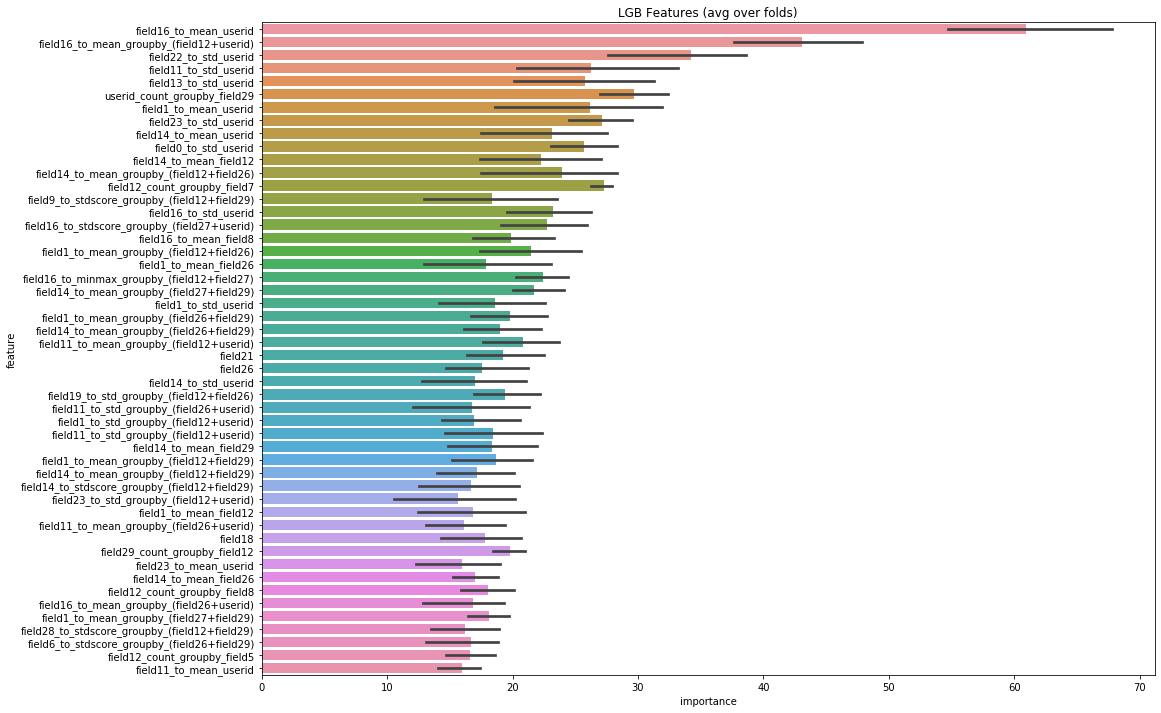

In [72]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

In [73]:
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
test['proba'] = result_dict['prediction']
sub = pd.read_csv('data/onetwotrip_challenge_sub1.csv')
sub['proba'] = test['proba'] / test['proba'].max()
sub.reset_index(drop=True).set_index('orderid').to_csv(f'{p.working_folder}/submission-{t}.csv')

## Goal2

In [19]:
exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23',
       'goal24', 'goal25', 'goal1','userid',]

In [21]:
sub2 = pd.read_csv('data/onetwotrip_challenge_sub2.csv')

In [40]:
sub2.columns = ['orderid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']
sub2 = pd.DataFrame(0, columns=sub2.columns, index=sub2.index)

Goal  1
Fold 1 started at Tue Dec 17 16:18:17 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.875224	training's auc: 0.875224	valid_1's auc: 0.701886	valid_1's auc: 0.701886
[200]	training's auc: 0.925883	training's auc: 0.925883	valid_1's auc: 0.696779	valid_1's auc: 0.696779
Early stopping, best iteration is:
[100]	training's auc: 0.875224	training's auc: 0.875224	valid_1's auc: 0.701886	valid_1's auc: 0.701886
Fold 2 started at Tue Dec 17 16:19:23 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.876093	training's auc: 0.876093	valid_1's auc: 0.693512	valid_1's auc: 0.693512
Early stopping, best iteration is:
[30]	training's auc: 0.792081	training's auc: 0.792081	valid_1's auc: 0.700029	valid_1's auc: 0.700029
Fold 3 started at Tue Dec 17 16:20:16 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.879044	training's auc: 0.879044	valid_1's auc: 0.704456	valid_1'

Early stopping, best iteration is:
[20]	training's auc: 0.941855	training's auc: 0.941858	valid_1's auc: 0.906676	valid_1's auc: 0.906645
Fold 4 started at Tue Dec 17 16:38:07 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.981925	training's auc: 0.981925	valid_1's auc: 0.894457	valid_1's auc: 0.894457
[200]	training's auc: 0.993774	training's auc: 0.993774	valid_1's auc: 0.893544	valid_1's auc: 0.893544
Early stopping, best iteration is:
[113]	training's auc: 0.984797	training's auc: 0.984797	valid_1's auc: 0.894875	valid_1's auc: 0.894875
Fold 5 started at Tue Dec 17 16:38:56 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.982665	training's auc: 0.982665	valid_1's auc: 0.897471	valid_1's auc: 0.897471
Early stopping, best iteration is:
[58]	training's auc: 0.969519	training's auc: 0.969519	valid_1's auc: 0.898072	valid_1's auc: 0.898072
CV mean score: 0.9016, std: 0.0060.


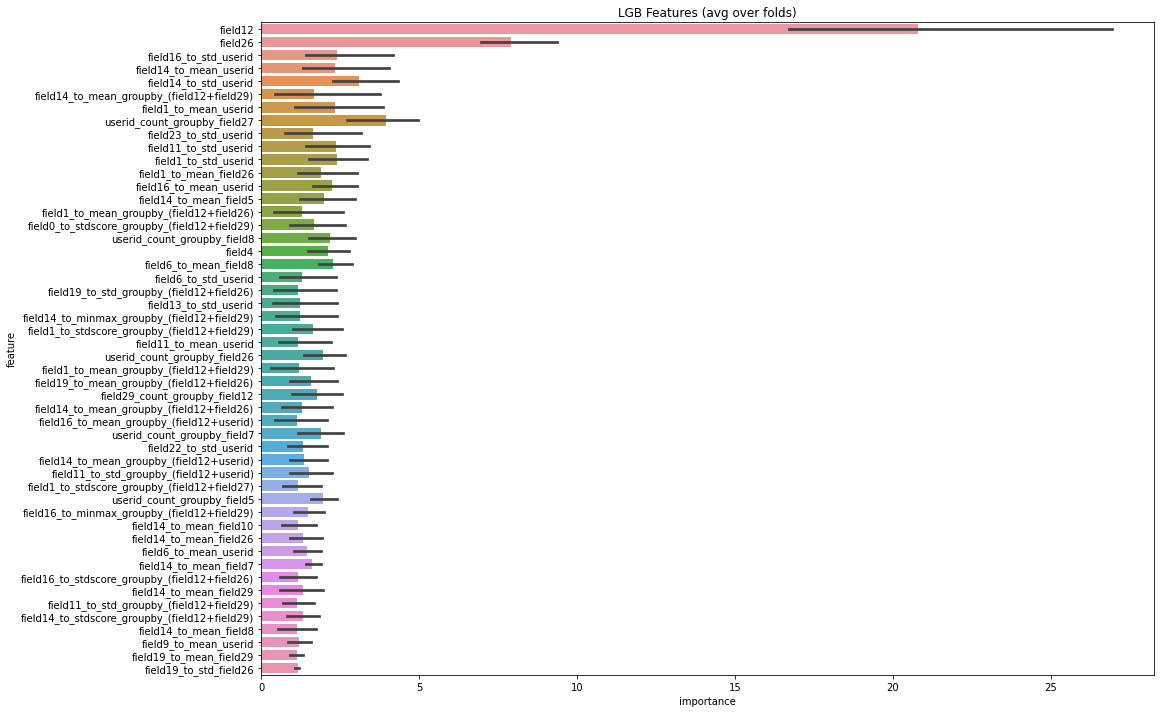

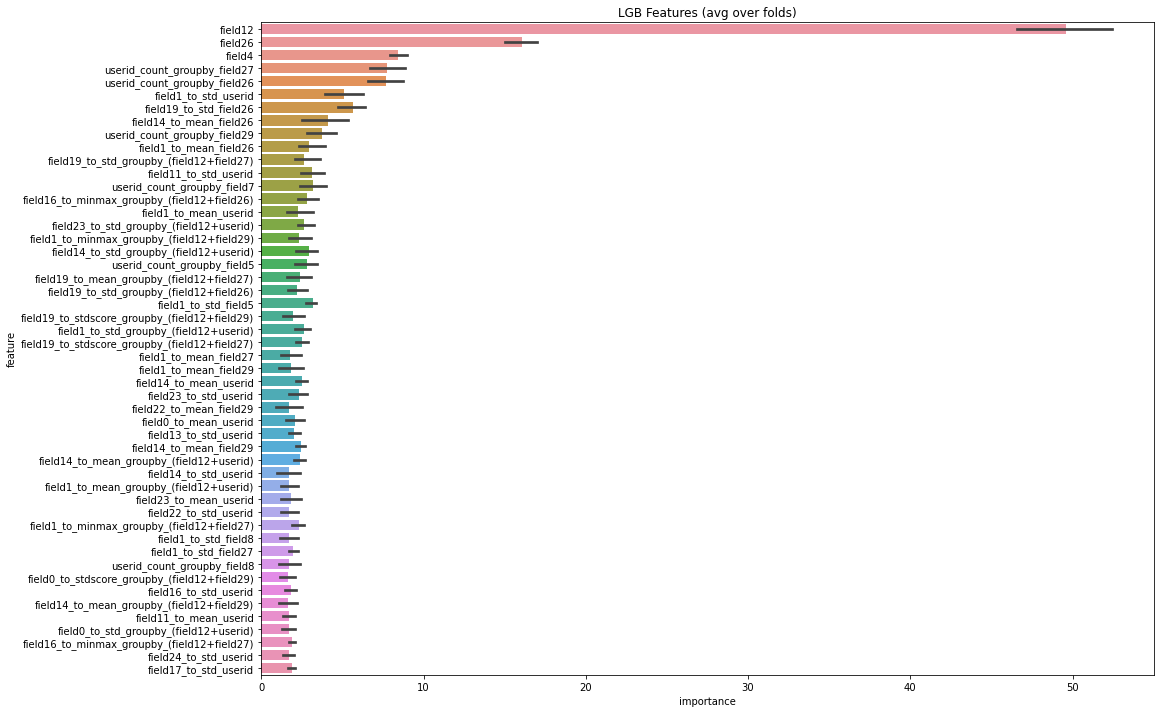

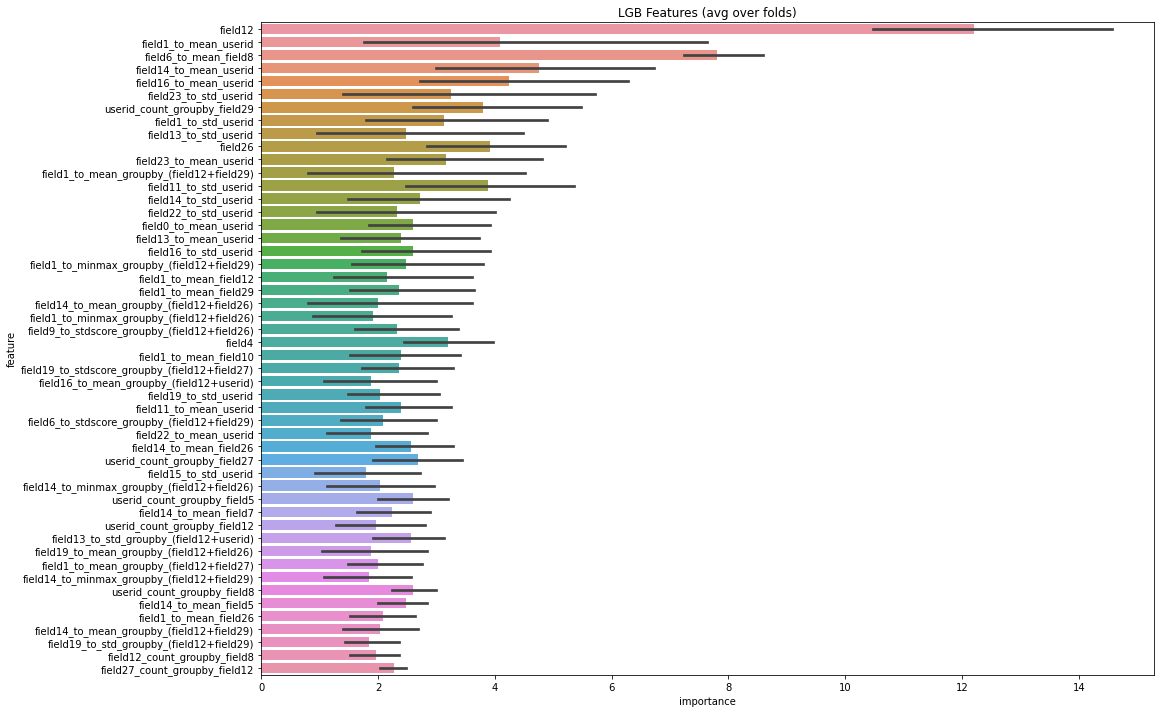

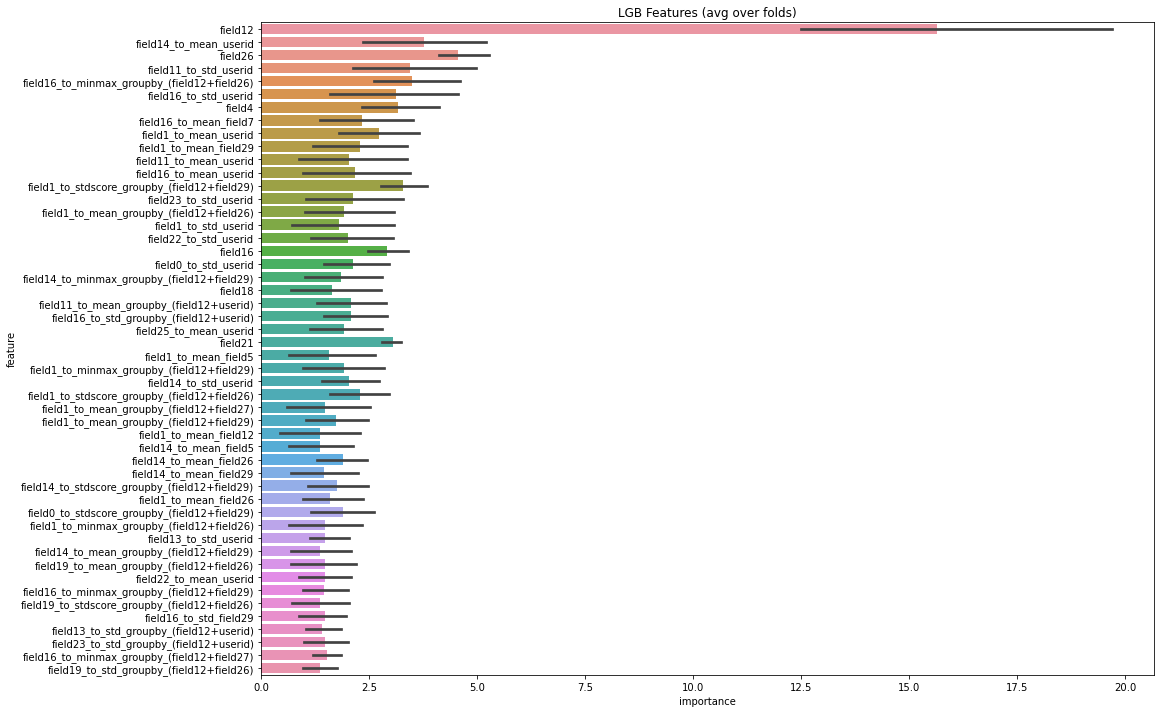

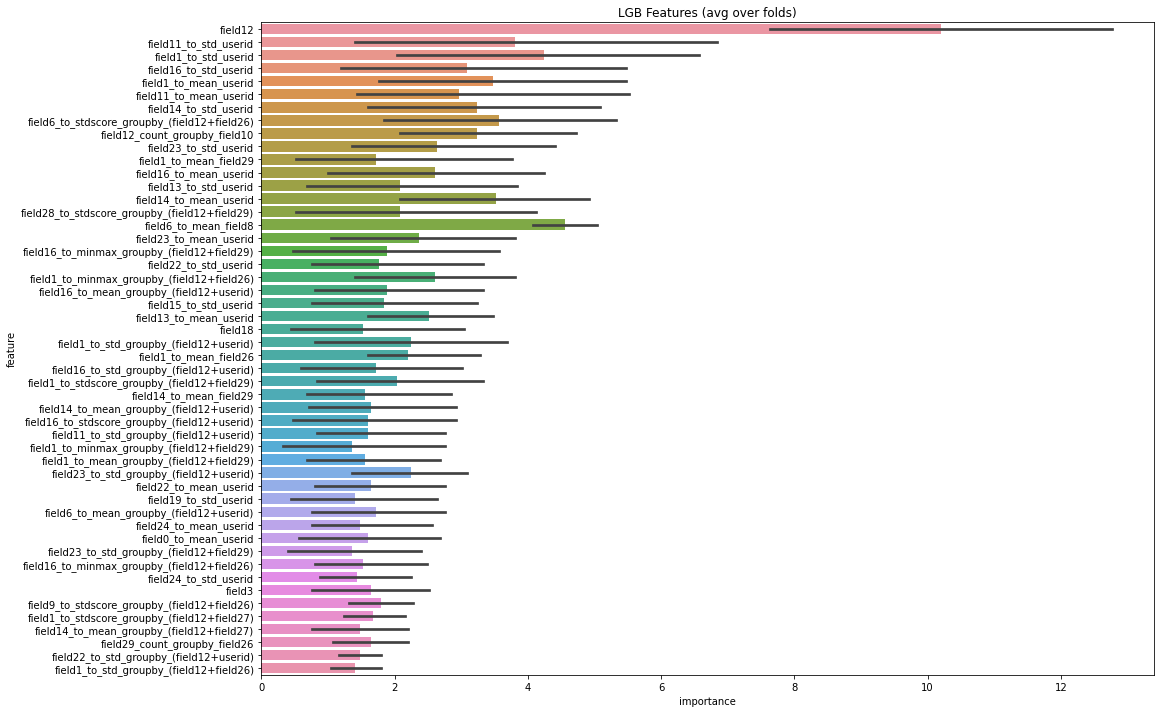

In [41]:
from sklearn.model_selection import GroupKFold, KFold

data = p.data['data']
for i_goal in range(1,6):
    print ("Goal ", i_goal)
    data_filtered = data[data[f'indicator_goal2{i_goal}'] == 1]
    X = data_filtered[data_filtered[f'goal2{i_goal}']>=0].drop([f'goal2{i_goal}'], axis=1)
    y = data_filtered[data_filtered[f'goal2{i_goal}']>=0][f'goal2{i_goal}']
    test=data[data[f'goal2{i_goal}']<0]
    train_features = [f for f in data.columns if f not in exclude_features_from_training]


    NFOLDS = 5
    folds = GroupKFold(n_splits=NFOLDS)
    params = {
              'objective': 'binary',
              "metric": 'auc',
              "verbosity": -1,
             }
    train_options = {
            "model_type":'lgb',
            "params": params,
            "eval_metric":'auc',
            'early_stopping_rounds': 100,
            'n_estimators': 500,
            'averaging': 'rank',
            'use_groups': False,
            'fold_name': folds.__class__.__name__,
            'n_splits': NFOLDS
        }

    result_dict = train_model_classification_vb( X=X, 
                                                 X_test=test, 
                                                 columns=train_features,
                                                 y=y, 
                                                 params=params, folds=folds,
                                                 model_type=train_options['model_type'], 
                                                 plot_feature_importance=True,
                                                 verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                                 n_estimators=train_options['n_estimators'], 
                                                 averaging=train_options['averaging'],
                                                 groups=X['userid'],
                                                 n_jobs=-1)
    test[f'proba2{i_goal}'] = result_dict['prediction']
    sub2[f'goal2{i_goal}'] = test[f'proba2{i_goal}'] / test[f'proba2{i_goal}'].max()
    
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
sub2.reset_index(drop=True).to_csv(f'{p.working_folder}/submission2-{t}.csv')

In [44]:
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
sub2.drop(['orderid'],axis=1).reset_index(drop=True).to_csv(f'{p.working_folder}/submission2-{t}.csv')

## Results

### NO FE. initial

Fold 1 started at Sun Dec 15 19:17:47 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.8352	training's auc: 0.8352	valid_1's auc: 0.660413	valid_1's auc: 0.660413
Early stopping, best iteration is:
[36]	training's auc: 0.769533	training's auc: 0.769533	valid_1's auc: 0.671052	valid_1's auc: 0.671052
Fold 2 started at Sun Dec 15 19:17:58 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.832962	training's auc: 0.832962	valid_1's auc: 0.708005	valid_1's auc: 0.708005
Early stopping, best iteration is:
[27]	training's auc: 0.742707	training's auc: 0.742708	valid_1's auc: 0.71381	valid_1's auc: 0.713811
Fold 3 started at Sun Dec 15 19:18:06 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.833846	training's auc: 0.833846	valid_1's auc: 0.684287	valid_1's auc: 0.684287
Early stopping, best iteration is:
[28]	training's auc: 0.753781	training's auc: 0.753782	valid_1's

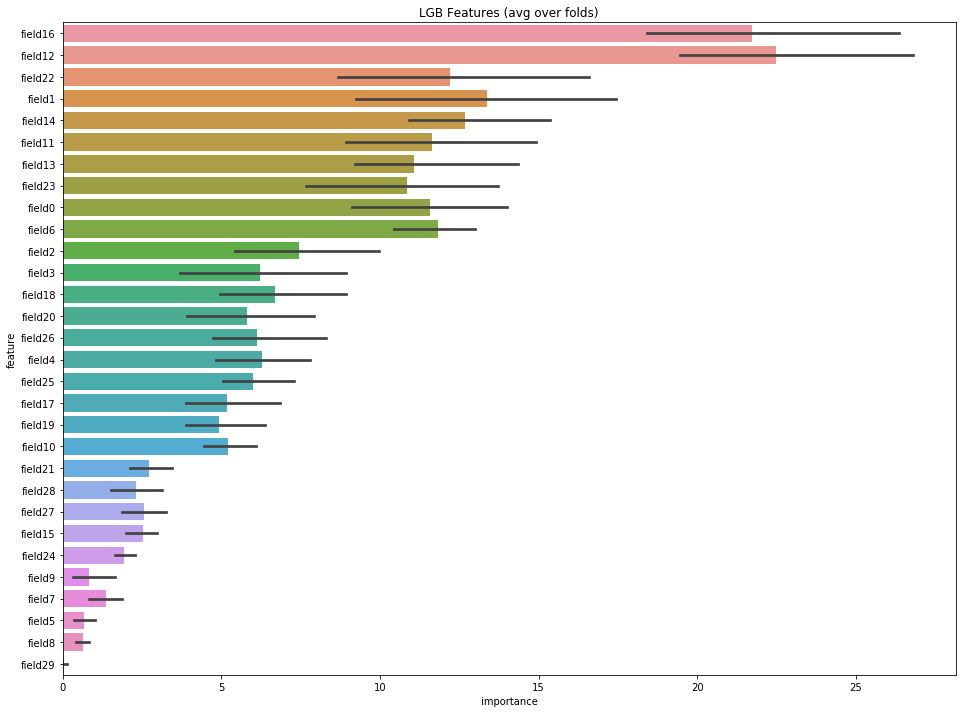

In [22]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### add first aggregate node

Fold 1 started at Sun Dec 15 20:21:06 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.892444	training's auc: 0.892444	valid_1's auc: 0.672213	valid_1's auc: 0.672213
Early stopping, best iteration is:
[67]	training's auc: 0.857729	training's auc: 0.857729	valid_1's auc: 0.676682	valid_1's auc: 0.676682
Fold 2 started at Sun Dec 15 20:21:38 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.890783	training's auc: 0.890783	valid_1's auc: 0.705956	valid_1's auc: 0.705956
Early stopping, best iteration is:
[40]	training's auc: 0.817173	training's auc: 0.817173	valid_1's auc: 0.72028	valid_1's auc: 0.720279
Fold 3 started at Sun Dec 15 20:22:05 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.890927	training's auc: 0.890927	valid_1's auc: 0.688385	valid_1's auc: 0.688385
Early stopping, best iteration is:
[33]	training's auc: 0.803194	training's auc: 0.803194	valid

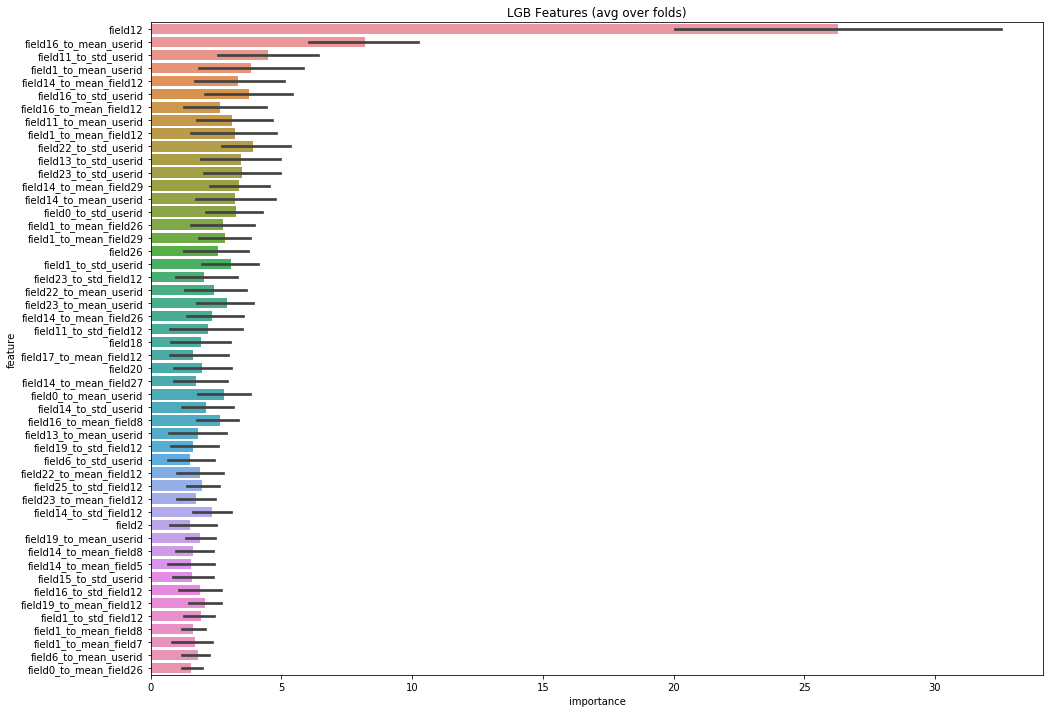

In [13]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### More aggregates

Fold 1 started at Mon Dec 16 23:23:56 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.904606	training's auc: 0.904606	valid_1's auc: 0.671887	valid_1's auc: 0.671887
Early stopping, best iteration is:
[50]	training's auc: 0.847829	training's auc: 0.847829	valid_1's auc: 0.676644	valid_1's auc: 0.676644
Fold 2 started at Mon Dec 16 23:24:55 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.900505	training's auc: 0.900505	valid_1's auc: 0.712615	valid_1's auc: 0.712615
Early stopping, best iteration is:
[34]	training's auc: 0.810291	training's auc: 0.810291	valid_1's auc: 0.718987	valid_1's auc: 0.718985
Fold 3 started at Mon Dec 16 23:25:42 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.900145	training's auc: 0.900145	valid_1's auc: 0.694774	valid_1's auc: 0.694774
Early stopping, best iteration is:
[46]	training's auc: 0.84242	training's auc: 0.84242	valid_

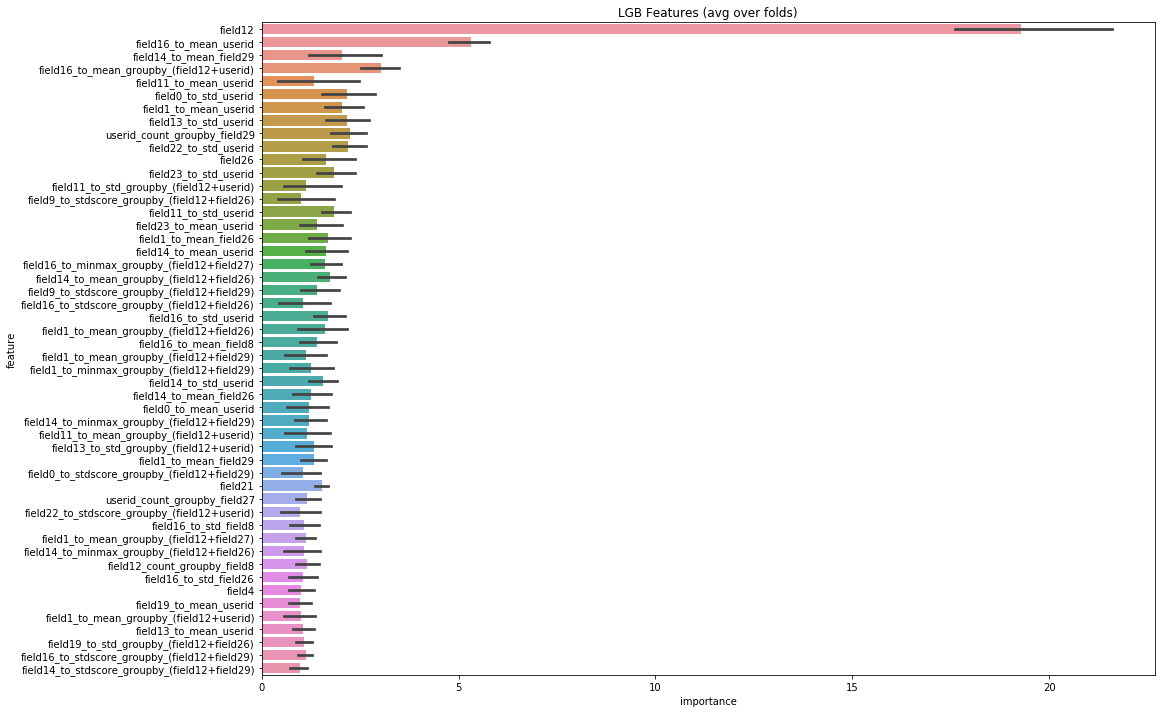

In [15]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### Aggs+rfe+tune params (0.6847) - submission_rfe-12-19-20-54.csv

Fold 1 started at Wed Dec 18 21:29:43 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.784354	training's auc: 0.784353	valid_1's auc: 0.671344	valid_1's auc: 0.671339
[200]	training's auc: 0.828908	training's auc: 0.828908	valid_1's auc: 0.676033	valid_1's auc: 0.676032
[300]	training's auc: 0.866599	training's auc: 0.866599	valid_1's auc: 0.678715	valid_1's auc: 0.678715
[400]	training's auc: 0.894881	training's auc: 0.894881	valid_1's auc: 0.679986	valid_1's auc: 0.679986
[500]	training's auc: 0.91094	training's auc: 0.91094	valid_1's auc: 0.67955	valid_1's auc: 0.67955
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.91094	training's auc: 0.91094	valid_1's auc: 0.67955	valid_1's auc: 0.67955
Fold 2 started at Wed Dec 18 21:32:46 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.771693	training's auc: 0.771689	valid_1's auc: 0.712078	valid_1's auc: 0.71208
[200]	training's auc:

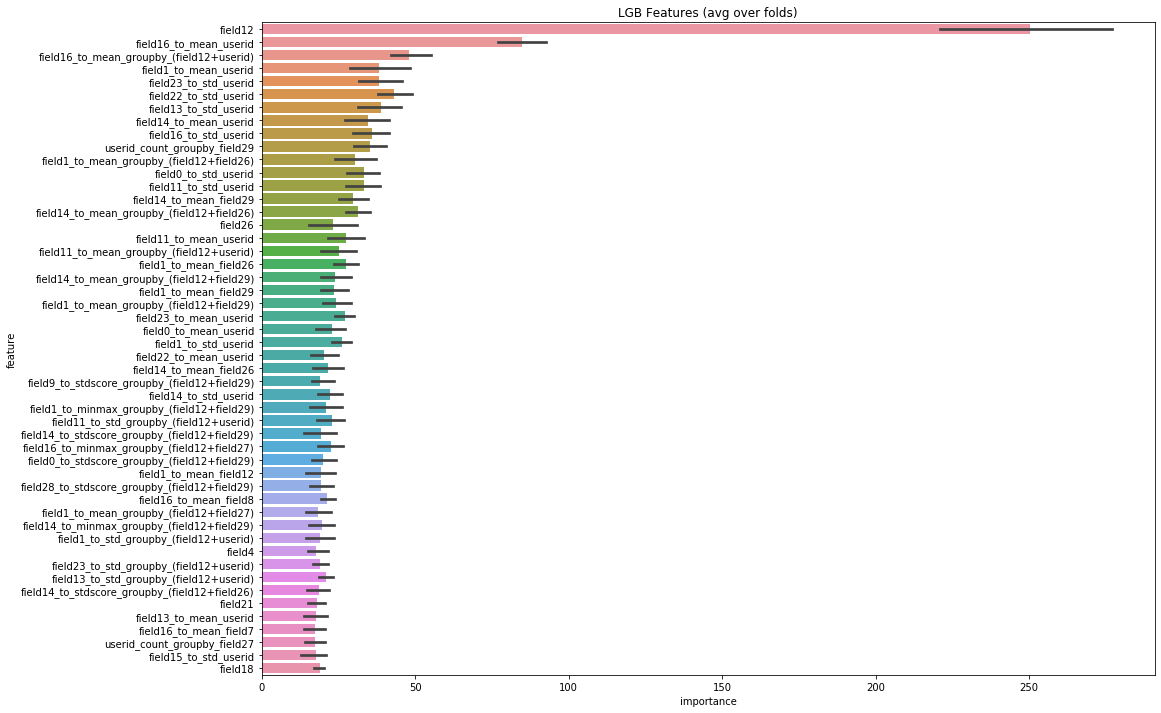

In [19]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)